# TESS Atlas fit for TOI 204

**Version: 0.1.1**

**Note: This notebook was automatically generated as part of the TESS Atlas project. More information can be found on GitHub:** [github.com/dfm/tess-atlas](https://github.com/dfm/tess-atlas)

In this notebook, we do a quicklook fit for the parameters of the TESS Objects of Interest (TOI) in the system number 204.
To do this fit, we use the [exoplanet](https://exoplanet.dfm.io) library and you can find more information about that project at [exoplanet.dfm.io](https://exoplanet.dfm.io).

From here, you can scroll down and take a look at the fit results, or you can:

- [open the notebook in Google Colab to run the fit yourself](https://colab.research.google.com/github/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-204.ipynb),
- [view the notebook on GitHub](https://github.com/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-204.ipynb), or
- [download the notebook](https://github.com/dfm/tess-atlas/raw/master/notebooks/0.1.1/toi-204.ipynb).

## Caveats

There are many caveats associated with this relatively simple "quicklook" type of analysis that should be kept in mind.
Here are some of the main things that come to mind:

1. The orbits that we fit are constrained to be *circular*. One major effect of this approximation is that the fit will significantly overestimate the confidence of the impact parameter constraint, so the results for impact parameter shouldn't be taken too seriously. 

2. Transit timing variations, correlated noise, and (probably) your favorite systematics are ignored. Sorry!

3. This notebook was generated automatically without human intervention. Use at your own risk!

## Table of Contents

1. [Getting started](#Getting-started)
2. [Data & de-trending](#Data-%26amp%3B-de-trending)
3. [Removing stellar variability](#Removing-stellar-variability)
4. [Transit model in PyMC3 & exoplanet](#Transit-model-in-PyMC3-%26amp%3B-exoplanet)
5. [Sampling](#Sampling)
6. [Posterior constraints](#Posterior-constraints)
7. [Attribution](#Attribution)

## Getting started

To get going, we'll need to make out plots show up inline and install a few packages:

In [1]:
%matplotlib inline
!pip install -q -U lightkurve fbpca exoplanet corner pymc3

Then we'll set up the plotting styles and do all of the imports:

In [2]:
import matplotlib.pyplot as plt
plt.style.use("default")

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logger = logging.getLogger("theano.gof.compilelock")
logger.setLevel(logging.ERROR)

import corner
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

## Data & de-trending

Next, we grab the TOI list from [ExoFOP](https://exofop.ipac.caltech.edu/tess/) to get the information about the system:

In [3]:
toi_num = 204

# Get the table of TOI info from ExoFOP
tois = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

# Select all of the rows in the TOI table that are associated with this target
toi = tois[tois["TOI"] == toi_num + 0.01].iloc[0]
tic = toi['TIC ID']
tois = tois[tois["TIC ID"] == tic].sort_values("TOI")

# Extract the planet periods
periods = np.array(tois["Period (days)"], dtype=float)

# Convert the phase to TBJD from BJD
t0s = np.array(tois["Epoch (BJD)"], dtype=float) - 2457000

# Convert the depth to parts per thousand from parts per million
depths = 1e-3 * np.array(tois["Depth (ppm)"], dtype=float)

# Convert the duration to days from hours
durations = np.array(tois["Duration (hours)"], dtype=float) / 24.0

# Extract the stellar radius from the table
toi_r_star = toi['Stellar Radius (R_Sun)']
toi_r_star_err = toi['Stellar Radius (R_Sun) err']
toi_logg_star = toi['Stellar log(g) (cm/s^2)']
toi_logg_star_err = toi['Stellar log(g) (cm/s^2) err']

# If there is no entry in the table (does this ever happen?)
if not (np.isfinite(toi_r_star) and np.isfinite(toi_r_star_err)):
    raise ValueError("no radius measurement in table")
if not (np.isfinite(toi_logg_star) and np.isfinite(toi_logg_star_err)):
    raise ValueError("no logg measurement in table")

# These are the letters that will be used to identify each candidate
# (are we being a bit optimistic?)
letters = "bcdefghijklmnopqrstuvwxyz"[:len(periods)]

Then we use the [lightkurve](https://docs.lightkurve.org) library to download and de-trend the time series using [pixel-level decorrelation (PLD)](https://docs.lightkurve.org/api/lightkurve.correctors.PLDCorrector.html).
We read in target pixel files (TPFs) for each of the campaigns in which TOI 204 was observed.
To remove systematic noise, we mask out known transits and perform second order PLD. The noise-corrected light curves are stitched together to create a single contiguous light curve.

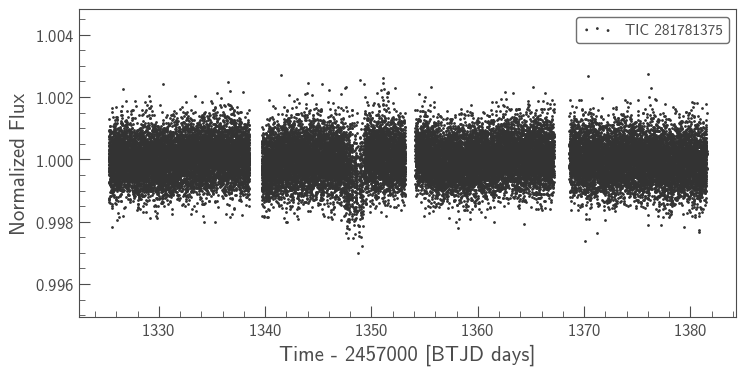

In [4]:
# Download the target pixel files
sr = lk.search_targetpixelfile('TIC %i' % tic)
tpf_collection = sr.download_all(quality_bitmask="hardest")
if tpf_collection is None or not len(tpf_collection):
    raise ValueError("the TESS atlas only works for TPF files")
    
# Extract the exposure time associated with the TPF
hdr = tpf_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# This function can be used to estimate which data points are in transit
# for known phase, period, and duration
def get_transit_mask(t, t0, period, duration):
    hp = 0.5*period
    return np.abs((t-t0+hp) % period - hp) < 0.5*duration

# Run PLD on each TPF to extract the light curves
lc_collection = []
for tpf in tpf_collection:
    mask = np.zeros_like(tpf.time, dtype=bool)
    for i in range(len(periods)):
        mask |= get_transit_mask(tpf.time, t0s[i], periods[i], 5*durations[i])
    pld = tpf.to_corrector("pld")
    try:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=2)
    except ValueError:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=1)
    lc_collection.append(lc.normalize())

# Normalize and stitch the sectors
lc = lc_collection[0]
if len(lc_collection) > 1:
    lc = lc.append([next_lc for next_lc in lc_collection[1:]])
    
# Remove outliers
_, outliers = lc.remove_outliers(return_mask=True)
mask = np.zeros_like(lc.time, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(lc.time, t0s[i], periods[i], 2*durations[i])
outliers[mask] = False
lc = lc[~outliers]
    
lc.scatter();

# Removing stellar variability

Next up, we remove stellar variability using a Gaussian Processes model fit to the out of transit data.

In [5]:
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# Compute the transit mask
mask = np.zeros_like(x, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(x, t0s[i], periods[i], 5*durations[i])

# Temporarily increase the in transit error bars substantially
diag = np.array(yerr**2)
diag[mask] += 10000.0

# Build a GP model
with pm.Model() as model:
    logs2 = pm.Normal("logs2", mu=np.log(1e-4*np.var(y)), sd=10)
    logsigma = pm.Normal("logsigma", mu=np.log(np.std(y)), sd=10)
    logrho = pm.Normal("logrho", mu=np.log(10.0), sd=10.0)
    
    kernel = xo.gp.terms.Matern32Term(log_sigma=logsigma, log_rho=logrho)
    gp = xo.gp.GP(kernel, x, diag + tt.exp(logs2), J=2)
    pm.Potential("loglike", gp.log_likelihood(y))
    
    map_soln = xo.optimize()
    pred = xo.utils.eval_in_model(gp.predict(), map_soln)

# Flatten the light curve
y -= pred

optimizing logp for variables: ['logrho', 'logsigma', 'logs2']


message: Optimization terminated successfully.
logp: -39225.90186044747 -> -38885.2402851903


## Transit model in PyMC3 & exoplanet

Here's how we set up the transit model using [exoplanet](https://exoplanet.dfm.io) and [PyMC3](https://docs.pymc.io).
For more information about how to use these libraries take a look at the docs that are linked above.
In this model, the parameters that we're fitting are:

* `mean`: the mean (out-of-transit) flux of the star,
* `r_star`: the radius of the star (with the prior from the TOI list),
* `logg_star`: the surface gravity of the star (with the prior from the TOI list),
* `u`: the quadratic limb darkening parameters, parameterized following [Kipping (2013)](https://arxiv.org/abs/1308.0009)
* `t0`: the time of a reference transit for each planet,
* `logP`: the log of the obribatl periods,
* `r`: the planet radius ratios (relative to the star),
* `b`: the impact parameter in units of the stellar radius, `b` and `r` are both parameterized following [Espinoza (2018)](https://iopscience.iop.org/article/10.3847/2515-5172/aaef38/meta), and
* `logs2`: a jitter parameter that captures excess noise or underrestimated error bars.

A few key assumptions include:

* The orbits are assumed to be circular so the constraints on impact parameter (which would be severely degenerate with eccentricity) will be tighter than they should be.
* The noise is assumed to be Gaussian and independent. This means that all correlated noise should be removed in advance. Since we flattened the light curve using a Gaussian process above, this should be not totally unreasonable.
* We are neglecting transit times (the ephemeris is assumed to be linear) which should be sufficient for most cases with the short TESS baseline, but transit timing variations could be important for some targets.

In [6]:
# factor * 10**logg / r_star = rho
factor = 5.141596357654149e-05

def build_model(x, y, yerr, periods, t0s, depths, mask=None, start=None):
    """Build an exoplanet model for a dataset and set of planets
    
    Args:
        x: The time series (in days); this should probably be centered
        y: The relative fluxes (in parts per thousand)
        yerr: The uncertainties on ``y``
        periods: The periods of the planets (in days)
        t0s: The phases of the planets in the same coordinates as ``x``
        depths: The depths of the transits in parts per thousand
        mask: A boolean mask with the same shape as ``x`` indicating which
            data points should be included in the fit
        start: A dictionary of model parameters where the optimization
            should be initialized
            
    Returns:
        A PyMC3 model specifying the probabilistic model for the light curve

    """
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    periods = np.atleast_1d(periods)
    t0s = np.atleast_1d(t0s)
    depths = np.atleast_1d(depths)
    n_planets = len(periods)
    
    with pm.Model() as model:
        
        # Extract the un-masked data points
        model.x = x[mask]
        model.y = y[mask]
        model.yerr = (yerr + np.zeros_like(x))[mask]
        model.mask = mask

        # The baseline (out-of-transit) flux for the star in ppt. This
        # should be close to one because of how we normalized the data
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        
        logg_star = pm.Normal("logg_star", mu=toi_logg_star, sd=toi_logg_star_err)
        r_star = pm.Bound(pm.Normal, lower=0.0)("r_star", mu=toi_r_star, sd=toi_r_star_err)
        rho_star = pm.Deterministic("rho_star", factor * 10**logg_star / r_star)

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", tt.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u")

        # The Espinoza (2018) parameterization for the joint radius ratio and
        # impact parameter distribution
        r, b = xo.distributions.get_joint_radius_impact(
            min_radius=0.001, max_radius=1.0,
            testval_r=np.sqrt(1e-3*np.array(depths)),
            testval_b=0.5+np.zeros(n_planets)
        )
        r_pl = pm.Deterministic("r_pl", r * r_star)

        # This shouldn't make a huge difference, but I like to put a uniform
        # prior on the *log* of the radius ratio instead of the value. This
        # can be implemented by adding a custom "potential" (log probability).
        pm.Potential("r_prior", -pm.math.log(r))

        # Set up a Keplerian orbit for the planets
        model.orbit = xo.orbits.KeplerianOrbit(
            period=period, t0=t0, b=b, r_star=r_star, rho_star=rho_star)
        
        # Compute the model light curve using starry
        model.light_curves = xo.StarryLightCurve(u).get_light_curve(
            orbit=model.orbit, r=r_pl, t=model.x)
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) * 1e3 + mean

        # Jitter and likelihood function
        logs2 = pm.Normal("logs2", mu=np.log(np.mean(model.yerr)), sd=10)
        pm.Normal("obs", mu=model.light_curve, sd=tt.sqrt(model.yerr**2+tt.exp(logs2)),
                  observed=model.y)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start        
        map_soln = xo.optimize(start=map_soln, vars=[logs2, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln, vars=[logg_star])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln)
        model.map_soln = map_soln
        
    return model

def build_model_sigma_clip(x, y, yerr, periods, t0s, depths, sigma=5.0, maxiter=10, start=None):
    ntot = len(x)
    for i in range(maxiter):
        print("*** Sigma clipping round {0} ***".format(i+1))
        
        # Build the model
        model = build_model(x, y, yerr, periods, t0s, depths, start=start)
        start = model.map_soln

        # Compute the map prediction
        with model:
            mod = xo.utils.eval_in_model(model.light_curve, model.map_soln)
            
        # Do sigma clipping
        resid = y - mod
        rms = np.sqrt(np.median(resid**2))
        mask = np.abs(resid) < sigma * rms
        if ntot == mask.sum():
            break
        ntot = mask.sum()

    return model

Using the above function, we'll generate a probabilistic model for the light curve and plot the maximum a posteriori fit.

*** Sigma clipping round 1 ***


optimizing logp for variables: ['mean', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: -37883.14109354523 -> -32580.114910635824


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -32580.114910635824 -> -32528.655094531852


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -32528.655094531852 -> -32528.65294616672


optimizing logp for variables: ['mean', 't0', 'logP']


message: Optimization terminated successfully.
logp: -32528.65294616672 -> -32528.33244274024


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -32528.33244274024 -> -32528.332171605307


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -32528.332171605307 -> -32527.98024595047


*** Sigma clipping round 2 ***


optimizing logp for variables: ['mean', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: -32527.98024595048 -> -32527.98024595048


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -32527.98024595047 -> -32527.98024595047


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -32527.98024595047 -> -32527.980245950446


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -32527.980245950446 -> -32527.980245950446


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -32527.980245950446 -> -32527.98024595033


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -32527.98024595033 -> -32527.980245950177


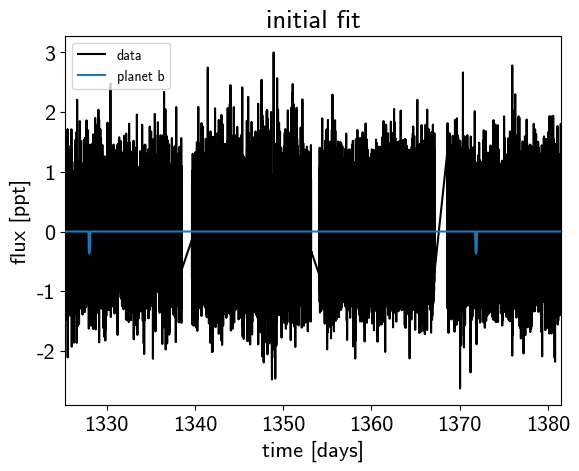

In [7]:
model = build_model_sigma_clip(x, y, yerr, periods, t0s, depths)

with model:
    mean = model.map_soln["mean"]
    light_curves = xo.utils.eval_in_model(model.light_curves, model.map_soln)

plt.plot(model.x, model.y - mean, "k", label="data")
for n, l in enumerate(letters):
    plt.plot(model.x, 1e3 * light_curves[:, n], label="planet {0}".format(l), zorder=100-n)

plt.xlabel("time [days]")
plt.ylabel("flux [ppt]")
plt.title("initial fit")
plt.xlim(model.x.min(), model.x.max())
plt.legend(fontsize=10);

## Sampling

Now we use PyMC3 to sample the posterior density for the parameters of this model.

In [8]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=50, start=50, finish=500)
with model:
    burnin = sampler.tune(tune=3000, start=model.map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=2, cores=2)
    trace = sampler.sample(draws=1000, chains=2, cores=2)

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   9%|▊         | 9/104 [00:01<00:11,  8.57draws/s]

Sampling 2 chains:  10%|▉         | 10/104 [00:01<00:13,  7.05draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:01<00:25,  3.60draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:02<00:29,  3.09draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:02<00:31,  2.93draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:03<00:40,  2.25draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:03<00:33,  2.68draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:04<00:44,  1.98draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:05<00:42,  2.05draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:05<00:34,  2.47draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:06<00:44,  1.87draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:06<00:35,  2.33draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:07<00:43,  1.90draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:07<00:35,  2.29draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:08<00:38,  2.06draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:08<00:36,  2.17draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:08<00:35,  2.23draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:09<00:42,  1.83draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:10<00:39,  1.90draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:10<00:34,  2.13draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:11<00:39,  1.86draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:12<00:44,  1.63draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:12<00:35,  2.01draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:13<00:43,  1.61draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:14<00:37,  1.79draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:14<00:29,  2.26draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:15<00:33,  1.94draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:15<00:32,  2.01draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:16<00:29,  2.17draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:16<00:35,  1.77draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:17<00:31,  1.95draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:17<00:26,  2.25draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:18<00:27,  2.16draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:18<00:26,  2.15draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:19<00:24,  2.33draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:19<00:28,  1.98draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:20<00:26,  2.05draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:21<00:20,  2.65draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:21<00:25,  2.05draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:22<00:21,  2.35draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:22<00:22,  2.21draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:23<00:22,  2.15draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:23<00:19,  2.47draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:24<00:24,  1.94draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:25<00:22,  2.00draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:25<00:20,  2.13draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:26<00:17,  2.41draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:26<00:19,  2.15draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:27<00:17,  2.23draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:27<00:18,  2.10draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:28<00:18,  2.10draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:28<00:16,  2.29draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:29<00:18,  1.97draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:30<00:16,  2.03draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:30<00:14,  2.18draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:31<00:13,  2.37draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:31<00:13,  2.26draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:32<00:13,  2.15draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:32<00:11,  2.51draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:33<00:13,  2.01draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:33<00:11,  2.18draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:34<00:10,  2.25draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:34<00:09,  2.47draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:35<00:10,  2.08draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:36<00:09,  2.19draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:36<00:07,  2.67draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:36<00:08,  2.22draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:37<00:07,  2.28draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:37<00:07,  2.22draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:38<00:06,  2.19draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:38<00:05,  2.40draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:39<00:06,  2.14draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:39<00:04,  2.53draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:39<00:05,  2.16draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:40<00:05,  1.72draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:41<00:06,  1.40draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:42<00:06,  1.28draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:43<00:04,  1.44draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:44<00:03,  1.37draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:45<00:03,  1.28draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:46<00:02,  1.26draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:47<00:01,  1.26draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:47<00:00,  1.27draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:51<00:00,  1.51s/draws]

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   9%|▊         | 9/104 [00:00<00:03, 27.31draws/s]

Sampling 2 chains:  10%|▉         | 10/104 [00:00<00:10,  8.97draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:01<00:21,  4.42draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:01<00:33,  2.78draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:02<00:29,  3.05draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:02<00:44,  2.04draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:03<00:34,  2.56draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:04<00:48,  1.80draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:04<00:45,  1.90draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:05<00:35,  2.40draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:05<00:34,  2.46draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:06<00:38,  2.15draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:06<00:32,  2.51draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:07<00:41,  1.95draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:07<00:37,  2.09draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:08<00:32,  2.42draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:08<00:34,  2.26draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:09<00:37,  2.02draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:09<00:30,  2.49draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:10<00:37,  1.95draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:10<00:29,  2.49draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:11<00:34,  2.09draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:11<00:34,  2.07draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:11<00:30,  2.32draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:12<00:34,  1.98draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:12<00:26,  2.54draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:13<00:35,  1.91draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:14<00:32,  2.03draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:14<00:25,  2.47draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:15<00:28,  2.19draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:15<00:27,  2.25draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:15<00:25,  2.36draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:16<00:30,  1.95draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:17<00:28,  2.03draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:18<00:29,  1.94draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:18<00:24,  2.31draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:19<00:30,  1.79draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:19<00:26,  2.05draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:19<00:25,  2.08draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:20<00:28,  1.84draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:20<00:21,  2.41draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:21<00:26,  1.86draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:21<00:20,  2.38draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:22<00:23,  2.05draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:22<00:22,  2.13draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:23<00:19,  2.31draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:23<00:23,  1.91draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:24<00:21,  2.03draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:24<00:17,  2.36draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:25<00:18,  2.22draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:26<00:20,  1.99draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:26<00:15,  2.44draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:27<00:19,  1.91draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:27<00:14,  2.48draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:27<00:14,  2.41draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:28<00:16,  2.09draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:28<00:13,  2.47draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:29<00:17,  1.93draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:29<00:12,  2.51draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:30<00:14,  2.11draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:30<00:12,  2.33draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:31<00:11,  2.37draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:31<00:10,  2.67draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:31<00:10,  2.40draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:32<00:10,  2.30draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:32<00:09,  2.45draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:33<00:11,  2.05draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:33<00:08,  2.59draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:34<00:10,  1.94draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:35<00:09,  2.07draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:35<00:07,  2.47draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:36<00:07,  2.22draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:36<00:07,  2.14draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:36<00:06,  2.36draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:37<00:07,  1.97draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:38<00:08,  1.52draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:39<00:09,  1.30draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:40<00:07,  1.48draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:41<00:05,  1.60draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:42<00:05,  1.38draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:42<00:05,  1.31draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:43<00:03,  1.49draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:44<00:02,  1.40draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:45<00:02,  1.33draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:46<00:01,  1.29draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:47<00:00,  1.26draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:50<00:00,  1.56s/draws]

Sampling 2 chains:   0%|          | 0/204 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/204 [00:00<03:00,  1.13draws/s]

Sampling 2 chains:   1%|          | 2/204 [00:00<02:12,  1.53draws/s]

Sampling 2 chains:   1%|▏         | 3/204 [00:01<01:41,  1.98draws/s]

Sampling 2 chains:   2%|▏         | 4/204 [00:01<01:56,  1.72draws/s]

Sampling 2 chains:   2%|▏         | 5/204 [00:02<01:27,  2.26draws/s]

Sampling 2 chains:   3%|▎         | 6/204 [00:02<01:42,  1.93draws/s]

Sampling 2 chains:   3%|▎         | 7/204 [00:02<01:24,  2.33draws/s]

Sampling 2 chains:   4%|▍         | 8/204 [00:03<01:35,  2.06draws/s]

Sampling 2 chains:   4%|▍         | 9/204 [00:03<01:18,  2.50draws/s]

Sampling 2 chains:   5%|▍         | 10/204 [00:04<01:29,  2.17draws/s]

Sampling 2 chains:   5%|▌         | 11/204 [00:04<01:13,  2.63draws/s]

Sampling 2 chains:   6%|▌         | 12/204 [00:04<01:13,  2.60draws/s]

Sampling 2 chains:   6%|▋         | 13/204 [00:05<01:17,  2.47draws/s]

Sampling 2 chains:   7%|▋         | 14/204 [00:05<01:11,  2.66draws/s]

Sampling 2 chains:   7%|▋         | 15/204 [00:06<01:16,  2.47draws/s]

Sampling 2 chains:   8%|▊         | 16/204 [00:06<01:10,  2.67draws/s]

Sampling 2 chains:   8%|▊         | 17/204 [00:07<01:17,  2.41draws/s]

Sampling 2 chains:   9%|▉         | 18/204 [00:07<01:10,  2.65draws/s]

Sampling 2 chains:   9%|▉         | 19/204 [00:07<01:23,  2.21draws/s]

Sampling 2 chains:  10%|▉         | 20/204 [00:08<01:06,  2.76draws/s]

Sampling 2 chains:  10%|█         | 21/204 [00:08<01:22,  2.22draws/s]

Sampling 2 chains:  11%|█         | 22/204 [00:08<01:05,  2.79draws/s]

Sampling 2 chains:  11%|█▏        | 23/204 [00:09<01:20,  2.24draws/s]

Sampling 2 chains:  12%|█▏        | 24/204 [00:09<01:03,  2.84draws/s]

Sampling 2 chains:  12%|█▏        | 25/204 [00:10<01:08,  2.61draws/s]

Sampling 2 chains:  13%|█▎        | 26/204 [00:10<01:05,  2.71draws/s]

Sampling 2 chains:  13%|█▎        | 27/204 [00:10<01:12,  2.43draws/s]

Sampling 2 chains:  14%|█▎        | 28/204 [00:11<01:01,  2.86draws/s]

Sampling 2 chains:  15%|█▍        | 30/204 [00:11<00:54,  3.22draws/s]

Sampling 2 chains:  15%|█▌        | 31/204 [00:12<00:59,  2.92draws/s]

Sampling 2 chains:  16%|█▌        | 32/204 [00:12<01:01,  2.81draws/s]

Sampling 2 chains:  16%|█▌        | 33/204 [00:12<00:53,  3.20draws/s]

Sampling 2 chains:  17%|█▋        | 34/204 [00:12<00:49,  3.46draws/s]

Sampling 2 chains:  17%|█▋        | 35/204 [00:13<00:48,  3.51draws/s]

Sampling 2 chains:  18%|█▊        | 36/204 [00:13<00:59,  2.82draws/s]

Sampling 2 chains:  19%|█▊        | 38/204 [00:14<01:01,  2.70draws/s]

Sampling 2 chains:  19%|█▉        | 39/204 [00:14<00:48,  3.43draws/s]

Sampling 2 chains:  20%|██        | 41/204 [00:14<00:36,  4.44draws/s]

Sampling 2 chains:  21%|██        | 42/204 [00:15<00:52,  3.10draws/s]

Sampling 2 chains:  21%|██        | 43/204 [00:15<00:48,  3.29draws/s]

Sampling 2 chains:  22%|██▏       | 44/204 [00:16<01:01,  2.61draws/s]

Sampling 2 chains:  22%|██▏       | 45/204 [00:16<00:52,  3.05draws/s]

Sampling 2 chains:  23%|██▎       | 46/204 [00:16<01:05,  2.41draws/s]

Sampling 2 chains:  23%|██▎       | 47/204 [00:17<00:53,  2.93draws/s]

Sampling 2 chains:  24%|██▎       | 48/204 [00:17<00:54,  2.84draws/s]

Sampling 2 chains:  24%|██▍       | 49/204 [00:17<00:51,  3.03draws/s]

Sampling 2 chains:  25%|██▍       | 50/204 [00:18<00:59,  2.58draws/s]

Sampling 2 chains:  25%|██▌       | 51/204 [00:18<00:52,  2.91draws/s]

Sampling 2 chains:  25%|██▌       | 52/204 [00:19<01:01,  2.46draws/s]

Sampling 2 chains:  26%|██▌       | 53/204 [00:19<00:53,  2.81draws/s]

Sampling 2 chains:  26%|██▋       | 54/204 [00:19<01:06,  2.26draws/s]

Sampling 2 chains:  27%|██▋       | 55/204 [00:20<00:51,  2.92draws/s]

Sampling 2 chains:  27%|██▋       | 56/204 [00:20<01:03,  2.32draws/s]

Sampling 2 chains:  28%|██▊       | 58/204 [00:21<01:02,  2.34draws/s]

Sampling 2 chains:  29%|██▉       | 60/204 [00:22<01:00,  2.38draws/s]

Sampling 2 chains:  30%|███       | 62/204 [00:23<01:00,  2.36draws/s]

Sampling 2 chains:  31%|███▏      | 64/204 [00:24<00:59,  2.36draws/s]

Sampling 2 chains:  32%|███▏      | 66/204 [00:24<00:57,  2.40draws/s]

Sampling 2 chains:  33%|███▎      | 67/204 [00:24<00:46,  2.98draws/s]

Sampling 2 chains:  33%|███▎      | 68/204 [00:25<00:54,  2.51draws/s]

Sampling 2 chains:  34%|███▍      | 70/204 [00:25<00:41,  3.22draws/s]

Sampling 2 chains:  35%|███▍      | 71/204 [00:26<00:51,  2.60draws/s]

Sampling 2 chains:  36%|███▌      | 73/204 [00:26<00:44,  2.95draws/s]

Sampling 2 chains:  36%|███▋      | 74/204 [00:27<00:55,  2.34draws/s]

Sampling 2 chains:  37%|███▋      | 75/204 [00:27<00:43,  2.96draws/s]

Sampling 2 chains:  37%|███▋      | 76/204 [00:27<00:44,  2.87draws/s]

Sampling 2 chains:  38%|███▊      | 77/204 [00:28<00:40,  3.11draws/s]

Sampling 2 chains:  38%|███▊      | 78/204 [00:28<00:47,  2.68draws/s]

Sampling 2 chains:  39%|███▊      | 79/204 [00:28<00:43,  2.87draws/s]

Sampling 2 chains:  39%|███▉      | 80/204 [00:29<00:49,  2.51draws/s]

Sampling 2 chains:  40%|███▉      | 81/204 [00:29<00:49,  2.46draws/s]

Sampling 2 chains:  41%|████      | 83/204 [00:30<00:49,  2.44draws/s]

Sampling 2 chains:  41%|████      | 84/204 [00:31<00:54,  2.20draws/s]

Sampling 2 chains:  42%|████▏     | 85/204 [00:31<00:46,  2.56draws/s]

Sampling 2 chains:  42%|████▏     | 86/204 [00:32<01:00,  1.96draws/s]

Sampling 2 chains:  43%|████▎     | 88/204 [00:33<00:55,  2.10draws/s]

Sampling 2 chains:  44%|████▎     | 89/204 [00:33<00:44,  2.57draws/s]

Sampling 2 chains:  44%|████▍     | 90/204 [00:33<00:52,  2.15draws/s]

Sampling 2 chains:  45%|████▍     | 91/204 [00:34<00:43,  2.57draws/s]

Sampling 2 chains:  45%|████▌     | 92/204 [00:34<00:51,  2.17draws/s]

Sampling 2 chains:  46%|████▌     | 93/204 [00:34<00:42,  2.61draws/s]

Sampling 2 chains:  46%|████▌     | 94/204 [00:35<00:48,  2.28draws/s]

Sampling 2 chains:  47%|████▋     | 95/204 [00:35<00:44,  2.46draws/s]

Sampling 2 chains:  47%|████▋     | 96/204 [00:36<00:44,  2.41draws/s]

Sampling 2 chains:  48%|████▊     | 97/204 [00:36<00:46,  2.32draws/s]

Sampling 2 chains:  48%|████▊     | 98/204 [00:37<00:42,  2.52draws/s]

Sampling 2 chains:  49%|████▊     | 99/204 [00:37<00:35,  2.94draws/s]

Sampling 2 chains:  49%|████▉     | 100/204 [00:37<00:33,  3.15draws/s]

Sampling 2 chains:  50%|████▉     | 101/204 [00:38<00:40,  2.56draws/s]

Sampling 2 chains:  50%|█████     | 102/204 [00:38<00:36,  2.80draws/s]

Sampling 2 chains:  50%|█████     | 103/204 [00:38<00:41,  2.44draws/s]

Sampling 2 chains:  51%|█████     | 104/204 [00:39<00:38,  2.57draws/s]

Sampling 2 chains:  51%|█████▏    | 105/204 [00:39<00:38,  2.58draws/s]

Sampling 2 chains:  52%|█████▏    | 106/204 [00:39<00:32,  3.01draws/s]

Sampling 2 chains:  52%|█████▏    | 107/204 [00:40<00:42,  2.26draws/s]

Sampling 2 chains:  53%|█████▎    | 108/204 [00:40<00:40,  2.37draws/s]

Sampling 2 chains:  53%|█████▎    | 109/204 [00:41<00:34,  2.79draws/s]

Sampling 2 chains:  54%|█████▍    | 110/204 [00:41<00:46,  2.00draws/s]

Sampling 2 chains:  55%|█████▍    | 112/204 [00:42<00:44,  2.08draws/s]

Sampling 2 chains:  56%|█████▌    | 114/204 [00:43<00:34,  2.64draws/s]

Sampling 2 chains:  56%|█████▋    | 115/204 [00:43<00:44,  2.00draws/s]

Sampling 2 chains:  57%|█████▋    | 116/204 [00:44<00:36,  2.40draws/s]

Sampling 2 chains:  57%|█████▋    | 117/204 [00:44<00:40,  2.16draws/s]

Sampling 2 chains:  58%|█████▊    | 118/204 [00:44<00:35,  2.41draws/s]

Sampling 2 chains:  58%|█████▊    | 119/204 [00:45<00:37,  2.28draws/s]

Sampling 2 chains:  59%|█████▉    | 120/204 [00:45<00:34,  2.47draws/s]

Sampling 2 chains:  59%|█████▉    | 121/204 [00:46<00:36,  2.30draws/s]

Sampling 2 chains:  60%|█████▉    | 122/204 [00:46<00:34,  2.36draws/s]

Sampling 2 chains:  60%|██████    | 123/204 [00:47<00:37,  2.14draws/s]

Sampling 2 chains:  61%|██████    | 124/204 [00:47<00:35,  2.28draws/s]

Sampling 2 chains:  61%|██████▏   | 125/204 [00:48<00:42,  1.84draws/s]

Sampling 2 chains:  62%|██████▏   | 126/204 [00:48<00:35,  2.22draws/s]

Sampling 2 chains:  62%|██████▏   | 127/204 [00:49<00:38,  1.98draws/s]

Sampling 2 chains:  63%|██████▎   | 128/204 [00:49<00:38,  1.99draws/s]

Sampling 2 chains:  63%|██████▎   | 129/204 [00:50<00:35,  2.09draws/s]

Sampling 2 chains:  64%|██████▎   | 130/204 [00:50<00:33,  2.24draws/s]

Sampling 2 chains:  64%|██████▍   | 131/204 [00:51<00:33,  2.19draws/s]

Sampling 2 chains:  65%|██████▍   | 132/204 [00:51<00:31,  2.28draws/s]

Sampling 2 chains:  65%|██████▌   | 133/204 [00:52<00:33,  2.14draws/s]

Sampling 2 chains:  66%|██████▌   | 134/204 [00:52<00:30,  2.31draws/s]

Sampling 2 chains:  66%|██████▌   | 135/204 [00:53<00:35,  1.95draws/s]

Sampling 2 chains:  67%|██████▋   | 136/204 [00:53<00:27,  2.45draws/s]

Sampling 2 chains:  67%|██████▋   | 137/204 [00:53<00:32,  2.05draws/s]

Sampling 2 chains:  68%|██████▊   | 138/204 [00:54<00:25,  2.59draws/s]

Sampling 2 chains:  68%|██████▊   | 139/204 [00:54<00:30,  2.14draws/s]

Sampling 2 chains:  69%|██████▊   | 140/204 [00:54<00:26,  2.43draws/s]

Sampling 2 chains:  69%|██████▉   | 141/204 [00:55<00:27,  2.31draws/s]

Sampling 2 chains:  70%|██████▉   | 142/204 [00:56<00:29,  2.10draws/s]

Sampling 2 chains:  70%|███████   | 143/204 [00:56<00:23,  2.56draws/s]

Sampling 2 chains:  71%|███████   | 144/204 [00:56<00:28,  2.07draws/s]

Sampling 2 chains:  71%|███████   | 145/204 [00:57<00:24,  2.38draws/s]

Sampling 2 chains:  72%|███████▏  | 146/204 [00:57<00:24,  2.39draws/s]

Sampling 2 chains:  72%|███████▏  | 147/204 [00:57<00:18,  3.02draws/s]

Sampling 2 chains:  73%|███████▎  | 148/204 [00:58<00:25,  2.18draws/s]

Sampling 2 chains:  74%|███████▎  | 150/204 [00:59<00:23,  2.26draws/s]

Sampling 2 chains:  74%|███████▍  | 151/204 [00:59<00:18,  2.84draws/s]

Sampling 2 chains:  75%|███████▍  | 152/204 [01:00<00:23,  2.22draws/s]

Sampling 2 chains:  75%|███████▌  | 153/204 [01:00<00:17,  2.85draws/s]

Sampling 2 chains:  75%|███████▌  | 154/204 [01:01<00:23,  2.09draws/s]

Sampling 2 chains:  76%|███████▋  | 156/204 [01:01<00:21,  2.22draws/s]

Sampling 2 chains:  77%|███████▋  | 157/204 [01:01<00:16,  2.86draws/s]

Sampling 2 chains:  77%|███████▋  | 158/204 [01:02<00:16,  2.81draws/s]

Sampling 2 chains:  78%|███████▊  | 159/204 [01:02<00:15,  2.81draws/s]

Sampling 2 chains:  78%|███████▊  | 160/204 [01:03<00:16,  2.61draws/s]

Sampling 2 chains:  79%|███████▉  | 161/204 [01:03<00:16,  2.65draws/s]

Sampling 2 chains:  79%|███████▉  | 162/204 [01:03<00:16,  2.54draws/s]

Sampling 2 chains:  80%|███████▉  | 163/204 [01:04<00:16,  2.43draws/s]

Sampling 2 chains:  80%|████████  | 164/204 [01:04<00:15,  2.54draws/s]

Sampling 2 chains:  81%|████████  | 165/204 [01:05<00:15,  2.57draws/s]

Sampling 2 chains:  81%|████████▏ | 166/204 [01:05<00:12,  3.14draws/s]

Sampling 2 chains:  82%|████████▏ | 167/204 [01:05<00:10,  3.39draws/s]

Sampling 2 chains:  82%|████████▏ | 168/204 [01:05<00:08,  4.22draws/s]

Sampling 2 chains:  83%|████████▎ | 169/204 [01:05<00:10,  3.45draws/s]

Sampling 2 chains:  83%|████████▎ | 170/204 [01:06<00:10,  3.13draws/s]

Sampling 2 chains:  84%|████████▍ | 171/204 [01:06<00:11,  2.87draws/s]

Sampling 2 chains:  84%|████████▍ | 172/204 [01:07<00:11,  2.79draws/s]

Sampling 2 chains:  85%|████████▍ | 173/204 [01:07<00:12,  2.48draws/s]

Sampling 2 chains:  85%|████████▌ | 174/204 [01:08<00:11,  2.53draws/s]

Sampling 2 chains:  86%|████████▌ | 175/204 [01:08<00:11,  2.44draws/s]

Sampling 2 chains:  86%|████████▋ | 176/204 [01:08<00:11,  2.45draws/s]

Sampling 2 chains:  87%|████████▋ | 178/204 [01:09<00:10,  2.45draws/s]

Sampling 2 chains:  88%|████████▊ | 179/204 [01:09<00:08,  2.98draws/s]

Sampling 2 chains:  88%|████████▊ | 180/204 [01:10<00:10,  2.25draws/s]

Sampling 2 chains:  89%|████████▊ | 181/204 [01:10<00:08,  2.83draws/s]

Sampling 2 chains:  89%|████████▉ | 182/204 [01:11<00:07,  2.89draws/s]

Sampling 2 chains:  90%|████████▉ | 183/204 [01:11<00:05,  3.55draws/s]

Sampling 2 chains:  90%|█████████ | 184/204 [01:11<00:04,  4.22draws/s]

Sampling 2 chains:  91%|█████████ | 185/204 [01:11<00:05,  3.32draws/s]

Sampling 2 chains:  91%|█████████ | 186/204 [01:12<00:05,  3.13draws/s]

Sampling 2 chains:  92%|█████████▏| 187/204 [01:12<00:04,  3.87draws/s]

Sampling 2 chains:  92%|█████████▏| 188/204 [01:13<00:07,  2.28draws/s]

Sampling 2 chains:  93%|█████████▎| 190/204 [01:14<00:06,  2.23draws/s]

Sampling 2 chains:  94%|█████████▎| 191/204 [01:14<00:04,  2.84draws/s]

Sampling 2 chains:  94%|█████████▍| 192/204 [01:14<00:05,  2.16draws/s]

Sampling 2 chains:  95%|█████████▍| 193/204 [01:15<00:04,  2.50draws/s]

Sampling 2 chains:  95%|█████████▌| 194/204 [01:15<00:03,  2.84draws/s]

Sampling 2 chains:  96%|█████████▌| 195/204 [01:15<00:03,  2.71draws/s]

Sampling 2 chains:  96%|█████████▌| 196/204 [01:16<00:03,  2.27draws/s]

Sampling 2 chains:  97%|█████████▋| 197/204 [01:16<00:02,  2.37draws/s]

Sampling 2 chains:  97%|█████████▋| 198/204 [01:17<00:03,  1.66draws/s]

Sampling 2 chains:  98%|█████████▊| 199/204 [01:18<00:02,  1.82draws/s]

Sampling 2 chains:  98%|█████████▊| 200/204 [01:19<00:02,  1.52draws/s]

Sampling 2 chains:  99%|█████████▊| 201/204 [01:19<00:02,  1.48draws/s]

Sampling 2 chains:  99%|█████████▉| 202/204 [01:20<00:01,  1.90draws/s]

Sampling 2 chains: 100%|█████████▉| 203/204 [01:20<00:00,  2.32draws/s]

Sampling 2 chains: 100%|██████████| 204/204 [01:20<00:00,  2.11draws/s]

Sampling 2 chains:   0%|          | 0/404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/404 [00:00<00:43,  9.32draws/s]

Sampling 2 chains:   1%|          | 5/404 [00:00<00:32, 12.09draws/s]

Sampling 2 chains:   2%|▏         | 7/404 [00:00<00:29, 13.48draws/s]

Sampling 2 chains:   2%|▏         | 9/404 [00:00<00:27, 14.35draws/s]

Sampling 2 chains:   3%|▎         | 11/404 [00:00<00:29, 13.35draws/s]

Sampling 2 chains:   3%|▎         | 13/404 [00:00<00:35, 11.10draws/s]

Sampling 2 chains:   4%|▍         | 16/404 [00:01<00:33, 11.60draws/s]

Sampling 2 chains:   4%|▍         | 18/404 [00:01<00:54,  7.06draws/s]

Sampling 2 chains:   5%|▍         | 19/404 [00:01<00:59,  6.46draws/s]

Sampling 2 chains:   5%|▍         | 20/404 [00:01<01:00,  6.39draws/s]

Sampling 2 chains:   5%|▌         | 22/404 [00:02<01:03,  6.01draws/s]

Sampling 2 chains:   6%|▌         | 23/404 [00:02<01:29,  4.27draws/s]

Sampling 2 chains:   6%|▌         | 25/404 [00:02<01:12,  5.19draws/s]

Sampling 2 chains:   6%|▋         | 26/404 [00:03<01:05,  5.74draws/s]

Sampling 2 chains:   7%|▋         | 27/404 [00:03<00:59,  6.31draws/s]

Sampling 2 chains:   7%|▋         | 28/404 [00:03<00:57,  6.50draws/s]

Sampling 2 chains:   7%|▋         | 29/404 [00:03<00:56,  6.58draws/s]

Sampling 2 chains:   7%|▋         | 30/404 [00:03<00:56,  6.68draws/s]

Sampling 2 chains:   8%|▊         | 32/404 [00:03<00:46,  7.97draws/s]

Sampling 2 chains:   8%|▊         | 33/404 [00:04<00:59,  6.29draws/s]

Sampling 2 chains:   8%|▊         | 34/404 [00:04<01:09,  5.35draws/s]

Sampling 2 chains:   9%|▊         | 35/404 [00:04<01:17,  4.77draws/s]

Sampling 2 chains:   9%|▉         | 37/404 [00:04<01:01,  5.99draws/s]

Sampling 2 chains:   9%|▉         | 38/404 [00:04<00:56,  6.49draws/s]

Sampling 2 chains:  10%|▉         | 39/404 [00:04<00:58,  6.29draws/s]

Sampling 2 chains:  10%|█         | 41/404 [00:05<00:46,  7.85draws/s]

Sampling 2 chains:  11%|█         | 43/404 [00:06<01:26,  4.16draws/s]

Sampling 2 chains:  11%|█         | 44/404 [00:06<01:18,  4.59draws/s]

Sampling 2 chains:  11%|█         | 45/404 [00:06<01:23,  4.32draws/s]

Sampling 2 chains:  12%|█▏        | 47/404 [00:06<01:13,  4.88draws/s]

Sampling 2 chains:  12%|█▏        | 48/404 [00:06<01:14,  4.77draws/s]

Sampling 2 chains:  12%|█▏        | 49/404 [00:07<01:19,  4.47draws/s]

Sampling 2 chains:  13%|█▎        | 51/404 [00:07<01:01,  5.70draws/s]

Sampling 2 chains:  13%|█▎        | 52/404 [00:07<00:59,  5.92draws/s]

Sampling 2 chains:  13%|█▎        | 54/404 [00:07<00:54,  6.40draws/s]

Sampling 2 chains:  14%|█▍        | 56/404 [00:07<00:44,  7.76draws/s]

Sampling 2 chains:  14%|█▍        | 58/404 [00:08<00:38,  9.01draws/s]

Sampling 2 chains:  15%|█▍        | 60/404 [00:08<00:34,  9.94draws/s]

Sampling 2 chains:  15%|█▌        | 62/404 [00:08<00:31, 10.79draws/s]

Sampling 2 chains:  16%|█▌        | 64/404 [00:08<00:31, 10.70draws/s]

Sampling 2 chains:  16%|█▋        | 66/404 [00:08<00:28, 11.84draws/s]

Sampling 2 chains:  17%|█▋        | 68/404 [00:08<00:33, 10.07draws/s]

Sampling 2 chains:  17%|█▋        | 70/404 [00:09<00:34,  9.57draws/s]

Sampling 2 chains:  18%|█▊        | 72/404 [00:09<00:43,  7.69draws/s]

Sampling 2 chains:  18%|█▊        | 74/404 [00:09<00:42,  7.77draws/s]

Sampling 2 chains:  19%|█▉        | 76/404 [00:09<00:35,  9.18draws/s]

Sampling 2 chains:  19%|█▉        | 78/404 [00:10<00:35,  9.22draws/s]

Sampling 2 chains:  20%|█▉        | 80/404 [00:10<00:38,  8.44draws/s]

Sampling 2 chains:  20%|██        | 82/404 [00:10<00:31, 10.13draws/s]

Sampling 2 chains:  21%|██▏       | 86/404 [00:10<00:26, 11.99draws/s]

Sampling 2 chains:  22%|██▏       | 88/404 [00:10<00:23, 13.51draws/s]

Sampling 2 chains:  22%|██▏       | 90/404 [00:11<00:26, 12.07draws/s]

Sampling 2 chains:  23%|██▎       | 92/404 [00:11<00:27, 11.21draws/s]

Sampling 2 chains:  23%|██▎       | 94/404 [00:11<00:38,  7.97draws/s]

Sampling 2 chains:  24%|██▍       | 96/404 [00:11<00:42,  7.31draws/s]

Sampling 2 chains:  24%|██▍       | 98/404 [00:12<00:37,  8.07draws/s]

Sampling 2 chains:  25%|██▍       | 100/404 [00:12<00:31,  9.79draws/s]

Sampling 2 chains:  25%|██▌       | 102/404 [00:12<00:30,  9.95draws/s]

Sampling 2 chains:  26%|██▌       | 104/404 [00:12<00:33,  8.97draws/s]

Sampling 2 chains:  26%|██▌       | 106/404 [00:12<00:32,  9.20draws/s]

Sampling 2 chains:  27%|██▋       | 108/404 [00:13<00:30,  9.58draws/s]

Sampling 2 chains:  27%|██▋       | 110/404 [00:13<00:30,  9.73draws/s]

Sampling 2 chains:  28%|██▊       | 112/404 [00:13<00:38,  7.50draws/s]

Sampling 2 chains:  28%|██▊       | 114/404 [00:13<00:34,  8.51draws/s]

Sampling 2 chains:  29%|██▊       | 116/404 [00:14<00:34,  8.36draws/s]

Sampling 2 chains:  29%|██▉       | 118/404 [00:14<00:41,  6.93draws/s]

Sampling 2 chains:  29%|██▉       | 119/404 [00:14<00:45,  6.31draws/s]

Sampling 2 chains:  30%|██▉       | 120/404 [00:14<00:49,  5.77draws/s]

Sampling 2 chains:  30%|██▉       | 121/404 [00:15<00:51,  5.49draws/s]

Sampling 2 chains:  30%|███       | 123/404 [00:15<00:44,  6.30draws/s]

Sampling 2 chains:  31%|███       | 125/404 [00:15<00:36,  7.70draws/s]

Sampling 2 chains:  31%|███       | 126/404 [00:15<00:33,  8.18draws/s]

Sampling 2 chains:  32%|███▏      | 129/404 [00:15<00:30,  9.01draws/s]

Sampling 2 chains:  32%|███▏      | 131/404 [00:16<00:37,  7.26draws/s]

Sampling 2 chains:  33%|███▎      | 133/404 [00:16<00:34,  7.95draws/s]

Sampling 2 chains:  33%|███▎      | 134/404 [00:16<00:32,  8.30draws/s]

Sampling 2 chains:  34%|███▎      | 136/404 [00:16<00:27,  9.84draws/s]

Sampling 2 chains:  34%|███▍      | 138/404 [00:16<00:31,  8.55draws/s]

Sampling 2 chains:  35%|███▍      | 140/404 [00:17<00:37,  6.97draws/s]

Sampling 2 chains:  35%|███▍      | 141/404 [00:17<00:48,  5.47draws/s]

Sampling 2 chains:  35%|███▌      | 143/404 [00:17<00:44,  5.85draws/s]

Sampling 2 chains:  36%|███▌      | 144/404 [00:18<00:39,  6.62draws/s]

Sampling 2 chains:  36%|███▌      | 145/404 [00:18<00:43,  5.97draws/s]

Sampling 2 chains:  36%|███▋      | 147/404 [00:18<00:45,  5.62draws/s]

Sampling 2 chains:  37%|███▋      | 149/404 [00:18<00:35,  7.15draws/s]

Sampling 2 chains:  37%|███▋      | 151/404 [00:18<00:32,  7.84draws/s]

Sampling 2 chains:  38%|███▊      | 153/404 [00:19<00:31,  8.00draws/s]

Sampling 2 chains:  39%|███▊      | 156/404 [00:19<00:28,  8.58draws/s]

Sampling 2 chains:  39%|███▉      | 157/404 [00:19<00:36,  6.75draws/s]

Sampling 2 chains:  39%|███▉      | 158/404 [00:19<00:39,  6.26draws/s]

Sampling 2 chains:  39%|███▉      | 159/404 [00:20<00:43,  5.61draws/s]

Sampling 2 chains:  40%|███▉      | 160/404 [00:20<01:02,  3.91draws/s]

Sampling 2 chains:  40%|███▉      | 161/404 [00:20<01:04,  3.77draws/s]

Sampling 2 chains:  40%|████      | 163/404 [00:21<01:04,  3.73draws/s]

Sampling 2 chains:  41%|████      | 165/404 [00:21<00:54,  4.35draws/s]

Sampling 2 chains:  41%|████      | 166/404 [00:21<00:49,  4.77draws/s]

Sampling 2 chains:  41%|████▏     | 167/404 [00:21<00:42,  5.61draws/s]

Sampling 2 chains:  42%|████▏     | 168/404 [00:22<00:36,  6.43draws/s]

Sampling 2 chains:  42%|████▏     | 170/404 [00:22<00:29,  8.02draws/s]

Sampling 2 chains:  43%|████▎     | 172/404 [00:22<00:24,  9.61draws/s]

Sampling 2 chains:  43%|████▎     | 174/404 [00:22<00:27,  8.25draws/s]

Sampling 2 chains:  44%|████▎     | 176/404 [00:22<00:24,  9.33draws/s]

Sampling 2 chains:  44%|████▍     | 178/404 [00:22<00:22, 10.15draws/s]

Sampling 2 chains:  45%|████▍     | 180/404 [00:23<00:28,  7.82draws/s]

Sampling 2 chains:  45%|████▌     | 182/404 [00:23<00:30,  7.21draws/s]

Sampling 2 chains:  45%|████▌     | 183/404 [00:23<00:33,  6.56draws/s]

Sampling 2 chains:  46%|████▌     | 185/404 [00:24<00:32,  6.68draws/s]

Sampling 2 chains:  46%|████▋     | 187/404 [00:24<00:27,  7.92draws/s]

Sampling 2 chains:  47%|████▋     | 188/404 [00:24<00:27,  7.92draws/s]

Sampling 2 chains:  47%|████▋     | 190/404 [00:24<00:24,  8.78draws/s]

Sampling 2 chains:  48%|████▊     | 192/404 [00:24<00:20, 10.13draws/s]

Sampling 2 chains:  48%|████▊     | 194/404 [00:24<00:21,  9.65draws/s]

Sampling 2 chains:  49%|████▊     | 196/404 [00:25<00:29,  6.95draws/s]

Sampling 2 chains:  49%|████▉     | 198/404 [00:25<00:27,  7.54draws/s]

Sampling 2 chains:  49%|████▉     | 199/404 [00:25<00:29,  6.94draws/s]

Sampling 2 chains:  50%|████▉     | 201/404 [00:25<00:24,  8.34draws/s]

Sampling 2 chains:  50%|█████     | 203/404 [00:26<00:22,  8.79draws/s]

Sampling 2 chains:  51%|█████     | 205/404 [00:26<00:28,  7.04draws/s]

Sampling 2 chains:  51%|█████     | 207/404 [00:26<00:25,  7.62draws/s]

Sampling 2 chains:  51%|█████▏    | 208/404 [00:26<00:24,  7.88draws/s]

Sampling 2 chains:  52%|█████▏    | 210/404 [00:26<00:21,  9.18draws/s]

Sampling 2 chains:  52%|█████▏    | 212/404 [00:27<00:19,  9.69draws/s]

Sampling 2 chains:  53%|█████▎    | 214/404 [00:27<00:19,  9.94draws/s]

Sampling 2 chains:  53%|█████▎    | 216/404 [00:27<00:17, 10.98draws/s]

Sampling 2 chains:  54%|█████▍    | 218/404 [00:27<00:16, 11.06draws/s]

Sampling 2 chains:  55%|█████▍    | 222/404 [00:27<00:14, 12.32draws/s]

Sampling 2 chains:  55%|█████▌    | 224/404 [00:28<00:15, 11.77draws/s]

Sampling 2 chains:  56%|█████▌    | 226/404 [00:28<00:19,  9.21draws/s]

Sampling 2 chains:  56%|█████▋    | 228/404 [00:28<00:22,  7.78draws/s]

Sampling 2 chains:  57%|█████▋    | 231/404 [00:29<00:20,  8.44draws/s]

Sampling 2 chains:  57%|█████▋    | 232/404 [00:29<00:23,  7.23draws/s]

Sampling 2 chains:  58%|█████▊    | 233/404 [00:29<00:25,  6.67draws/s]

Sampling 2 chains:  58%|█████▊    | 234/404 [00:29<00:27,  6.27draws/s]

Sampling 2 chains:  58%|█████▊    | 235/404 [00:29<00:27,  6.22draws/s]

Sampling 2 chains:  59%|█████▊    | 237/404 [00:29<00:23,  7.23draws/s]

Sampling 2 chains:  59%|█████▉    | 238/404 [00:30<00:26,  6.38draws/s]

Sampling 2 chains:  59%|█████▉    | 239/404 [00:30<00:27,  5.92draws/s]

Sampling 2 chains:  59%|█████▉    | 240/404 [00:30<00:38,  4.22draws/s]

Sampling 2 chains:  60%|██████    | 243/404 [00:30<00:31,  5.11draws/s]

Sampling 2 chains:  60%|██████    | 244/404 [00:31<00:31,  5.10draws/s]

Sampling 2 chains:  61%|██████    | 245/404 [00:31<00:26,  5.95draws/s]

Sampling 2 chains:  61%|██████    | 246/404 [00:31<00:28,  5.56draws/s]

Sampling 2 chains:  61%|██████    | 247/404 [00:31<00:30,  5.20draws/s]

Sampling 2 chains:  62%|██████▏   | 249/404 [00:31<00:25,  6.06draws/s]

Sampling 2 chains:  62%|██████▏   | 250/404 [00:32<00:27,  5.70draws/s]

Sampling 2 chains:  62%|██████▏   | 251/404 [00:32<00:28,  5.36draws/s]

Sampling 2 chains:  62%|██████▏   | 252/404 [00:32<00:28,  5.32draws/s]

Sampling 2 chains:  63%|██████▎   | 254/404 [00:32<00:24,  6.08draws/s]

Sampling 2 chains:  63%|██████▎   | 256/404 [00:32<00:21,  6.92draws/s]

Sampling 2 chains:  64%|██████▎   | 257/404 [00:33<00:23,  6.18draws/s]

Sampling 2 chains:  64%|██████▍   | 258/404 [00:33<00:24,  5.84draws/s]

Sampling 2 chains:  64%|██████▍   | 260/404 [00:33<00:22,  6.33draws/s]

Sampling 2 chains:  65%|██████▍   | 262/404 [00:33<00:18,  7.65draws/s]

Sampling 2 chains:  65%|██████▌   | 264/404 [00:33<00:15,  8.76draws/s]

Sampling 2 chains:  66%|██████▌   | 266/404 [00:34<00:14,  9.75draws/s]

Sampling 2 chains:  66%|██████▋   | 268/404 [00:34<00:13,  9.73draws/s]

Sampling 2 chains:  67%|██████▋   | 270/404 [00:34<00:14,  9.12draws/s]

Sampling 2 chains:  67%|██████▋   | 271/404 [00:34<00:15,  8.84draws/s]

Sampling 2 chains:  68%|██████▊   | 273/404 [00:34<00:14,  9.26draws/s]

Sampling 2 chains:  68%|██████▊   | 275/404 [00:35<00:13,  9.44draws/s]

Sampling 2 chains:  68%|██████▊   | 276/404 [00:35<00:13,  9.16draws/s]

Sampling 2 chains:  69%|██████▊   | 277/404 [00:35<00:14,  8.72draws/s]

Sampling 2 chains:  69%|██████▉   | 278/404 [00:35<00:14,  8.71draws/s]

Sampling 2 chains:  69%|██████▉   | 279/404 [00:35<00:17,  7.27draws/s]

Sampling 2 chains:  70%|██████▉   | 281/404 [00:35<00:14,  8.45draws/s]

Sampling 2 chains:  70%|███████   | 283/404 [00:35<00:13,  9.07draws/s]

Sampling 2 chains:  70%|███████   | 284/404 [00:35<00:13,  9.22draws/s]

Sampling 2 chains:  71%|███████   | 286/404 [00:36<00:12,  9.70draws/s]

Sampling 2 chains:  71%|███████▏  | 288/404 [00:36<00:13,  8.68draws/s]

Sampling 2 chains:  72%|███████▏  | 290/404 [00:36<00:10, 10.41draws/s]

Sampling 2 chains:  72%|███████▏  | 292/404 [00:36<00:13,  8.10draws/s]

Sampling 2 chains:  73%|███████▎  | 294/404 [00:37<00:13,  7.90draws/s]

Sampling 2 chains:  73%|███████▎  | 295/404 [00:37<00:18,  5.74draws/s]

Sampling 2 chains:  73%|███████▎  | 296/404 [00:37<00:18,  5.95draws/s]

Sampling 2 chains:  74%|███████▎  | 297/404 [00:37<00:16,  6.40draws/s]

Sampling 2 chains:  74%|███████▍  | 298/404 [00:38<00:25,  4.18draws/s]

Sampling 2 chains:  74%|███████▍  | 299/404 [00:38<00:22,  4.60draws/s]

Sampling 2 chains:  74%|███████▍  | 300/404 [00:38<00:19,  5.32draws/s]

Sampling 2 chains:  75%|███████▍  | 301/404 [00:38<00:17,  5.95draws/s]

Sampling 2 chains:  75%|███████▌  | 303/404 [00:38<00:16,  6.11draws/s]

Sampling 2 chains:  75%|███████▌  | 305/404 [00:39<00:13,  7.53draws/s]

Sampling 2 chains:  76%|███████▌  | 306/404 [00:39<00:16,  5.96draws/s]

Sampling 2 chains:  76%|███████▌  | 308/404 [00:39<00:12,  7.43draws/s]

Sampling 2 chains:  77%|███████▋  | 310/404 [00:39<00:14,  6.37draws/s]

Sampling 2 chains:  77%|███████▋  | 312/404 [00:40<00:14,  6.55draws/s]

Sampling 2 chains:  77%|███████▋  | 313/404 [00:40<00:16,  5.58draws/s]

Sampling 2 chains:  78%|███████▊  | 314/404 [00:40<00:15,  5.89draws/s]

Sampling 2 chains:  78%|███████▊  | 316/404 [00:40<00:12,  7.26draws/s]

Sampling 2 chains:  79%|███████▊  | 318/404 [00:40<00:11,  7.20draws/s]

Sampling 2 chains:  79%|███████▉  | 321/404 [00:41<00:09,  8.78draws/s]

Sampling 2 chains:  80%|███████▉  | 323/404 [00:41<00:11,  7.01draws/s]

Sampling 2 chains:  80%|████████  | 325/404 [00:41<00:11,  7.18draws/s]

Sampling 2 chains:  81%|████████  | 326/404 [00:41<00:13,  5.94draws/s]

Sampling 2 chains:  81%|████████  | 327/404 [00:42<00:20,  3.73draws/s]

Sampling 2 chains:  81%|████████  | 328/404 [00:42<00:19,  3.82draws/s]

Sampling 2 chains:  81%|████████▏ | 329/404 [00:43<00:25,  3.00draws/s]

Sampling 2 chains:  82%|████████▏ | 330/404 [00:43<00:24,  3.08draws/s]

Sampling 2 chains:  82%|████████▏ | 331/404 [00:43<00:23,  3.09draws/s]

Sampling 2 chains:  82%|████████▏ | 332/404 [00:44<00:22,  3.22draws/s]

Sampling 2 chains:  82%|████████▏ | 333/404 [00:44<00:18,  3.86draws/s]

Sampling 2 chains:  83%|████████▎ | 334/404 [00:44<00:15,  4.56draws/s]

Sampling 2 chains:  83%|████████▎ | 335/404 [00:44<00:13,  5.14draws/s]

Sampling 2 chains:  83%|████████▎ | 336/404 [00:44<00:11,  5.73draws/s]

Sampling 2 chains:  83%|████████▎ | 337/404 [00:45<00:15,  4.37draws/s]

Sampling 2 chains:  84%|████████▎ | 338/404 [00:45<00:21,  3.03draws/s]

Sampling 2 chains:  84%|████████▍ | 339/404 [00:45<00:20,  3.15draws/s]

Sampling 2 chains:  84%|████████▍ | 340/404 [00:46<00:19,  3.27draws/s]

Sampling 2 chains:  84%|████████▍ | 341/404 [00:46<00:18,  3.44draws/s]

Sampling 2 chains:  85%|████████▍ | 343/404 [00:46<00:15,  3.93draws/s]

Sampling 2 chains:  85%|████████▌ | 344/404 [00:47<00:15,  3.86draws/s]

Sampling 2 chains:  85%|████████▌ | 345/404 [00:47<00:15,  3.81draws/s]

Sampling 2 chains:  86%|████████▌ | 346/404 [00:47<00:15,  3.75draws/s]

Sampling 2 chains:  86%|████████▌ | 347/404 [00:47<00:12,  4.48draws/s]

Sampling 2 chains:  86%|████████▌ | 348/404 [00:48<00:18,  2.96draws/s]

Sampling 2 chains:  86%|████████▋ | 349/404 [00:48<00:17,  3.17draws/s]

Sampling 2 chains:  87%|████████▋ | 350/404 [00:48<00:15,  3.39draws/s]

Sampling 2 chains:  87%|████████▋ | 351/404 [00:48<00:13,  4.06draws/s]

Sampling 2 chains:  87%|████████▋ | 352/404 [00:49<00:12,  4.04draws/s]

Sampling 2 chains:  87%|████████▋ | 353/404 [00:49<00:10,  4.70draws/s]

Sampling 2 chains:  88%|████████▊ | 354/404 [00:49<00:09,  5.41draws/s]

Sampling 2 chains:  88%|████████▊ | 355/404 [00:49<00:09,  4.97draws/s]

Sampling 2 chains:  88%|████████▊ | 356/404 [00:49<00:08,  5.65draws/s]

Sampling 2 chains:  88%|████████▊ | 357/404 [00:49<00:07,  6.29draws/s]

Sampling 2 chains:  89%|████████▊ | 358/404 [00:50<00:06,  6.87draws/s]

Sampling 2 chains:  89%|████████▉ | 359/404 [00:50<00:09,  4.89draws/s]

Sampling 2 chains:  89%|████████▉ | 360/404 [00:50<00:08,  4.91draws/s]

Sampling 2 chains:  89%|████████▉ | 361/404 [00:50<00:08,  4.94draws/s]

Sampling 2 chains:  90%|████████▉ | 362/404 [00:50<00:07,  5.78draws/s]

Sampling 2 chains:  90%|████████▉ | 363/404 [00:51<00:07,  5.61draws/s]

Sampling 2 chains:  90%|█████████ | 365/404 [00:51<00:06,  6.23draws/s]

Sampling 2 chains:  91%|█████████ | 366/404 [00:51<00:06,  6.27draws/s]

Sampling 2 chains:  91%|█████████ | 367/404 [00:51<00:06,  5.64draws/s]

Sampling 2 chains:  91%|█████████ | 368/404 [00:51<00:07,  4.82draws/s]

Sampling 2 chains:  91%|█████████▏| 369/404 [00:52<00:07,  4.40draws/s]

Sampling 2 chains:  92%|█████████▏| 370/404 [00:52<00:07,  4.32draws/s]

Sampling 2 chains:  92%|█████████▏| 371/404 [00:52<00:07,  4.22draws/s]

Sampling 2 chains:  92%|█████████▏| 372/404 [00:52<00:07,  4.12draws/s]

Sampling 2 chains:  92%|█████████▏| 373/404 [00:53<00:07,  4.14draws/s]

Sampling 2 chains:  93%|█████████▎| 375/404 [00:53<00:06,  4.56draws/s]

Sampling 2 chains:  93%|█████████▎| 376/404 [00:54<00:08,  3.25draws/s]

Sampling 2 chains:  93%|█████████▎| 377/404 [00:54<00:09,  2.76draws/s]

Sampling 2 chains:  94%|█████████▎| 378/404 [00:55<00:10,  2.54draws/s]

Sampling 2 chains:  94%|█████████▍| 379/404 [00:55<00:08,  2.87draws/s]

Sampling 2 chains:  94%|█████████▍| 380/404 [00:55<00:06,  3.52draws/s]

Sampling 2 chains:  94%|█████████▍| 381/404 [00:55<00:06,  3.47draws/s]

Sampling 2 chains:  95%|█████████▍| 382/404 [00:55<00:06,  3.61draws/s]

Sampling 2 chains:  95%|█████████▍| 383/404 [00:56<00:05,  3.65draws/s]

Sampling 2 chains:  95%|█████████▌| 384/404 [00:56<00:05,  3.78draws/s]

Sampling 2 chains:  95%|█████████▌| 385/404 [00:56<00:04,  3.94draws/s]

Sampling 2 chains:  96%|█████████▌| 386/404 [00:56<00:03,  4.70draws/s]

Sampling 2 chains:  96%|█████████▌| 387/404 [00:57<00:03,  4.56draws/s]

Sampling 2 chains:  96%|█████████▌| 388/404 [00:57<00:03,  4.45draws/s]

Sampling 2 chains:  96%|█████████▋| 389/404 [00:57<00:03,  4.39draws/s]

Sampling 2 chains:  97%|█████████▋| 390/404 [00:57<00:03,  4.29draws/s]

Sampling 2 chains:  97%|█████████▋| 391/404 [00:58<00:03,  4.22draws/s]

Sampling 2 chains:  97%|█████████▋| 393/404 [00:58<00:02,  4.14draws/s]

Sampling 2 chains:  98%|█████████▊| 394/404 [00:59<00:04,  2.26draws/s]

Sampling 2 chains:  98%|█████████▊| 395/404 [00:59<00:04,  2.23draws/s]

Sampling 2 chains:  98%|█████████▊| 396/404 [01:00<00:03,  2.21draws/s]

Sampling 2 chains:  98%|█████████▊| 397/404 [01:00<00:03,  2.19draws/s]

Sampling 2 chains:  99%|█████████▊| 398/404 [01:01<00:02,  2.45draws/s]

Sampling 2 chains:  99%|█████████▉| 399/404 [01:01<00:02,  2.38draws/s]

Sampling 2 chains:  99%|█████████▉| 400/404 [01:02<00:01,  2.11draws/s]

Sampling 2 chains:  99%|█████████▉| 401/404 [01:02<00:01,  2.33draws/s]

Sampling 2 chains: 100%|█████████▉| 402/404 [01:02<00:00,  2.53draws/s]

Sampling 2 chains: 100%|█████████▉| 403/404 [01:03<00:00,  2.51draws/s]

Sampling 2 chains: 100%|██████████| 404/404 [01:03<00:00,  2.69draws/s]

Sampling 2 chains:   0%|          | 0/804 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/804 [00:00<01:40,  7.98draws/s]

Sampling 2 chains:   1%|          | 5/804 [00:00<01:17, 10.34draws/s]

Sampling 2 chains:   1%|          | 7/804 [00:00<01:06, 12.02draws/s]

Sampling 2 chains:   1%|          | 9/804 [00:00<01:11, 11.17draws/s]

Sampling 2 chains:   1%|▏         | 12/804 [00:00<01:01, 12.81draws/s]

Sampling 2 chains:   2%|▏         | 14/804 [00:00<01:04, 12.31draws/s]

Sampling 2 chains:   2%|▏         | 18/804 [00:01<01:01, 12.73draws/s]

Sampling 2 chains:   2%|▏         | 20/804 [00:01<01:16, 10.28draws/s]

Sampling 2 chains:   3%|▎         | 22/804 [00:01<01:09, 11.20draws/s]

Sampling 2 chains:   3%|▎         | 24/804 [00:01<01:06, 11.76draws/s]

Sampling 2 chains:   3%|▎         | 26/804 [00:01<01:03, 12.20draws/s]

Sampling 2 chains:   3%|▎         | 28/804 [00:02<01:13, 10.61draws/s]

Sampling 2 chains:   4%|▎         | 30/804 [00:02<01:22,  9.36draws/s]

Sampling 2 chains:   4%|▍         | 32/804 [00:02<01:10, 10.92draws/s]

Sampling 2 chains:   4%|▍         | 34/804 [00:02<01:07, 11.44draws/s]

Sampling 2 chains:   5%|▍         | 37/804 [00:02<00:56, 13.46draws/s]

Sampling 2 chains:   5%|▍         | 40/804 [00:02<00:48, 15.83draws/s]

Sampling 2 chains:   5%|▌         | 43/804 [00:03<00:48, 15.81draws/s]

Sampling 2 chains:   6%|▌         | 46/804 [00:03<00:46, 16.18draws/s]

Sampling 2 chains:   6%|▌         | 49/804 [00:03<00:40, 18.43draws/s]

Sampling 2 chains:   6%|▋         | 52/804 [00:03<00:42, 17.56draws/s]

Sampling 2 chains:   7%|▋         | 55/804 [00:03<00:44, 16.99draws/s]

Sampling 2 chains:   7%|▋         | 57/804 [00:03<00:49, 15.17draws/s]

Sampling 2 chains:   7%|▋         | 59/804 [00:04<00:47, 15.69draws/s]

Sampling 2 chains:   8%|▊         | 62/804 [00:04<00:45, 16.24draws/s]

Sampling 2 chains:   8%|▊         | 64/804 [00:04<00:44, 16.78draws/s]

Sampling 2 chains:   8%|▊         | 68/804 [00:04<00:38, 19.17draws/s]

Sampling 2 chains:   9%|▉         | 71/804 [00:04<00:39, 18.59draws/s]

Sampling 2 chains:   9%|▉         | 73/804 [00:04<00:38, 18.76draws/s]

Sampling 2 chains:   9%|▉         | 76/804 [00:04<00:37, 19.53draws/s]

Sampling 2 chains:  10%|▉         | 79/804 [00:05<00:39, 18.39draws/s]

Sampling 2 chains:  10%|█         | 81/804 [00:05<01:07, 10.74draws/s]

Sampling 2 chains:  10%|█         | 84/804 [00:05<01:06, 10.78draws/s]

Sampling 2 chains:  11%|█         | 86/804 [00:05<01:01, 11.76draws/s]

Sampling 2 chains:  11%|█         | 89/804 [00:06<00:52, 13.51draws/s]

Sampling 2 chains:  11%|█▏        | 92/804 [00:06<00:46, 15.18draws/s]

Sampling 2 chains:  12%|█▏        | 94/804 [00:06<00:52, 13.53draws/s]

Sampling 2 chains:  12%|█▏        | 97/804 [00:06<00:56, 12.57draws/s]

Sampling 2 chains:  12%|█▏        | 99/804 [00:06<01:14,  9.45draws/s]

Sampling 2 chains:  13%|█▎        | 101/804 [00:07<01:06, 10.57draws/s]

Sampling 2 chains:  13%|█▎        | 104/804 [00:07<00:59, 11.69draws/s]

Sampling 2 chains:  13%|█▎        | 106/804 [00:07<00:56, 12.28draws/s]

Sampling 2 chains:  14%|█▎        | 109/804 [00:07<00:57, 12.11draws/s]

Sampling 2 chains:  14%|█▍        | 111/804 [00:07<01:06, 10.45draws/s]

Sampling 2 chains:  14%|█▍        | 113/804 [00:08<01:08, 10.04draws/s]

Sampling 2 chains:  14%|█▍        | 115/804 [00:08<01:00, 11.36draws/s]

Sampling 2 chains:  15%|█▍        | 117/804 [00:08<01:03, 10.87draws/s]

Sampling 2 chains:  15%|█▍        | 120/804 [00:08<00:56, 12.02draws/s]

Sampling 2 chains:  15%|█▌        | 124/804 [00:08<00:49, 13.77draws/s]

Sampling 2 chains:  16%|█▌        | 127/804 [00:09<00:53, 12.60draws/s]

Sampling 2 chains:  16%|█▌        | 130/804 [00:09<00:48, 13.96draws/s]

Sampling 2 chains:  17%|█▋        | 133/804 [00:09<00:41, 15.99draws/s]

Sampling 2 chains:  17%|█▋        | 135/804 [00:09<00:42, 15.92draws/s]

Sampling 2 chains:  17%|█▋        | 137/804 [00:09<00:45, 14.72draws/s]

Sampling 2 chains:  17%|█▋        | 140/804 [00:09<00:43, 15.31draws/s]

Sampling 2 chains:  18%|█▊        | 142/804 [00:09<00:40, 16.40draws/s]

Sampling 2 chains:  18%|█▊        | 145/804 [00:10<00:39, 16.82draws/s]

Sampling 2 chains:  18%|█▊        | 147/804 [00:10<00:38, 17.19draws/s]

Sampling 2 chains:  19%|█▊        | 150/804 [00:10<00:38, 16.87draws/s]

Sampling 2 chains:  19%|█▉        | 155/804 [00:10<00:32, 20.03draws/s]

Sampling 2 chains:  20%|█▉        | 158/804 [00:10<00:32, 20.03draws/s]

Sampling 2 chains:  20%|██        | 161/804 [00:10<00:35, 18.16draws/s]

Sampling 2 chains:  20%|██        | 163/804 [00:11<00:36, 17.38draws/s]

Sampling 2 chains:  21%|██        | 166/804 [00:11<00:33, 18.83draws/s]

Sampling 2 chains:  21%|██        | 169/804 [00:11<00:41, 15.29draws/s]

Sampling 2 chains:  21%|██▏       | 172/804 [00:11<00:36, 17.14draws/s]

Sampling 2 chains:  22%|██▏       | 175/804 [00:11<00:33, 18.65draws/s]

Sampling 2 chains:  22%|██▏       | 178/804 [00:11<00:32, 19.50draws/s]

Sampling 2 chains:  23%|██▎       | 181/804 [00:11<00:30, 20.72draws/s]

Sampling 2 chains:  23%|██▎       | 184/804 [00:12<00:36, 16.88draws/s]

Sampling 2 chains:  23%|██▎       | 186/804 [00:12<00:37, 16.43draws/s]

Sampling 2 chains:  23%|██▎       | 188/804 [00:12<00:38, 16.11draws/s]

Sampling 2 chains:  24%|██▎       | 190/804 [00:12<00:38, 15.83draws/s]

Sampling 2 chains:  24%|██▍       | 192/804 [00:12<00:49, 12.27draws/s]

Sampling 2 chains:  24%|██▍       | 194/804 [00:13<00:47, 12.92draws/s]

Sampling 2 chains:  24%|██▍       | 196/804 [00:13<00:44, 13.82draws/s]

Sampling 2 chains:  25%|██▍       | 198/804 [00:13<00:52, 11.64draws/s]

Sampling 2 chains:  25%|██▍       | 200/804 [00:13<00:47, 12.84draws/s]

Sampling 2 chains:  25%|██▌       | 202/804 [00:13<00:44, 13.44draws/s]

Sampling 2 chains:  25%|██▌       | 204/804 [00:13<00:45, 13.33draws/s]

Sampling 2 chains:  26%|██▌       | 206/804 [00:13<00:44, 13.55draws/s]

Sampling 2 chains:  26%|██▌       | 208/804 [00:14<00:40, 14.90draws/s]

Sampling 2 chains:  26%|██▌       | 211/804 [00:14<00:33, 17.48draws/s]

Sampling 2 chains:  26%|██▋       | 213/804 [00:14<00:40, 14.63draws/s]

Sampling 2 chains:  27%|██▋       | 215/804 [00:14<00:44, 13.30draws/s]

Sampling 2 chains:  27%|██▋       | 217/804 [00:14<00:40, 14.51draws/s]

Sampling 2 chains:  27%|██▋       | 219/804 [00:14<00:37, 15.72draws/s]

Sampling 2 chains:  28%|██▊       | 222/804 [00:14<00:37, 15.63draws/s]

Sampling 2 chains:  28%|██▊       | 225/804 [00:15<00:34, 16.80draws/s]

Sampling 2 chains:  28%|██▊       | 228/804 [00:15<00:34, 16.65draws/s]

Sampling 2 chains:  29%|██▊       | 231/804 [00:15<00:30, 18.91draws/s]

Sampling 2 chains:  29%|██▉       | 234/804 [00:15<00:30, 18.88draws/s]

Sampling 2 chains:  29%|██▉       | 237/804 [00:15<00:28, 20.19draws/s]

Sampling 2 chains:  30%|██▉       | 240/804 [00:15<00:27, 20.41draws/s]

Sampling 2 chains:  30%|███       | 243/804 [00:15<00:31, 17.80draws/s]

Sampling 2 chains:  30%|███       | 245/804 [00:16<00:31, 17.79draws/s]

Sampling 2 chains:  31%|███       | 247/804 [00:16<00:36, 15.14draws/s]

Sampling 2 chains:  31%|███       | 249/804 [00:16<00:41, 13.31draws/s]

Sampling 2 chains:  31%|███▏      | 252/804 [00:16<00:38, 14.36draws/s]

Sampling 2 chains:  32%|███▏      | 255/804 [00:16<00:32, 16.69draws/s]

Sampling 2 chains:  32%|███▏      | 259/804 [00:16<00:29, 18.23draws/s]

Sampling 2 chains:  33%|███▎      | 262/804 [00:17<00:28, 19.03draws/s]

Sampling 2 chains:  33%|███▎      | 265/804 [00:17<00:28, 19.07draws/s]

Sampling 2 chains:  33%|███▎      | 269/804 [00:17<00:25, 21.25draws/s]

Sampling 2 chains:  34%|███▍      | 272/804 [00:17<00:25, 20.80draws/s]

Sampling 2 chains:  34%|███▍      | 275/804 [00:17<00:25, 20.71draws/s]

Sampling 2 chains:  35%|███▍      | 278/804 [00:17<00:23, 22.14draws/s]

Sampling 2 chains:  35%|███▍      | 281/804 [00:17<00:22, 23.65draws/s]

Sampling 2 chains:  35%|███▌      | 284/804 [00:17<00:20, 24.79draws/s]

Sampling 2 chains:  36%|███▌      | 287/804 [00:18<00:23, 22.29draws/s]

Sampling 2 chains:  36%|███▌      | 290/804 [00:18<00:24, 20.64draws/s]

Sampling 2 chains:  36%|███▋      | 293/804 [00:18<00:23, 21.81draws/s]

Sampling 2 chains:  37%|███▋      | 296/804 [00:18<00:22, 22.91draws/s]

Sampling 2 chains:  37%|███▋      | 299/804 [00:18<00:21, 22.98draws/s]

Sampling 2 chains:  38%|███▊      | 302/804 [00:18<00:20, 24.39draws/s]

Sampling 2 chains:  38%|███▊      | 305/804 [00:19<00:27, 18.16draws/s]

Sampling 2 chains:  38%|███▊      | 308/804 [00:19<00:33, 14.62draws/s]

Sampling 2 chains:  39%|███▊      | 310/804 [00:19<00:38, 12.80draws/s]

Sampling 2 chains:  39%|███▉      | 312/804 [00:19<00:34, 14.25draws/s]

Sampling 2 chains:  39%|███▉      | 314/804 [00:19<00:35, 13.61draws/s]

Sampling 2 chains:  39%|███▉      | 316/804 [00:20<00:37, 12.87draws/s]

Sampling 2 chains:  40%|███▉      | 318/804 [00:20<00:39, 12.25draws/s]

Sampling 2 chains:  40%|███▉      | 320/804 [00:20<00:36, 13.42draws/s]

Sampling 2 chains:  40%|████      | 324/804 [00:20<00:29, 16.01draws/s]

Sampling 2 chains:  41%|████      | 326/804 [00:20<00:28, 16.71draws/s]

Sampling 2 chains:  41%|████      | 328/804 [00:20<00:30, 15.55draws/s]

Sampling 2 chains:  41%|████      | 331/804 [00:20<00:27, 17.06draws/s]

Sampling 2 chains:  42%|████▏     | 334/804 [00:20<00:25, 18.69draws/s]

Sampling 2 chains:  42%|████▏     | 337/804 [00:21<00:24, 19.18draws/s]

Sampling 2 chains:  42%|████▏     | 340/804 [00:21<00:24, 19.22draws/s]

Sampling 2 chains:  43%|████▎     | 343/804 [00:21<00:23, 19.99draws/s]

Sampling 2 chains:  43%|████▎     | 346/804 [00:21<00:24, 18.43draws/s]

Sampling 2 chains:  43%|████▎     | 348/804 [00:21<00:30, 14.85draws/s]

Sampling 2 chains:  44%|████▎     | 350/804 [00:21<00:34, 13.10draws/s]

Sampling 2 chains:  44%|████▍     | 354/804 [00:22<00:30, 14.94draws/s]

Sampling 2 chains:  44%|████▍     | 357/804 [00:22<00:27, 15.97draws/s]

Sampling 2 chains:  45%|████▍     | 359/804 [00:22<00:27, 16.21draws/s]

Sampling 2 chains:  45%|████▌     | 362/804 [00:22<00:23, 18.69draws/s]

Sampling 2 chains:  45%|████▌     | 365/804 [00:22<00:33, 13.10draws/s]

Sampling 2 chains:  46%|████▌     | 368/804 [00:23<00:32, 13.38draws/s]

Sampling 2 chains:  46%|████▌     | 370/804 [00:23<00:36, 11.79draws/s]

Sampling 2 chains:  46%|████▋     | 372/804 [00:23<00:38, 11.21draws/s]

Sampling 2 chains:  47%|████▋     | 374/804 [00:23<00:38, 11.18draws/s]

Sampling 2 chains:  47%|████▋     | 377/804 [00:23<00:37, 11.49draws/s]

Sampling 2 chains:  47%|████▋     | 379/804 [00:24<00:34, 12.41draws/s]

Sampling 2 chains:  47%|████▋     | 381/804 [00:24<00:39, 10.68draws/s]

Sampling 2 chains:  48%|████▊     | 383/804 [00:24<00:36, 11.43draws/s]

Sampling 2 chains:  48%|████▊     | 385/804 [00:24<00:35, 11.94draws/s]

Sampling 2 chains:  48%|████▊     | 387/804 [00:24<00:32, 12.88draws/s]

Sampling 2 chains:  48%|████▊     | 389/804 [00:24<00:30, 13.59draws/s]

Sampling 2 chains:  49%|████▊     | 391/804 [00:25<00:29, 14.12draws/s]

Sampling 2 chains:  49%|████▉     | 394/804 [00:25<00:25, 16.01draws/s]

Sampling 2 chains:  49%|████▉     | 396/804 [00:25<00:25, 15.86draws/s]

Sampling 2 chains:  50%|████▉     | 399/804 [00:25<00:23, 17.53draws/s]

Sampling 2 chains:  50%|████▉     | 401/804 [00:25<00:23, 17.32draws/s]

Sampling 2 chains:  50%|█████     | 403/804 [00:25<00:25, 15.59draws/s]

Sampling 2 chains:  50%|█████     | 405/804 [00:25<00:25, 15.58draws/s]

Sampling 2 chains:  51%|█████     | 407/804 [00:25<00:26, 15.03draws/s]

Sampling 2 chains:  51%|█████     | 409/804 [00:26<00:26, 15.08draws/s]

Sampling 2 chains:  51%|█████     | 411/804 [00:26<00:24, 16.06draws/s]

Sampling 2 chains:  51%|█████▏    | 413/804 [00:26<00:24, 16.08draws/s]

Sampling 2 chains:  52%|█████▏    | 415/804 [00:26<00:24, 15.68draws/s]

Sampling 2 chains:  52%|█████▏    | 418/804 [00:26<00:22, 16.90draws/s]

Sampling 2 chains:  52%|█████▏    | 420/804 [00:26<00:22, 16.87draws/s]

Sampling 2 chains:  53%|█████▎    | 423/804 [00:26<00:19, 19.20draws/s]

Sampling 2 chains:  53%|█████▎    | 426/804 [00:27<00:20, 18.85draws/s]

Sampling 2 chains:  53%|█████▎    | 429/804 [00:27<00:18, 20.10draws/s]

Sampling 2 chains:  54%|█████▎    | 432/804 [00:27<00:18, 19.74draws/s]

Sampling 2 chains:  54%|█████▍    | 435/804 [00:27<00:17, 21.68draws/s]

Sampling 2 chains:  54%|█████▍    | 438/804 [00:27<00:17, 21.22draws/s]

Sampling 2 chains:  55%|█████▍    | 441/804 [00:27<00:19, 18.38draws/s]

Sampling 2 chains:  55%|█████▌    | 443/804 [00:27<00:20, 17.40draws/s]

Sampling 2 chains:  55%|█████▌    | 445/804 [00:28<00:21, 16.79draws/s]

Sampling 2 chains:  56%|█████▌    | 447/804 [00:28<00:20, 17.41draws/s]

Sampling 2 chains:  56%|█████▌    | 449/804 [00:28<00:19, 18.10draws/s]

Sampling 2 chains:  56%|█████▌    | 451/804 [00:28<00:19, 18.43draws/s]

Sampling 2 chains:  56%|█████▋    | 454/804 [00:28<00:20, 17.10draws/s]

Sampling 2 chains:  57%|█████▋    | 457/804 [00:28<00:18, 19.08draws/s]

Sampling 2 chains:  57%|█████▋    | 460/804 [00:28<00:20, 16.70draws/s]

Sampling 2 chains:  58%|█████▊    | 464/804 [00:28<00:17, 19.85draws/s]

Sampling 2 chains:  58%|█████▊    | 467/804 [00:29<00:21, 15.39draws/s]

Sampling 2 chains:  58%|█████▊    | 469/804 [00:29<00:22, 14.65draws/s]

Sampling 2 chains:  59%|█████▊    | 471/804 [00:29<00:23, 14.01draws/s]

Sampling 2 chains:  59%|█████▉    | 473/804 [00:29<00:22, 14.88draws/s]

Sampling 2 chains:  59%|█████▉    | 475/804 [00:29<00:23, 14.21draws/s]

Sampling 2 chains:  59%|█████▉    | 477/804 [00:30<00:24, 13.40draws/s]

Sampling 2 chains:  60%|█████▉    | 479/804 [00:30<00:27, 11.89draws/s]

Sampling 2 chains:  60%|█████▉    | 481/804 [00:30<00:38,  8.33draws/s]

Sampling 2 chains:  60%|██████    | 483/804 [00:30<00:36,  8.87draws/s]

Sampling 2 chains:  60%|██████    | 485/804 [00:31<00:35,  9.04draws/s]

Sampling 2 chains:  61%|██████    | 487/804 [00:31<00:35,  9.04draws/s]

Sampling 2 chains:  61%|██████    | 488/804 [00:31<00:34,  9.25draws/s]

Sampling 2 chains:  61%|██████    | 489/804 [00:31<00:34,  9.21draws/s]

Sampling 2 chains:  61%|██████    | 490/804 [00:31<00:33,  9.41draws/s]

Sampling 2 chains:  61%|██████▏   | 493/804 [00:31<00:27, 11.19draws/s]

Sampling 2 chains:  62%|██████▏   | 495/804 [00:31<00:28, 10.66draws/s]

Sampling 2 chains:  62%|██████▏   | 497/804 [00:32<00:29, 10.50draws/s]

Sampling 2 chains:  62%|██████▏   | 499/804 [00:32<00:33,  8.99draws/s]

Sampling 2 chains:  62%|██████▏   | 500/804 [00:32<00:33,  9.19draws/s]

Sampling 2 chains:  62%|██████▏   | 502/804 [00:32<00:27, 10.90draws/s]

Sampling 2 chains:  63%|██████▎   | 504/804 [00:32<00:25, 11.56draws/s]

Sampling 2 chains:  63%|██████▎   | 506/804 [00:33<00:27, 10.89draws/s]

Sampling 2 chains:  63%|██████▎   | 508/804 [00:33<00:26, 11.12draws/s]

Sampling 2 chains:  63%|██████▎   | 510/804 [00:33<00:28, 10.34draws/s]

Sampling 2 chains:  64%|██████▎   | 512/804 [00:33<00:26, 11.10draws/s]

Sampling 2 chains:  64%|██████▍   | 514/804 [00:33<00:27, 10.47draws/s]

Sampling 2 chains:  64%|██████▍   | 516/804 [00:33<00:23, 12.08draws/s]

Sampling 2 chains:  65%|██████▍   | 519/804 [00:34<00:21, 13.13draws/s]

Sampling 2 chains:  65%|██████▍   | 521/804 [00:34<00:22, 12.34draws/s]

Sampling 2 chains:  65%|██████▌   | 524/804 [00:34<00:24, 11.52draws/s]

Sampling 2 chains:  65%|██████▌   | 526/804 [00:34<00:26, 10.35draws/s]

Sampling 2 chains:  66%|██████▌   | 528/804 [00:35<00:30,  9.20draws/s]

Sampling 2 chains:  66%|██████▌   | 529/804 [00:35<00:29,  9.20draws/s]

Sampling 2 chains:  66%|██████▌   | 530/804 [00:35<00:38,  7.18draws/s]

Sampling 2 chains:  66%|██████▌   | 531/804 [00:35<00:36,  7.47draws/s]

Sampling 2 chains:  66%|██████▌   | 532/804 [00:35<00:34,  7.94draws/s]

Sampling 2 chains:  66%|██████▋   | 533/804 [00:35<00:32,  8.22draws/s]

Sampling 2 chains:  66%|██████▋   | 534/804 [00:35<00:31,  8.46draws/s]

Sampling 2 chains:  67%|██████▋   | 536/804 [00:36<00:30,  8.92draws/s]

Sampling 2 chains:  67%|██████▋   | 538/804 [00:36<00:28,  9.23draws/s]

Sampling 2 chains:  67%|██████▋   | 540/804 [00:36<00:25, 10.25draws/s]

Sampling 2 chains:  67%|██████▋   | 542/804 [00:36<00:22, 11.87draws/s]

Sampling 2 chains:  68%|██████▊   | 544/804 [00:36<00:23, 11.12draws/s]

Sampling 2 chains:  68%|██████▊   | 546/804 [00:36<00:22, 11.70draws/s]

Sampling 2 chains:  68%|██████▊   | 548/804 [00:36<00:19, 13.27draws/s]

Sampling 2 chains:  68%|██████▊   | 550/804 [00:37<00:21, 11.87draws/s]

Sampling 2 chains:  69%|██████▊   | 552/804 [00:37<00:22, 11.27draws/s]

Sampling 2 chains:  69%|██████▉   | 554/804 [00:37<00:21, 11.63draws/s]

Sampling 2 chains:  69%|██████▉   | 556/804 [00:37<00:23, 10.76draws/s]

Sampling 2 chains:  69%|██████▉   | 558/804 [00:37<00:26,  9.46draws/s]

Sampling 2 chains:  70%|██████▉   | 560/804 [00:38<00:24, 10.06draws/s]

Sampling 2 chains:  70%|██████▉   | 562/804 [00:38<00:23, 10.49draws/s]

Sampling 2 chains:  70%|███████   | 564/804 [00:38<00:19, 12.02draws/s]

Sampling 2 chains:  70%|███████   | 566/804 [00:38<00:21, 11.18draws/s]

Sampling 2 chains:  71%|███████   | 568/804 [00:38<00:22, 10.64draws/s]

Sampling 2 chains:  71%|███████   | 570/804 [00:38<00:19, 12.23draws/s]

Sampling 2 chains:  71%|███████   | 572/804 [00:39<00:20, 11.48draws/s]

Sampling 2 chains:  71%|███████▏  | 574/804 [00:39<00:20, 10.98draws/s]

Sampling 2 chains:  72%|███████▏  | 576/804 [00:39<00:21, 10.40draws/s]

Sampling 2 chains:  72%|███████▏  | 578/804 [00:39<00:20, 10.85draws/s]

Sampling 2 chains:  72%|███████▏  | 580/804 [00:39<00:21, 10.36draws/s]

Sampling 2 chains:  72%|███████▏  | 582/804 [00:40<00:22, 10.06draws/s]

Sampling 2 chains:  73%|███████▎  | 584/804 [00:40<00:22,  9.81draws/s]

Sampling 2 chains:  73%|███████▎  | 586/804 [00:40<00:20, 10.56draws/s]

Sampling 2 chains:  73%|███████▎  | 588/804 [00:40<00:17, 12.26draws/s]

Sampling 2 chains:  73%|███████▎  | 590/804 [00:40<00:15, 13.69draws/s]

Sampling 2 chains:  74%|███████▎  | 592/804 [00:40<00:14, 14.65draws/s]

Sampling 2 chains:  74%|███████▍  | 594/804 [00:41<00:16, 12.87draws/s]

Sampling 2 chains:  74%|███████▍  | 596/804 [00:41<00:19, 10.53draws/s]

Sampling 2 chains:  74%|███████▍  | 598/804 [00:41<00:26,  7.66draws/s]

Sampling 2 chains:  75%|███████▍  | 599/804 [00:41<00:30,  6.71draws/s]

Sampling 2 chains:  75%|███████▍  | 600/804 [00:42<00:29,  6.98draws/s]

Sampling 2 chains:  75%|███████▍  | 602/804 [00:42<00:28,  6.97draws/s]

Sampling 2 chains:  75%|███████▌  | 603/804 [00:42<00:32,  6.10draws/s]

Sampling 2 chains:  75%|███████▌  | 604/804 [00:42<00:29,  6.81draws/s]

Sampling 2 chains:  75%|███████▌  | 606/804 [00:42<00:26,  7.58draws/s]

Sampling 2 chains:  75%|███████▌  | 607/804 [00:43<00:25,  7.75draws/s]

Sampling 2 chains:  76%|███████▌  | 609/804 [00:43<00:23,  8.28draws/s]

Sampling 2 chains:  76%|███████▌  | 610/804 [00:43<00:23,  8.13draws/s]

Sampling 2 chains:  76%|███████▌  | 611/804 [00:43<00:22,  8.52draws/s]

Sampling 2 chains:  76%|███████▌  | 612/804 [00:43<00:21,  8.91draws/s]

Sampling 2 chains:  76%|███████▋  | 614/804 [00:43<00:19,  9.87draws/s]

Sampling 2 chains:  77%|███████▋  | 616/804 [00:43<00:19,  9.88draws/s]

Sampling 2 chains:  77%|███████▋  | 618/804 [00:44<00:21,  8.55draws/s]

Sampling 2 chains:  77%|███████▋  | 619/804 [00:44<00:25,  7.16draws/s]

Sampling 2 chains:  77%|███████▋  | 620/804 [00:44<00:23,  7.75draws/s]

Sampling 2 chains:  77%|███████▋  | 621/804 [00:44<00:22,  8.11draws/s]

Sampling 2 chains:  77%|███████▋  | 622/804 [00:44<00:26,  6.76draws/s]

Sampling 2 chains:  77%|███████▋  | 623/804 [00:44<00:24,  7.47draws/s]

Sampling 2 chains:  78%|███████▊  | 625/804 [00:45<00:21,  8.15draws/s]

Sampling 2 chains:  78%|███████▊  | 627/804 [00:45<00:20,  8.59draws/s]

Sampling 2 chains:  78%|███████▊  | 630/804 [00:45<00:22,  7.67draws/s]

Sampling 2 chains:  78%|███████▊  | 631/804 [00:46<00:59,  2.89draws/s]

Sampling 2 chains:  79%|███████▊  | 632/804 [00:47<01:24,  2.03draws/s]

Sampling 2 chains:  79%|███████▊  | 633/804 [00:48<01:26,  1.99draws/s]

Sampling 2 chains:  79%|███████▉  | 634/804 [00:48<01:15,  2.25draws/s]

Sampling 2 chains:  79%|███████▉  | 635/804 [00:49<01:34,  1.78draws/s]

Sampling 2 chains:  79%|███████▉  | 636/804 [00:49<01:27,  1.91draws/s]

Sampling 2 chains:  79%|███████▉  | 637/804 [00:49<01:21,  2.05draws/s]

Sampling 2 chains:  79%|███████▉  | 638/804 [00:50<01:17,  2.13draws/s]

Sampling 2 chains:  79%|███████▉  | 639/804 [00:50<01:14,  2.22draws/s]

Sampling 2 chains:  80%|███████▉  | 640/804 [00:51<01:01,  2.65draws/s]

Sampling 2 chains:  80%|███████▉  | 641/804 [00:51<01:04,  2.52draws/s]

Sampling 2 chains:  80%|███████▉  | 642/804 [00:51<00:55,  2.93draws/s]

Sampling 2 chains:  80%|███████▉  | 643/804 [00:51<00:48,  3.31draws/s]

Sampling 2 chains:  80%|████████  | 644/804 [00:52<00:43,  3.68draws/s]

Sampling 2 chains:  80%|████████  | 645/804 [00:52<00:39,  3.98draws/s]

Sampling 2 chains:  80%|████████  | 647/804 [00:52<00:32,  4.84draws/s]

Sampling 2 chains:  81%|████████  | 648/804 [00:52<00:33,  4.69draws/s]

Sampling 2 chains:  81%|████████  | 650/804 [00:52<00:27,  5.58draws/s]

Sampling 2 chains:  81%|████████  | 652/804 [00:53<00:22,  6.77draws/s]

Sampling 2 chains:  81%|████████  | 653/804 [00:53<00:20,  7.42draws/s]

Sampling 2 chains:  81%|████████▏ | 654/804 [00:53<00:23,  6.42draws/s]

Sampling 2 chains:  82%|████████▏ | 656/804 [00:53<00:20,  7.22draws/s]

Sampling 2 chains:  82%|████████▏ | 657/804 [00:53<00:21,  6.90draws/s]

Sampling 2 chains:  82%|████████▏ | 658/804 [00:53<00:24,  5.90draws/s]

Sampling 2 chains:  82%|████████▏ | 659/804 [00:54<00:22,  6.52draws/s]

Sampling 2 chains:  82%|████████▏ | 660/804 [00:54<00:33,  4.24draws/s]

Sampling 2 chains:  82%|████████▏ | 661/804 [00:56<02:09,  1.10draws/s]

Sampling 2 chains:  82%|████████▏ | 662/804 [00:58<02:16,  1.04draws/s]

Sampling 2 chains:  82%|████████▏ | 663/804 [01:00<02:57,  1.26s/draws]

Sampling 2 chains:  83%|████████▎ | 664/804 [01:00<02:43,  1.17s/draws]

Sampling 2 chains:  83%|████████▎ | 665/804 [01:01<02:33,  1.10s/draws]

Sampling 2 chains:  83%|████████▎ | 666/804 [01:03<03:04,  1.34s/draws]

Sampling 2 chains:  83%|████████▎ | 667/804 [01:04<02:47,  1.22s/draws]

Sampling 2 chains:  83%|████████▎ | 668/804 [01:05<02:35,  1.14s/draws]

Sampling 2 chains:  83%|████████▎ | 669/804 [01:06<02:26,  1.08s/draws]

Sampling 2 chains:  83%|████████▎ | 670/804 [01:07<02:19,  1.04s/draws]

Sampling 2 chains:  83%|████████▎ | 671/804 [01:08<02:14,  1.01s/draws]

Sampling 2 chains:  84%|████████▎ | 672/804 [01:09<02:11,  1.01draws/s]

Sampling 2 chains:  84%|████████▎ | 673/804 [01:10<02:08,  1.02draws/s]

Sampling 2 chains:  84%|████████▍ | 674/804 [01:10<01:47,  1.21draws/s]

Sampling 2 chains:  84%|████████▍ | 675/804 [01:11<01:33,  1.38draws/s]

Sampling 2 chains:  84%|████████▍ | 676/804 [01:11<01:23,  1.54draws/s]

Sampling 2 chains:  84%|████████▍ | 677/804 [01:12<01:06,  1.90draws/s]

Sampling 2 chains:  84%|████████▍ | 678/804 [01:12<00:55,  2.27draws/s]

Sampling 2 chains:  84%|████████▍ | 679/804 [01:12<00:56,  2.21draws/s]

Sampling 2 chains:  85%|████████▍ | 680/804 [01:12<00:43,  2.84draws/s]

Sampling 2 chains:  85%|████████▍ | 681/804 [01:13<00:39,  3.15draws/s]

Sampling 2 chains:  85%|████████▍ | 682/804 [01:13<00:35,  3.40draws/s]

Sampling 2 chains:  85%|████████▍ | 683/804 [01:13<00:33,  3.61draws/s]

Sampling 2 chains:  85%|████████▌ | 684/804 [01:13<00:28,  4.21draws/s]

Sampling 2 chains:  85%|████████▌ | 685/804 [01:14<00:32,  3.65draws/s]

Sampling 2 chains:  85%|████████▌ | 686/804 [01:14<00:31,  3.79draws/s]

Sampling 2 chains:  85%|████████▌ | 687/804 [01:14<00:30,  3.90draws/s]

Sampling 2 chains:  86%|████████▌ | 688/804 [01:14<00:29,  3.99draws/s]

Sampling 2 chains:  86%|████████▌ | 689/804 [01:15<00:36,  3.15draws/s]

Sampling 2 chains:  86%|████████▌ | 690/804 [01:15<00:33,  3.40draws/s]

Sampling 2 chains:  86%|████████▌ | 691/804 [01:15<00:27,  4.14draws/s]

Sampling 2 chains:  86%|████████▌ | 692/804 [01:15<00:22,  4.88draws/s]

Sampling 2 chains:  86%|████████▌ | 693/804 [01:15<00:19,  5.58draws/s]

Sampling 2 chains:  86%|████████▋ | 695/804 [01:16<00:16,  6.56draws/s]

Sampling 2 chains:  87%|████████▋ | 697/804 [01:16<00:13,  8.01draws/s]

Sampling 2 chains:  87%|████████▋ | 699/804 [01:16<00:12,  8.12draws/s]

Sampling 2 chains:  87%|████████▋ | 700/804 [01:16<00:12,  8.18draws/s]

Sampling 2 chains:  87%|████████▋ | 701/804 [01:16<00:13,  7.49draws/s]

Sampling 2 chains:  87%|████████▋ | 702/804 [01:16<00:13,  7.37draws/s]

Sampling 2 chains:  87%|████████▋ | 703/804 [01:17<00:13,  7.64draws/s]

Sampling 2 chains:  88%|████████▊ | 704/804 [01:17<00:12,  7.80draws/s]

Sampling 2 chains:  88%|████████▊ | 705/804 [01:17<00:11,  8.28draws/s]

Sampling 2 chains:  88%|████████▊ | 706/804 [01:17<00:11,  8.31draws/s]

Sampling 2 chains:  88%|████████▊ | 707/804 [01:17<00:15,  6.43draws/s]

Sampling 2 chains:  88%|████████▊ | 708/804 [01:17<00:13,  6.91draws/s]

Sampling 2 chains:  88%|████████▊ | 709/804 [01:17<00:13,  7.28draws/s]

Sampling 2 chains:  88%|████████▊ | 710/804 [01:18<00:15,  5.96draws/s]

Sampling 2 chains:  88%|████████▊ | 711/804 [01:18<00:14,  6.53draws/s]

Sampling 2 chains:  89%|████████▊ | 712/804 [01:18<00:13,  6.99draws/s]

Sampling 2 chains:  89%|████████▊ | 713/804 [01:18<00:12,  7.29draws/s]

Sampling 2 chains:  89%|████████▉ | 714/804 [01:18<00:11,  7.58draws/s]

Sampling 2 chains:  89%|████████▉ | 715/804 [01:18<00:11,  7.80draws/s]

Sampling 2 chains:  89%|████████▉ | 716/804 [01:18<00:11,  7.95draws/s]

Sampling 2 chains:  89%|████████▉ | 717/804 [01:18<00:10,  8.07draws/s]

Sampling 2 chains:  89%|████████▉ | 718/804 [01:19<00:10,  8.16draws/s]

Sampling 2 chains:  89%|████████▉ | 719/804 [01:19<00:10,  8.22draws/s]

Sampling 2 chains:  90%|████████▉ | 721/804 [01:19<00:08,  9.68draws/s]

Sampling 2 chains:  90%|████████▉ | 723/804 [01:19<00:08,  9.24draws/s]

Sampling 2 chains:  90%|█████████ | 725/804 [01:19<00:08,  9.72draws/s]

Sampling 2 chains:  90%|█████████ | 727/804 [01:19<00:07, 10.09draws/s]

Sampling 2 chains:  91%|█████████ | 729/804 [01:20<00:07,  9.51draws/s]

Sampling 2 chains:  91%|█████████ | 732/804 [01:20<00:06, 10.86draws/s]

Sampling 2 chains:  91%|█████████▏| 734/804 [01:21<00:12,  5.62draws/s]

Sampling 2 chains:  91%|█████████▏| 735/804 [01:21<00:11,  6.24draws/s]

Sampling 2 chains:  92%|█████████▏| 736/804 [01:21<00:12,  5.44draws/s]

Sampling 2 chains:  92%|█████████▏| 737/804 [01:21<00:11,  6.08draws/s]

Sampling 2 chains:  92%|█████████▏| 739/804 [01:21<00:08,  7.51draws/s]

Sampling 2 chains:  92%|█████████▏| 741/804 [01:22<00:09,  6.61draws/s]

Sampling 2 chains:  92%|█████████▏| 742/804 [01:22<00:11,  5.62draws/s]

Sampling 2 chains:  92%|█████████▏| 743/804 [01:22<00:09,  6.23draws/s]

Sampling 2 chains:  93%|█████████▎| 744/804 [01:22<00:08,  6.74draws/s]

Sampling 2 chains:  93%|█████████▎| 745/804 [01:22<00:08,  7.15draws/s]

Sampling 2 chains:  93%|█████████▎| 746/804 [01:22<00:07,  7.47draws/s]

Sampling 2 chains:  93%|█████████▎| 747/804 [01:22<00:07,  7.71draws/s]

Sampling 2 chains:  93%|█████████▎| 748/804 [01:23<00:07,  7.88draws/s]

Sampling 2 chains:  93%|█████████▎| 749/804 [01:23<00:06,  8.02draws/s]

Sampling 2 chains:  93%|█████████▎| 750/804 [01:23<00:06,  8.13draws/s]

Sampling 2 chains:  93%|█████████▎| 751/804 [01:23<00:06,  8.20draws/s]

Sampling 2 chains:  94%|█████████▎| 752/804 [01:23<00:06,  8.25draws/s]

Sampling 2 chains:  94%|█████████▎| 753/804 [01:23<00:06,  8.31draws/s]

Sampling 2 chains:  94%|█████████▍| 755/804 [01:23<00:05,  9.00draws/s]

Sampling 2 chains:  94%|█████████▍| 756/804 [01:23<00:05,  8.81draws/s]

Sampling 2 chains:  94%|█████████▍| 757/804 [01:24<00:05,  8.67draws/s]

Sampling 2 chains:  94%|█████████▍| 758/804 [01:24<00:05,  8.57draws/s]

Sampling 2 chains:  95%|█████████▍| 760/804 [01:24<00:04,  9.21draws/s]

Sampling 2 chains:  95%|█████████▍| 762/804 [01:24<00:04,  9.71draws/s]

Sampling 2 chains:  95%|█████████▌| 764/804 [01:24<00:03, 11.10draws/s]

Sampling 2 chains:  95%|█████████▌| 766/804 [01:24<00:03, 10.10draws/s]

Sampling 2 chains:  96%|█████████▌| 768/804 [01:25<00:04,  8.10draws/s]

Sampling 2 chains:  96%|█████████▌| 769/804 [01:25<00:04,  7.88draws/s]

Sampling 2 chains:  96%|█████████▌| 770/804 [01:25<00:04,  8.03draws/s]

Sampling 2 chains:  96%|█████████▌| 771/804 [01:25<00:04,  8.13draws/s]

Sampling 2 chains:  96%|█████████▌| 772/804 [01:25<00:03,  8.20draws/s]

Sampling 2 chains:  96%|█████████▌| 773/804 [01:25<00:03,  8.24draws/s]

Sampling 2 chains:  96%|█████████▋| 774/804 [01:25<00:03,  8.28draws/s]

Sampling 2 chains:  96%|█████████▋| 775/804 [01:26<00:03,  8.29draws/s]

Sampling 2 chains:  97%|█████████▋| 776/804 [01:26<00:03,  8.30draws/s]

Sampling 2 chains:  97%|█████████▋| 777/804 [01:26<00:03,  8.32draws/s]

Sampling 2 chains:  97%|█████████▋| 778/804 [01:26<00:03,  7.83draws/s]

Sampling 2 chains:  97%|█████████▋| 779/804 [01:26<00:03,  7.49draws/s]

Sampling 2 chains:  97%|█████████▋| 781/804 [01:26<00:02,  8.02draws/s]

Sampling 2 chains:  97%|█████████▋| 783/804 [01:27<00:02,  8.46draws/s]

Sampling 2 chains:  98%|█████████▊| 784/804 [01:27<00:02,  8.30draws/s]

Sampling 2 chains:  98%|█████████▊| 785/804 [01:27<00:02,  8.04draws/s]

Sampling 2 chains:  98%|█████████▊| 786/804 [01:27<00:02,  7.71draws/s]

Sampling 2 chains:  98%|█████████▊| 787/804 [01:27<00:02,  5.92draws/s]

Sampling 2 chains:  98%|█████████▊| 788/804 [01:27<00:02,  6.43draws/s]

Sampling 2 chains:  98%|█████████▊| 789/804 [01:27<00:02,  6.83draws/s]

Sampling 2 chains:  98%|█████████▊| 790/804 [01:28<00:01,  7.10draws/s]

Sampling 2 chains:  98%|█████████▊| 791/804 [01:28<00:02,  5.76draws/s]

Sampling 2 chains:  99%|█████████▊| 792/804 [01:28<00:01,  6.26draws/s]

Sampling 2 chains:  99%|█████████▊| 793/804 [01:28<00:01,  6.67draws/s]

Sampling 2 chains:  99%|█████████▉| 794/804 [01:28<00:01,  6.92draws/s]

Sampling 2 chains:  99%|█████████▉| 795/804 [01:28<00:01,  7.03draws/s]

Sampling 2 chains:  99%|█████████▉| 796/804 [01:29<00:01,  7.10draws/s]

Sampling 2 chains:  99%|█████████▉| 797/804 [01:29<00:00,  7.27draws/s]

Sampling 2 chains:  99%|█████████▉| 799/804 [01:29<00:00,  7.95draws/s]

Sampling 2 chains: 100%|█████████▉| 800/804 [01:29<00:00,  7.70draws/s]

Sampling 2 chains: 100%|█████████▉| 801/804 [01:29<00:00,  7.43draws/s]

Sampling 2 chains: 100%|█████████▉| 802/804 [01:29<00:00,  7.28draws/s]

Sampling 2 chains: 100%|██████████| 804/804 [01:29<00:00,  7.80draws/s]

Sampling 2 chains:   0%|          | 0/4404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 2/4404 [00:00<04:18, 17.00draws/s]

Sampling 2 chains:   0%|          | 4/4404 [00:00<04:42, 15.58draws/s]

Sampling 2 chains:   0%|          | 7/4404 [00:00<04:24, 16.60draws/s]

Sampling 2 chains:   0%|          | 9/4404 [00:00<04:32, 16.14draws/s]

Sampling 2 chains:   0%|          | 11/4404 [00:00<05:24, 13.53draws/s]

Sampling 2 chains:   0%|          | 13/4404 [00:00<05:53, 12.43draws/s]

Sampling 2 chains:   0%|          | 15/4404 [00:01<05:16, 13.86draws/s]

Sampling 2 chains:   0%|          | 17/4404 [00:01<07:55,  9.23draws/s]

Sampling 2 chains:   0%|          | 19/4404 [00:01<07:55,  9.23draws/s]

Sampling 2 chains:   0%|          | 21/4404 [00:01<07:39,  9.54draws/s]

Sampling 2 chains:   1%|          | 24/4404 [00:02<07:11, 10.15draws/s]

Sampling 2 chains:   1%|          | 26/4404 [00:02<07:14, 10.08draws/s]

Sampling 2 chains:   1%|          | 28/4404 [00:02<07:19,  9.96draws/s]

Sampling 2 chains:   1%|          | 30/4404 [00:02<08:30,  8.56draws/s]

Sampling 2 chains:   1%|          | 33/4404 [00:03<07:46,  9.37draws/s]

Sampling 2 chains:   1%|          | 35/4404 [00:03<11:54,  6.12draws/s]

Sampling 2 chains:   1%|          | 36/4404 [00:03<12:37,  5.76draws/s]

Sampling 2 chains:   1%|          | 37/4404 [00:04<15:11,  4.79draws/s]

Sampling 2 chains:   1%|          | 38/4404 [00:04<13:14,  5.49draws/s]

Sampling 2 chains:   1%|          | 39/4404 [00:04<12:43,  5.72draws/s]

Sampling 2 chains:   1%|          | 40/4404 [00:04<12:09,  5.98draws/s]

Sampling 2 chains:   1%|          | 42/4404 [00:04<09:53,  7.34draws/s]

Sampling 2 chains:   1%|          | 44/4404 [00:04<08:16,  8.79draws/s]

Sampling 2 chains:   1%|          | 46/4404 [00:05<08:06,  8.96draws/s]

Sampling 2 chains:   1%|          | 48/4404 [00:05<07:47,  9.33draws/s]

Sampling 2 chains:   1%|          | 50/4404 [00:05<07:44,  9.37draws/s]

Sampling 2 chains:   1%|          | 52/4404 [00:05<06:52, 10.55draws/s]

Sampling 2 chains:   1%|          | 54/4404 [00:05<06:12, 11.68draws/s]

Sampling 2 chains:   1%|▏         | 56/4404 [00:05<07:19,  9.89draws/s]

Sampling 2 chains:   1%|▏         | 58/4404 [00:06<08:16,  8.75draws/s]

Sampling 2 chains:   1%|▏         | 60/4404 [00:06<07:30,  9.65draws/s]

Sampling 2 chains:   1%|▏         | 62/4404 [00:06<08:52,  8.15draws/s]

Sampling 2 chains:   1%|▏         | 64/4404 [00:07<09:05,  7.95draws/s]

Sampling 2 chains:   1%|▏         | 65/4404 [00:07<11:47,  6.13draws/s]

Sampling 2 chains:   1%|▏         | 66/4404 [00:07<14:11,  5.09draws/s]

Sampling 2 chains:   2%|▏         | 67/4404 [00:07<12:48,  5.64draws/s]

Sampling 2 chains:   2%|▏         | 68/4404 [00:07<11:32,  6.26draws/s]

Sampling 2 chains:   2%|▏         | 70/4404 [00:08<11:19,  6.38draws/s]

Sampling 2 chains:   2%|▏         | 71/4404 [00:08<12:27,  5.80draws/s]

Sampling 2 chains:   2%|▏         | 73/4404 [00:08<12:11,  5.92draws/s]

Sampling 2 chains:   2%|▏         | 74/4404 [00:08<11:29,  6.28draws/s]

Sampling 2 chains:   2%|▏         | 75/4404 [00:09<13:57,  5.17draws/s]

Sampling 2 chains:   2%|▏         | 76/4404 [00:09<15:30,  4.65draws/s]

Sampling 2 chains:   2%|▏         | 77/4404 [00:09<13:30,  5.34draws/s]

Sampling 2 chains:   2%|▏         | 78/4404 [00:09<12:39,  5.70draws/s]

Sampling 2 chains:   2%|▏         | 81/4404 [00:09<11:34,  6.22draws/s]

Sampling 2 chains:   2%|▏         | 82/4404 [00:10<10:58,  6.56draws/s]

Sampling 2 chains:   2%|▏         | 83/4404 [00:10<13:33,  5.31draws/s]

Sampling 2 chains:   2%|▏         | 85/4404 [00:10<10:59,  6.55draws/s]

Sampling 2 chains:   2%|▏         | 87/4404 [00:10<09:54,  7.26draws/s]

Sampling 2 chains:   2%|▏         | 88/4404 [00:11<13:19,  5.40draws/s]

Sampling 2 chains:   2%|▏         | 89/4404 [00:11<11:59,  6.00draws/s]

Sampling 2 chains:   2%|▏         | 90/4404 [00:11<12:08,  5.93draws/s]

Sampling 2 chains:   2%|▏         | 91/4404 [00:11<20:39,  3.48draws/s]

Sampling 2 chains:   2%|▏         | 92/4404 [00:12<20:29,  3.51draws/s]

Sampling 2 chains:   2%|▏         | 94/4404 [00:12<17:02,  4.22draws/s]

Sampling 2 chains:   2%|▏         | 95/4404 [00:13<27:24,  2.62draws/s]

Sampling 2 chains:   2%|▏         | 96/4404 [00:13<22:49,  3.15draws/s]

Sampling 2 chains:   2%|▏         | 97/4404 [00:13<23:00,  3.12draws/s]

Sampling 2 chains:   2%|▏         | 98/4404 [00:13<20:34,  3.49draws/s]

Sampling 2 chains:   2%|▏         | 99/4404 [00:14<19:05,  3.76draws/s]

Sampling 2 chains:   2%|▏         | 101/4404 [00:14<17:41,  4.05draws/s]

Sampling 2 chains:   2%|▏         | 102/4404 [00:14<15:14,  4.71draws/s]

Sampling 2 chains:   2%|▏         | 103/4404 [00:14<14:26,  4.97draws/s]

Sampling 2 chains:   2%|▏         | 104/4404 [00:14<14:19,  5.01draws/s]

Sampling 2 chains:   2%|▏         | 106/4404 [00:15<11:58,  5.98draws/s]

Sampling 2 chains:   2%|▏         | 107/4404 [00:15<11:03,  6.47draws/s]

Sampling 2 chains:   2%|▏         | 108/4404 [00:15<10:31,  6.81draws/s]

Sampling 2 chains:   2%|▏         | 109/4404 [00:15<09:56,  7.21draws/s]

Sampling 2 chains:   2%|▏         | 110/4404 [00:15<09:29,  7.53draws/s]

Sampling 2 chains:   3%|▎         | 112/4404 [00:15<09:15,  7.72draws/s]

Sampling 2 chains:   3%|▎         | 113/4404 [00:15<09:07,  7.84draws/s]

Sampling 2 chains:   3%|▎         | 114/4404 [00:16<09:00,  7.94draws/s]

Sampling 2 chains:   3%|▎         | 116/4404 [00:16<08:28,  8.44draws/s]

Sampling 2 chains:   3%|▎         | 118/4404 [00:16<08:02,  8.89draws/s]

Sampling 2 chains:   3%|▎         | 121/4404 [00:16<06:30, 10.98draws/s]

Sampling 2 chains:   3%|▎         | 123/4404 [00:16<06:01, 11.84draws/s]

Sampling 2 chains:   3%|▎         | 125/4404 [00:17<10:03,  7.09draws/s]

Sampling 2 chains:   3%|▎         | 127/4404 [00:17<09:47,  7.28draws/s]

Sampling 2 chains:   3%|▎         | 128/4404 [00:17<09:38,  7.39draws/s]

Sampling 2 chains:   3%|▎         | 129/4404 [00:17<09:32,  7.46draws/s]

Sampling 2 chains:   3%|▎         | 130/4404 [00:17<09:26,  7.55draws/s]

Sampling 2 chains:   3%|▎         | 132/4404 [00:18<08:39,  8.23draws/s]

Sampling 2 chains:   3%|▎         | 133/4404 [00:18<08:40,  8.20draws/s]

Sampling 2 chains:   3%|▎         | 135/4404 [00:18<07:26,  9.56draws/s]

Sampling 2 chains:   3%|▎         | 137/4404 [00:18<07:06, 10.00draws/s]

Sampling 2 chains:   3%|▎         | 139/4404 [00:18<07:37,  9.32draws/s]

Sampling 2 chains:   3%|▎         | 141/4404 [00:19<08:16,  8.58draws/s]

Sampling 2 chains:   3%|▎         | 143/4404 [00:19<07:07,  9.97draws/s]

Sampling 2 chains:   3%|▎         | 145/4404 [00:19<07:43,  9.19draws/s]

Sampling 2 chains:   3%|▎         | 147/4404 [00:19<09:39,  7.35draws/s]

Sampling 2 chains:   3%|▎         | 148/4404 [00:20<11:34,  6.13draws/s]

Sampling 2 chains:   3%|▎         | 150/4404 [00:20<09:47,  7.24draws/s]

Sampling 2 chains:   3%|▎         | 151/4404 [00:20<09:37,  7.36draws/s]

Sampling 2 chains:   3%|▎         | 152/4404 [00:20<09:23,  7.55draws/s]

Sampling 2 chains:   3%|▎         | 153/4404 [00:20<09:16,  7.63draws/s]

Sampling 2 chains:   3%|▎         | 154/4404 [00:20<09:11,  7.70draws/s]

Sampling 2 chains:   4%|▎         | 155/4404 [00:20<09:03,  7.82draws/s]

Sampling 2 chains:   4%|▎         | 156/4404 [00:21<08:54,  7.94draws/s]

Sampling 2 chains:   4%|▎         | 158/4404 [00:21<07:45,  9.13draws/s]

Sampling 2 chains:   4%|▎         | 159/4404 [00:21<08:20,  8.47draws/s]

Sampling 2 chains:   4%|▎         | 160/4404 [00:21<08:48,  8.03draws/s]

Sampling 2 chains:   4%|▎         | 161/4404 [00:21<08:48,  8.02draws/s]

Sampling 2 chains:   4%|▎         | 163/4404 [00:21<07:29,  9.45draws/s]

Sampling 2 chains:   4%|▎         | 165/4404 [00:22<09:13,  7.65draws/s]

Sampling 2 chains:   4%|▍         | 167/4404 [00:22<07:44,  9.13draws/s]

Sampling 2 chains:   4%|▍         | 169/4404 [00:22<09:23,  7.52draws/s]

Sampling 2 chains:   4%|▍         | 170/4404 [00:22<12:42,  5.55draws/s]

Sampling 2 chains:   4%|▍         | 171/4404 [00:23<14:30,  4.86draws/s]

Sampling 2 chains:   4%|▍         | 172/4404 [00:23<12:56,  5.45draws/s]

Sampling 2 chains:   4%|▍         | 174/4404 [00:23<11:47,  5.98draws/s]

Sampling 2 chains:   4%|▍         | 176/4404 [00:23<12:02,  5.85draws/s]

Sampling 2 chains:   4%|▍         | 178/4404 [00:24<09:45,  7.21draws/s]

Sampling 2 chains:   4%|▍         | 179/4404 [00:24<09:15,  7.60draws/s]

Sampling 2 chains:   4%|▍         | 181/4404 [00:24<07:48,  9.01draws/s]

Sampling 2 chains:   4%|▍         | 183/4404 [00:24<07:26,  9.45draws/s]

Sampling 2 chains:   4%|▍         | 185/4404 [00:24<07:44,  9.08draws/s]

Sampling 2 chains:   4%|▍         | 188/4404 [00:24<06:19, 11.12draws/s]

Sampling 2 chains:   4%|▍         | 190/4404 [00:25<08:10,  8.59draws/s]

Sampling 2 chains:   4%|▍         | 192/4404 [00:25<10:00,  7.01draws/s]

Sampling 2 chains:   4%|▍         | 194/4404 [00:25<08:18,  8.44draws/s]

Sampling 2 chains:   4%|▍         | 196/4404 [00:25<07:16,  9.65draws/s]

Sampling 2 chains:   4%|▍         | 198/4404 [00:25<06:17, 11.14draws/s]

Sampling 2 chains:   5%|▍         | 200/4404 [00:26<05:37, 12.45draws/s]

Sampling 2 chains:   5%|▍         | 202/4404 [00:26<05:16, 13.30draws/s]

Sampling 2 chains:   5%|▍         | 204/4404 [00:26<04:58, 14.05draws/s]

Sampling 2 chains:   5%|▍         | 206/4404 [00:26<04:43, 14.79draws/s]

Sampling 2 chains:   5%|▍         | 208/4404 [00:26<04:32, 15.39draws/s]

Sampling 2 chains:   5%|▍         | 210/4404 [00:26<04:25, 15.79draws/s]

Sampling 2 chains:   5%|▍         | 212/4404 [00:26<04:15, 16.40draws/s]

Sampling 2 chains:   5%|▍         | 215/4404 [00:26<03:51, 18.07draws/s]

Sampling 2 chains:   5%|▍         | 217/4404 [00:27<03:55, 17.75draws/s]

Sampling 2 chains:   5%|▍         | 220/4404 [00:27<03:58, 17.57draws/s]

Sampling 2 chains:   5%|▌         | 222/4404 [00:27<04:49, 14.47draws/s]

Sampling 2 chains:   5%|▌         | 225/4404 [00:27<04:44, 14.69draws/s]

Sampling 2 chains:   5%|▌         | 227/4404 [00:27<04:39, 14.94draws/s]

Sampling 2 chains:   5%|▌         | 229/4404 [00:27<05:46, 12.03draws/s]

Sampling 2 chains:   5%|▌         | 231/4404 [00:28<05:21, 12.96draws/s]

Sampling 2 chains:   5%|▌         | 233/4404 [00:28<05:00, 13.87draws/s]

Sampling 2 chains:   5%|▌         | 235/4404 [00:28<05:00, 13.88draws/s]

Sampling 2 chains:   5%|▌         | 237/4404 [00:28<04:47, 14.49draws/s]

Sampling 2 chains:   5%|▌         | 239/4404 [00:28<04:40, 14.87draws/s]

Sampling 2 chains:   5%|▌         | 241/4404 [00:28<04:50, 14.32draws/s]

Sampling 2 chains:   6%|▌         | 243/4404 [00:28<04:55, 14.06draws/s]

Sampling 2 chains:   6%|▌         | 245/4404 [00:29<04:33, 15.23draws/s]

Sampling 2 chains:   6%|▌         | 248/4404 [00:29<04:25, 15.66draws/s]

Sampling 2 chains:   6%|▌         | 250/4404 [00:29<06:50, 10.13draws/s]

Sampling 2 chains:   6%|▌         | 252/4404 [00:29<06:46, 10.21draws/s]

Sampling 2 chains:   6%|▌         | 254/4404 [00:29<06:30, 10.63draws/s]

Sampling 2 chains:   6%|▌         | 257/4404 [00:30<05:41, 12.13draws/s]

Sampling 2 chains:   6%|▌         | 259/4404 [00:30<05:07, 13.47draws/s]

Sampling 2 chains:   6%|▌         | 262/4404 [00:30<04:39, 14.82draws/s]

Sampling 2 chains:   6%|▌         | 264/4404 [00:30<04:28, 15.40draws/s]

Sampling 2 chains:   6%|▌         | 266/4404 [00:30<05:01, 13.72draws/s]

Sampling 2 chains:   6%|▌         | 269/4404 [00:30<04:53, 14.09draws/s]

Sampling 2 chains:   6%|▌         | 271/4404 [00:31<05:22, 12.81draws/s]

Sampling 2 chains:   6%|▌         | 273/4404 [00:31<05:47, 11.88draws/s]

Sampling 2 chains:   6%|▌         | 275/4404 [00:31<05:50, 11.79draws/s]

Sampling 2 chains:   6%|▋         | 277/4404 [00:31<05:24, 12.74draws/s]

Sampling 2 chains:   6%|▋         | 279/4404 [00:31<05:02, 13.62draws/s]

Sampling 2 chains:   6%|▋         | 281/4404 [00:31<05:38, 12.18draws/s]

Sampling 2 chains:   6%|▋         | 283/4404 [00:32<05:41, 12.06draws/s]

Sampling 2 chains:   6%|▋         | 285/4404 [00:32<05:32, 12.41draws/s]

Sampling 2 chains:   7%|▋         | 287/4404 [00:32<04:57, 13.86draws/s]

Sampling 2 chains:   7%|▋         | 290/4404 [00:32<04:32, 15.08draws/s]

Sampling 2 chains:   7%|▋         | 292/4404 [00:32<04:31, 15.16draws/s]

Sampling 2 chains:   7%|▋         | 294/4404 [00:32<04:29, 15.26draws/s]

Sampling 2 chains:   7%|▋         | 298/4404 [00:32<03:54, 17.51draws/s]

Sampling 2 chains:   7%|▋         | 300/4404 [00:32<03:50, 17.83draws/s]

Sampling 2 chains:   7%|▋         | 303/4404 [00:33<03:40, 18.56draws/s]

Sampling 2 chains:   7%|▋         | 305/4404 [00:33<03:56, 17.31draws/s]

Sampling 2 chains:   7%|▋         | 307/4404 [00:33<03:54, 17.48draws/s]

Sampling 2 chains:   7%|▋         | 309/4404 [00:33<03:56, 17.29draws/s]

Sampling 2 chains:   7%|▋         | 311/4404 [00:33<03:58, 17.14draws/s]

Sampling 2 chains:   7%|▋         | 313/4404 [00:33<04:36, 14.82draws/s]

Sampling 2 chains:   7%|▋         | 316/4404 [00:33<04:18, 15.80draws/s]

Sampling 2 chains:   7%|▋         | 319/4404 [00:34<03:47, 17.98draws/s]

Sampling 2 chains:   7%|▋         | 322/4404 [00:34<03:23, 20.10draws/s]

Sampling 2 chains:   7%|▋         | 326/4404 [00:34<03:16, 20.70draws/s]

Sampling 2 chains:   7%|▋         | 329/4404 [00:34<03:42, 18.34draws/s]

Sampling 2 chains:   8%|▊         | 331/4404 [00:34<03:56, 17.25draws/s]

Sampling 2 chains:   8%|▊         | 333/4404 [00:34<03:48, 17.85draws/s]

Sampling 2 chains:   8%|▊         | 335/4404 [00:34<04:06, 16.53draws/s]

Sampling 2 chains:   8%|▊         | 337/4404 [00:35<04:49, 14.05draws/s]

Sampling 2 chains:   8%|▊         | 339/4404 [00:35<05:16, 12.85draws/s]

Sampling 2 chains:   8%|▊         | 341/4404 [00:35<05:36, 12.07draws/s]

Sampling 2 chains:   8%|▊         | 343/4404 [00:35<05:50, 11.59draws/s]

Sampling 2 chains:   8%|▊         | 345/4404 [00:35<07:24,  9.14draws/s]

Sampling 2 chains:   8%|▊         | 347/4404 [00:36<06:51,  9.85draws/s]

Sampling 2 chains:   8%|▊         | 349/4404 [00:36<05:55, 11.40draws/s]

Sampling 2 chains:   8%|▊         | 352/4404 [00:36<05:21, 12.61draws/s]

Sampling 2 chains:   8%|▊         | 355/4404 [00:36<04:36, 14.63draws/s]

Sampling 2 chains:   8%|▊         | 357/4404 [00:36<04:33, 14.80draws/s]

Sampling 2 chains:   8%|▊         | 359/4404 [00:36<04:16, 15.75draws/s]

Sampling 2 chains:   8%|▊         | 361/4404 [00:36<04:25, 15.22draws/s]

Sampling 2 chains:   8%|▊         | 363/4404 [00:37<04:23, 15.33draws/s]

Sampling 2 chains:   8%|▊         | 366/4404 [00:37<04:29, 15.00draws/s]

Sampling 2 chains:   8%|▊         | 369/4404 [00:37<04:16, 15.72draws/s]

Sampling 2 chains:   8%|▊         | 372/4404 [00:37<03:41, 18.24draws/s]

Sampling 2 chains:   9%|▊         | 375/4404 [00:37<03:38, 18.46draws/s]

Sampling 2 chains:   9%|▊         | 377/4404 [00:37<04:15, 15.77draws/s]

Sampling 2 chains:   9%|▊         | 379/4404 [00:38<04:06, 16.33draws/s]

Sampling 2 chains:   9%|▊         | 381/4404 [00:38<04:17, 15.63draws/s]

Sampling 2 chains:   9%|▊         | 384/4404 [00:38<03:46, 17.77draws/s]

Sampling 2 chains:   9%|▉         | 386/4404 [00:38<04:10, 16.05draws/s]

Sampling 2 chains:   9%|▉         | 389/4404 [00:38<04:05, 16.33draws/s]

Sampling 2 chains:   9%|▉         | 391/4404 [00:38<04:06, 16.31draws/s]

Sampling 2 chains:   9%|▉         | 393/4404 [00:38<04:14, 15.77draws/s]

Sampling 2 chains:   9%|▉         | 395/4404 [00:38<04:27, 15.01draws/s]

Sampling 2 chains:   9%|▉         | 397/4404 [00:39<04:27, 14.99draws/s]

Sampling 2 chains:   9%|▉         | 399/4404 [00:39<04:15, 15.65draws/s]

Sampling 2 chains:   9%|▉         | 401/4404 [00:39<03:59, 16.70draws/s]

Sampling 2 chains:   9%|▉         | 403/4404 [00:39<03:59, 16.68draws/s]

Sampling 2 chains:   9%|▉         | 405/4404 [00:39<04:02, 16.47draws/s]

Sampling 2 chains:   9%|▉         | 407/4404 [00:39<04:17, 15.50draws/s]

Sampling 2 chains:   9%|▉         | 410/4404 [00:39<04:06, 16.18draws/s]

Sampling 2 chains:   9%|▉         | 412/4404 [00:40<03:52, 17.15draws/s]

Sampling 2 chains:   9%|▉         | 414/4404 [00:40<03:57, 16.81draws/s]

Sampling 2 chains:   9%|▉         | 416/4404 [00:40<04:06, 16.16draws/s]

Sampling 2 chains:   9%|▉         | 418/4404 [00:40<03:54, 17.03draws/s]

Sampling 2 chains:  10%|▉         | 420/4404 [00:40<04:06, 16.17draws/s]

Sampling 2 chains:  10%|▉         | 422/4404 [00:40<04:04, 16.27draws/s]

Sampling 2 chains:  10%|▉         | 425/4404 [00:40<03:37, 18.26draws/s]

Sampling 2 chains:  10%|▉         | 427/4404 [00:40<04:01, 16.47draws/s]

Sampling 2 chains:  10%|▉         | 429/4404 [00:41<04:17, 15.45draws/s]

Sampling 2 chains:  10%|▉         | 431/4404 [00:41<04:22, 15.11draws/s]

Sampling 2 chains:  10%|▉         | 433/4404 [00:41<04:21, 15.19draws/s]

Sampling 2 chains:  10%|▉         | 435/4404 [00:41<04:13, 15.66draws/s]

Sampling 2 chains:  10%|▉         | 437/4404 [00:41<05:22, 12.29draws/s]

Sampling 2 chains:  10%|▉         | 440/4404 [00:41<04:40, 14.14draws/s]

Sampling 2 chains:  10%|█         | 442/4404 [00:41<04:48, 13.73draws/s]

Sampling 2 chains:  10%|█         | 444/4404 [00:42<04:33, 14.50draws/s]

Sampling 2 chains:  10%|█         | 447/4404 [00:42<04:00, 16.48draws/s]

Sampling 2 chains:  10%|█         | 450/4404 [00:42<03:47, 17.38draws/s]

Sampling 2 chains:  10%|█         | 452/4404 [00:42<03:53, 16.94draws/s]

Sampling 2 chains:  10%|█         | 455/4404 [00:42<03:31, 18.69draws/s]

Sampling 2 chains:  10%|█         | 458/4404 [00:42<03:16, 20.13draws/s]

Sampling 2 chains:  10%|█         | 461/4404 [00:43<04:32, 14.48draws/s]

Sampling 2 chains:  11%|█         | 463/4404 [00:43<04:26, 14.78draws/s]

Sampling 2 chains:  11%|█         | 465/4404 [00:43<04:50, 13.58draws/s]

Sampling 2 chains:  11%|█         | 467/4404 [00:43<04:59, 13.16draws/s]

Sampling 2 chains:  11%|█         | 469/4404 [00:43<04:29, 14.61draws/s]

Sampling 2 chains:  11%|█         | 471/4404 [00:43<05:09, 12.72draws/s]

Sampling 2 chains:  11%|█         | 473/4404 [00:44<05:43, 11.43draws/s]

Sampling 2 chains:  11%|█         | 475/4404 [00:44<05:11, 12.62draws/s]

Sampling 2 chains:  11%|█         | 477/4404 [00:44<04:57, 13.19draws/s]

Sampling 2 chains:  11%|█         | 480/4404 [00:44<04:12, 15.54draws/s]

Sampling 2 chains:  11%|█         | 483/4404 [00:44<03:51, 16.96draws/s]

Sampling 2 chains:  11%|█         | 486/4404 [00:44<04:00, 16.32draws/s]

Sampling 2 chains:  11%|█         | 488/4404 [00:44<03:47, 17.24draws/s]

Sampling 2 chains:  11%|█         | 490/4404 [00:45<04:10, 15.60draws/s]

Sampling 2 chains:  11%|█         | 494/4404 [00:45<03:44, 17.42draws/s]

Sampling 2 chains:  11%|█▏        | 497/4404 [00:45<03:23, 19.25draws/s]

Sampling 2 chains:  11%|█▏        | 500/4404 [00:45<03:41, 17.60draws/s]

Sampling 2 chains:  11%|█▏        | 502/4404 [00:45<04:17, 15.15draws/s]

Sampling 2 chains:  11%|█▏        | 504/4404 [00:45<04:04, 15.95draws/s]

Sampling 2 chains:  11%|█▏        | 506/4404 [00:45<04:09, 15.65draws/s]

Sampling 2 chains:  12%|█▏        | 508/4404 [00:46<04:07, 15.76draws/s]

Sampling 2 chains:  12%|█▏        | 511/4404 [00:46<03:39, 17.72draws/s]

Sampling 2 chains:  12%|█▏        | 513/4404 [00:46<03:43, 17.37draws/s]

Sampling 2 chains:  12%|█▏        | 515/4404 [00:46<03:47, 17.06draws/s]

Sampling 2 chains:  12%|█▏        | 517/4404 [00:46<03:51, 16.78draws/s]

Sampling 2 chains:  12%|█▏        | 519/4404 [00:46<03:54, 16.59draws/s]

Sampling 2 chains:  12%|█▏        | 522/4404 [00:46<03:32, 18.29draws/s]

Sampling 2 chains:  12%|█▏        | 524/4404 [00:46<03:40, 17.61draws/s]

Sampling 2 chains:  12%|█▏        | 526/4404 [00:47<03:45, 17.16draws/s]

Sampling 2 chains:  12%|█▏        | 530/4404 [00:47<03:35, 17.99draws/s]

Sampling 2 chains:  12%|█▏        | 532/4404 [00:47<03:48, 16.98draws/s]

Sampling 2 chains:  12%|█▏        | 534/4404 [00:47<04:04, 15.80draws/s]

Sampling 2 chains:  12%|█▏        | 536/4404 [00:47<04:11, 15.35draws/s]

Sampling 2 chains:  12%|█▏        | 538/4404 [00:47<04:35, 14.03draws/s]

Sampling 2 chains:  12%|█▏        | 540/4404 [00:47<04:42, 13.66draws/s]

Sampling 2 chains:  12%|█▏        | 543/4404 [00:48<04:26, 14.51draws/s]

Sampling 2 chains:  12%|█▏        | 546/4404 [00:48<04:06, 15.65draws/s]

Sampling 2 chains:  12%|█▏        | 548/4404 [00:48<04:05, 15.68draws/s]

Sampling 2 chains:  12%|█▏        | 550/4404 [00:48<04:12, 15.25draws/s]

Sampling 2 chains:  13%|█▎        | 552/4404 [00:48<03:56, 16.26draws/s]

Sampling 2 chains:  13%|█▎        | 554/4404 [00:48<03:48, 16.82draws/s]

Sampling 2 chains:  13%|█▎        | 556/4404 [00:48<03:39, 17.49draws/s]

Sampling 2 chains:  13%|█▎        | 558/4404 [00:49<03:53, 16.47draws/s]

Sampling 2 chains:  13%|█▎        | 560/4404 [00:49<04:03, 15.77draws/s]

Sampling 2 chains:  13%|█▎        | 562/4404 [00:49<04:04, 15.73draws/s]

Sampling 2 chains:  13%|█▎        | 564/4404 [00:49<03:51, 16.59draws/s]

Sampling 2 chains:  13%|█▎        | 566/4404 [00:49<03:46, 16.97draws/s]

Sampling 2 chains:  13%|█▎        | 569/4404 [00:49<03:19, 19.26draws/s]

Sampling 2 chains:  13%|█▎        | 572/4404 [00:49<03:38, 17.51draws/s]

Sampling 2 chains:  13%|█▎        | 574/4404 [00:49<03:41, 17.30draws/s]

Sampling 2 chains:  13%|█▎        | 576/4404 [00:50<05:19, 11.98draws/s]

Sampling 2 chains:  13%|█▎        | 578/4404 [00:50<05:08, 12.41draws/s]

Sampling 2 chains:  13%|█▎        | 580/4404 [00:50<04:48, 13.24draws/s]

Sampling 2 chains:  13%|█▎        | 582/4404 [00:50<04:32, 14.01draws/s]

Sampling 2 chains:  13%|█▎        | 584/4404 [00:50<04:42, 13.52draws/s]

Sampling 2 chains:  13%|█▎        | 586/4404 [00:50<04:39, 13.66draws/s]

Sampling 2 chains:  13%|█▎        | 589/4404 [00:51<04:16, 14.88draws/s]

Sampling 2 chains:  13%|█▎        | 591/4404 [00:51<04:55, 12.89draws/s]

Sampling 2 chains:  13%|█▎        | 593/4404 [00:51<04:54, 12.94draws/s]

Sampling 2 chains:  14%|█▎        | 596/4404 [00:51<04:35, 13.80draws/s]

Sampling 2 chains:  14%|█▎        | 598/4404 [00:51<04:37, 13.74draws/s]

Sampling 2 chains:  14%|█▎        | 601/4404 [00:51<04:13, 14.98draws/s]

Sampling 2 chains:  14%|█▎        | 603/4404 [00:52<04:09, 15.22draws/s]

Sampling 2 chains:  14%|█▍        | 606/4404 [00:52<03:38, 17.40draws/s]

Sampling 2 chains:  14%|█▍        | 608/4404 [00:52<03:50, 16.49draws/s]

Sampling 2 chains:  14%|█▍        | 611/4404 [00:52<03:27, 18.28draws/s]

Sampling 2 chains:  14%|█▍        | 614/4404 [00:52<03:29, 18.07draws/s]

Sampling 2 chains:  14%|█▍        | 616/4404 [00:52<03:49, 16.50draws/s]

Sampling 2 chains:  14%|█▍        | 619/4404 [00:52<03:21, 18.81draws/s]

Sampling 2 chains:  14%|█▍        | 622/4404 [00:52<03:01, 20.85draws/s]

Sampling 2 chains:  14%|█▍        | 626/4404 [00:53<02:48, 22.47draws/s]

Sampling 2 chains:  14%|█▍        | 629/4404 [00:53<02:51, 21.96draws/s]

Sampling 2 chains:  14%|█▍        | 632/4404 [00:53<02:45, 22.80draws/s]

Sampling 2 chains:  14%|█▍        | 635/4404 [00:53<02:50, 22.15draws/s]

Sampling 2 chains:  14%|█▍        | 638/4404 [00:53<02:55, 21.46draws/s]

Sampling 2 chains:  15%|█▍        | 641/4404 [00:53<03:19, 18.89draws/s]

Sampling 2 chains:  15%|█▍        | 643/4404 [00:54<03:30, 17.88draws/s]

Sampling 2 chains:  15%|█▍        | 645/4404 [00:54<03:32, 17.72draws/s]

Sampling 2 chains:  15%|█▍        | 647/4404 [00:54<03:38, 17.21draws/s]

Sampling 2 chains:  15%|█▍        | 649/4404 [00:54<03:41, 16.93draws/s]

Sampling 2 chains:  15%|█▍        | 651/4404 [00:54<03:44, 16.71draws/s]

Sampling 2 chains:  15%|█▍        | 653/4404 [00:54<03:36, 17.30draws/s]

Sampling 2 chains:  15%|█▍        | 655/4404 [00:54<03:44, 16.71draws/s]

Sampling 2 chains:  15%|█▍        | 657/4404 [00:54<03:43, 16.78draws/s]

Sampling 2 chains:  15%|█▍        | 660/4404 [00:55<03:48, 16.37draws/s]

Sampling 2 chains:  15%|█▌        | 663/4404 [00:55<03:22, 18.46draws/s]

Sampling 2 chains:  15%|█▌        | 665/4404 [00:55<03:28, 17.89draws/s]

Sampling 2 chains:  15%|█▌        | 668/4404 [00:55<03:39, 17.01draws/s]

Sampling 2 chains:  15%|█▌        | 670/4404 [00:55<03:54, 15.90draws/s]

Sampling 2 chains:  15%|█▌        | 672/4404 [00:55<04:05, 15.23draws/s]

Sampling 2 chains:  15%|█▌        | 675/4404 [00:55<03:44, 16.61draws/s]

Sampling 2 chains:  15%|█▌        | 677/4404 [00:56<03:48, 16.28draws/s]

Sampling 2 chains:  15%|█▌        | 680/4404 [00:56<03:48, 16.28draws/s]

Sampling 2 chains:  16%|█▌        | 683/4404 [00:56<03:32, 17.48draws/s]

Sampling 2 chains:  16%|█▌        | 686/4404 [00:56<03:40, 16.88draws/s]

Sampling 2 chains:  16%|█▌        | 688/4404 [00:56<03:46, 16.37draws/s]

Sampling 2 chains:  16%|█▌        | 691/4404 [00:56<03:56, 15.72draws/s]

Sampling 2 chains:  16%|█▌        | 693/4404 [00:57<04:04, 15.21draws/s]

Sampling 2 chains:  16%|█▌        | 695/4404 [00:57<03:55, 15.74draws/s]

Sampling 2 chains:  16%|█▌        | 697/4404 [00:57<03:45, 16.47draws/s]

Sampling 2 chains:  16%|█▌        | 699/4404 [00:57<03:44, 16.53draws/s]

Sampling 2 chains:  16%|█▌        | 701/4404 [00:57<03:36, 17.11draws/s]

Sampling 2 chains:  16%|█▌        | 703/4404 [00:57<03:52, 15.89draws/s]

Sampling 2 chains:  16%|█▌        | 705/4404 [00:57<04:01, 15.30draws/s]

Sampling 2 chains:  16%|█▌        | 707/4404 [00:57<03:55, 15.67draws/s]

Sampling 2 chains:  16%|█▌        | 710/4404 [00:58<03:38, 16.91draws/s]

Sampling 2 chains:  16%|█▌        | 712/4404 [00:58<03:50, 16.02draws/s]

Sampling 2 chains:  16%|█▌        | 714/4404 [00:58<03:52, 15.86draws/s]

Sampling 2 chains:  16%|█▋        | 716/4404 [00:58<04:05, 15.05draws/s]

Sampling 2 chains:  16%|█▋        | 718/4404 [00:58<03:49, 16.08draws/s]

Sampling 2 chains:  16%|█▋        | 720/4404 [00:58<04:28, 13.74draws/s]

Sampling 2 chains:  16%|█▋        | 723/4404 [00:58<04:13, 14.55draws/s]

Sampling 2 chains:  16%|█▋        | 726/4404 [00:59<04:05, 14.97draws/s]

Sampling 2 chains:  17%|█▋        | 729/4404 [00:59<04:11, 14.63draws/s]

Sampling 2 chains:  17%|█▋        | 731/4404 [00:59<03:53, 15.70draws/s]

Sampling 2 chains:  17%|█▋        | 733/4404 [00:59<04:58, 12.28draws/s]

Sampling 2 chains:  17%|█▋        | 735/4404 [00:59<04:38, 13.16draws/s]

Sampling 2 chains:  17%|█▋        | 737/4404 [00:59<04:28, 13.64draws/s]

Sampling 2 chains:  17%|█▋        | 739/4404 [01:00<04:34, 13.37draws/s]

Sampling 2 chains:  17%|█▋        | 741/4404 [01:00<04:09, 14.69draws/s]

Sampling 2 chains:  17%|█▋        | 744/4404 [01:00<04:04, 14.96draws/s]

Sampling 2 chains:  17%|█▋        | 746/4404 [01:00<03:46, 16.12draws/s]

Sampling 2 chains:  17%|█▋        | 748/4404 [01:00<04:19, 14.07draws/s]

Sampling 2 chains:  17%|█▋        | 750/4404 [01:00<04:05, 14.88draws/s]

Sampling 2 chains:  17%|█▋        | 752/4404 [01:00<04:17, 14.18draws/s]

Sampling 2 chains:  17%|█▋        | 754/4404 [01:01<04:13, 14.40draws/s]

Sampling 2 chains:  17%|█▋        | 756/4404 [01:01<04:11, 14.50draws/s]

Sampling 2 chains:  17%|█▋        | 759/4404 [01:01<03:34, 16.99draws/s]

Sampling 2 chains:  17%|█▋        | 762/4404 [01:01<03:34, 16.94draws/s]

Sampling 2 chains:  17%|█▋        | 765/4404 [01:01<03:47, 15.98draws/s]

Sampling 2 chains:  17%|█▋        | 767/4404 [01:01<03:51, 15.69draws/s]

Sampling 2 chains:  17%|█▋        | 769/4404 [01:02<04:04, 14.88draws/s]

Sampling 2 chains:  18%|█▊        | 771/4404 [01:02<04:46, 12.70draws/s]

Sampling 2 chains:  18%|█▊        | 773/4404 [01:02<06:01, 10.03draws/s]

Sampling 2 chains:  18%|█▊        | 776/4404 [01:02<05:11, 11.64draws/s]

Sampling 2 chains:  18%|█▊        | 778/4404 [01:02<04:53, 12.35draws/s]

Sampling 2 chains:  18%|█▊        | 780/4404 [01:02<04:26, 13.58draws/s]

Sampling 2 chains:  18%|█▊        | 782/4404 [01:03<05:56, 10.16draws/s]

Sampling 2 chains:  18%|█▊        | 784/4404 [01:03<06:51,  8.79draws/s]

Sampling 2 chains:  18%|█▊        | 786/4404 [01:03<06:40,  9.03draws/s]

Sampling 2 chains:  18%|█▊        | 788/4404 [01:04<06:56,  8.68draws/s]

Sampling 2 chains:  18%|█▊        | 790/4404 [01:04<06:07,  9.84draws/s]

Sampling 2 chains:  18%|█▊        | 792/4404 [01:04<06:12,  9.70draws/s]

Sampling 2 chains:  18%|█▊        | 794/4404 [01:04<05:18, 11.33draws/s]

Sampling 2 chains:  18%|█▊        | 796/4404 [01:04<04:42, 12.78draws/s]

Sampling 2 chains:  18%|█▊        | 798/4404 [01:04<05:15, 11.41draws/s]

Sampling 2 chains:  18%|█▊        | 800/4404 [01:04<05:00, 11.97draws/s]

Sampling 2 chains:  18%|█▊        | 802/4404 [01:05<04:38, 12.93draws/s]

Sampling 2 chains:  18%|█▊        | 805/4404 [01:05<04:05, 14.64draws/s]

Sampling 2 chains:  18%|█▊        | 807/4404 [01:05<04:12, 14.26draws/s]

Sampling 2 chains:  18%|█▊        | 809/4404 [01:05<04:09, 14.40draws/s]

Sampling 2 chains:  18%|█▊        | 812/4404 [01:05<03:50, 15.56draws/s]

Sampling 2 chains:  19%|█▊        | 815/4404 [01:05<03:34, 16.75draws/s]

Sampling 2 chains:  19%|█▊        | 818/4404 [01:05<03:23, 17.59draws/s]

Sampling 2 chains:  19%|█▊        | 820/4404 [01:06<03:17, 18.19draws/s]

Sampling 2 chains:  19%|█▊        | 822/4404 [01:06<03:24, 17.48draws/s]

Sampling 2 chains:  19%|█▊        | 824/4404 [01:06<03:26, 17.31draws/s]

Sampling 2 chains:  19%|█▉        | 826/4404 [01:06<03:28, 17.20draws/s]

Sampling 2 chains:  19%|█▉        | 828/4404 [01:06<03:32, 16.81draws/s]

Sampling 2 chains:  19%|█▉        | 830/4404 [01:06<04:13, 14.11draws/s]

Sampling 2 chains:  19%|█▉        | 832/4404 [01:06<04:05, 14.53draws/s]

Sampling 2 chains:  19%|█▉        | 834/4404 [01:06<03:53, 15.31draws/s]

Sampling 2 chains:  19%|█▉        | 836/4404 [01:07<04:11, 14.18draws/s]

Sampling 2 chains:  19%|█▉        | 838/4404 [01:07<04:12, 14.11draws/s]

Sampling 2 chains:  19%|█▉        | 840/4404 [01:07<04:40, 12.72draws/s]

Sampling 2 chains:  19%|█▉        | 842/4404 [01:07<04:15, 13.94draws/s]

Sampling 2 chains:  19%|█▉        | 844/4404 [01:07<04:38, 12.78draws/s]

Sampling 2 chains:  19%|█▉        | 847/4404 [01:07<04:11, 14.16draws/s]

Sampling 2 chains:  19%|█▉        | 849/4404 [01:08<04:14, 13.96draws/s]

Sampling 2 chains:  19%|█▉        | 851/4404 [01:08<04:29, 13.16draws/s]

Sampling 2 chains:  19%|█▉        | 853/4404 [01:08<04:15, 13.90draws/s]

Sampling 2 chains:  19%|█▉        | 855/4404 [01:08<06:00,  9.85draws/s]

Sampling 2 chains:  19%|█▉        | 857/4404 [01:08<05:17, 11.16draws/s]

Sampling 2 chains:  20%|█▉        | 859/4404 [01:09<05:19, 11.09draws/s]

Sampling 2 chains:  20%|█▉        | 861/4404 [01:09<06:36,  8.94draws/s]

Sampling 2 chains:  20%|█▉        | 863/4404 [01:09<06:40,  8.85draws/s]

Sampling 2 chains:  20%|█▉        | 864/4404 [01:09<08:22,  7.04draws/s]

Sampling 2 chains:  20%|█▉        | 865/4404 [01:09<07:53,  7.48draws/s]

Sampling 2 chains:  20%|█▉        | 867/4404 [01:10<07:23,  7.98draws/s]

Sampling 2 chains:  20%|█▉        | 869/4404 [01:10<07:06,  8.29draws/s]

Sampling 2 chains:  20%|█▉        | 870/4404 [01:10<06:46,  8.69draws/s]

Sampling 2 chains:  20%|█▉        | 872/4404 [01:10<05:48, 10.15draws/s]

Sampling 2 chains:  20%|█▉        | 874/4404 [01:10<06:02,  9.74draws/s]

Sampling 2 chains:  20%|█▉        | 876/4404 [01:10<05:39, 10.40draws/s]

Sampling 2 chains:  20%|█▉        | 878/4404 [01:11<04:58, 11.81draws/s]

Sampling 2 chains:  20%|█▉        | 880/4404 [01:11<04:49, 12.18draws/s]

Sampling 2 chains:  20%|██        | 882/4404 [01:11<04:32, 12.91draws/s]

Sampling 2 chains:  20%|██        | 884/4404 [01:11<05:02, 11.65draws/s]

Sampling 2 chains:  20%|██        | 886/4404 [01:11<04:41, 12.52draws/s]

Sampling 2 chains:  20%|██        | 888/4404 [01:11<05:12, 11.24draws/s]

Sampling 2 chains:  20%|██        | 891/4404 [01:12<04:33, 12.84draws/s]

Sampling 2 chains:  20%|██        | 893/4404 [01:12<04:18, 13.59draws/s]

Sampling 2 chains:  20%|██        | 895/4404 [01:12<05:04, 11.53draws/s]

Sampling 2 chains:  20%|██        | 897/4404 [01:12<04:29, 12.99draws/s]

Sampling 2 chains:  20%|██        | 899/4404 [01:12<04:04, 14.31draws/s]

Sampling 2 chains:  20%|██        | 901/4404 [01:12<04:46, 12.24draws/s]

Sampling 2 chains:  21%|██        | 903/4404 [01:12<04:18, 13.53draws/s]

Sampling 2 chains:  21%|██        | 906/4404 [01:13<04:12, 13.85draws/s]

Sampling 2 chains:  21%|██        | 908/4404 [01:13<04:05, 14.26draws/s]

Sampling 2 chains:  21%|██        | 910/4404 [01:13<04:17, 13.59draws/s]

Sampling 2 chains:  21%|██        | 912/4404 [01:13<04:17, 13.55draws/s]

Sampling 2 chains:  21%|██        | 914/4404 [01:13<04:12, 13.84draws/s]

Sampling 2 chains:  21%|██        | 916/4404 [01:13<03:55, 14.82draws/s]

Sampling 2 chains:  21%|██        | 919/4404 [01:13<03:25, 17.00draws/s]

Sampling 2 chains:  21%|██        | 921/4404 [01:14<03:20, 17.34draws/s]

Sampling 2 chains:  21%|██        | 923/4404 [01:14<03:20, 17.40draws/s]

Sampling 2 chains:  21%|██        | 925/4404 [01:14<03:15, 17.76draws/s]

Sampling 2 chains:  21%|██        | 927/4404 [01:14<03:15, 17.78draws/s]

Sampling 2 chains:  21%|██        | 929/4404 [01:14<03:16, 17.73draws/s]

Sampling 2 chains:  21%|██        | 932/4404 [01:14<03:21, 17.27draws/s]

Sampling 2 chains:  21%|██        | 934/4404 [01:14<03:14, 17.88draws/s]

Sampling 2 chains:  21%|██▏       | 936/4404 [01:14<03:12, 18.02draws/s]

Sampling 2 chains:  21%|██▏       | 938/4404 [01:15<03:19, 17.34draws/s]

Sampling 2 chains:  21%|██▏       | 941/4404 [01:15<03:00, 19.19draws/s]

Sampling 2 chains:  21%|██▏       | 943/4404 [01:15<03:03, 18.88draws/s]

Sampling 2 chains:  21%|██▏       | 945/4404 [01:15<03:16, 17.62draws/s]

Sampling 2 chains:  22%|██▏       | 947/4404 [01:15<03:23, 17.02draws/s]

Sampling 2 chains:  22%|██▏       | 949/4404 [01:15<03:18, 17.41draws/s]

Sampling 2 chains:  22%|██▏       | 951/4404 [01:15<03:11, 18.02draws/s]

Sampling 2 chains:  22%|██▏       | 953/4404 [01:15<03:28, 16.58draws/s]

Sampling 2 chains:  22%|██▏       | 955/4404 [01:16<03:21, 17.13draws/s]

Sampling 2 chains:  22%|██▏       | 958/4404 [01:16<03:00, 19.09draws/s]

Sampling 2 chains:  22%|██▏       | 961/4404 [01:16<04:27, 12.86draws/s]

Sampling 2 chains:  22%|██▏       | 963/4404 [01:16<04:30, 12.72draws/s]

Sampling 2 chains:  22%|██▏       | 965/4404 [01:17<05:52,  9.77draws/s]

Sampling 2 chains:  22%|██▏       | 967/4404 [01:17<05:44,  9.99draws/s]

Sampling 2 chains:  22%|██▏       | 971/4404 [01:17<04:53, 11.70draws/s]

Sampling 2 chains:  22%|██▏       | 973/4404 [01:17<05:58,  9.57draws/s]

Sampling 2 chains:  22%|██▏       | 975/4404 [01:17<06:30,  8.78draws/s]

Sampling 2 chains:  22%|██▏       | 977/4404 [01:18<06:37,  8.62draws/s]

Sampling 2 chains:  22%|██▏       | 978/4404 [01:18<10:13,  5.58draws/s]

Sampling 2 chains:  22%|██▏       | 979/4404 [01:18<09:15,  6.16draws/s]

Sampling 2 chains:  22%|██▏       | 981/4404 [01:18<08:25,  6.77draws/s]

Sampling 2 chains:  22%|██▏       | 983/4404 [01:19<06:51,  8.32draws/s]

Sampling 2 chains:  22%|██▏       | 985/4404 [01:19<07:26,  7.65draws/s]

Sampling 2 chains:  22%|██▏       | 986/4404 [01:19<08:19,  6.84draws/s]

Sampling 2 chains:  22%|██▏       | 988/4404 [01:19<08:34,  6.64draws/s]

Sampling 2 chains:  22%|██▏       | 989/4404 [01:20<09:37,  5.91draws/s]

Sampling 2 chains:  22%|██▏       | 990/4404 [01:20<08:45,  6.50draws/s]

Sampling 2 chains:  23%|██▎       | 991/4404 [01:20<09:05,  6.26draws/s]

Sampling 2 chains:  23%|██▎       | 993/4404 [01:20<08:19,  6.82draws/s]

Sampling 2 chains:  23%|██▎       | 995/4404 [01:20<07:20,  7.74draws/s]

Sampling 2 chains:  23%|██▎       | 997/4404 [01:20<06:19,  8.99draws/s]

Sampling 2 chains:  23%|██▎       | 999/4404 [01:20<05:23, 10.51draws/s]

Sampling 2 chains:  23%|██▎       | 1001/4404 [01:21<05:13, 10.86draws/s]

Sampling 2 chains:  23%|██▎       | 1003/4404 [01:21<06:28,  8.75draws/s]

Sampling 2 chains:  23%|██▎       | 1005/4404 [01:21<07:43,  7.33draws/s]

Sampling 2 chains:  23%|██▎       | 1007/4404 [01:22<07:08,  7.93draws/s]

Sampling 2 chains:  23%|██▎       | 1009/4404 [01:22<05:54,  9.58draws/s]

Sampling 2 chains:  23%|██▎       | 1011/4404 [01:22<06:07,  9.24draws/s]

Sampling 2 chains:  23%|██▎       | 1013/4404 [01:22<06:34,  8.60draws/s]

Sampling 2 chains:  23%|██▎       | 1014/4404 [01:22<06:38,  8.50draws/s]

Sampling 2 chains:  23%|██▎       | 1015/4404 [01:23<09:22,  6.02draws/s]

Sampling 2 chains:  23%|██▎       | 1017/4404 [01:23<07:46,  7.27draws/s]

Sampling 2 chains:  23%|██▎       | 1018/4404 [01:23<07:59,  7.06draws/s]

Sampling 2 chains:  23%|██▎       | 1019/4404 [01:23<10:02,  5.61draws/s]

Sampling 2 chains:  23%|██▎       | 1020/4404 [01:23<10:07,  5.57draws/s]

Sampling 2 chains:  23%|██▎       | 1021/4404 [01:23<09:37,  5.86draws/s]

Sampling 2 chains:  23%|██▎       | 1022/4404 [01:24<09:37,  5.85draws/s]

Sampling 2 chains:  23%|██▎       | 1023/4404 [01:24<08:26,  6.67draws/s]

Sampling 2 chains:  23%|██▎       | 1024/4404 [01:24<11:34,  4.87draws/s]

Sampling 2 chains:  23%|██▎       | 1025/4404 [01:24<12:05,  4.66draws/s]

Sampling 2 chains:  23%|██▎       | 1026/4404 [01:24<10:36,  5.31draws/s]

Sampling 2 chains:  23%|██▎       | 1027/4404 [01:25<10:30,  5.36draws/s]

Sampling 2 chains:  23%|██▎       | 1028/4404 [01:25<10:05,  5.58draws/s]

Sampling 2 chains:  23%|██▎       | 1029/4404 [01:25<09:24,  5.98draws/s]

Sampling 2 chains:  23%|██▎       | 1030/4404 [01:25<08:38,  6.51draws/s]

Sampling 2 chains:  23%|██▎       | 1032/4404 [01:25<07:42,  7.30draws/s]

Sampling 2 chains:  23%|██▎       | 1033/4404 [01:25<07:28,  7.52draws/s]

Sampling 2 chains:  23%|██▎       | 1034/4404 [01:25<07:15,  7.74draws/s]

Sampling 2 chains:  24%|██▎       | 1035/4404 [01:26<07:07,  7.87draws/s]

Sampling 2 chains:  24%|██▎       | 1036/4404 [01:26<07:16,  7.72draws/s]

Sampling 2 chains:  24%|██▎       | 1037/4404 [01:26<10:43,  5.23draws/s]

Sampling 2 chains:  24%|██▎       | 1038/4404 [01:26<10:49,  5.19draws/s]

Sampling 2 chains:  24%|██▎       | 1039/4404 [01:26<10:14,  5.48draws/s]

Sampling 2 chains:  24%|██▎       | 1041/4404 [01:27<09:04,  6.18draws/s]

Sampling 2 chains:  24%|██▎       | 1042/4404 [01:27<09:29,  5.90draws/s]

Sampling 2 chains:  24%|██▎       | 1044/4404 [01:27<08:55,  6.28draws/s]

Sampling 2 chains:  24%|██▎       | 1045/4404 [01:27<09:20,  5.99draws/s]

Sampling 2 chains:  24%|██▍       | 1046/4404 [01:27<09:34,  5.84draws/s]

Sampling 2 chains:  24%|██▍       | 1047/4404 [01:28<09:16,  6.04draws/s]

Sampling 2 chains:  24%|██▍       | 1048/4404 [01:28<09:19,  6.00draws/s]

Sampling 2 chains:  24%|██▍       | 1049/4404 [01:28<09:39,  5.79draws/s]

Sampling 2 chains:  24%|██▍       | 1051/4404 [01:28<08:52,  6.30draws/s]

Sampling 2 chains:  24%|██▍       | 1052/4404 [01:28<08:43,  6.40draws/s]

Sampling 2 chains:  24%|██▍       | 1053/4404 [01:29<08:48,  6.34draws/s]

Sampling 2 chains:  24%|██▍       | 1055/4404 [01:29<07:24,  7.53draws/s]

Sampling 2 chains:  24%|██▍       | 1057/4404 [01:29<06:28,  8.61draws/s]

Sampling 2 chains:  24%|██▍       | 1059/4404 [01:29<06:22,  8.75draws/s]

Sampling 2 chains:  24%|██▍       | 1060/4404 [01:29<07:06,  7.83draws/s]

Sampling 2 chains:  24%|██▍       | 1061/4404 [01:30<10:40,  5.22draws/s]

Sampling 2 chains:  24%|██▍       | 1064/4404 [01:30<09:16,  6.00draws/s]

Sampling 2 chains:  24%|██▍       | 1065/4404 [01:30<09:14,  6.03draws/s]

Sampling 2 chains:  24%|██▍       | 1066/4404 [01:30<10:34,  5.26draws/s]

Sampling 2 chains:  24%|██▍       | 1067/4404 [01:30<09:14,  6.02draws/s]

Sampling 2 chains:  24%|██▍       | 1068/4404 [01:31<09:15,  6.00draws/s]

Sampling 2 chains:  24%|██▍       | 1069/4404 [01:31<08:40,  6.41draws/s]

Sampling 2 chains:  24%|██▍       | 1070/4404 [01:31<08:32,  6.51draws/s]

Sampling 2 chains:  24%|██▍       | 1071/4404 [01:31<08:21,  6.64draws/s]

Sampling 2 chains:  24%|██▍       | 1072/4404 [01:31<08:40,  6.40draws/s]

Sampling 2 chains:  24%|██▍       | 1074/4404 [01:31<07:17,  7.62draws/s]

Sampling 2 chains:  24%|██▍       | 1075/4404 [01:31<07:34,  7.33draws/s]

Sampling 2 chains:  24%|██▍       | 1076/4404 [01:32<07:39,  7.25draws/s]

Sampling 2 chains:  24%|██▍       | 1077/4404 [01:32<07:49,  7.08draws/s]

Sampling 2 chains:  24%|██▍       | 1078/4404 [01:32<08:06,  6.83draws/s]

Sampling 2 chains:  25%|██▍       | 1079/4404 [01:32<07:28,  7.41draws/s]

Sampling 2 chains:  25%|██▍       | 1081/4404 [01:32<06:33,  8.44draws/s]

Sampling 2 chains:  25%|██▍       | 1082/4404 [01:32<06:57,  7.96draws/s]

Sampling 2 chains:  25%|██▍       | 1083/4404 [01:32<07:16,  7.61draws/s]

Sampling 2 chains:  25%|██▍       | 1084/4404 [01:33<07:48,  7.08draws/s]

Sampling 2 chains:  25%|██▍       | 1085/4404 [01:33<08:23,  6.60draws/s]

Sampling 2 chains:  25%|██▍       | 1087/4404 [01:33<07:31,  7.35draws/s]

Sampling 2 chains:  25%|██▍       | 1088/4404 [01:33<08:32,  6.47draws/s]

Sampling 2 chains:  25%|██▍       | 1089/4404 [01:33<09:14,  5.98draws/s]

Sampling 2 chains:  25%|██▍       | 1090/4404 [01:34<09:48,  5.63draws/s]

Sampling 2 chains:  25%|██▍       | 1092/4404 [01:34<08:47,  6.28draws/s]

Sampling 2 chains:  25%|██▍       | 1093/4404 [01:34<09:26,  5.85draws/s]

Sampling 2 chains:  25%|██▍       | 1094/4404 [01:34<09:32,  5.78draws/s]

Sampling 2 chains:  25%|██▍       | 1095/4404 [01:35<11:55,  4.62draws/s]

Sampling 2 chains:  25%|██▍       | 1097/4404 [01:35<11:58,  4.60draws/s]

Sampling 2 chains:  25%|██▍       | 1098/4404 [01:35<11:29,  4.80draws/s]

Sampling 2 chains:  25%|██▍       | 1099/4404 [01:35<11:24,  4.83draws/s]

Sampling 2 chains:  25%|██▌       | 1101/4404 [01:36<11:01,  5.00draws/s]

Sampling 2 chains:  25%|██▌       | 1102/4404 [01:36<12:14,  4.50draws/s]

Sampling 2 chains:  25%|██▌       | 1103/4404 [01:36<10:47,  5.10draws/s]

Sampling 2 chains:  25%|██▌       | 1104/4404 [01:36<09:41,  5.68draws/s]

Sampling 2 chains:  25%|██▌       | 1105/4404 [01:36<09:10,  5.99draws/s]

Sampling 2 chains:  25%|██▌       | 1106/4404 [01:37<08:35,  6.40draws/s]

Sampling 2 chains:  25%|██▌       | 1107/4404 [01:37<08:19,  6.60draws/s]

Sampling 2 chains:  25%|██▌       | 1108/4404 [01:37<08:51,  6.20draws/s]

Sampling 2 chains:  25%|██▌       | 1109/4404 [01:37<09:22,  5.86draws/s]

Sampling 2 chains:  25%|██▌       | 1111/4404 [01:37<08:10,  6.71draws/s]

Sampling 2 chains:  25%|██▌       | 1112/4404 [01:37<08:59,  6.11draws/s]

Sampling 2 chains:  25%|██▌       | 1113/4404 [01:38<08:58,  6.11draws/s]

Sampling 2 chains:  25%|██▌       | 1115/4404 [01:38<07:30,  7.31draws/s]

Sampling 2 chains:  25%|██▌       | 1116/4404 [01:38<07:47,  7.03draws/s]

Sampling 2 chains:  25%|██▌       | 1117/4404 [01:38<07:52,  6.96draws/s]

Sampling 2 chains:  25%|██▌       | 1118/4404 [01:38<07:44,  7.08draws/s]

Sampling 2 chains:  25%|██▌       | 1119/4404 [01:38<07:56,  6.89draws/s]

Sampling 2 chains:  25%|██▌       | 1120/4404 [01:39<07:49,  6.99draws/s]

Sampling 2 chains:  25%|██▌       | 1121/4404 [01:39<08:13,  6.65draws/s]

Sampling 2 chains:  25%|██▌       | 1122/4404 [01:39<08:55,  6.13draws/s]

Sampling 2 chains:  26%|██▌       | 1124/4404 [01:39<07:52,  6.94draws/s]

Sampling 2 chains:  26%|██▌       | 1125/4404 [01:39<07:42,  7.09draws/s]

Sampling 2 chains:  26%|██▌       | 1126/4404 [01:39<07:42,  7.09draws/s]

Sampling 2 chains:  26%|██▌       | 1128/4404 [01:40<06:41,  8.16draws/s]

Sampling 2 chains:  26%|██▌       | 1129/4404 [01:40<06:58,  7.82draws/s]

Sampling 2 chains:  26%|██▌       | 1130/4404 [01:40<07:29,  7.29draws/s]

Sampling 2 chains:  26%|██▌       | 1132/4404 [01:40<06:41,  8.14draws/s]

Sampling 2 chains:  26%|██▌       | 1133/4404 [01:40<07:44,  7.04draws/s]

Sampling 2 chains:  26%|██▌       | 1134/4404 [01:40<08:12,  6.63draws/s]

Sampling 2 chains:  26%|██▌       | 1136/4404 [01:41<07:07,  7.64draws/s]

Sampling 2 chains:  26%|██▌       | 1137/4404 [01:41<07:28,  7.29draws/s]

Sampling 2 chains:  26%|██▌       | 1138/4404 [01:41<07:33,  7.20draws/s]

Sampling 2 chains:  26%|██▌       | 1140/4404 [01:41<06:37,  8.22draws/s]

Sampling 2 chains:  26%|██▌       | 1142/4404 [01:41<06:20,  8.57draws/s]

Sampling 2 chains:  26%|██▌       | 1143/4404 [01:41<06:40,  8.14draws/s]

Sampling 2 chains:  26%|██▌       | 1145/4404 [01:42<06:10,  8.79draws/s]

Sampling 2 chains:  26%|██▌       | 1146/4404 [01:42<06:34,  8.26draws/s]

Sampling 2 chains:  26%|██▌       | 1148/4404 [01:42<05:57,  9.12draws/s]

Sampling 2 chains:  26%|██▌       | 1149/4404 [01:42<06:33,  8.28draws/s]

Sampling 2 chains:  26%|██▌       | 1151/4404 [01:42<05:44,  9.45draws/s]

Sampling 2 chains:  26%|██▌       | 1153/4404 [01:42<06:11,  8.76draws/s]

Sampling 2 chains:  26%|██▌       | 1154/4404 [01:43<07:01,  7.70draws/s]

Sampling 2 chains:  26%|██▌       | 1155/4404 [01:43<07:35,  7.13draws/s]

Sampling 2 chains:  26%|██▌       | 1156/4404 [01:43<07:51,  6.89draws/s]

Sampling 2 chains:  26%|██▋       | 1158/4404 [01:43<06:33,  8.24draws/s]

Sampling 2 chains:  26%|██▋       | 1159/4404 [01:43<06:53,  7.84draws/s]

Sampling 2 chains:  26%|██▋       | 1162/4404 [01:43<06:07,  8.82draws/s]

Sampling 2 chains:  26%|██▋       | 1164/4404 [01:44<05:43,  9.42draws/s]

Sampling 2 chains:  26%|██▋       | 1166/4404 [01:44<05:14, 10.30draws/s]

Sampling 2 chains:  27%|██▋       | 1168/4404 [01:44<04:58, 10.85draws/s]

Sampling 2 chains:  27%|██▋       | 1170/4404 [01:44<04:42, 11.44draws/s]

Sampling 2 chains:  27%|██▋       | 1173/4404 [01:44<04:30, 11.96draws/s]

Sampling 2 chains:  27%|██▋       | 1176/4404 [01:44<03:48, 14.15draws/s]

Sampling 2 chains:  27%|██▋       | 1179/4404 [01:45<03:57, 13.56draws/s]

Sampling 2 chains:  27%|██▋       | 1181/4404 [01:45<03:52, 13.87draws/s]

Sampling 2 chains:  27%|██▋       | 1184/4404 [01:45<03:40, 14.62draws/s]

Sampling 2 chains:  27%|██▋       | 1186/4404 [01:45<03:55, 13.67draws/s]

Sampling 2 chains:  27%|██▋       | 1188/4404 [01:45<05:21,  9.99draws/s]

Sampling 2 chains:  27%|██▋       | 1190/4404 [01:46<05:29,  9.76draws/s]

Sampling 2 chains:  27%|██▋       | 1192/4404 [01:46<05:06, 10.48draws/s]

Sampling 2 chains:  27%|██▋       | 1195/4404 [01:46<04:23, 12.16draws/s]

Sampling 2 chains:  27%|██▋       | 1197/4404 [01:46<03:59, 13.41draws/s]

Sampling 2 chains:  27%|██▋       | 1199/4404 [01:46<04:27, 11.98draws/s]

Sampling 2 chains:  27%|██▋       | 1201/4404 [01:46<03:56, 13.54draws/s]

Sampling 2 chains:  27%|██▋       | 1205/4404 [01:47<03:49, 13.94draws/s]

Sampling 2 chains:  27%|██▋       | 1207/4404 [01:47<05:55,  8.99draws/s]

Sampling 2 chains:  27%|██▋       | 1209/4404 [01:47<05:53,  9.03draws/s]

Sampling 2 chains:  27%|██▋       | 1211/4404 [01:48<06:28,  8.21draws/s]

Sampling 2 chains:  28%|██▊       | 1212/4404 [01:48<07:08,  7.45draws/s]

Sampling 2 chains:  28%|██▊       | 1213/4404 [01:48<07:29,  7.11draws/s]

Sampling 2 chains:  28%|██▊       | 1214/4404 [01:48<07:52,  6.75draws/s]

Sampling 2 chains:  28%|██▊       | 1216/4404 [01:48<06:40,  7.96draws/s]

Sampling 2 chains:  28%|██▊       | 1217/4404 [01:48<07:00,  7.59draws/s]

Sampling 2 chains:  28%|██▊       | 1218/4404 [01:48<07:17,  7.29draws/s]

Sampling 2 chains:  28%|██▊       | 1219/4404 [01:49<07:38,  6.94draws/s]

Sampling 2 chains:  28%|██▊       | 1220/4404 [01:49<07:46,  6.82draws/s]

Sampling 2 chains:  28%|██▊       | 1221/4404 [01:49<08:02,  6.60draws/s]

Sampling 2 chains:  28%|██▊       | 1222/4404 [01:49<08:06,  6.55draws/s]

Sampling 2 chains:  28%|██▊       | 1223/4404 [01:49<07:56,  6.68draws/s]

Sampling 2 chains:  28%|██▊       | 1225/4404 [01:49<06:55,  7.65draws/s]

Sampling 2 chains:  28%|██▊       | 1227/4404 [01:50<05:59,  8.83draws/s]

Sampling 2 chains:  28%|██▊       | 1228/4404 [01:50<08:36,  6.14draws/s]

Sampling 2 chains:  28%|██▊       | 1229/4404 [01:50<08:38,  6.12draws/s]

Sampling 2 chains:  28%|██▊       | 1230/4404 [01:50<08:07,  6.51draws/s]

Sampling 2 chains:  28%|██▊       | 1231/4404 [01:50<08:03,  6.57draws/s]

Sampling 2 chains:  28%|██▊       | 1232/4404 [01:50<07:48,  6.77draws/s]

Sampling 2 chains:  28%|██▊       | 1233/4404 [01:51<07:51,  6.72draws/s]

Sampling 2 chains:  28%|██▊       | 1234/4404 [01:51<08:03,  6.55draws/s]

Sampling 2 chains:  28%|██▊       | 1235/4404 [01:51<07:29,  7.04draws/s]

Sampling 2 chains:  28%|██▊       | 1237/4404 [01:51<06:34,  8.02draws/s]

Sampling 2 chains:  28%|██▊       | 1238/4404 [01:51<07:09,  7.37draws/s]

Sampling 2 chains:  28%|██▊       | 1239/4404 [01:51<07:50,  6.72draws/s]

Sampling 2 chains:  28%|██▊       | 1240/4404 [01:52<07:40,  6.87draws/s]

Sampling 2 chains:  28%|██▊       | 1241/4404 [01:52<07:58,  6.61draws/s]

Sampling 2 chains:  28%|██▊       | 1243/4404 [01:52<07:44,  6.80draws/s]

Sampling 2 chains:  28%|██▊       | 1244/4404 [01:52<08:28,  6.22draws/s]

Sampling 2 chains:  28%|██▊       | 1245/4404 [01:52<08:25,  6.25draws/s]

Sampling 2 chains:  28%|██▊       | 1247/4404 [01:53<07:34,  6.95draws/s]

Sampling 2 chains:  28%|██▊       | 1248/4404 [01:53<07:18,  7.20draws/s]

Sampling 2 chains:  28%|██▊       | 1250/4404 [01:53<06:38,  7.92draws/s]

Sampling 2 chains:  28%|██▊       | 1251/4404 [01:53<06:40,  7.87draws/s]

Sampling 2 chains:  28%|██▊       | 1252/4404 [01:53<06:48,  7.71draws/s]

Sampling 2 chains:  28%|██▊       | 1253/4404 [01:53<06:56,  7.56draws/s]

Sampling 2 chains:  28%|██▊       | 1254/4404 [01:53<06:48,  7.71draws/s]

Sampling 2 chains:  28%|██▊       | 1255/4404 [01:53<06:43,  7.81draws/s]

Sampling 2 chains:  29%|██▊       | 1256/4404 [01:54<06:47,  7.72draws/s]

Sampling 2 chains:  29%|██▊       | 1257/4404 [01:54<06:57,  7.55draws/s]

Sampling 2 chains:  29%|██▊       | 1258/4404 [01:54<07:02,  7.44draws/s]

Sampling 2 chains:  29%|██▊       | 1259/4404 [01:54<07:03,  7.43draws/s]

Sampling 2 chains:  29%|██▊       | 1260/4404 [01:54<07:03,  7.42draws/s]

Sampling 2 chains:  29%|██▊       | 1261/4404 [01:54<06:58,  7.51draws/s]

Sampling 2 chains:  29%|██▊       | 1262/4404 [01:54<06:58,  7.51draws/s]

Sampling 2 chains:  29%|██▊       | 1263/4404 [01:55<07:06,  7.37draws/s]

Sampling 2 chains:  29%|██▊       | 1264/4404 [01:55<07:02,  7.43draws/s]

Sampling 2 chains:  29%|██▊       | 1265/4404 [01:55<07:03,  7.42draws/s]

Sampling 2 chains:  29%|██▉       | 1268/4404 [01:55<06:06,  8.55draws/s]

Sampling 2 chains:  29%|██▉       | 1269/4404 [01:55<07:18,  7.14draws/s]

Sampling 2 chains:  29%|██▉       | 1270/4404 [01:55<07:35,  6.88draws/s]

Sampling 2 chains:  29%|██▉       | 1271/4404 [01:56<06:53,  7.58draws/s]

Sampling 2 chains:  29%|██▉       | 1272/4404 [01:56<07:06,  7.34draws/s]

Sampling 2 chains:  29%|██▉       | 1274/4404 [01:56<06:47,  7.68draws/s]

Sampling 2 chains:  29%|██▉       | 1276/4404 [01:56<06:55,  7.53draws/s]

Sampling 2 chains:  29%|██▉       | 1277/4404 [01:56<09:18,  5.59draws/s]

Sampling 2 chains:  29%|██▉       | 1278/4404 [01:57<10:59,  4.74draws/s]

Sampling 2 chains:  29%|██▉       | 1279/4404 [01:57<12:22,  4.21draws/s]

Sampling 2 chains:  29%|██▉       | 1280/4404 [01:57<10:27,  4.98draws/s]

Sampling 2 chains:  29%|██▉       | 1281/4404 [01:57<09:34,  5.44draws/s]

Sampling 2 chains:  29%|██▉       | 1282/4404 [01:58<13:47,  3.77draws/s]

Sampling 2 chains:  29%|██▉       | 1283/4404 [01:58<15:59,  3.25draws/s]

Sampling 2 chains:  29%|██▉       | 1284/4404 [01:59<20:29,  2.54draws/s]

Sampling 2 chains:  29%|██▉       | 1285/4404 [01:59<18:47,  2.77draws/s]

Sampling 2 chains:  29%|██▉       | 1286/4404 [01:59<18:07,  2.87draws/s]

Sampling 2 chains:  29%|██▉       | 1287/4404 [02:00<16:31,  3.14draws/s]

Sampling 2 chains:  29%|██▉       | 1289/4404 [02:00<14:01,  3.70draws/s]

Sampling 2 chains:  29%|██▉       | 1290/4404 [02:00<14:36,  3.55draws/s]

Sampling 2 chains:  29%|██▉       | 1291/4404 [02:01<16:05,  3.22draws/s]

Sampling 2 chains:  29%|██▉       | 1292/4404 [02:01<17:18,  3.00draws/s]

Sampling 2 chains:  29%|██▉       | 1293/4404 [02:01<15:06,  3.43draws/s]

Sampling 2 chains:  29%|██▉       | 1294/4404 [02:01<13:31,  3.83draws/s]

Sampling 2 chains:  29%|██▉       | 1295/4404 [02:02<12:29,  4.15draws/s]

Sampling 2 chains:  29%|██▉       | 1296/4404 [02:02<14:42,  3.52draws/s]

Sampling 2 chains:  29%|██▉       | 1297/4404 [02:02<13:14,  3.91draws/s]

Sampling 2 chains:  29%|██▉       | 1298/4404 [02:02<12:20,  4.19draws/s]

Sampling 2 chains:  29%|██▉       | 1299/4404 [02:03<14:24,  3.59draws/s]

Sampling 2 chains:  30%|██▉       | 1300/4404 [02:03<11:38,  4.44draws/s]

Sampling 2 chains:  30%|██▉       | 1301/4404 [02:03<11:09,  4.64draws/s]

Sampling 2 chains:  30%|██▉       | 1302/4404 [02:03<10:29,  4.93draws/s]

Sampling 2 chains:  30%|██▉       | 1303/4404 [02:03<09:56,  5.20draws/s]

Sampling 2 chains:  30%|██▉       | 1305/4404 [02:03<07:57,  6.49draws/s]

Sampling 2 chains:  30%|██▉       | 1307/4404 [02:04<07:14,  7.13draws/s]

Sampling 2 chains:  30%|██▉       | 1309/4404 [02:04<07:10,  7.20draws/s]

Sampling 2 chains:  30%|██▉       | 1310/4404 [02:04<07:09,  7.21draws/s]

Sampling 2 chains:  30%|██▉       | 1311/4404 [02:04<07:15,  7.10draws/s]

Sampling 2 chains:  30%|██▉       | 1312/4404 [02:04<07:07,  7.23draws/s]

Sampling 2 chains:  30%|██▉       | 1313/4404 [02:05<07:24,  6.96draws/s]

Sampling 2 chains:  30%|██▉       | 1314/4404 [02:05<07:24,  6.95draws/s]

Sampling 2 chains:  30%|██▉       | 1315/4404 [02:05<07:27,  6.91draws/s]

Sampling 2 chains:  30%|██▉       | 1316/4404 [02:05<07:19,  7.02draws/s]

Sampling 2 chains:  30%|██▉       | 1317/4404 [02:05<07:20,  7.01draws/s]

Sampling 2 chains:  30%|██▉       | 1319/4404 [02:05<06:57,  7.38draws/s]

Sampling 2 chains:  30%|██▉       | 1320/4404 [02:06<07:56,  6.47draws/s]

Sampling 2 chains:  30%|██▉       | 1321/4404 [02:06<07:46,  6.61draws/s]

Sampling 2 chains:  30%|███       | 1322/4404 [02:06<08:33,  6.01draws/s]

Sampling 2 chains:  30%|███       | 1323/4404 [02:06<08:59,  5.71draws/s]

Sampling 2 chains:  30%|███       | 1324/4404 [02:06<09:18,  5.51draws/s]

Sampling 2 chains:  30%|███       | 1325/4404 [02:06<09:30,  5.40draws/s]

Sampling 2 chains:  30%|███       | 1326/4404 [02:07<09:38,  5.32draws/s]

Sampling 2 chains:  30%|███       | 1328/4404 [02:07<08:52,  5.78draws/s]

Sampling 2 chains:  30%|███       | 1329/4404 [02:07<09:00,  5.69draws/s]

Sampling 2 chains:  30%|███       | 1330/4404 [02:07<08:37,  5.94draws/s]

Sampling 2 chains:  30%|███       | 1331/4404 [02:07<08:15,  6.21draws/s]

Sampling 2 chains:  30%|███       | 1332/4404 [02:08<08:11,  6.25draws/s]

Sampling 2 chains:  30%|███       | 1334/4404 [02:08<06:33,  7.80draws/s]

Sampling 2 chains:  30%|███       | 1335/4404 [02:08<07:27,  6.85draws/s]

Sampling 2 chains:  30%|███       | 1336/4404 [02:08<07:29,  6.83draws/s]

Sampling 2 chains:  30%|███       | 1337/4404 [02:08<07:11,  7.11draws/s]

Sampling 2 chains:  30%|███       | 1338/4404 [02:08<07:06,  7.19draws/s]

Sampling 2 chains:  30%|███       | 1339/4404 [02:08<07:21,  6.93draws/s]

Sampling 2 chains:  30%|███       | 1340/4404 [02:09<07:21,  6.94draws/s]

Sampling 2 chains:  30%|███       | 1341/4404 [02:09<07:17,  7.00draws/s]

Sampling 2 chains:  30%|███       | 1342/4404 [02:09<07:03,  7.24draws/s]

Sampling 2 chains:  30%|███       | 1343/4404 [02:09<07:07,  7.15draws/s]

Sampling 2 chains:  31%|███       | 1344/4404 [02:09<07:02,  7.24draws/s]

Sampling 2 chains:  31%|███       | 1345/4404 [02:09<07:01,  7.25draws/s]

Sampling 2 chains:  31%|███       | 1346/4404 [02:09<06:55,  7.37draws/s]

Sampling 2 chains:  31%|███       | 1348/4404 [02:10<07:22,  6.91draws/s]

Sampling 2 chains:  31%|███       | 1349/4404 [02:10<09:17,  5.48draws/s]

Sampling 2 chains:  31%|███       | 1350/4404 [02:10<10:52,  4.68draws/s]

Sampling 2 chains:  31%|███       | 1351/4404 [02:11<11:47,  4.31draws/s]

Sampling 2 chains:  31%|███       | 1352/4404 [02:11<12:30,  4.07draws/s]

Sampling 2 chains:  31%|███       | 1353/4404 [02:11<13:00,  3.91draws/s]

Sampling 2 chains:  31%|███       | 1354/4404 [02:11<13:41,  3.71draws/s]

Sampling 2 chains:  31%|███       | 1355/4404 [02:12<14:00,  3.63draws/s]

Sampling 2 chains:  31%|███       | 1356/4404 [02:12<13:00,  3.91draws/s]

Sampling 2 chains:  31%|███       | 1358/4404 [02:12<10:33,  4.81draws/s]

Sampling 2 chains:  31%|███       | 1359/4404 [02:12<11:32,  4.40draws/s]

Sampling 2 chains:  31%|███       | 1360/4404 [02:13<12:31,  4.05draws/s]

Sampling 2 chains:  31%|███       | 1361/4404 [02:13<11:01,  4.60draws/s]

Sampling 2 chains:  31%|███       | 1362/4404 [02:13<12:04,  4.20draws/s]

Sampling 2 chains:  31%|███       | 1363/4404 [02:13<10:32,  4.81draws/s]

Sampling 2 chains:  31%|███       | 1364/4404 [02:13<09:40,  5.24draws/s]

Sampling 2 chains:  31%|███       | 1365/4404 [02:14<09:10,  5.52draws/s]

Sampling 2 chains:  31%|███       | 1366/4404 [02:14<08:44,  5.80draws/s]

Sampling 2 chains:  31%|███       | 1367/4404 [02:14<08:40,  5.84draws/s]

Sampling 2 chains:  31%|███       | 1368/4404 [02:14<08:25,  6.00draws/s]

Sampling 2 chains:  31%|███       | 1369/4404 [02:14<07:58,  6.34draws/s]

Sampling 2 chains:  31%|███       | 1370/4404 [02:14<07:49,  6.46draws/s]

Sampling 2 chains:  31%|███       | 1371/4404 [02:14<07:41,  6.57draws/s]

Sampling 2 chains:  31%|███       | 1372/4404 [02:15<07:35,  6.66draws/s]

Sampling 2 chains:  31%|███       | 1373/4404 [02:15<07:31,  6.71draws/s]

Sampling 2 chains:  31%|███       | 1374/4404 [02:15<09:35,  5.26draws/s]

Sampling 2 chains:  31%|███       | 1375/4404 [02:15<08:45,  5.76draws/s]

Sampling 2 chains:  31%|███       | 1376/4404 [02:15<08:10,  6.17draws/s]

Sampling 2 chains:  31%|███▏      | 1377/4404 [02:16<08:28,  5.96draws/s]

Sampling 2 chains:  31%|███▏      | 1378/4404 [02:16<08:28,  5.95draws/s]

Sampling 2 chains:  31%|███▏      | 1379/4404 [02:16<08:28,  5.95draws/s]

Sampling 2 chains:  31%|███▏      | 1380/4404 [02:16<08:51,  5.69draws/s]

Sampling 2 chains:  31%|███▏      | 1381/4404 [02:16<08:35,  5.87draws/s]

Sampling 2 chains:  31%|███▏      | 1382/4404 [02:16<07:35,  6.63draws/s]

Sampling 2 chains:  31%|███▏      | 1384/4404 [02:16<06:10,  8.15draws/s]

Sampling 2 chains:  31%|███▏      | 1386/4404 [02:17<06:06,  8.23draws/s]

Sampling 2 chains:  32%|███▏      | 1388/4404 [02:17<05:15,  9.56draws/s]

Sampling 2 chains:  32%|███▏      | 1390/4404 [02:17<05:50,  8.60draws/s]

Sampling 2 chains:  32%|███▏      | 1392/4404 [02:17<06:16,  8.00draws/s]

Sampling 2 chains:  32%|███▏      | 1393/4404 [02:18<06:27,  7.77draws/s]

Sampling 2 chains:  32%|███▏      | 1394/4404 [02:18<06:39,  7.54draws/s]

Sampling 2 chains:  32%|███▏      | 1395/4404 [02:18<06:47,  7.38draws/s]

Sampling 2 chains:  32%|███▏      | 1396/4404 [02:18<06:57,  7.20draws/s]

Sampling 2 chains:  32%|███▏      | 1397/4404 [02:18<07:05,  7.06draws/s]

Sampling 2 chains:  32%|███▏      | 1398/4404 [02:18<07:23,  6.78draws/s]

Sampling 2 chains:  32%|███▏      | 1399/4404 [02:18<07:20,  6.82draws/s]

Sampling 2 chains:  32%|███▏      | 1400/4404 [02:19<07:17,  6.87draws/s]

Sampling 2 chains:  32%|███▏      | 1402/4404 [02:19<06:14,  8.01draws/s]

Sampling 2 chains:  32%|███▏      | 1403/4404 [02:19<06:29,  7.71draws/s]

Sampling 2 chains:  32%|███▏      | 1404/4404 [02:19<06:40,  7.48draws/s]

Sampling 2 chains:  32%|███▏      | 1405/4404 [02:19<07:29,  6.67draws/s]

Sampling 2 chains:  32%|███▏      | 1406/4404 [02:19<08:02,  6.22draws/s]

Sampling 2 chains:  32%|███▏      | 1408/4404 [02:19<06:42,  7.45draws/s]

Sampling 2 chains:  32%|███▏      | 1409/4404 [02:20<06:45,  7.39draws/s]

Sampling 2 chains:  32%|███▏      | 1411/4404 [02:20<05:45,  8.66draws/s]

Sampling 2 chains:  32%|███▏      | 1413/4404 [02:20<05:14,  9.52draws/s]

Sampling 2 chains:  32%|███▏      | 1415/4404 [02:20<05:12,  9.56draws/s]

Sampling 2 chains:  32%|███▏      | 1417/4404 [02:20<04:43, 10.55draws/s]

Sampling 2 chains:  32%|███▏      | 1419/4404 [02:20<04:20, 11.47draws/s]

Sampling 2 chains:  32%|███▏      | 1421/4404 [02:21<04:05, 12.13draws/s]

Sampling 2 chains:  32%|███▏      | 1423/4404 [02:21<05:04,  9.78draws/s]

Sampling 2 chains:  32%|███▏      | 1426/4404 [02:21<04:20, 11.43draws/s]

Sampling 2 chains:  32%|███▏      | 1428/4404 [02:21<04:10, 11.86draws/s]

Sampling 2 chains:  32%|███▏      | 1430/4404 [02:21<04:11, 11.84draws/s]

Sampling 2 chains:  33%|███▎      | 1432/4404 [02:22<10:50,  4.57draws/s]

Sampling 2 chains:  33%|███▎      | 1433/4404 [02:23<19:24,  2.55draws/s]

Sampling 2 chains:  33%|███▎      | 1434/4404 [02:24<21:24,  2.31draws/s]

Sampling 2 chains:  33%|███▎      | 1435/4404 [02:24<25:12,  1.96draws/s]

Sampling 2 chains:  33%|███▎      | 1436/4404 [02:27<54:08,  1.09s/draws]

Sampling 2 chains:  33%|███▎      | 1437/4404 [02:28<56:02,  1.13s/draws]

Sampling 2 chains:  33%|███▎      | 1439/4404 [02:30<55:37,  1.13s/draws]

Sampling 2 chains:  33%|███▎      | 1440/4404 [02:31<55:47,  1.13s/draws]

Sampling 2 chains:  33%|███▎      | 1441/4404 [02:32<44:04,  1.12draws/s]

Sampling 2 chains:  33%|███▎      | 1442/4404 [02:32<38:41,  1.28draws/s]

Sampling 2 chains:  33%|███▎      | 1443/4404 [02:33<30:03,  1.64draws/s]

Sampling 2 chains:  33%|███▎      | 1444/4404 [02:33<30:02,  1.64draws/s]

Sampling 2 chains:  33%|███▎      | 1445/4404 [02:34<37:26,  1.32draws/s]

Sampling 2 chains:  33%|███▎      | 1446/4404 [02:35<35:22,  1.39draws/s]

Sampling 2 chains:  33%|███▎      | 1447/4404 [02:35<33:43,  1.46draws/s]

Sampling 2 chains:  33%|███▎      | 1448/4404 [02:36<30:41,  1.61draws/s]

Sampling 2 chains:  33%|███▎      | 1449/4404 [02:37<31:01,  1.59draws/s]

Sampling 2 chains:  33%|███▎      | 1450/4404 [02:37<30:04,  1.64draws/s]

Sampling 2 chains:  33%|███▎      | 1451/4404 [02:38<29:06,  1.69draws/s]

Sampling 2 chains:  33%|███▎      | 1452/4404 [02:38<28:48,  1.71draws/s]

Sampling 2 chains:  33%|███▎      | 1453/4404 [02:39<28:29,  1.73draws/s]

Sampling 2 chains:  33%|███▎      | 1454/4404 [02:40<30:21,  1.62draws/s]

Sampling 2 chains:  33%|███▎      | 1455/4404 [02:40<26:07,  1.88draws/s]

Sampling 2 chains:  33%|███▎      | 1456/4404 [02:40<23:20,  2.11draws/s]

Sampling 2 chains:  33%|███▎      | 1457/4404 [02:41<25:59,  1.89draws/s]

Sampling 2 chains:  33%|███▎      | 1458/4404 [02:41<22:28,  2.19draws/s]

Sampling 2 chains:  33%|███▎      | 1459/4404 [02:41<19:39,  2.50draws/s]

Sampling 2 chains:  33%|███▎      | 1460/4404 [02:42<18:07,  2.71draws/s]

Sampling 2 chains:  33%|███▎      | 1461/4404 [02:42<20:39,  2.37draws/s]

Sampling 2 chains:  33%|███▎      | 1462/4404 [02:43<18:38,  2.63draws/s]

Sampling 2 chains:  33%|███▎      | 1463/4404 [02:43<16:58,  2.89draws/s]

Sampling 2 chains:  33%|███▎      | 1464/4404 [02:43<13:54,  3.52draws/s]

Sampling 2 chains:  33%|███▎      | 1465/4404 [02:43<16:35,  2.95draws/s]

Sampling 2 chains:  33%|███▎      | 1466/4404 [02:44<15:07,  3.24draws/s]

Sampling 2 chains:  33%|███▎      | 1468/4404 [02:44<13:49,  3.54draws/s]

Sampling 2 chains:  33%|███▎      | 1469/4404 [02:44<14:16,  3.43draws/s]

Sampling 2 chains:  33%|███▎      | 1470/4404 [02:45<14:20,  3.41draws/s]

Sampling 2 chains:  33%|███▎      | 1471/4404 [02:45<18:17,  2.67draws/s]

Sampling 2 chains:  33%|███▎      | 1472/4404 [02:46<18:00,  2.71draws/s]

Sampling 2 chains:  33%|███▎      | 1473/4404 [02:46<23:02,  2.12draws/s]

Sampling 2 chains:  33%|███▎      | 1474/4404 [02:47<20:21,  2.40draws/s]

Sampling 2 chains:  33%|███▎      | 1475/4404 [02:47<18:08,  2.69draws/s]

Sampling 2 chains:  34%|███▎      | 1476/4404 [02:47<16:42,  2.92draws/s]

Sampling 2 chains:  34%|███▎      | 1477/4404 [02:47<13:47,  3.54draws/s]

Sampling 2 chains:  34%|███▎      | 1478/4404 [02:47<11:22,  4.29draws/s]

Sampling 2 chains:  34%|███▎      | 1479/4404 [02:48<12:18,  3.96draws/s]

Sampling 2 chains:  34%|███▎      | 1480/4404 [02:48<13:56,  3.49draws/s]

Sampling 2 chains:  34%|███▎      | 1481/4404 [02:48<14:52,  3.28draws/s]

Sampling 2 chains:  34%|███▎      | 1482/4404 [02:49<15:30,  3.14draws/s]

Sampling 2 chains:  34%|███▎      | 1483/4404 [02:49<15:04,  3.23draws/s]

Sampling 2 chains:  34%|███▎      | 1485/4404 [02:49<11:35,  4.20draws/s]

Sampling 2 chains:  34%|███▎      | 1486/4404 [02:49<10:26,  4.66draws/s]

Sampling 2 chains:  34%|███▍      | 1487/4404 [02:50<10:09,  4.78draws/s]

Sampling 2 chains:  34%|███▍      | 1488/4404 [02:50<12:43,  3.82draws/s]

Sampling 2 chains:  34%|███▍      | 1489/4404 [02:50<14:34,  3.33draws/s]

Sampling 2 chains:  34%|███▍      | 1490/4404 [02:51<15:52,  3.06draws/s]

Sampling 2 chains:  34%|███▍      | 1491/4404 [02:51<13:53,  3.49draws/s]

Sampling 2 chains:  34%|███▍      | 1493/4404 [02:51<11:48,  4.11draws/s]

Sampling 2 chains:  34%|███▍      | 1494/4404 [02:51<10:30,  4.62draws/s]

Sampling 2 chains:  34%|███▍      | 1495/4404 [02:52<12:04,  4.02draws/s]

Sampling 2 chains:  34%|███▍      | 1496/4404 [02:52<10:30,  4.61draws/s]

Sampling 2 chains:  34%|███▍      | 1497/4404 [02:52<09:34,  5.06draws/s]

Sampling 2 chains:  34%|███▍      | 1498/4404 [02:52<09:24,  5.15draws/s]

Sampling 2 chains:  34%|███▍      | 1499/4404 [02:52<08:50,  5.48draws/s]

Sampling 2 chains:  34%|███▍      | 1500/4404 [02:53<08:51,  5.47draws/s]

Sampling 2 chains:  34%|███▍      | 1501/4404 [02:53<09:01,  5.36draws/s]

Sampling 2 chains:  34%|███▍      | 1503/4404 [02:53<08:15,  5.86draws/s]

Sampling 2 chains:  34%|███▍      | 1504/4404 [02:53<08:33,  5.65draws/s]

Sampling 2 chains:  34%|███▍      | 1505/4404 [02:53<08:48,  5.48draws/s]

Sampling 2 chains:  34%|███▍      | 1506/4404 [02:54<12:03,  4.01draws/s]

Sampling 2 chains:  34%|███▍      | 1507/4404 [02:54<09:54,  4.87draws/s]

Sampling 2 chains:  34%|███▍      | 1509/4404 [02:54<09:00,  5.36draws/s]

Sampling 2 chains:  34%|███▍      | 1510/4404 [02:54<09:07,  5.28draws/s]

Sampling 2 chains:  34%|███▍      | 1511/4404 [02:55<09:12,  5.24draws/s]

Sampling 2 chains:  34%|███▍      | 1512/4404 [02:55<09:12,  5.24draws/s]

Sampling 2 chains:  34%|███▍      | 1513/4404 [02:55<09:09,  5.26draws/s]

Sampling 2 chains:  34%|███▍      | 1514/4404 [02:55<09:10,  5.25draws/s]

Sampling 2 chains:  34%|███▍      | 1515/4404 [02:55<09:07,  5.28draws/s]

Sampling 2 chains:  34%|███▍      | 1517/4404 [02:56<08:11,  5.87draws/s]

Sampling 2 chains:  34%|███▍      | 1518/4404 [02:56<07:26,  6.46draws/s]

Sampling 2 chains:  35%|███▍      | 1520/4404 [02:56<06:41,  7.19draws/s]

Sampling 2 chains:  35%|███▍      | 1521/4404 [02:56<06:57,  6.90draws/s]

Sampling 2 chains:  35%|███▍      | 1522/4404 [02:56<06:44,  7.13draws/s]

Sampling 2 chains:  35%|███▍      | 1524/4404 [02:56<06:19,  7.59draws/s]

Sampling 2 chains:  35%|███▍      | 1526/4404 [02:57<05:29,  8.72draws/s]

Sampling 2 chains:  35%|███▍      | 1527/4404 [02:57<05:59,  8.01draws/s]

Sampling 2 chains:  35%|███▍      | 1528/4404 [02:57<06:31,  7.35draws/s]

Sampling 2 chains:  35%|███▍      | 1530/4404 [02:57<06:15,  7.65draws/s]

Sampling 2 chains:  35%|███▍      | 1531/4404 [02:57<06:34,  7.28draws/s]

Sampling 2 chains:  35%|███▍      | 1532/4404 [02:57<07:21,  6.51draws/s]

Sampling 2 chains:  35%|███▍      | 1535/4404 [02:58<06:15,  7.64draws/s]

Sampling 2 chains:  35%|███▍      | 1536/4404 [02:58<06:43,  7.11draws/s]

Sampling 2 chains:  35%|███▍      | 1537/4404 [02:58<06:46,  7.05draws/s]

Sampling 2 chains:  35%|███▍      | 1539/4404 [02:58<06:18,  7.57draws/s]

Sampling 2 chains:  35%|███▍      | 1540/4404 [02:58<06:37,  7.20draws/s]

Sampling 2 chains:  35%|███▌      | 1542/4404 [02:59<05:41,  8.37draws/s]

Sampling 2 chains:  35%|███▌      | 1543/4404 [02:59<06:05,  7.82draws/s]

Sampling 2 chains:  35%|███▌      | 1544/4404 [02:59<06:38,  7.18draws/s]

Sampling 2 chains:  35%|███▌      | 1545/4404 [02:59<07:00,  6.81draws/s]

Sampling 2 chains:  35%|███▌      | 1546/4404 [02:59<07:07,  6.69draws/s]

Sampling 2 chains:  35%|███▌      | 1547/4404 [02:59<07:19,  6.50draws/s]

Sampling 2 chains:  35%|███▌      | 1548/4404 [02:59<07:31,  6.32draws/s]

Sampling 2 chains:  35%|███▌      | 1549/4404 [03:00<07:55,  6.00draws/s]

Sampling 2 chains:  35%|███▌      | 1550/4404 [03:00<08:03,  5.90draws/s]

Sampling 2 chains:  35%|███▌      | 1551/4404 [03:00<08:20,  5.70draws/s]

Sampling 2 chains:  35%|███▌      | 1552/4404 [03:00<07:21,  6.46draws/s]

Sampling 2 chains:  35%|███▌      | 1555/4404 [03:00<06:08,  7.74draws/s]

Sampling 2 chains:  35%|███▌      | 1556/4404 [03:00<06:17,  7.55draws/s]

Sampling 2 chains:  35%|███▌      | 1559/4404 [03:01<05:00,  9.46draws/s]

Sampling 2 chains:  35%|███▌      | 1561/4404 [03:01<05:45,  8.23draws/s]

Sampling 2 chains:  35%|███▌      | 1563/4404 [03:01<05:01,  9.43draws/s]

Sampling 2 chains:  36%|███▌      | 1565/4404 [03:02<06:58,  6.78draws/s]

Sampling 2 chains:  36%|███▌      | 1566/4404 [03:03<21:45,  2.17draws/s]

Sampling 2 chains:  36%|███▌      | 1567/4404 [03:04<28:24,  1.66draws/s]

Sampling 2 chains:  36%|███▌      | 1568/4404 [03:04<25:02,  1.89draws/s]

Sampling 2 chains:  36%|███▌      | 1569/4404 [03:05<24:32,  1.92draws/s]

Sampling 2 chains:  36%|███▌      | 1570/4404 [03:05<29:47,  1.59draws/s]

Sampling 2 chains:  36%|███▌      | 1571/4404 [03:06<22:18,  2.12draws/s]

Sampling 2 chains:  36%|███▌      | 1572/4404 [03:06<26:38,  1.77draws/s]

Sampling 2 chains:  36%|███▌      | 1573/4404 [03:07<29:22,  1.61draws/s]

Sampling 2 chains:  36%|███▌      | 1574/4404 [03:07<22:22,  2.11draws/s]

Sampling 2 chains:  36%|███▌      | 1575/4404 [03:08<28:29,  1.65draws/s]

Sampling 2 chains:  36%|███▌      | 1576/4404 [03:08<22:37,  2.08draws/s]

Sampling 2 chains:  36%|███▌      | 1577/4404 [03:09<25:46,  1.83draws/s]

Sampling 2 chains:  36%|███▌      | 1578/4404 [03:09<23:51,  1.97draws/s]

Sampling 2 chains:  36%|███▌      | 1580/4404 [03:10<19:28,  2.42draws/s]

Sampling 2 chains:  36%|███▌      | 1581/4404 [03:10<19:30,  2.41draws/s]

Sampling 2 chains:  36%|███▌      | 1582/4404 [03:11<21:59,  2.14draws/s]

Sampling 2 chains:  36%|███▌      | 1583/4404 [03:11<22:54,  2.05draws/s]

Sampling 2 chains:  36%|███▌      | 1584/4404 [03:12<19:31,  2.41draws/s]

Sampling 2 chains:  36%|███▌      | 1586/4404 [03:12<17:41,  2.66draws/s]

Sampling 2 chains:  36%|███▌      | 1587/4404 [03:13<21:44,  2.16draws/s]

Sampling 2 chains:  36%|███▌      | 1588/4404 [03:13<19:47,  2.37draws/s]

Sampling 2 chains:  36%|███▌      | 1589/4404 [03:14<24:16,  1.93draws/s]

Sampling 2 chains:  36%|███▌      | 1590/4404 [03:14<19:22,  2.42draws/s]

Sampling 2 chains:  36%|███▌      | 1591/4404 [03:15<26:14,  1.79draws/s]

Sampling 2 chains:  36%|███▌      | 1593/4404 [03:16<22:59,  2.04draws/s]

Sampling 2 chains:  36%|███▌      | 1594/4404 [03:16<19:23,  2.42draws/s]

Sampling 2 chains:  36%|███▌      | 1595/4404 [03:16<21:08,  2.21draws/s]

Sampling 2 chains:  36%|███▌      | 1596/4404 [03:17<22:30,  2.08draws/s]

Sampling 2 chains:  36%|███▋      | 1598/4404 [03:18<19:44,  2.37draws/s]

Sampling 2 chains:  36%|███▋      | 1599/4404 [03:18<21:44,  2.15draws/s]

Sampling 2 chains:  36%|███▋      | 1601/4404 [03:19<19:21,  2.41draws/s]

Sampling 2 chains:  36%|███▋      | 1602/4404 [03:19<20:59,  2.22draws/s]

Sampling 2 chains:  36%|███▋      | 1604/4404 [03:20<18:17,  2.55draws/s]

Sampling 2 chains:  36%|███▋      | 1606/4404 [03:20<15:07,  3.08draws/s]

Sampling 2 chains:  36%|███▋      | 1607/4404 [03:20<16:20,  2.85draws/s]

Sampling 2 chains:  37%|███▋      | 1609/4404 [03:21<14:53,  3.13draws/s]

Sampling 2 chains:  37%|███▋      | 1610/4404 [03:21<11:50,  3.93draws/s]

Sampling 2 chains:  37%|███▋      | 1611/4404 [03:21<10:18,  4.52draws/s]

Sampling 2 chains:  37%|███▋      | 1612/4404 [03:22<11:23,  4.08draws/s]

Sampling 2 chains:  37%|███▋      | 1613/4404 [03:22<09:48,  4.74draws/s]

Sampling 2 chains:  37%|███▋      | 1614/4404 [03:22<09:11,  5.06draws/s]

Sampling 2 chains:  37%|███▋      | 1615/4404 [03:22<10:34,  4.40draws/s]

Sampling 2 chains:  37%|███▋      | 1616/4404 [03:22<11:31,  4.03draws/s]

Sampling 2 chains:  37%|███▋      | 1617/4404 [03:23<12:10,  3.82draws/s]

Sampling 2 chains:  37%|███▋      | 1619/4404 [03:23<10:34,  4.39draws/s]

Sampling 2 chains:  37%|███▋      | 1620/4404 [03:23<11:21,  4.09draws/s]

Sampling 2 chains:  37%|███▋      | 1622/4404 [03:24<09:40,  4.79draws/s]

Sampling 2 chains:  37%|███▋      | 1623/4404 [03:24<09:36,  4.82draws/s]

Sampling 2 chains:  37%|███▋      | 1625/4404 [03:24<08:04,  5.74draws/s]

Sampling 2 chains:  37%|███▋      | 1626/4404 [03:24<08:36,  5.38draws/s]

Sampling 2 chains:  37%|███▋      | 1628/4404 [03:24<08:10,  5.66draws/s]

Sampling 2 chains:  37%|███▋      | 1630/4404 [03:25<06:29,  7.13draws/s]

Sampling 2 chains:  37%|███▋      | 1631/4404 [03:25<06:02,  7.66draws/s]

Sampling 2 chains:  37%|███▋      | 1633/4404 [03:25<04:57,  9.32draws/s]

Sampling 2 chains:  37%|███▋      | 1635/4404 [03:25<05:00,  9.22draws/s]

Sampling 2 chains:  37%|███▋      | 1637/4404 [03:25<05:07,  9.01draws/s]

Sampling 2 chains:  37%|███▋      | 1639/4404 [03:25<04:19, 10.66draws/s]

Sampling 2 chains:  37%|███▋      | 1641/4404 [03:26<04:23, 10.48draws/s]

Sampling 2 chains:  37%|███▋      | 1643/4404 [03:26<04:34, 10.04draws/s]

Sampling 2 chains:  37%|███▋      | 1645/4404 [03:26<03:58, 11.56draws/s]

Sampling 2 chains:  37%|███▋      | 1647/4404 [03:26<04:11, 10.95draws/s]

Sampling 2 chains:  37%|███▋      | 1649/4404 [03:26<05:02,  9.09draws/s]

Sampling 2 chains:  37%|███▋      | 1651/4404 [03:26<04:16, 10.75draws/s]

Sampling 2 chains:  38%|███▊      | 1653/4404 [03:27<05:52,  7.81draws/s]

Sampling 2 chains:  38%|███▊      | 1655/4404 [03:27<04:53,  9.38draws/s]

Sampling 2 chains:  38%|███▊      | 1657/4404 [03:27<04:46,  9.57draws/s]

Sampling 2 chains:  38%|███▊      | 1659/4404 [03:27<05:09,  8.86draws/s]

Sampling 2 chains:  38%|███▊      | 1661/4404 [03:28<04:39,  9.80draws/s]

Sampling 2 chains:  38%|███▊      | 1663/4404 [03:28<04:33, 10.03draws/s]

Sampling 2 chains:  38%|███▊      | 1665/4404 [03:28<04:22, 10.44draws/s]

Sampling 2 chains:  38%|███▊      | 1667/4404 [03:28<04:37,  9.87draws/s]

Sampling 2 chains:  38%|███▊      | 1669/4404 [03:28<04:12, 10.82draws/s]

Sampling 2 chains:  38%|███▊      | 1671/4404 [03:29<04:08, 11.00draws/s]

Sampling 2 chains:  38%|███▊      | 1673/4404 [03:29<03:58, 11.44draws/s]

Sampling 2 chains:  38%|███▊      | 1675/4404 [03:29<03:40, 12.36draws/s]

Sampling 2 chains:  38%|███▊      | 1677/4404 [03:29<03:35, 12.67draws/s]

Sampling 2 chains:  38%|███▊      | 1679/4404 [03:29<03:27, 13.15draws/s]

Sampling 2 chains:  38%|███▊      | 1681/4404 [03:29<03:42, 12.23draws/s]

Sampling 2 chains:  38%|███▊      | 1683/4404 [03:29<03:51, 11.75draws/s]

Sampling 2 chains:  38%|███▊      | 1686/4404 [03:30<03:14, 14.01draws/s]

Sampling 2 chains:  38%|███▊      | 1688/4404 [03:30<03:41, 12.25draws/s]

Sampling 2 chains:  38%|███▊      | 1690/4404 [03:30<03:38, 12.43draws/s]

Sampling 2 chains:  38%|███▊      | 1692/4404 [03:30<03:14, 13.95draws/s]

Sampling 2 chains:  38%|███▊      | 1694/4404 [03:30<02:57, 15.28draws/s]

Sampling 2 chains:  39%|███▊      | 1696/4404 [03:30<03:15, 13.85draws/s]

Sampling 2 chains:  39%|███▊      | 1699/4404 [03:30<02:46, 16.24draws/s]

Sampling 2 chains:  39%|███▊      | 1701/4404 [03:31<02:42, 16.60draws/s]

Sampling 2 chains:  39%|███▊      | 1703/4404 [03:31<02:38, 17.01draws/s]

Sampling 2 chains:  39%|███▊      | 1705/4404 [03:31<02:34, 17.47draws/s]

Sampling 2 chains:  39%|███▉      | 1707/4404 [03:31<02:29, 18.02draws/s]

Sampling 2 chains:  39%|███▉      | 1709/4404 [03:31<03:08, 14.33draws/s]

Sampling 2 chains:  39%|███▉      | 1711/4404 [03:31<02:54, 15.48draws/s]

Sampling 2 chains:  39%|███▉      | 1713/4404 [03:31<03:27, 12.99draws/s]

Sampling 2 chains:  39%|███▉      | 1715/4404 [03:32<03:52, 11.57draws/s]

Sampling 2 chains:  39%|███▉      | 1717/4404 [03:32<04:14, 10.56draws/s]

Sampling 2 chains:  39%|███▉      | 1719/4404 [03:32<03:58, 11.26draws/s]

Sampling 2 chains:  39%|███▉      | 1721/4404 [03:32<03:42, 12.03draws/s]

Sampling 2 chains:  39%|███▉      | 1723/4404 [03:32<04:30,  9.92draws/s]

Sampling 2 chains:  39%|███▉      | 1725/4404 [03:33<05:05,  8.76draws/s]

Sampling 2 chains:  39%|███▉      | 1727/4404 [03:33<04:33,  9.79draws/s]

Sampling 2 chains:  39%|███▉      | 1729/4404 [03:33<04:39,  9.55draws/s]

Sampling 2 chains:  39%|███▉      | 1731/4404 [03:33<04:12, 10.57draws/s]

Sampling 2 chains:  39%|███▉      | 1733/4404 [03:33<04:11, 10.62draws/s]

Sampling 2 chains:  39%|███▉      | 1735/4404 [03:34<04:15, 10.45draws/s]

Sampling 2 chains:  39%|███▉      | 1737/4404 [03:34<04:21, 10.19draws/s]

Sampling 2 chains:  39%|███▉      | 1739/4404 [03:34<03:44, 11.86draws/s]

Sampling 2 chains:  40%|███▉      | 1741/4404 [03:34<03:41, 12.00draws/s]

Sampling 2 chains:  40%|███▉      | 1743/4404 [03:34<03:18, 13.43draws/s]

Sampling 2 chains:  40%|███▉      | 1745/4404 [03:34<03:49, 11.59draws/s]

Sampling 2 chains:  40%|███▉      | 1747/4404 [03:35<03:47, 11.67draws/s]

Sampling 2 chains:  40%|███▉      | 1750/4404 [03:35<03:07, 14.13draws/s]

Sampling 2 chains:  40%|███▉      | 1752/4404 [03:35<03:12, 13.75draws/s]

Sampling 2 chains:  40%|███▉      | 1754/4404 [03:35<03:15, 13.58draws/s]

Sampling 2 chains:  40%|███▉      | 1756/4404 [03:35<03:32, 12.44draws/s]

Sampling 2 chains:  40%|███▉      | 1758/4404 [03:35<03:17, 13.38draws/s]

Sampling 2 chains:  40%|███▉      | 1760/4404 [03:36<03:57, 11.13draws/s]

Sampling 2 chains:  40%|████      | 1762/4404 [03:36<04:29,  9.82draws/s]

Sampling 2 chains:  40%|████      | 1764/4404 [03:36<03:51, 11.40draws/s]

Sampling 2 chains:  40%|████      | 1766/4404 [03:36<03:24, 12.90draws/s]

Sampling 2 chains:  40%|████      | 1768/4404 [03:36<03:23, 12.93draws/s]

Sampling 2 chains:  40%|████      | 1770/4404 [03:36<03:40, 11.96draws/s]

Sampling 2 chains:  40%|████      | 1772/4404 [03:37<03:20, 13.12draws/s]

Sampling 2 chains:  40%|████      | 1774/4404 [03:37<03:56, 11.13draws/s]

Sampling 2 chains:  40%|████      | 1776/4404 [03:37<04:17, 10.21draws/s]

Sampling 2 chains:  40%|████      | 1778/4404 [03:37<04:29,  9.76draws/s]

Sampling 2 chains:  40%|████      | 1780/4404 [03:38<05:00,  8.73draws/s]

Sampling 2 chains:  40%|████      | 1781/4404 [03:38<05:27,  8.00draws/s]

Sampling 2 chains:  40%|████      | 1782/4404 [03:38<06:40,  6.55draws/s]

Sampling 2 chains:  41%|████      | 1784/4404 [03:38<07:01,  6.21draws/s]

Sampling 2 chains:  41%|████      | 1785/4404 [03:38<06:52,  6.35draws/s]

Sampling 2 chains:  41%|████      | 1787/4404 [03:39<05:47,  7.53draws/s]

Sampling 2 chains:  41%|████      | 1788/4404 [03:39<07:58,  5.47draws/s]

Sampling 2 chains:  41%|████      | 1789/4404 [03:39<07:25,  5.87draws/s]

Sampling 2 chains:  41%|████      | 1791/4404 [03:39<07:13,  6.03draws/s]

Sampling 2 chains:  41%|████      | 1792/4404 [03:40<07:46,  5.60draws/s]

Sampling 2 chains:  41%|████      | 1794/4404 [03:40<06:11,  7.02draws/s]

Sampling 2 chains:  41%|████      | 1795/4404 [03:40<05:57,  7.29draws/s]

Sampling 2 chains:  41%|████      | 1797/4404 [03:40<05:47,  7.51draws/s]

Sampling 2 chains:  41%|████      | 1798/4404 [03:40<07:49,  5.56draws/s]

Sampling 2 chains:  41%|████      | 1800/4404 [03:40<06:07,  7.08draws/s]

Sampling 2 chains:  41%|████      | 1802/4404 [03:41<05:50,  7.43draws/s]

Sampling 2 chains:  41%|████      | 1804/4404 [03:41<04:54,  8.84draws/s]

Sampling 2 chains:  41%|████      | 1806/4404 [03:41<04:54,  8.81draws/s]

Sampling 2 chains:  41%|████      | 1808/4404 [03:41<04:12, 10.28draws/s]

Sampling 2 chains:  41%|████      | 1810/4404 [03:41<03:38, 11.86draws/s]

Sampling 2 chains:  41%|████      | 1813/4404 [03:41<03:23, 12.70draws/s]

Sampling 2 chains:  41%|████      | 1815/4404 [03:42<03:04, 14.03draws/s]

Sampling 2 chains:  41%|████▏     | 1817/4404 [03:42<02:50, 15.21draws/s]

Sampling 2 chains:  41%|████▏     | 1820/4404 [03:42<02:25, 17.72draws/s]

Sampling 2 chains:  41%|████▏     | 1823/4404 [03:42<03:05, 13.94draws/s]

Sampling 2 chains:  41%|████▏     | 1825/4404 [03:42<02:52, 14.94draws/s]

Sampling 2 chains:  41%|████▏     | 1827/4404 [03:42<03:25, 12.57draws/s]

Sampling 2 chains:  42%|████▏     | 1829/4404 [03:43<03:21, 12.79draws/s]

Sampling 2 chains:  42%|████▏     | 1831/4404 [03:43<04:14, 10.11draws/s]

Sampling 2 chains:  42%|████▏     | 1833/4404 [03:43<03:50, 11.18draws/s]

Sampling 2 chains:  42%|████▏     | 1835/4404 [03:43<04:36,  9.30draws/s]

Sampling 2 chains:  42%|████▏     | 1837/4404 [03:44<05:05,  8.41draws/s]

Sampling 2 chains:  42%|████▏     | 1838/4404 [03:44<05:00,  8.54draws/s]

Sampling 2 chains:  42%|████▏     | 1840/4404 [03:44<04:58,  8.58draws/s]

Sampling 2 chains:  42%|████▏     | 1842/4404 [03:44<04:07, 10.34draws/s]

Sampling 2 chains:  42%|████▏     | 1844/4404 [03:44<04:40,  9.14draws/s]

Sampling 2 chains:  42%|████▏     | 1846/4404 [03:45<04:56,  8.62draws/s]

Sampling 2 chains:  42%|████▏     | 1848/4404 [03:45<04:21,  9.76draws/s]

Sampling 2 chains:  42%|████▏     | 1850/4404 [03:45<03:49, 11.13draws/s]

Sampling 2 chains:  42%|████▏     | 1853/4404 [03:45<03:22, 12.60draws/s]

Sampling 2 chains:  42%|████▏     | 1855/4404 [03:45<03:13, 13.17draws/s]

Sampling 2 chains:  42%|████▏     | 1857/4404 [03:45<03:12, 13.21draws/s]

Sampling 2 chains:  42%|████▏     | 1860/4404 [03:45<03:12, 13.21draws/s]

Sampling 2 chains:  42%|████▏     | 1863/4404 [03:46<03:12, 13.22draws/s]

Sampling 2 chains:  42%|████▏     | 1865/4404 [03:46<03:11, 13.27draws/s]

Sampling 2 chains:  42%|████▏     | 1867/4404 [03:46<03:11, 13.26draws/s]

Sampling 2 chains:  42%|████▏     | 1869/4404 [03:46<03:29, 12.09draws/s]

Sampling 2 chains:  42%|████▏     | 1871/4404 [03:46<03:05, 13.63draws/s]

Sampling 2 chains:  43%|████▎     | 1873/4404 [03:46<03:07, 13.47draws/s]

Sampling 2 chains:  43%|████▎     | 1875/4404 [03:47<03:08, 13.38draws/s]

Sampling 2 chains:  43%|████▎     | 1877/4404 [03:47<03:23, 12.40draws/s]

Sampling 2 chains:  43%|████▎     | 1879/4404 [03:47<03:24, 12.32draws/s]

Sampling 2 chains:  43%|████▎     | 1882/4404 [03:47<03:10, 13.22draws/s]

Sampling 2 chains:  43%|████▎     | 1884/4404 [03:47<02:54, 14.46draws/s]

Sampling 2 chains:  43%|████▎     | 1886/4404 [03:47<02:45, 15.22draws/s]

Sampling 2 chains:  43%|████▎     | 1889/4404 [03:48<02:32, 16.52draws/s]

Sampling 2 chains:  43%|████▎     | 1891/4404 [03:48<02:32, 16.47draws/s]

Sampling 2 chains:  43%|████▎     | 1893/4404 [03:48<02:42, 15.44draws/s]

Sampling 2 chains:  43%|████▎     | 1896/4404 [03:48<02:44, 15.26draws/s]

Sampling 2 chains:  43%|████▎     | 1898/4404 [03:48<02:37, 15.94draws/s]

Sampling 2 chains:  43%|████▎     | 1900/4404 [03:48<02:28, 16.82draws/s]

Sampling 2 chains:  43%|████▎     | 1902/4404 [03:48<02:38, 15.74draws/s]

Sampling 2 chains:  43%|████▎     | 1904/4404 [03:48<02:34, 16.14draws/s]

Sampling 2 chains:  43%|████▎     | 1906/4404 [03:49<02:25, 17.11draws/s]

Sampling 2 chains:  43%|████▎     | 1908/4404 [03:49<02:26, 17.08draws/s]

Sampling 2 chains:  43%|████▎     | 1910/4404 [03:49<02:23, 17.44draws/s]

Sampling 2 chains:  43%|████▎     | 1912/4404 [03:49<02:36, 15.90draws/s]

Sampling 2 chains:  43%|████▎     | 1915/4404 [03:49<02:30, 16.50draws/s]

Sampling 2 chains:  44%|████▎     | 1918/4404 [03:49<02:44, 15.14draws/s]

Sampling 2 chains:  44%|████▎     | 1920/4404 [03:49<02:46, 14.91draws/s]

Sampling 2 chains:  44%|████▎     | 1922/4404 [03:50<02:47, 14.82draws/s]

Sampling 2 chains:  44%|████▎     | 1924/4404 [03:50<02:45, 15.03draws/s]

Sampling 2 chains:  44%|████▍     | 1927/4404 [03:50<02:32, 16.24draws/s]

Sampling 2 chains:  44%|████▍     | 1930/4404 [03:50<02:20, 17.61draws/s]

Sampling 2 chains:  44%|████▍     | 1933/4404 [03:50<02:16, 18.11draws/s]

Sampling 2 chains:  44%|████▍     | 1935/4404 [03:50<02:32, 16.21draws/s]

Sampling 2 chains:  44%|████▍     | 1937/4404 [03:50<02:38, 15.57draws/s]

Sampling 2 chains:  44%|████▍     | 1940/4404 [03:51<02:32, 16.12draws/s]

Sampling 2 chains:  44%|████▍     | 1943/4404 [03:51<02:23, 17.09draws/s]

Sampling 2 chains:  44%|████▍     | 1945/4404 [03:51<02:18, 17.70draws/s]

Sampling 2 chains:  44%|████▍     | 1947/4404 [03:51<02:15, 18.20draws/s]

Sampling 2 chains:  44%|████▍     | 1950/4404 [03:51<02:23, 17.05draws/s]

Sampling 2 chains:  44%|████▍     | 1952/4404 [03:51<02:31, 16.17draws/s]

Sampling 2 chains:  44%|████▍     | 1954/4404 [03:52<02:38, 15.48draws/s]

Sampling 2 chains:  44%|████▍     | 1956/4404 [03:52<02:39, 15.33draws/s]

Sampling 2 chains:  44%|████▍     | 1959/4404 [03:52<02:19, 17.47draws/s]

Sampling 2 chains:  45%|████▍     | 1961/4404 [03:52<02:21, 17.23draws/s]

Sampling 2 chains:  45%|████▍     | 1963/4404 [03:52<02:27, 16.58draws/s]

Sampling 2 chains:  45%|████▍     | 1965/4404 [03:52<02:28, 16.42draws/s]

Sampling 2 chains:  45%|████▍     | 1967/4404 [03:52<02:39, 15.29draws/s]

Sampling 2 chains:  45%|████▍     | 1970/4404 [03:52<02:27, 16.55draws/s]

Sampling 2 chains:  45%|████▍     | 1972/4404 [03:53<02:37, 15.46draws/s]

Sampling 2 chains:  45%|████▍     | 1974/4404 [03:53<02:43, 14.85draws/s]

Sampling 2 chains:  45%|████▍     | 1976/4404 [03:53<02:47, 14.47draws/s]

Sampling 2 chains:  45%|████▍     | 1979/4404 [03:53<02:55, 13.83draws/s]

Sampling 2 chains:  45%|████▍     | 1981/4404 [03:53<02:49, 14.32draws/s]

Sampling 2 chains:  45%|████▌     | 1983/4404 [03:53<02:51, 14.09draws/s]

Sampling 2 chains:  45%|████▌     | 1985/4404 [03:54<02:53, 13.94draws/s]

Sampling 2 chains:  45%|████▌     | 1987/4404 [03:54<02:47, 14.39draws/s]

Sampling 2 chains:  45%|████▌     | 1989/4404 [03:54<02:44, 14.71draws/s]

Sampling 2 chains:  45%|████▌     | 1991/4404 [03:54<02:40, 15.04draws/s]

Sampling 2 chains:  45%|████▌     | 1993/4404 [03:54<02:45, 14.55draws/s]

Sampling 2 chains:  45%|████▌     | 1995/4404 [03:54<03:14, 12.42draws/s]

Sampling 2 chains:  45%|████▌     | 1997/4404 [03:54<03:10, 12.63draws/s]

Sampling 2 chains:  45%|████▌     | 1999/4404 [03:55<03:34, 11.21draws/s]

Sampling 2 chains:  45%|████▌     | 2001/4404 [03:55<03:09, 12.66draws/s]

Sampling 2 chains:  45%|████▌     | 2003/4404 [03:55<03:05, 12.93draws/s]

Sampling 2 chains:  46%|████▌     | 2005/4404 [03:55<03:16, 12.23draws/s]

Sampling 2 chains:  46%|████▌     | 2008/4404 [03:55<02:45, 14.50draws/s]

Sampling 2 chains:  46%|████▌     | 2011/4404 [03:55<02:34, 15.49draws/s]

Sampling 2 chains:  46%|████▌     | 2013/4404 [03:56<02:34, 15.46draws/s]

Sampling 2 chains:  46%|████▌     | 2015/4404 [03:56<02:44, 14.48draws/s]

Sampling 2 chains:  46%|████▌     | 2017/4404 [03:56<02:42, 14.67draws/s]

Sampling 2 chains:  46%|████▌     | 2020/4404 [03:56<02:31, 15.73draws/s]

Sampling 2 chains:  46%|████▌     | 2023/4404 [03:56<02:16, 17.49draws/s]

Sampling 2 chains:  46%|████▌     | 2026/4404 [03:56<02:25, 16.32draws/s]

Sampling 2 chains:  46%|████▌     | 2028/4404 [03:57<03:03, 12.98draws/s]

Sampling 2 chains:  46%|████▌     | 2030/4404 [03:57<03:54, 10.11draws/s]

Sampling 2 chains:  46%|████▌     | 2032/4404 [03:57<04:04,  9.71draws/s]

Sampling 2 chains:  46%|████▌     | 2035/4404 [03:57<03:23, 11.64draws/s]

Sampling 2 chains:  46%|████▋     | 2037/4404 [03:57<03:22, 11.71draws/s]

Sampling 2 chains:  46%|████▋     | 2039/4404 [03:58<04:22,  9.00draws/s]

Sampling 2 chains:  46%|████▋     | 2041/4404 [03:58<04:12,  9.34draws/s]

Sampling 2 chains:  46%|████▋     | 2043/4404 [03:58<04:30,  8.74draws/s]

Sampling 2 chains:  46%|████▋     | 2044/4404 [03:58<05:04,  7.75draws/s]

Sampling 2 chains:  46%|████▋     | 2045/4404 [03:58<05:16,  7.46draws/s]

Sampling 2 chains:  46%|████▋     | 2046/4404 [03:59<05:22,  7.31draws/s]

Sampling 2 chains:  47%|████▋     | 2048/4404 [03:59<04:38,  8.45draws/s]

Sampling 2 chains:  47%|████▋     | 2049/4404 [03:59<04:59,  7.87draws/s]

Sampling 2 chains:  47%|████▋     | 2050/4404 [03:59<05:12,  7.53draws/s]

Sampling 2 chains:  47%|████▋     | 2051/4404 [03:59<05:23,  7.27draws/s]

Sampling 2 chains:  47%|████▋     | 2052/4404 [03:59<05:20,  7.33draws/s]

Sampling 2 chains:  47%|████▋     | 2053/4404 [04:00<05:41,  6.89draws/s]

Sampling 2 chains:  47%|████▋     | 2054/4404 [04:00<05:52,  6.67draws/s]

Sampling 2 chains:  47%|████▋     | 2055/4404 [04:00<05:59,  6.54draws/s]

Sampling 2 chains:  47%|████▋     | 2057/4404 [04:00<05:33,  7.03draws/s]

Sampling 2 chains:  47%|████▋     | 2058/4404 [04:00<05:55,  6.59draws/s]

Sampling 2 chains:  47%|████▋     | 2059/4404 [04:00<05:46,  6.76draws/s]

Sampling 2 chains:  47%|████▋     | 2060/4404 [04:01<06:00,  6.51draws/s]

Sampling 2 chains:  47%|████▋     | 2061/4404 [04:01<05:53,  6.62draws/s]

Sampling 2 chains:  47%|████▋     | 2062/4404 [04:01<05:48,  6.72draws/s]

Sampling 2 chains:  47%|████▋     | 2063/4404 [04:01<05:35,  6.97draws/s]

Sampling 2 chains:  47%|████▋     | 2064/4404 [04:01<06:28,  6.02draws/s]

Sampling 2 chains:  47%|████▋     | 2066/4404 [04:02<06:31,  5.97draws/s]

Sampling 2 chains:  47%|████▋     | 2067/4404 [04:02<05:59,  6.49draws/s]

Sampling 2 chains:  47%|████▋     | 2068/4404 [04:02<05:41,  6.84draws/s]

Sampling 2 chains:  47%|████▋     | 2069/4404 [04:02<05:25,  7.18draws/s]

Sampling 2 chains:  47%|████▋     | 2070/4404 [04:02<05:17,  7.35draws/s]

Sampling 2 chains:  47%|████▋     | 2071/4404 [04:02<05:14,  7.41draws/s]

Sampling 2 chains:  47%|████▋     | 2072/4404 [04:02<05:19,  7.30draws/s]

Sampling 2 chains:  47%|████▋     | 2075/4404 [04:03<05:30,  7.05draws/s]

Sampling 2 chains:  47%|████▋     | 2076/4404 [04:03<06:05,  6.38draws/s]

Sampling 2 chains:  47%|████▋     | 2077/4404 [04:03<08:46,  4.42draws/s]

Sampling 2 chains:  47%|████▋     | 2078/4404 [04:04<08:18,  4.67draws/s]

Sampling 2 chains:  47%|████▋     | 2080/4404 [04:04<06:45,  5.72draws/s]

Sampling 2 chains:  47%|████▋     | 2081/4404 [04:04<06:15,  6.19draws/s]

Sampling 2 chains:  47%|████▋     | 2082/4404 [04:04<06:09,  6.28draws/s]

Sampling 2 chains:  47%|████▋     | 2083/4404 [04:04<07:36,  5.08draws/s]

Sampling 2 chains:  47%|████▋     | 2084/4404 [04:04<06:53,  5.60draws/s]

Sampling 2 chains:  47%|████▋     | 2085/4404 [04:05<06:18,  6.12draws/s]

Sampling 2 chains:  47%|████▋     | 2086/4404 [04:05<06:07,  6.31draws/s]

Sampling 2 chains:  47%|████▋     | 2088/4404 [04:05<05:10,  7.47draws/s]

Sampling 2 chains:  47%|████▋     | 2090/4404 [04:05<05:03,  7.62draws/s]

Sampling 2 chains:  48%|████▊     | 2092/4404 [04:05<04:26,  8.69draws/s]

Sampling 2 chains:  48%|████▊     | 2094/4404 [04:05<04:18,  8.94draws/s]

Sampling 2 chains:  48%|████▊     | 2096/4404 [04:06<04:04,  9.45draws/s]

Sampling 2 chains:  48%|████▊     | 2098/4404 [04:06<04:22,  8.78draws/s]

Sampling 2 chains:  48%|████▊     | 2099/4404 [04:06<04:34,  8.39draws/s]

Sampling 2 chains:  48%|████▊     | 2100/4404 [04:06<04:41,  8.17draws/s]

Sampling 2 chains:  48%|████▊     | 2101/4404 [04:06<04:49,  7.95draws/s]

Sampling 2 chains:  48%|████▊     | 2103/4404 [04:06<04:36,  8.33draws/s]

Sampling 2 chains:  48%|████▊     | 2105/4404 [04:07<05:57,  6.44draws/s]

Sampling 2 chains:  48%|████▊     | 2107/4404 [04:07<05:11,  7.37draws/s]

Sampling 2 chains:  48%|████▊     | 2108/4404 [04:08<07:59,  4.78draws/s]

Sampling 2 chains:  48%|████▊     | 2109/4404 [04:08<07:55,  4.82draws/s]

Sampling 2 chains:  48%|████▊     | 2111/4404 [04:08<06:36,  5.78draws/s]

Sampling 2 chains:  48%|████▊     | 2112/4404 [04:08<06:23,  5.98draws/s]

Sampling 2 chains:  48%|████▊     | 2113/4404 [04:08<05:58,  6.39draws/s]

Sampling 2 chains:  48%|████▊     | 2114/4404 [04:09<08:13,  4.64draws/s]

Sampling 2 chains:  48%|████▊     | 2115/4404 [04:09<07:20,  5.19draws/s]

Sampling 2 chains:  48%|████▊     | 2116/4404 [04:09<06:43,  5.67draws/s]

Sampling 2 chains:  48%|████▊     | 2117/4404 [04:09<06:19,  6.03draws/s]

Sampling 2 chains:  48%|████▊     | 2118/4404 [04:09<05:58,  6.37draws/s]

Sampling 2 chains:  48%|████▊     | 2119/4404 [04:09<07:17,  5.22draws/s]

Sampling 2 chains:  48%|████▊     | 2120/4404 [04:10<08:27,  4.50draws/s]

Sampling 2 chains:  48%|████▊     | 2122/4404 [04:10<06:40,  5.69draws/s]

Sampling 2 chains:  48%|████▊     | 2123/4404 [04:10<07:36,  4.99draws/s]

Sampling 2 chains:  48%|████▊     | 2124/4404 [04:10<06:55,  5.49draws/s]

Sampling 2 chains:  48%|████▊     | 2125/4404 [04:10<06:14,  6.08draws/s]

Sampling 2 chains:  48%|████▊     | 2126/4404 [04:10<06:05,  6.24draws/s]

Sampling 2 chains:  48%|████▊     | 2127/4404 [04:11<07:25,  5.11draws/s]

Sampling 2 chains:  48%|████▊     | 2129/4404 [04:11<07:11,  5.28draws/s]

Sampling 2 chains:  48%|████▊     | 2130/4404 [04:11<08:52,  4.27draws/s]

Sampling 2 chains:  48%|████▊     | 2131/4404 [04:12<07:56,  4.77draws/s]

Sampling 2 chains:  48%|████▊     | 2132/4404 [04:12<07:08,  5.30draws/s]

Sampling 2 chains:  48%|████▊     | 2133/4404 [04:12<08:13,  4.60draws/s]

Sampling 2 chains:  48%|████▊     | 2134/4404 [04:12<07:22,  5.12draws/s]

Sampling 2 chains:  48%|████▊     | 2135/4404 [04:12<06:47,  5.56draws/s]

Sampling 2 chains:  49%|████▊     | 2136/4404 [04:12<06:02,  6.26draws/s]

Sampling 2 chains:  49%|████▊     | 2137/4404 [04:13<06:10,  6.12draws/s]

Sampling 2 chains:  49%|████▊     | 2138/4404 [04:13<07:19,  5.16draws/s]

Sampling 2 chains:  49%|████▊     | 2139/4404 [04:13<08:28,  4.46draws/s]

Sampling 2 chains:  49%|████▊     | 2140/4404 [04:13<07:36,  4.96draws/s]

Sampling 2 chains:  49%|████▊     | 2141/4404 [04:13<06:48,  5.54draws/s]

Sampling 2 chains:  49%|████▊     | 2142/4404 [04:14<07:06,  5.30draws/s]

Sampling 2 chains:  49%|████▊     | 2143/4404 [04:14<08:34,  4.39draws/s]

Sampling 2 chains:  49%|████▊     | 2144/4404 [04:14<07:45,  4.85draws/s]

Sampling 2 chains:  49%|████▊     | 2146/4404 [04:14<07:32,  4.99draws/s]

Sampling 2 chains:  49%|████▉     | 2147/4404 [04:15<07:24,  5.08draws/s]

Sampling 2 chains:  49%|████▉     | 2148/4404 [04:15<07:26,  5.06draws/s]

Sampling 2 chains:  49%|████▉     | 2149/4404 [04:15<09:47,  3.84draws/s]

Sampling 2 chains:  49%|████▉     | 2150/4404 [04:15<09:02,  4.15draws/s]

Sampling 2 chains:  49%|████▉     | 2151/4404 [04:16<08:36,  4.37draws/s]

Sampling 2 chains:  49%|████▉     | 2153/4404 [04:16<07:16,  5.15draws/s]

Sampling 2 chains:  49%|████▉     | 2154/4404 [04:16<07:23,  5.08draws/s]

Sampling 2 chains:  49%|████▉     | 2156/4404 [04:16<06:15,  5.99draws/s]

Sampling 2 chains:  49%|████▉     | 2157/4404 [04:16<06:34,  5.70draws/s]

Sampling 2 chains:  49%|████▉     | 2158/4404 [04:17<06:46,  5.52draws/s]

Sampling 2 chains:  49%|████▉     | 2159/4404 [04:17<06:11,  6.04draws/s]

Sampling 2 chains:  49%|████▉     | 2160/4404 [04:17<05:51,  6.39draws/s]

Sampling 2 chains:  49%|████▉     | 2162/4404 [04:17<05:15,  7.10draws/s]

Sampling 2 chains:  49%|████▉     | 2163/4404 [04:17<05:51,  6.37draws/s]

Sampling 2 chains:  49%|████▉     | 2164/4404 [04:18<06:18,  5.91draws/s]

Sampling 2 chains:  49%|████▉     | 2165/4404 [04:18<06:39,  5.61draws/s]

Sampling 2 chains:  49%|████▉     | 2166/4404 [04:18<06:54,  5.40draws/s]

Sampling 2 chains:  49%|████▉     | 2168/4404 [04:18<05:40,  6.57draws/s]

Sampling 2 chains:  49%|████▉     | 2169/4404 [04:18<05:34,  6.67draws/s]

Sampling 2 chains:  49%|████▉     | 2170/4404 [04:18<05:33,  6.69draws/s]

Sampling 2 chains:  49%|████▉     | 2171/4404 [04:19<05:20,  6.97draws/s]

Sampling 2 chains:  49%|████▉     | 2172/4404 [04:19<05:10,  7.18draws/s]

Sampling 2 chains:  49%|████▉     | 2173/4404 [04:19<05:01,  7.40draws/s]

Sampling 2 chains:  49%|████▉     | 2174/4404 [04:19<04:56,  7.51draws/s]

Sampling 2 chains:  49%|████▉     | 2176/4404 [04:19<04:11,  8.85draws/s]

Sampling 2 chains:  49%|████▉     | 2177/4404 [04:19<04:23,  8.46draws/s]

Sampling 2 chains:  49%|████▉     | 2178/4404 [04:19<04:43,  7.84draws/s]

Sampling 2 chains:  49%|████▉     | 2179/4404 [04:19<05:07,  7.24draws/s]

Sampling 2 chains:  50%|████▉     | 2180/4404 [04:20<05:22,  6.90draws/s]

Sampling 2 chains:  50%|████▉     | 2181/4404 [04:20<05:17,  7.01draws/s]

Sampling 2 chains:  50%|████▉     | 2182/4404 [04:20<05:32,  6.69draws/s]

Sampling 2 chains:  50%|████▉     | 2183/4404 [04:20<05:37,  6.58draws/s]

Sampling 2 chains:  50%|████▉     | 2184/4404 [04:20<05:44,  6.45draws/s]

Sampling 2 chains:  50%|████▉     | 2185/4404 [04:20<05:34,  6.63draws/s]

Sampling 2 chains:  50%|████▉     | 2187/4404 [04:21<05:01,  7.35draws/s]

Sampling 2 chains:  50%|████▉     | 2189/4404 [04:21<04:47,  7.72draws/s]

Sampling 2 chains:  50%|████▉     | 2191/4404 [04:21<04:16,  8.64draws/s]

Sampling 2 chains:  50%|████▉     | 2192/4404 [04:21<04:34,  8.07draws/s]

Sampling 2 chains:  50%|████▉     | 2194/4404 [04:21<04:30,  8.18draws/s]

Sampling 2 chains:  50%|████▉     | 2195/4404 [04:21<04:17,  8.57draws/s]

Sampling 2 chains:  50%|████▉     | 2196/4404 [04:22<04:28,  8.23draws/s]

Sampling 2 chains:  50%|████▉     | 2197/4404 [04:22<04:30,  8.16draws/s]

Sampling 2 chains:  50%|████▉     | 2198/4404 [04:22<04:38,  7.91draws/s]

Sampling 2 chains:  50%|████▉     | 2199/4404 [04:22<04:47,  7.66draws/s]

Sampling 2 chains:  50%|████▉     | 2200/4404 [04:22<04:58,  7.38draws/s]

Sampling 2 chains:  50%|████▉     | 2201/4404 [04:22<05:04,  7.24draws/s]

Sampling 2 chains:  50%|█████     | 2202/4404 [04:22<05:15,  6.98draws/s]

Sampling 2 chains:  50%|█████     | 2203/4404 [04:23<05:22,  6.83draws/s]

Sampling 2 chains:  50%|█████     | 2204/4404 [04:23<04:56,  7.42draws/s]

Sampling 2 chains:  50%|█████     | 2206/4404 [04:23<04:43,  7.76draws/s]

Sampling 2 chains:  50%|█████     | 2208/4404 [04:23<04:30,  8.12draws/s]

Sampling 2 chains:  50%|█████     | 2209/4404 [04:23<04:57,  7.38draws/s]

Sampling 2 chains:  50%|█████     | 2210/4404 [04:23<05:00,  7.30draws/s]

Sampling 2 chains:  50%|█████     | 2212/4404 [04:24<04:44,  7.70draws/s]

Sampling 2 chains:  50%|█████     | 2214/4404 [04:24<04:41,  7.77draws/s]

Sampling 2 chains:  50%|█████     | 2215/4404 [04:24<05:07,  7.11draws/s]

Sampling 2 chains:  50%|█████     | 2216/4404 [04:24<05:24,  6.74draws/s]

Sampling 2 chains:  50%|█████     | 2217/4404 [04:24<05:30,  6.62draws/s]

Sampling 2 chains:  50%|█████     | 2218/4404 [04:25<05:09,  7.07draws/s]

Sampling 2 chains:  50%|█████     | 2220/4404 [04:25<04:38,  7.85draws/s]

Sampling 2 chains:  50%|█████     | 2221/4404 [04:25<05:06,  7.13draws/s]

Sampling 2 chains:  50%|█████     | 2222/4404 [04:25<05:44,  6.33draws/s]

Sampling 2 chains:  50%|█████     | 2223/4404 [04:25<06:09,  5.90draws/s]

Sampling 2 chains:  51%|█████     | 2225/4404 [04:26<06:30,  5.57draws/s]

Sampling 2 chains:  51%|█████     | 2227/4404 [04:26<05:19,  6.81draws/s]

Sampling 2 chains:  51%|█████     | 2228/4404 [04:26<05:18,  6.84draws/s]

Sampling 2 chains:  51%|█████     | 2229/4404 [04:26<05:53,  6.15draws/s]

Sampling 2 chains:  51%|█████     | 2230/4404 [04:26<06:15,  5.79draws/s]

Sampling 2 chains:  51%|█████     | 2231/4404 [04:27<06:31,  5.55draws/s]

Sampling 2 chains:  51%|█████     | 2232/4404 [04:27<06:40,  5.43draws/s]

Sampling 2 chains:  51%|█████     | 2233/4404 [04:27<06:02,  5.98draws/s]

Sampling 2 chains:  51%|█████     | 2234/4404 [04:27<06:11,  5.85draws/s]

Sampling 2 chains:  51%|█████     | 2235/4404 [04:27<05:56,  6.08draws/s]

Sampling 2 chains:  51%|█████     | 2236/4404 [04:27<05:58,  6.04draws/s]

Sampling 2 chains:  51%|█████     | 2238/4404 [04:28<05:14,  6.88draws/s]

Sampling 2 chains:  51%|█████     | 2239/4404 [04:28<05:26,  6.62draws/s]

Sampling 2 chains:  51%|█████     | 2240/4404 [04:28<05:27,  6.61draws/s]

Sampling 2 chains:  51%|█████     | 2241/4404 [04:28<05:13,  6.89draws/s]

Sampling 2 chains:  51%|█████     | 2242/4404 [04:28<05:07,  7.02draws/s]

Sampling 2 chains:  51%|█████     | 2243/4404 [04:28<05:15,  6.84draws/s]

Sampling 2 chains:  51%|█████     | 2245/4404 [04:29<04:33,  7.88draws/s]

Sampling 2 chains:  51%|█████     | 2246/4404 [04:29<04:45,  7.57draws/s]

Sampling 2 chains:  51%|█████     | 2248/4404 [04:29<04:12,  8.54draws/s]

Sampling 2 chains:  51%|█████     | 2250/4404 [04:29<03:36,  9.97draws/s]

Sampling 2 chains:  51%|█████     | 2252/4404 [04:29<04:04,  8.80draws/s]

Sampling 2 chains:  51%|█████     | 2254/4404 [04:29<03:26, 10.42draws/s]

Sampling 2 chains:  51%|█████     | 2256/4404 [04:30<03:55,  9.12draws/s]

Sampling 2 chains:  51%|█████▏    | 2258/4404 [04:30<03:26, 10.41draws/s]

Sampling 2 chains:  51%|█████▏    | 2260/4404 [04:30<03:56,  9.07draws/s]

Sampling 2 chains:  51%|█████▏    | 2262/4404 [04:30<04:02,  8.85draws/s]

Sampling 2 chains:  51%|█████▏    | 2263/4404 [04:30<04:26,  8.02draws/s]

Sampling 2 chains:  51%|█████▏    | 2264/4404 [04:31<04:24,  8.09draws/s]

Sampling 2 chains:  51%|█████▏    | 2266/4404 [04:31<03:53,  9.17draws/s]

Sampling 2 chains:  51%|█████▏    | 2268/4404 [04:31<04:13,  8.44draws/s]

Sampling 2 chains:  52%|█████▏    | 2269/4404 [04:31<04:21,  8.18draws/s]

Sampling 2 chains:  52%|█████▏    | 2270/4404 [04:31<04:27,  7.96draws/s]

Sampling 2 chains:  52%|█████▏    | 2272/4404 [04:31<04:11,  8.48draws/s]

Sampling 2 chains:  52%|█████▏    | 2273/4404 [04:32<04:05,  8.69draws/s]

Sampling 2 chains:  52%|█████▏    | 2275/4404 [04:32<03:38,  9.73draws/s]

Sampling 2 chains:  52%|█████▏    | 2277/4404 [04:32<04:03,  8.73draws/s]

Sampling 2 chains:  52%|█████▏    | 2278/4404 [04:32<03:56,  8.98draws/s]

Sampling 2 chains:  52%|█████▏    | 2280/4404 [04:32<03:38,  9.71draws/s]

Sampling 2 chains:  52%|█████▏    | 2282/4404 [04:33<03:52,  9.13draws/s]

Sampling 2 chains:  52%|█████▏    | 2283/4404 [04:33<04:21,  8.10draws/s]

Sampling 2 chains:  52%|█████▏    | 2284/4404 [04:33<04:35,  7.69draws/s]

Sampling 2 chains:  52%|█████▏    | 2285/4404 [04:33<04:37,  7.63draws/s]

Sampling 2 chains:  52%|█████▏    | 2286/4404 [04:33<04:34,  7.72draws/s]

Sampling 2 chains:  52%|█████▏    | 2287/4404 [04:33<04:31,  7.81draws/s]

Sampling 2 chains:  52%|█████▏    | 2288/4404 [04:33<04:29,  7.86draws/s]

Sampling 2 chains:  52%|█████▏    | 2289/4404 [04:34<05:13,  6.74draws/s]

Sampling 2 chains:  52%|█████▏    | 2290/4404 [04:34<05:41,  6.19draws/s]

Sampling 2 chains:  52%|█████▏    | 2292/4404 [04:34<05:29,  6.41draws/s]

Sampling 2 chains:  52%|█████▏    | 2293/4404 [04:34<05:01,  7.00draws/s]

Sampling 2 chains:  52%|█████▏    | 2295/4404 [04:34<04:56,  7.10draws/s]

Sampling 2 chains:  52%|█████▏    | 2296/4404 [04:35<05:33,  6.32draws/s]

Sampling 2 chains:  52%|█████▏    | 2297/4404 [04:35<05:57,  5.90draws/s]

Sampling 2 chains:  52%|█████▏    | 2299/4404 [04:35<05:06,  6.87draws/s]

Sampling 2 chains:  52%|█████▏    | 2301/4404 [04:35<04:17,  8.16draws/s]

Sampling 2 chains:  52%|█████▏    | 2302/4404 [04:35<04:19,  8.10draws/s]

Sampling 2 chains:  52%|█████▏    | 2304/4404 [04:35<03:48,  9.17draws/s]

Sampling 2 chains:  52%|█████▏    | 2306/4404 [04:36<04:27,  7.84draws/s]

Sampling 2 chains:  52%|█████▏    | 2308/4404 [04:36<03:59,  8.76draws/s]

Sampling 2 chains:  52%|█████▏    | 2310/4404 [04:36<03:35,  9.72draws/s]

Sampling 2 chains:  52%|█████▏    | 2312/4404 [04:36<03:48,  9.17draws/s]

Sampling 2 chains:  53%|█████▎    | 2314/4404 [04:37<04:02,  8.63draws/s]

Sampling 2 chains:  53%|█████▎    | 2316/4404 [04:37<03:50,  9.04draws/s]

Sampling 2 chains:  53%|█████▎    | 2317/4404 [04:37<04:11,  8.31draws/s]

Sampling 2 chains:  53%|█████▎    | 2318/4404 [04:37<04:13,  8.23draws/s]

Sampling 2 chains:  53%|█████▎    | 2319/4404 [04:37<04:05,  8.49draws/s]

Sampling 2 chains:  53%|█████▎    | 2322/4404 [04:37<03:42,  9.35draws/s]

Sampling 2 chains:  53%|█████▎    | 2323/4404 [04:38<04:36,  7.53draws/s]

Sampling 2 chains:  53%|█████▎    | 2324/4404 [04:38<05:14,  6.62draws/s]

Sampling 2 chains:  53%|█████▎    | 2325/4404 [04:38<05:43,  6.05draws/s]

Sampling 2 chains:  53%|█████▎    | 2326/4404 [04:38<05:59,  5.77draws/s]

Sampling 2 chains:  53%|█████▎    | 2327/4404 [04:38<05:54,  5.86draws/s]

Sampling 2 chains:  53%|█████▎    | 2329/4404 [04:38<04:46,  7.25draws/s]

Sampling 2 chains:  53%|█████▎    | 2330/4404 [04:39<05:18,  6.50draws/s]

Sampling 2 chains:  53%|█████▎    | 2331/4404 [04:39<06:33,  5.26draws/s]

Sampling 2 chains:  53%|█████▎    | 2333/4404 [04:39<05:56,  5.81draws/s]

Sampling 2 chains:  53%|█████▎    | 2334/4404 [04:39<06:05,  5.67draws/s]

Sampling 2 chains:  53%|█████▎    | 2335/4404 [04:40<06:06,  5.65draws/s]

Sampling 2 chains:  53%|█████▎    | 2336/4404 [04:40<06:19,  5.45draws/s]

Sampling 2 chains:  53%|█████▎    | 2337/4404 [04:40<06:25,  5.36draws/s]

Sampling 2 chains:  53%|█████▎    | 2339/4404 [04:40<05:15,  6.53draws/s]

Sampling 2 chains:  53%|█████▎    | 2340/4404 [04:40<05:16,  6.52draws/s]

Sampling 2 chains:  53%|█████▎    | 2341/4404 [04:40<05:11,  6.63draws/s]

Sampling 2 chains:  53%|█████▎    | 2344/4404 [04:41<04:23,  7.82draws/s]

Sampling 2 chains:  53%|█████▎    | 2345/4404 [04:41<04:33,  7.53draws/s]

Sampling 2 chains:  53%|█████▎    | 2346/4404 [04:41<04:33,  7.54draws/s]

Sampling 2 chains:  53%|█████▎    | 2347/4404 [04:41<04:32,  7.56draws/s]

Sampling 2 chains:  53%|█████▎    | 2349/4404 [04:41<03:55,  8.74draws/s]

Sampling 2 chains:  53%|█████▎    | 2350/4404 [04:41<04:19,  7.92draws/s]

Sampling 2 chains:  53%|█████▎    | 2352/4404 [04:41<03:43,  9.20draws/s]

Sampling 2 chains:  53%|█████▎    | 2354/4404 [04:42<03:55,  8.72draws/s]

Sampling 2 chains:  53%|█████▎    | 2356/4404 [04:42<03:32,  9.63draws/s]

Sampling 2 chains:  54%|█████▎    | 2358/4404 [04:42<04:11,  8.14draws/s]

Sampling 2 chains:  54%|█████▎    | 2360/4404 [04:42<04:02,  8.42draws/s]

Sampling 2 chains:  54%|█████▎    | 2361/4404 [04:43<04:41,  7.26draws/s]

Sampling 2 chains:  54%|█████▎    | 2363/4404 [04:43<03:56,  8.62draws/s]

Sampling 2 chains:  54%|█████▎    | 2365/4404 [04:43<03:32,  9.59draws/s]

Sampling 2 chains:  54%|█████▎    | 2367/4404 [04:43<03:52,  8.78draws/s]

Sampling 2 chains:  54%|█████▍    | 2368/4404 [04:43<03:57,  8.56draws/s]

Sampling 2 chains:  54%|█████▍    | 2370/4404 [04:43<03:48,  8.91draws/s]

Sampling 2 chains:  54%|█████▍    | 2371/4404 [04:44<04:24,  7.67draws/s]

Sampling 2 chains:  54%|█████▍    | 2373/4404 [04:44<03:50,  8.81draws/s]

Sampling 2 chains:  54%|█████▍    | 2374/4404 [04:44<04:17,  7.88draws/s]

Sampling 2 chains:  54%|█████▍    | 2376/4404 [04:44<03:45,  9.00draws/s]

Sampling 2 chains:  54%|█████▍    | 2378/4404 [04:44<03:22, 10.00draws/s]

Sampling 2 chains:  54%|█████▍    | 2380/4404 [04:44<03:13, 10.44draws/s]

Sampling 2 chains:  54%|█████▍    | 2382/4404 [04:45<03:24,  9.91draws/s]

Sampling 2 chains:  54%|█████▍    | 2384/4404 [04:45<03:48,  8.83draws/s]

Sampling 2 chains:  54%|█████▍    | 2387/4404 [04:45<03:11, 10.55draws/s]

Sampling 2 chains:  54%|█████▍    | 2389/4404 [04:45<03:19, 10.11draws/s]

Sampling 2 chains:  54%|█████▍    | 2391/4404 [04:46<03:20, 10.04draws/s]

Sampling 2 chains:  54%|█████▍    | 2393/4404 [04:46<03:21,  9.99draws/s]

Sampling 2 chains:  54%|█████▍    | 2395/4404 [04:46<03:50,  8.71draws/s]

Sampling 2 chains:  54%|█████▍    | 2396/4404 [04:46<03:46,  8.87draws/s]

Sampling 2 chains:  54%|█████▍    | 2397/4404 [04:46<03:53,  8.58draws/s]

Sampling 2 chains:  54%|█████▍    | 2399/4404 [04:46<03:29,  9.57draws/s]

Sampling 2 chains:  55%|█████▍    | 2401/4404 [04:47<03:29,  9.54draws/s]

Sampling 2 chains:  55%|█████▍    | 2402/4404 [04:47<03:57,  8.45draws/s]

Sampling 2 chains:  55%|█████▍    | 2404/4404 [04:47<04:14,  7.87draws/s]

Sampling 2 chains:  55%|█████▍    | 2406/4404 [04:47<03:36,  9.23draws/s]

Sampling 2 chains:  55%|█████▍    | 2408/4404 [04:47<03:15, 10.23draws/s]

Sampling 2 chains:  55%|█████▍    | 2411/4404 [04:48<03:04, 10.78draws/s]

Sampling 2 chains:  55%|█████▍    | 2413/4404 [04:48<03:17, 10.07draws/s]

Sampling 2 chains:  55%|█████▍    | 2415/4404 [04:48<03:43,  8.92draws/s]

Sampling 2 chains:  55%|█████▍    | 2418/4404 [04:48<03:35,  9.21draws/s]

Sampling 2 chains:  55%|█████▍    | 2420/4404 [04:49<03:36,  9.15draws/s]

Sampling 2 chains:  55%|█████▍    | 2422/4404 [04:49<03:13, 10.26draws/s]

Sampling 2 chains:  55%|█████▌    | 2424/4404 [04:49<03:00, 10.98draws/s]

Sampling 2 chains:  55%|█████▌    | 2426/4404 [04:49<03:11, 10.34draws/s]

Sampling 2 chains:  55%|█████▌    | 2428/4404 [04:49<03:00, 10.93draws/s]

Sampling 2 chains:  55%|█████▌    | 2430/4404 [04:50<03:49,  8.58draws/s]

Sampling 2 chains:  55%|█████▌    | 2433/4404 [04:50<03:13, 10.17draws/s]

Sampling 2 chains:  55%|█████▌    | 2435/4404 [04:50<03:22,  9.73draws/s]

Sampling 2 chains:  55%|█████▌    | 2437/4404 [04:50<04:09,  7.89draws/s]

Sampling 2 chains:  55%|█████▌    | 2439/4404 [04:51<03:38,  9.00draws/s]

Sampling 2 chains:  55%|█████▌    | 2441/4404 [04:51<03:15, 10.02draws/s]

Sampling 2 chains:  55%|█████▌    | 2443/4404 [04:51<03:00, 10.85draws/s]

Sampling 2 chains:  56%|█████▌    | 2445/4404 [04:51<03:31,  9.26draws/s]

Sampling 2 chains:  56%|█████▌    | 2447/4404 [04:51<03:00, 10.86draws/s]

Sampling 2 chains:  56%|█████▌    | 2449/4404 [04:51<02:49, 11.51draws/s]

Sampling 2 chains:  56%|█████▌    | 2451/4404 [04:52<02:35, 12.54draws/s]

Sampling 2 chains:  56%|█████▌    | 2453/4404 [04:52<02:31, 12.88draws/s]

Sampling 2 chains:  56%|█████▌    | 2455/4404 [04:52<02:26, 13.30draws/s]

Sampling 2 chains:  56%|█████▌    | 2458/4404 [04:52<02:07, 15.30draws/s]

Sampling 2 chains:  56%|█████▌    | 2462/4404 [04:52<01:48, 17.84draws/s]

Sampling 2 chains:  56%|█████▌    | 2465/4404 [04:52<02:01, 15.92draws/s]

Sampling 2 chains:  56%|█████▌    | 2468/4404 [04:52<01:58, 16.36draws/s]

Sampling 2 chains:  56%|█████▌    | 2470/4404 [04:53<02:30, 12.82draws/s]

Sampling 2 chains:  56%|█████▌    | 2472/4404 [04:53<02:29, 12.95draws/s]

Sampling 2 chains:  56%|█████▌    | 2474/4404 [04:53<02:53, 11.12draws/s]

Sampling 2 chains:  56%|█████▌    | 2476/4404 [04:53<03:15,  9.85draws/s]

Sampling 2 chains:  56%|█████▋    | 2478/4404 [04:54<03:19,  9.67draws/s]

Sampling 2 chains:  56%|█████▋    | 2480/4404 [04:54<03:15,  9.83draws/s]

Sampling 2 chains:  56%|█████▋    | 2482/4404 [04:54<03:11, 10.03draws/s]

Sampling 2 chains:  56%|█████▋    | 2484/4404 [04:54<03:10, 10.07draws/s]

Sampling 2 chains:  56%|█████▋    | 2486/4404 [04:54<02:57, 10.81draws/s]

Sampling 2 chains:  56%|█████▋    | 2488/4404 [04:55<03:12,  9.96draws/s]

Sampling 2 chains:  57%|█████▋    | 2490/4404 [04:55<03:26,  9.29draws/s]

Sampling 2 chains:  57%|█████▋    | 2492/4404 [04:55<03:20,  9.55draws/s]

Sampling 2 chains:  57%|█████▋    | 2494/4404 [04:55<03:09, 10.09draws/s]

Sampling 2 chains:  57%|█████▋    | 2496/4404 [04:55<03:07, 10.20draws/s]

Sampling 2 chains:  57%|█████▋    | 2498/4404 [04:56<03:17,  9.64draws/s]

Sampling 2 chains:  57%|█████▋    | 2499/4404 [04:56<04:01,  7.90draws/s]

Sampling 2 chains:  57%|█████▋    | 2500/4404 [04:56<04:03,  7.82draws/s]

Sampling 2 chains:  57%|█████▋    | 2503/4404 [04:56<03:36,  8.77draws/s]

Sampling 2 chains:  57%|█████▋    | 2505/4404 [04:56<03:18,  9.57draws/s]

Sampling 2 chains:  57%|█████▋    | 2507/4404 [04:56<03:02, 10.38draws/s]

Sampling 2 chains:  57%|█████▋    | 2509/4404 [04:57<03:35,  8.79draws/s]

Sampling 2 chains:  57%|█████▋    | 2512/4404 [04:57<03:17,  9.59draws/s]

Sampling 2 chains:  57%|█████▋    | 2514/4404 [04:57<03:14,  9.73draws/s]

Sampling 2 chains:  57%|█████▋    | 2516/4404 [04:57<03:06, 10.12draws/s]

Sampling 2 chains:  57%|█████▋    | 2518/4404 [04:58<03:05, 10.17draws/s]

Sampling 2 chains:  57%|█████▋    | 2520/4404 [04:58<03:04, 10.24draws/s]

Sampling 2 chains:  57%|█████▋    | 2522/4404 [04:58<03:04, 10.21draws/s]

Sampling 2 chains:  57%|█████▋    | 2524/4404 [04:58<03:05, 10.15draws/s]

Sampling 2 chains:  57%|█████▋    | 2526/4404 [04:58<03:06, 10.07draws/s]

Sampling 2 chains:  57%|█████▋    | 2528/4404 [04:59<03:05, 10.11draws/s]

Sampling 2 chains:  57%|█████▋    | 2530/4404 [04:59<02:42, 11.55draws/s]

Sampling 2 chains:  57%|█████▋    | 2532/4404 [04:59<03:10,  9.84draws/s]

Sampling 2 chains:  58%|█████▊    | 2534/4404 [04:59<02:51, 10.87draws/s]

Sampling 2 chains:  58%|█████▊    | 2536/4404 [04:59<02:49, 11.04draws/s]

Sampling 2 chains:  58%|█████▊    | 2538/4404 [04:59<02:55, 10.65draws/s]

Sampling 2 chains:  58%|█████▊    | 2540/4404 [05:00<03:22,  9.22draws/s]

Sampling 2 chains:  58%|█████▊    | 2541/4404 [05:00<03:58,  7.82draws/s]

Sampling 2 chains:  58%|█████▊    | 2542/4404 [05:00<03:48,  8.13draws/s]

Sampling 2 chains:  58%|█████▊    | 2544/4404 [05:00<03:34,  8.66draws/s]

Sampling 2 chains:  58%|█████▊    | 2547/4404 [05:00<02:52, 10.79draws/s]

Sampling 2 chains:  58%|█████▊    | 2549/4404 [05:00<02:39, 11.67draws/s]

Sampling 2 chains:  58%|█████▊    | 2551/4404 [05:01<02:44, 11.28draws/s]

Sampling 2 chains:  58%|█████▊    | 2553/4404 [05:01<02:55, 10.58draws/s]

Sampling 2 chains:  58%|█████▊    | 2555/4404 [05:01<02:53, 10.65draws/s]

Sampling 2 chains:  58%|█████▊    | 2557/4404 [05:01<03:06,  9.90draws/s]

Sampling 2 chains:  58%|█████▊    | 2559/4404 [05:01<02:57, 10.41draws/s]

Sampling 2 chains:  58%|█████▊    | 2561/4404 [05:02<02:47, 10.98draws/s]

Sampling 2 chains:  58%|█████▊    | 2563/4404 [05:02<03:04,  9.97draws/s]

Sampling 2 chains:  58%|█████▊    | 2565/4404 [05:02<02:56, 10.40draws/s]

Sampling 2 chains:  58%|█████▊    | 2567/4404 [05:02<02:57, 10.33draws/s]

Sampling 2 chains:  58%|█████▊    | 2569/4404 [05:02<02:33, 11.98draws/s]

Sampling 2 chains:  58%|█████▊    | 2571/4404 [05:03<02:37, 11.61draws/s]

Sampling 2 chains:  58%|█████▊    | 2574/4404 [05:03<02:08, 14.19draws/s]

Sampling 2 chains:  59%|█████▊    | 2578/4404 [05:03<01:46, 17.14draws/s]

Sampling 2 chains:  59%|█████▊    | 2581/4404 [05:03<01:55, 15.81draws/s]

Sampling 2 chains:  59%|█████▊    | 2584/4404 [05:03<02:39, 11.44draws/s]

Sampling 2 chains:  59%|█████▊    | 2586/4404 [05:04<05:22,  5.64draws/s]

Sampling 2 chains:  59%|█████▉    | 2588/4404 [05:04<04:44,  6.39draws/s]

Sampling 2 chains:  59%|█████▉    | 2590/4404 [05:05<07:35,  3.98draws/s]

Sampling 2 chains:  59%|█████▉    | 2591/4404 [05:06<07:28,  4.04draws/s]

Sampling 2 chains:  59%|█████▉    | 2592/4404 [05:06<07:48,  3.86draws/s]

Sampling 2 chains:  59%|█████▉    | 2593/4404 [05:06<08:09,  3.70draws/s]

Sampling 2 chains:  59%|█████▉    | 2594/4404 [05:06<07:22,  4.09draws/s]

Sampling 2 chains:  59%|█████▉    | 2596/4404 [05:07<08:09,  3.70draws/s]

Sampling 2 chains:  59%|█████▉    | 2597/4404 [05:07<07:09,  4.21draws/s]

Sampling 2 chains:  59%|█████▉    | 2598/4404 [05:07<06:45,  4.46draws/s]

Sampling 2 chains:  59%|█████▉    | 2599/4404 [05:08<07:27,  4.03draws/s]

Sampling 2 chains:  59%|█████▉    | 2600/4404 [05:08<08:14,  3.65draws/s]

Sampling 2 chains:  59%|█████▉    | 2601/4404 [05:08<06:55,  4.34draws/s]

Sampling 2 chains:  59%|█████▉    | 2602/4404 [05:08<07:07,  4.21draws/s]

Sampling 2 chains:  59%|█████▉    | 2603/4404 [05:09<07:08,  4.20draws/s]

Sampling 2 chains:  59%|█████▉    | 2605/4404 [05:09<06:56,  4.32draws/s]

Sampling 2 chains:  59%|█████▉    | 2607/4404 [05:09<05:51,  5.12draws/s]

Sampling 2 chains:  59%|█████▉    | 2608/4404 [05:10<06:34,  4.56draws/s]

Sampling 2 chains:  59%|█████▉    | 2609/4404 [05:10<07:02,  4.24draws/s]

Sampling 2 chains:  59%|█████▉    | 2611/4404 [05:10<07:19,  4.08draws/s]

Sampling 2 chains:  59%|█████▉    | 2612/4404 [05:11<07:35,  3.94draws/s]

Sampling 2 chains:  59%|█████▉    | 2613/4404 [05:11<06:22,  4.68draws/s]

Sampling 2 chains:  59%|█████▉    | 2614/4404 [05:11<05:57,  5.01draws/s]

Sampling 2 chains:  59%|█████▉    | 2615/4404 [05:11<07:08,  4.18draws/s]

Sampling 2 chains:  59%|█████▉    | 2616/4404 [05:11<06:08,  4.86draws/s]

Sampling 2 chains:  59%|█████▉    | 2617/4404 [05:12<06:01,  4.94draws/s]

Sampling 2 chains:  59%|█████▉    | 2618/4404 [05:12<05:27,  5.45draws/s]

Sampling 2 chains:  59%|█████▉    | 2619/4404 [05:12<04:56,  6.01draws/s]

Sampling 2 chains:  59%|█████▉    | 2620/4404 [05:12<05:43,  5.20draws/s]

Sampling 2 chains:  60%|█████▉    | 2621/4404 [05:12<06:24,  4.64draws/s]

Sampling 2 chains:  60%|█████▉    | 2622/4404 [05:13<06:55,  4.29draws/s]

Sampling 2 chains:  60%|█████▉    | 2623/4404 [05:13<06:46,  4.38draws/s]

Sampling 2 chains:  60%|█████▉    | 2625/4404 [05:13<06:16,  4.72draws/s]

Sampling 2 chains:  60%|█████▉    | 2626/4404 [05:14<07:53,  3.75draws/s]

Sampling 2 chains:  60%|█████▉    | 2627/4404 [05:14<07:58,  3.71draws/s]

Sampling 2 chains:  60%|█████▉    | 2628/4404 [05:14<06:33,  4.51draws/s]

Sampling 2 chains:  60%|█████▉    | 2629/4404 [05:14<06:18,  4.69draws/s]

Sampling 2 chains:  60%|█████▉    | 2630/4404 [05:15<07:01,  4.21draws/s]

Sampling 2 chains:  60%|█████▉    | 2632/4404 [05:15<06:09,  4.80draws/s]

Sampling 2 chains:  60%|█████▉    | 2633/4404 [05:15<06:57,  4.25draws/s]

Sampling 2 chains:  60%|█████▉    | 2635/4404 [05:15<06:01,  4.89draws/s]

Sampling 2 chains:  60%|█████▉    | 2636/4404 [05:16<05:37,  5.24draws/s]

Sampling 2 chains:  60%|█████▉    | 2637/4404 [05:16<07:18,  4.03draws/s]

Sampling 2 chains:  60%|█████▉    | 2638/4404 [05:16<06:39,  4.42draws/s]

Sampling 2 chains:  60%|█████▉    | 2640/4404 [05:16<05:19,  5.52draws/s]

Sampling 2 chains:  60%|█████▉    | 2641/4404 [05:17<06:31,  4.51draws/s]

Sampling 2 chains:  60%|█████▉    | 2642/4404 [05:17<07:25,  3.95draws/s]

Sampling 2 chains:  60%|██████    | 2643/4404 [05:17<06:05,  4.82draws/s]

Sampling 2 chains:  60%|██████    | 2645/4404 [05:17<06:09,  4.76draws/s]

Sampling 2 chains:  60%|██████    | 2647/4404 [05:18<05:04,  5.77draws/s]

Sampling 2 chains:  60%|██████    | 2648/4404 [05:18<05:31,  5.29draws/s]

Sampling 2 chains:  60%|██████    | 2649/4404 [05:18<05:25,  5.39draws/s]

Sampling 2 chains:  60%|██████    | 2651/4404 [05:18<05:29,  5.32draws/s]

Sampling 2 chains:  60%|██████    | 2653/4404 [05:19<04:41,  6.21draws/s]

Sampling 2 chains:  60%|██████    | 2654/4404 [05:19<05:00,  5.82draws/s]

Sampling 2 chains:  60%|██████    | 2655/4404 [05:19<04:46,  6.10draws/s]

Sampling 2 chains:  60%|██████    | 2657/4404 [05:19<04:18,  6.77draws/s]

Sampling 2 chains:  60%|██████    | 2658/4404 [05:19<04:19,  6.72draws/s]

Sampling 2 chains:  60%|██████    | 2659/4404 [05:19<04:02,  7.18draws/s]

Sampling 2 chains:  60%|██████    | 2661/4404 [05:20<03:45,  7.73draws/s]

Sampling 2 chains:  60%|██████    | 2662/4404 [05:20<04:05,  7.11draws/s]

Sampling 2 chains:  60%|██████    | 2664/4404 [05:20<03:24,  8.53draws/s]

Sampling 2 chains:  61%|██████    | 2666/4404 [05:20<03:37,  8.01draws/s]

Sampling 2 chains:  61%|██████    | 2667/4404 [05:20<03:38,  7.95draws/s]

Sampling 2 chains:  61%|██████    | 2669/4404 [05:20<03:07,  9.24draws/s]

Sampling 2 chains:  61%|██████    | 2671/4404 [05:21<02:59,  9.67draws/s]

Sampling 2 chains:  61%|██████    | 2673/4404 [05:21<02:48, 10.30draws/s]

Sampling 2 chains:  61%|██████    | 2675/4404 [05:21<03:31,  8.19draws/s]

Sampling 2 chains:  61%|██████    | 2677/4404 [05:21<03:17,  8.73draws/s]

Sampling 2 chains:  61%|██████    | 2678/4404 [05:22<04:08,  6.93draws/s]

Sampling 2 chains:  61%|██████    | 2680/4404 [05:22<03:22,  8.51draws/s]

Sampling 2 chains:  61%|██████    | 2682/4404 [05:22<03:17,  8.70draws/s]

Sampling 2 chains:  61%|██████    | 2684/4404 [05:22<02:54,  9.84draws/s]

Sampling 2 chains:  61%|██████    | 2686/4404 [05:22<03:19,  8.61draws/s]

Sampling 2 chains:  61%|██████    | 2688/4404 [05:23<03:29,  8.18draws/s]

Sampling 2 chains:  61%|██████    | 2691/4404 [05:23<02:59,  9.56draws/s]

Sampling 2 chains:  61%|██████    | 2693/4404 [05:23<02:54,  9.78draws/s]

Sampling 2 chains:  61%|██████    | 2696/4404 [05:23<02:42, 10.49draws/s]

Sampling 2 chains:  61%|██████▏   | 2698/4404 [05:23<02:32, 11.16draws/s]

Sampling 2 chains:  61%|██████▏   | 2700/4404 [05:24<02:40, 10.60draws/s]

Sampling 2 chains:  61%|██████▏   | 2702/4404 [05:24<02:31, 11.21draws/s]

Sampling 2 chains:  61%|██████▏   | 2704/4404 [05:24<02:34, 10.97draws/s]

Sampling 2 chains:  61%|██████▏   | 2706/4404 [05:24<02:32, 11.11draws/s]

Sampling 2 chains:  62%|██████▏   | 2709/4404 [05:24<02:28, 11.43draws/s]

Sampling 2 chains:  62%|██████▏   | 2711/4404 [05:25<02:25, 11.60draws/s]

Sampling 2 chains:  62%|██████▏   | 2714/4404 [05:25<02:08, 13.10draws/s]

Sampling 2 chains:  62%|██████▏   | 2716/4404 [05:25<02:08, 13.12draws/s]

Sampling 2 chains:  62%|██████▏   | 2718/4404 [05:25<02:09, 13.02draws/s]

Sampling 2 chains:  62%|██████▏   | 2720/4404 [05:25<02:12, 12.71draws/s]

Sampling 2 chains:  62%|██████▏   | 2722/4404 [05:25<02:15, 12.41draws/s]

Sampling 2 chains:  62%|██████▏   | 2724/4404 [05:26<02:33, 10.93draws/s]

Sampling 2 chains:  62%|██████▏   | 2726/4404 [05:26<02:35, 10.81draws/s]

Sampling 2 chains:  62%|██████▏   | 2728/4404 [05:26<02:21, 11.85draws/s]

Sampling 2 chains:  62%|██████▏   | 2730/4404 [05:26<02:08, 13.00draws/s]

Sampling 2 chains:  62%|██████▏   | 2732/4404 [05:26<02:06, 13.25draws/s]

Sampling 2 chains:  62%|██████▏   | 2734/4404 [05:26<02:16, 12.24draws/s]

Sampling 2 chains:  62%|██████▏   | 2736/4404 [05:27<02:27, 11.31draws/s]

Sampling 2 chains:  62%|██████▏   | 2738/4404 [05:27<02:29, 11.17draws/s]

Sampling 2 chains:  62%|██████▏   | 2740/4404 [05:27<02:29, 11.17draws/s]

Sampling 2 chains:  62%|██████▏   | 2742/4404 [05:27<02:21, 11.77draws/s]

Sampling 2 chains:  62%|██████▏   | 2744/4404 [05:27<02:32, 10.89draws/s]

Sampling 2 chains:  62%|██████▏   | 2746/4404 [05:27<02:11, 12.59draws/s]

Sampling 2 chains:  62%|██████▏   | 2748/4404 [05:28<02:09, 12.82draws/s]

Sampling 2 chains:  62%|██████▏   | 2750/4404 [05:28<02:06, 13.09draws/s]

Sampling 2 chains:  62%|██████▏   | 2752/4404 [05:28<02:06, 13.03draws/s]

Sampling 2 chains:  63%|██████▎   | 2754/4404 [05:28<02:00, 13.74draws/s]

Sampling 2 chains:  63%|██████▎   | 2756/4404 [05:28<02:11, 12.50draws/s]

Sampling 2 chains:  63%|██████▎   | 2758/4404 [05:28<02:13, 12.33draws/s]

Sampling 2 chains:  63%|██████▎   | 2760/4404 [05:28<01:58, 13.83draws/s]

Sampling 2 chains:  63%|██████▎   | 2762/4404 [05:29<01:59, 13.73draws/s]

Sampling 2 chains:  63%|██████▎   | 2764/4404 [05:29<02:05, 13.07draws/s]

Sampling 2 chains:  63%|██████▎   | 2766/4404 [05:29<01:57, 13.94draws/s]

Sampling 2 chains:  63%|██████▎   | 2768/4404 [05:29<02:00, 13.61draws/s]

Sampling 2 chains:  63%|██████▎   | 2770/4404 [05:29<02:00, 13.59draws/s]

Sampling 2 chains:  63%|██████▎   | 2772/4404 [05:29<02:02, 13.29draws/s]

Sampling 2 chains:  63%|██████▎   | 2775/4404 [05:29<01:46, 15.28draws/s]

Sampling 2 chains:  63%|██████▎   | 2777/4404 [05:30<01:41, 16.07draws/s]

Sampling 2 chains:  63%|██████▎   | 2779/4404 [05:30<01:50, 14.73draws/s]

Sampling 2 chains:  63%|██████▎   | 2781/4404 [05:30<01:53, 14.33draws/s]

Sampling 2 chains:  63%|██████▎   | 2783/4404 [05:30<02:21, 11.45draws/s]

Sampling 2 chains:  63%|██████▎   | 2786/4404 [05:30<02:15, 11.95draws/s]

Sampling 2 chains:  63%|██████▎   | 2788/4404 [05:30<02:08, 12.54draws/s]

Sampling 2 chains:  63%|██████▎   | 2791/4404 [05:31<02:08, 12.59draws/s]

Sampling 2 chains:  63%|██████▎   | 2793/4404 [05:31<02:06, 12.77draws/s]

Sampling 2 chains:  63%|██████▎   | 2795/4404 [05:31<02:12, 12.11draws/s]

Sampling 2 chains:  64%|██████▎   | 2797/4404 [05:31<02:22, 11.26draws/s]

Sampling 2 chains:  64%|██████▎   | 2799/4404 [05:31<02:07, 12.62draws/s]

Sampling 2 chains:  64%|██████▎   | 2801/4404 [05:32<02:09, 12.40draws/s]

Sampling 2 chains:  64%|██████▎   | 2803/4404 [05:32<02:12, 12.05draws/s]

Sampling 2 chains:  64%|██████▎   | 2805/4404 [05:32<02:09, 12.33draws/s]

Sampling 2 chains:  64%|██████▍   | 2808/4404 [05:32<01:58, 13.45draws/s]

Sampling 2 chains:  64%|██████▍   | 2810/4404 [05:32<01:58, 13.41draws/s]

Sampling 2 chains:  64%|██████▍   | 2813/4404 [05:32<01:52, 14.15draws/s]

Sampling 2 chains:  64%|██████▍   | 2815/4404 [05:33<02:02, 12.96draws/s]

Sampling 2 chains:  64%|██████▍   | 2817/4404 [05:33<02:01, 13.07draws/s]

Sampling 2 chains:  64%|██████▍   | 2819/4404 [05:33<02:00, 13.19draws/s]

Sampling 2 chains:  64%|██████▍   | 2821/4404 [05:33<02:16, 11.58draws/s]

Sampling 2 chains:  64%|██████▍   | 2823/4404 [05:33<02:15, 11.70draws/s]

Sampling 2 chains:  64%|██████▍   | 2825/4404 [05:33<02:09, 12.22draws/s]

Sampling 2 chains:  64%|██████▍   | 2827/4404 [05:34<02:04, 12.65draws/s]

Sampling 2 chains:  64%|██████▍   | 2829/4404 [05:34<01:58, 13.24draws/s]

Sampling 2 chains:  64%|██████▍   | 2832/4404 [05:34<01:57, 13.40draws/s]

Sampling 2 chains:  64%|██████▍   | 2834/4404 [05:34<01:53, 13.86draws/s]

Sampling 2 chains:  64%|██████▍   | 2836/4404 [05:34<01:51, 14.00draws/s]

Sampling 2 chains:  64%|██████▍   | 2838/4404 [05:34<02:00, 13.01draws/s]

Sampling 2 chains:  64%|██████▍   | 2840/4404 [05:34<01:59, 13.13draws/s]

Sampling 2 chains:  65%|██████▍   | 2842/4404 [05:35<01:58, 13.21draws/s]

Sampling 2 chains:  65%|██████▍   | 2844/4404 [05:35<01:57, 13.26draws/s]

Sampling 2 chains:  65%|██████▍   | 2846/4404 [05:35<01:56, 13.34draws/s]

Sampling 2 chains:  65%|██████▍   | 2848/4404 [05:35<01:56, 13.36draws/s]

Sampling 2 chains:  65%|██████▍   | 2850/4404 [05:35<01:52, 13.81draws/s]

Sampling 2 chains:  65%|██████▍   | 2853/4404 [05:35<01:48, 14.36draws/s]

Sampling 2 chains:  65%|██████▍   | 2855/4404 [05:36<01:43, 14.92draws/s]

Sampling 2 chains:  65%|██████▍   | 2857/4404 [05:36<01:36, 15.95draws/s]

Sampling 2 chains:  65%|██████▍   | 2859/4404 [05:36<01:33, 16.58draws/s]

Sampling 2 chains:  65%|██████▍   | 2861/4404 [05:36<01:28, 17.43draws/s]

Sampling 2 chains:  65%|██████▌   | 2863/4404 [05:36<01:33, 16.49draws/s]

Sampling 2 chains:  65%|██████▌   | 2865/4404 [05:36<01:48, 14.22draws/s]

Sampling 2 chains:  65%|██████▌   | 2868/4404 [05:36<01:45, 14.59draws/s]

Sampling 2 chains:  65%|██████▌   | 2871/4404 [05:36<01:29, 17.19draws/s]

Sampling 2 chains:  65%|██████▌   | 2873/4404 [05:37<01:33, 16.37draws/s]

Sampling 2 chains:  65%|██████▌   | 2876/4404 [05:37<01:23, 18.40draws/s]

Sampling 2 chains:  65%|██████▌   | 2879/4404 [05:37<01:39, 15.29draws/s]

Sampling 2 chains:  65%|██████▌   | 2881/4404 [05:37<01:43, 14.65draws/s]

Sampling 2 chains:  65%|██████▌   | 2883/4404 [05:37<01:47, 14.16draws/s]

Sampling 2 chains:  66%|██████▌   | 2885/4404 [05:37<01:49, 13.86draws/s]

Sampling 2 chains:  66%|██████▌   | 2887/4404 [05:38<01:43, 14.63draws/s]

Sampling 2 chains:  66%|██████▌   | 2889/4404 [05:38<01:36, 15.75draws/s]

Sampling 2 chains:  66%|██████▌   | 2892/4404 [05:38<01:34, 16.07draws/s]

Sampling 2 chains:  66%|██████▌   | 2895/4404 [05:38<01:22, 18.33draws/s]

Sampling 2 chains:  66%|██████▌   | 2897/4404 [05:38<01:24, 17.79draws/s]

Sampling 2 chains:  66%|██████▌   | 2899/4404 [05:38<01:27, 17.27draws/s]

Sampling 2 chains:  66%|██████▌   | 2901/4404 [05:38<01:47, 13.99draws/s]

Sampling 2 chains:  66%|██████▌   | 2903/4404 [05:39<01:43, 14.52draws/s]

Sampling 2 chains:  66%|██████▌   | 2905/4404 [05:39<02:03, 12.14draws/s]

Sampling 2 chains:  66%|██████▌   | 2908/4404 [05:39<01:51, 13.43draws/s]

Sampling 2 chains:  66%|██████▌   | 2910/4404 [05:39<01:56, 12.87draws/s]

Sampling 2 chains:  66%|██████▌   | 2912/4404 [05:39<01:53, 13.15draws/s]

Sampling 2 chains:  66%|██████▌   | 2914/4404 [05:39<01:48, 13.76draws/s]

Sampling 2 chains:  66%|██████▌   | 2916/4404 [05:39<01:38, 15.18draws/s]

Sampling 2 chains:  66%|██████▋   | 2918/4404 [05:40<01:33, 15.95draws/s]

Sampling 2 chains:  66%|██████▋   | 2920/4404 [05:40<01:28, 16.77draws/s]

Sampling 2 chains:  66%|██████▋   | 2923/4404 [05:40<01:29, 16.53draws/s]

Sampling 2 chains:  66%|██████▋   | 2925/4404 [05:40<01:38, 14.98draws/s]

Sampling 2 chains:  66%|██████▋   | 2927/4404 [05:40<01:38, 14.93draws/s]

Sampling 2 chains:  67%|██████▋   | 2929/4404 [05:40<01:40, 14.70draws/s]

Sampling 2 chains:  67%|██████▋   | 2931/4404 [05:40<01:41, 14.52draws/s]

Sampling 2 chains:  67%|██████▋   | 2933/4404 [05:41<02:00, 12.23draws/s]

Sampling 2 chains:  67%|██████▋   | 2935/4404 [05:41<01:49, 13.45draws/s]

Sampling 2 chains:  67%|██████▋   | 2937/4404 [05:41<01:42, 14.28draws/s]

Sampling 2 chains:  67%|██████▋   | 2939/4404 [05:41<01:41, 14.46draws/s]

Sampling 2 chains:  67%|██████▋   | 2941/4404 [05:41<01:58, 12.33draws/s]

Sampling 2 chains:  67%|██████▋   | 2943/4404 [05:41<02:01, 12.05draws/s]

Sampling 2 chains:  67%|██████▋   | 2945/4404 [05:42<02:07, 11.47draws/s]

Sampling 2 chains:  67%|██████▋   | 2947/4404 [05:42<02:11, 11.04draws/s]

Sampling 2 chains:  67%|██████▋   | 2949/4404 [05:42<01:55, 12.64draws/s]

Sampling 2 chains:  67%|██████▋   | 2951/4404 [05:42<01:53, 12.83draws/s]

Sampling 2 chains:  67%|██████▋   | 2953/4404 [05:42<01:51, 12.96draws/s]

Sampling 2 chains:  67%|██████▋   | 2955/4404 [05:42<01:57, 12.37draws/s]

Sampling 2 chains:  67%|██████▋   | 2957/4404 [05:43<02:04, 11.67draws/s]

Sampling 2 chains:  67%|██████▋   | 2959/4404 [05:43<02:08, 11.22draws/s]

Sampling 2 chains:  67%|██████▋   | 2961/4404 [05:43<02:11, 11.01draws/s]

Sampling 2 chains:  67%|██████▋   | 2963/4404 [05:43<02:03, 11.63draws/s]

Sampling 2 chains:  67%|██████▋   | 2965/4404 [05:43<01:56, 12.35draws/s]

Sampling 2 chains:  67%|██████▋   | 2968/4404 [05:43<01:49, 13.08draws/s]

Sampling 2 chains:  67%|██████▋   | 2970/4404 [05:44<01:41, 14.15draws/s]

Sampling 2 chains:  67%|██████▋   | 2972/4404 [05:44<01:41, 14.08draws/s]

Sampling 2 chains:  68%|██████▊   | 2974/4404 [05:44<01:36, 14.76draws/s]

Sampling 2 chains:  68%|██████▊   | 2976/4404 [05:44<01:42, 13.91draws/s]

Sampling 2 chains:  68%|██████▊   | 2978/4404 [05:44<01:51, 12.77draws/s]

Sampling 2 chains:  68%|██████▊   | 2982/4404 [05:44<01:39, 14.26draws/s]

Sampling 2 chains:  68%|██████▊   | 2985/4404 [05:45<01:27, 16.15draws/s]

Sampling 2 chains:  68%|██████▊   | 2987/4404 [05:45<01:30, 15.68draws/s]

Sampling 2 chains:  68%|██████▊   | 2989/4404 [05:45<01:37, 14.46draws/s]

Sampling 2 chains:  68%|██████▊   | 2991/4404 [05:45<01:30, 15.56draws/s]

Sampling 2 chains:  68%|██████▊   | 2993/4404 [05:45<01:28, 15.91draws/s]

Sampling 2 chains:  68%|██████▊   | 2995/4404 [05:45<01:34, 14.88draws/s]

Sampling 2 chains:  68%|██████▊   | 2997/4404 [05:45<01:27, 16.06draws/s]

Sampling 2 chains:  68%|██████▊   | 2999/4404 [05:45<01:25, 16.35draws/s]

Sampling 2 chains:  68%|██████▊   | 3001/4404 [05:46<01:39, 14.14draws/s]

Sampling 2 chains:  68%|██████▊   | 3003/4404 [05:46<01:46, 13.17draws/s]

Sampling 2 chains:  68%|██████▊   | 3005/4404 [05:46<01:37, 14.34draws/s]

Sampling 2 chains:  68%|██████▊   | 3007/4404 [05:46<01:31, 15.27draws/s]

Sampling 2 chains:  68%|██████▊   | 3009/4404 [05:46<01:26, 16.14draws/s]

Sampling 2 chains:  68%|██████▊   | 3012/4404 [05:46<01:15, 18.42draws/s]

Sampling 2 chains:  68%|██████▊   | 3014/4404 [05:46<01:39, 13.92draws/s]

Sampling 2 chains:  68%|██████▊   | 3016/4404 [05:47<01:38, 14.04draws/s]

Sampling 2 chains:  69%|██████▊   | 3018/4404 [05:47<01:38, 14.00draws/s]

Sampling 2 chains:  69%|██████▊   | 3020/4404 [05:47<01:36, 14.39draws/s]

Sampling 2 chains:  69%|██████▊   | 3022/4404 [05:47<01:31, 15.18draws/s]

Sampling 2 chains:  69%|██████▊   | 3024/4404 [05:47<01:47, 12.83draws/s]

Sampling 2 chains:  69%|██████▊   | 3027/4404 [05:47<01:34, 14.56draws/s]

Sampling 2 chains:  69%|██████▉   | 3029/4404 [05:48<01:47, 12.79draws/s]

Sampling 2 chains:  69%|██████▉   | 3032/4404 [05:48<01:31, 14.92draws/s]

Sampling 2 chains:  69%|██████▉   | 3034/4404 [05:48<01:27, 15.67draws/s]

Sampling 2 chains:  69%|██████▉   | 3036/4404 [05:48<01:28, 15.54draws/s]

Sampling 2 chains:  69%|██████▉   | 3038/4404 [05:48<01:22, 16.51draws/s]

Sampling 2 chains:  69%|██████▉   | 3040/4404 [05:48<01:26, 15.85draws/s]

Sampling 2 chains:  69%|██████▉   | 3042/4404 [05:48<01:24, 16.20draws/s]

Sampling 2 chains:  69%|██████▉   | 3044/4404 [05:48<01:25, 15.84draws/s]

Sampling 2 chains:  69%|██████▉   | 3046/4404 [05:49<01:22, 16.39draws/s]

Sampling 2 chains:  69%|██████▉   | 3048/4404 [05:49<01:27, 15.51draws/s]

Sampling 2 chains:  69%|██████▉   | 3051/4404 [05:49<01:18, 17.30draws/s]

Sampling 2 chains:  69%|██████▉   | 3054/4404 [05:49<01:14, 18.01draws/s]

Sampling 2 chains:  69%|██████▉   | 3056/4404 [05:49<01:14, 17.98draws/s]

Sampling 2 chains:  69%|██████▉   | 3058/4404 [05:49<01:17, 17.38draws/s]

Sampling 2 chains:  69%|██████▉   | 3060/4404 [05:49<01:14, 17.97draws/s]

Sampling 2 chains:  70%|██████▉   | 3062/4404 [05:50<01:38, 13.56draws/s]

Sampling 2 chains:  70%|██████▉   | 3064/4404 [05:50<01:32, 14.53draws/s]

Sampling 2 chains:  70%|██████▉   | 3066/4404 [05:50<01:38, 13.63draws/s]

Sampling 2 chains:  70%|██████▉   | 3068/4404 [05:50<01:37, 13.73draws/s]

Sampling 2 chains:  70%|██████▉   | 3070/4404 [05:50<01:31, 14.62draws/s]

Sampling 2 chains:  70%|██████▉   | 3072/4404 [05:50<01:26, 15.42draws/s]

Sampling 2 chains:  70%|██████▉   | 3074/4404 [05:50<01:20, 16.54draws/s]

Sampling 2 chains:  70%|██████▉   | 3076/4404 [05:50<01:20, 16.40draws/s]

Sampling 2 chains:  70%|██████▉   | 3078/4404 [05:50<01:18, 16.83draws/s]

Sampling 2 chains:  70%|██████▉   | 3080/4404 [05:51<01:18, 16.92draws/s]

Sampling 2 chains:  70%|██████▉   | 3082/4404 [05:51<01:16, 17.37draws/s]

Sampling 2 chains:  70%|███████   | 3085/4404 [05:51<01:14, 17.78draws/s]

Sampling 2 chains:  70%|███████   | 3088/4404 [05:51<01:06, 19.79draws/s]

Sampling 2 chains:  70%|███████   | 3091/4404 [05:51<01:19, 16.61draws/s]

Sampling 2 chains:  70%|███████   | 3094/4404 [05:51<01:12, 17.97draws/s]

Sampling 2 chains:  70%|███████   | 3096/4404 [05:51<01:14, 17.62draws/s]

Sampling 2 chains:  70%|███████   | 3098/4404 [05:52<01:17, 16.89draws/s]

Sampling 2 chains:  70%|███████   | 3100/4404 [05:52<01:21, 16.07draws/s]

Sampling 2 chains:  70%|███████   | 3102/4404 [05:52<01:24, 15.41draws/s]

Sampling 2 chains:  70%|███████   | 3104/4404 [05:52<01:30, 14.31draws/s]

Sampling 2 chains:  71%|███████   | 3106/4404 [05:52<01:28, 14.75draws/s]

Sampling 2 chains:  71%|███████   | 3108/4404 [05:53<02:13,  9.70draws/s]

Sampling 2 chains:  71%|███████   | 3111/4404 [05:53<02:03, 10.46draws/s]

Sampling 2 chains:  71%|███████   | 3113/4404 [05:53<01:56, 11.09draws/s]

Sampling 2 chains:  71%|███████   | 3115/4404 [05:53<01:59, 10.81draws/s]

Sampling 2 chains:  71%|███████   | 3117/4404 [05:53<01:58, 10.89draws/s]

Sampling 2 chains:  71%|███████   | 3119/4404 [05:54<01:59, 10.74draws/s]

Sampling 2 chains:  71%|███████   | 3121/4404 [05:54<02:19,  9.21draws/s]

Sampling 2 chains:  71%|███████   | 3123/4404 [05:54<02:14,  9.50draws/s]

Sampling 2 chains:  71%|███████   | 3125/4404 [05:54<01:58, 10.79draws/s]

Sampling 2 chains:  71%|███████   | 3127/4404 [05:54<01:59, 10.68draws/s]

Sampling 2 chains:  71%|███████   | 3129/4404 [05:54<01:53, 11.25draws/s]

Sampling 2 chains:  71%|███████   | 3131/4404 [05:55<01:47, 11.82draws/s]

Sampling 2 chains:  71%|███████   | 3133/4404 [05:55<01:43, 12.31draws/s]

Sampling 2 chains:  71%|███████   | 3135/4404 [05:55<01:40, 12.62draws/s]

Sampling 2 chains:  71%|███████   | 3137/4404 [05:55<01:38, 12.84draws/s]

Sampling 2 chains:  71%|███████▏  | 3139/4404 [05:55<01:43, 12.26draws/s]

Sampling 2 chains:  71%|███████▏  | 3141/4404 [05:55<01:31, 13.80draws/s]

Sampling 2 chains:  71%|███████▏  | 3143/4404 [05:55<01:29, 14.15draws/s]

Sampling 2 chains:  71%|███████▏  | 3145/4404 [05:56<01:24, 14.86draws/s]

Sampling 2 chains:  71%|███████▏  | 3148/4404 [05:56<01:18, 15.90draws/s]

Sampling 2 chains:  72%|███████▏  | 3150/4404 [05:56<01:21, 15.36draws/s]

Sampling 2 chains:  72%|███████▏  | 3153/4404 [05:56<01:17, 16.23draws/s]

Sampling 2 chains:  72%|███████▏  | 3156/4404 [05:56<01:12, 17.16draws/s]

Sampling 2 chains:  72%|███████▏  | 3158/4404 [05:56<01:22, 15.18draws/s]

Sampling 2 chains:  72%|███████▏  | 3160/4404 [05:57<01:23, 14.92draws/s]

Sampling 2 chains:  72%|███████▏  | 3162/4404 [05:57<01:31, 13.53draws/s]

Sampling 2 chains:  72%|███████▏  | 3164/4404 [05:57<01:26, 14.34draws/s]

Sampling 2 chains:  72%|███████▏  | 3167/4404 [05:57<01:22, 15.07draws/s]

Sampling 2 chains:  72%|███████▏  | 3169/4404 [05:57<01:19, 15.57draws/s]

Sampling 2 chains:  72%|███████▏  | 3172/4404 [05:57<01:13, 16.86draws/s]

Sampling 2 chains:  72%|███████▏  | 3175/4404 [05:57<01:07, 18.31draws/s]

Sampling 2 chains:  72%|███████▏  | 3177/4404 [05:58<01:12, 16.90draws/s]

Sampling 2 chains:  72%|███████▏  | 3179/4404 [05:58<01:16, 15.97draws/s]

Sampling 2 chains:  72%|███████▏  | 3181/4404 [05:58<01:22, 14.91draws/s]

Sampling 2 chains:  72%|███████▏  | 3183/4404 [05:58<01:19, 15.38draws/s]

Sampling 2 chains:  72%|███████▏  | 3185/4404 [05:58<01:16, 15.95draws/s]

Sampling 2 chains:  72%|███████▏  | 3187/4404 [05:58<01:12, 16.75draws/s]

Sampling 2 chains:  72%|███████▏  | 3190/4404 [05:58<01:04, 18.90draws/s]

Sampling 2 chains:  73%|███████▎  | 3193/4404 [05:58<01:03, 19.20draws/s]

Sampling 2 chains:  73%|███████▎  | 3196/4404 [05:59<01:00, 20.00draws/s]

Sampling 2 chains:  73%|███████▎  | 3199/4404 [05:59<01:02, 19.42draws/s]

Sampling 2 chains:  73%|███████▎  | 3201/4404 [05:59<01:05, 18.33draws/s]

Sampling 2 chains:  73%|███████▎  | 3203/4404 [05:59<01:12, 16.55draws/s]

Sampling 2 chains:  73%|███████▎  | 3206/4404 [05:59<01:09, 17.23draws/s]

Sampling 2 chains:  73%|███████▎  | 3208/4404 [05:59<01:13, 16.22draws/s]

Sampling 2 chains:  73%|███████▎  | 3210/4404 [05:59<01:18, 15.27draws/s]

Sampling 2 chains:  73%|███████▎  | 3213/4404 [06:00<01:14, 16.04draws/s]

Sampling 2 chains:  73%|███████▎  | 3215/4404 [06:00<01:16, 15.64draws/s]

Sampling 2 chains:  73%|███████▎  | 3218/4404 [06:00<01:05, 17.99draws/s]

Sampling 2 chains:  73%|███████▎  | 3220/4404 [06:00<01:21, 14.59draws/s]

Sampling 2 chains:  73%|███████▎  | 3223/4404 [06:00<01:21, 14.41draws/s]

Sampling 2 chains:  73%|███████▎  | 3225/4404 [06:00<01:20, 14.72draws/s]

Sampling 2 chains:  73%|███████▎  | 3227/4404 [06:01<01:36, 12.14draws/s]

Sampling 2 chains:  73%|███████▎  | 3229/4404 [06:01<01:27, 13.41draws/s]

Sampling 2 chains:  73%|███████▎  | 3231/4404 [06:01<01:31, 12.75draws/s]

Sampling 2 chains:  73%|███████▎  | 3233/4404 [06:01<01:30, 12.94draws/s]

Sampling 2 chains:  73%|███████▎  | 3235/4404 [06:01<01:29, 13.08draws/s]

Sampling 2 chains:  74%|███████▎  | 3237/4404 [06:01<01:29, 13.00draws/s]

Sampling 2 chains:  74%|███████▎  | 3239/4404 [06:02<01:28, 13.14draws/s]

Sampling 2 chains:  74%|███████▎  | 3241/4404 [06:02<01:28, 13.21draws/s]

Sampling 2 chains:  74%|███████▎  | 3243/4404 [06:02<01:30, 12.84draws/s]

Sampling 2 chains:  74%|███████▎  | 3245/4404 [06:02<01:36, 12.04draws/s]

Sampling 2 chains:  74%|███████▎  | 3247/4404 [06:02<01:35, 12.09draws/s]

Sampling 2 chains:  74%|███████▍  | 3250/4404 [06:02<01:32, 12.42draws/s]

Sampling 2 chains:  74%|███████▍  | 3252/4404 [06:03<01:30, 12.70draws/s]

Sampling 2 chains:  74%|███████▍  | 3255/4404 [06:03<01:29, 12.89draws/s]

Sampling 2 chains:  74%|███████▍  | 3257/4404 [06:03<01:27, 13.05draws/s]

Sampling 2 chains:  74%|███████▍  | 3259/4404 [06:03<01:27, 13.12draws/s]

Sampling 2 chains:  74%|███████▍  | 3261/4404 [06:03<01:23, 13.74draws/s]

Sampling 2 chains:  74%|███████▍  | 3263/4404 [06:03<01:21, 14.08draws/s]

Sampling 2 chains:  74%|███████▍  | 3265/4404 [06:04<01:22, 13.85draws/s]

Sampling 2 chains:  74%|███████▍  | 3268/4404 [06:04<01:10, 16.10draws/s]

Sampling 2 chains:  74%|███████▍  | 3270/4404 [06:04<01:08, 16.45draws/s]

Sampling 2 chains:  74%|███████▍  | 3272/4404 [06:04<01:11, 15.77draws/s]

Sampling 2 chains:  74%|███████▍  | 3274/4404 [06:04<01:09, 16.33draws/s]

Sampling 2 chains:  74%|███████▍  | 3276/4404 [06:04<01:11, 15.78draws/s]

Sampling 2 chains:  74%|███████▍  | 3279/4404 [06:04<01:12, 15.42draws/s]

Sampling 2 chains:  75%|███████▍  | 3281/4404 [06:04<01:08, 16.49draws/s]

Sampling 2 chains:  75%|███████▍  | 3284/4404 [06:05<00:59, 18.83draws/s]

Sampling 2 chains:  75%|███████▍  | 3287/4404 [06:05<00:54, 20.38draws/s]

Sampling 2 chains:  75%|███████▍  | 3290/4404 [06:05<00:54, 20.31draws/s]

Sampling 2 chains:  75%|███████▍  | 3293/4404 [06:05<00:53, 20.83draws/s]

Sampling 2 chains:  75%|███████▍  | 3296/4404 [06:05<00:57, 19.31draws/s]

Sampling 2 chains:  75%|███████▍  | 3299/4404 [06:05<01:11, 15.35draws/s]

Sampling 2 chains:  75%|███████▍  | 3302/4404 [06:06<01:09, 15.89draws/s]

Sampling 2 chains:  75%|███████▌  | 3304/4404 [06:06<01:08, 16.02draws/s]

Sampling 2 chains:  75%|███████▌  | 3307/4404 [06:06<01:06, 16.54draws/s]

Sampling 2 chains:  75%|███████▌  | 3310/4404 [06:06<01:01, 17.86draws/s]

Sampling 2 chains:  75%|███████▌  | 3312/4404 [06:06<00:59, 18.24draws/s]

Sampling 2 chains:  75%|███████▌  | 3314/4404 [06:06<01:04, 16.95draws/s]

Sampling 2 chains:  75%|███████▌  | 3316/4404 [06:06<01:10, 15.52draws/s]

Sampling 2 chains:  75%|███████▌  | 3318/4404 [06:07<01:12, 14.90draws/s]

Sampling 2 chains:  75%|███████▌  | 3320/4404 [06:07<01:16, 14.12draws/s]

Sampling 2 chains:  75%|███████▌  | 3322/4404 [06:07<01:17, 13.99draws/s]

Sampling 2 chains:  75%|███████▌  | 3324/4404 [06:07<01:22, 13.02draws/s]

Sampling 2 chains:  76%|███████▌  | 3326/4404 [06:07<01:19, 13.64draws/s]

Sampling 2 chains:  76%|███████▌  | 3328/4404 [06:07<01:20, 13.31draws/s]

Sampling 2 chains:  76%|███████▌  | 3330/4404 [06:07<01:18, 13.62draws/s]

Sampling 2 chains:  76%|███████▌  | 3333/4404 [06:08<01:10, 15.15draws/s]

Sampling 2 chains:  76%|███████▌  | 3335/4404 [06:08<01:13, 14.56draws/s]

Sampling 2 chains:  76%|███████▌  | 3338/4404 [06:08<01:05, 16.19draws/s]

Sampling 2 chains:  76%|███████▌  | 3340/4404 [06:08<01:17, 13.80draws/s]

Sampling 2 chains:  76%|███████▌  | 3342/4404 [06:08<01:10, 15.12draws/s]

Sampling 2 chains:  76%|███████▌  | 3344/4404 [06:08<01:20, 13.11draws/s]

Sampling 2 chains:  76%|███████▌  | 3347/4404 [06:09<01:08, 15.35draws/s]

Sampling 2 chains:  76%|███████▌  | 3350/4404 [06:09<01:05, 16.08draws/s]

Sampling 2 chains:  76%|███████▌  | 3353/4404 [06:09<01:00, 17.30draws/s]

Sampling 2 chains:  76%|███████▌  | 3356/4404 [06:09<00:53, 19.68draws/s]

Sampling 2 chains:  76%|███████▋  | 3359/4404 [06:09<00:53, 19.60draws/s]

Sampling 2 chains:  76%|███████▋  | 3364/4404 [06:09<00:45, 22.86draws/s]

Sampling 2 chains:  76%|███████▋  | 3367/4404 [06:09<00:44, 23.09draws/s]

Sampling 2 chains:  77%|███████▋  | 3370/4404 [06:10<01:02, 16.51draws/s]

Sampling 2 chains:  77%|███████▋  | 3373/4404 [06:10<01:07, 15.29draws/s]

Sampling 2 chains:  77%|███████▋  | 3375/4404 [06:10<01:13, 13.97draws/s]

Sampling 2 chains:  77%|███████▋  | 3377/4404 [06:10<01:17, 13.25draws/s]

Sampling 2 chains:  77%|███████▋  | 3379/4404 [06:10<01:27, 11.70draws/s]

Sampling 2 chains:  77%|███████▋  | 3381/4404 [06:11<01:36, 10.61draws/s]

Sampling 2 chains:  77%|███████▋  | 3383/4404 [06:11<01:41, 10.10draws/s]

Sampling 2 chains:  77%|███████▋  | 3385/4404 [06:11<01:29, 11.43draws/s]

Sampling 2 chains:  77%|███████▋  | 3388/4404 [06:11<01:23, 12.15draws/s]

Sampling 2 chains:  77%|███████▋  | 3390/4404 [06:11<01:26, 11.70draws/s]

Sampling 2 chains:  77%|███████▋  | 3392/4404 [06:12<01:44,  9.73draws/s]

Sampling 2 chains:  77%|███████▋  | 3394/4404 [06:12<01:30, 11.16draws/s]

Sampling 2 chains:  77%|███████▋  | 3396/4404 [06:12<01:45,  9.53draws/s]

Sampling 2 chains:  77%|███████▋  | 3398/4404 [06:12<01:35, 10.56draws/s]

Sampling 2 chains:  77%|███████▋  | 3400/4404 [06:12<01:29, 11.16draws/s]

Sampling 2 chains:  77%|███████▋  | 3402/4404 [06:13<01:27, 11.46draws/s]

Sampling 2 chains:  77%|███████▋  | 3404/4404 [06:13<01:44,  9.53draws/s]

Sampling 2 chains:  77%|███████▋  | 3406/4404 [06:13<01:35, 10.42draws/s]

Sampling 2 chains:  77%|███████▋  | 3408/4404 [06:13<01:49,  9.09draws/s]

Sampling 2 chains:  77%|███████▋  | 3410/4404 [06:13<01:49,  9.04draws/s]

Sampling 2 chains:  77%|███████▋  | 3412/4404 [06:14<01:39, 10.01draws/s]

Sampling 2 chains:  78%|███████▊  | 3414/4404 [06:14<01:53,  8.73draws/s]

Sampling 2 chains:  78%|███████▊  | 3415/4404 [06:14<02:03,  7.98draws/s]

Sampling 2 chains:  78%|███████▊  | 3417/4404 [06:14<01:59,  8.25draws/s]

Sampling 2 chains:  78%|███████▊  | 3418/4404 [06:14<02:07,  7.76draws/s]

Sampling 2 chains:  78%|███████▊  | 3419/4404 [06:15<02:12,  7.43draws/s]

Sampling 2 chains:  78%|███████▊  | 3421/4404 [06:15<01:54,  8.59draws/s]

Sampling 2 chains:  78%|███████▊  | 3422/4404 [06:15<02:03,  7.95draws/s]

Sampling 2 chains:  78%|███████▊  | 3423/4404 [06:15<02:10,  7.54draws/s]

Sampling 2 chains:  78%|███████▊  | 3424/4404 [06:15<02:14,  7.29draws/s]

Sampling 2 chains:  78%|███████▊  | 3426/4404 [06:15<01:53,  8.63draws/s]

Sampling 2 chains:  78%|███████▊  | 3427/4404 [06:15<01:51,  8.73draws/s]

Sampling 2 chains:  78%|███████▊  | 3429/4404 [06:16<01:47,  9.08draws/s]

Sampling 2 chains:  78%|███████▊  | 3430/4404 [06:16<01:45,  9.21draws/s]

Sampling 2 chains:  78%|███████▊  | 3432/4404 [06:16<01:28, 10.95draws/s]

Sampling 2 chains:  78%|███████▊  | 3434/4404 [06:16<01:34, 10.27draws/s]

Sampling 2 chains:  78%|███████▊  | 3436/4404 [06:16<01:36, 10.06draws/s]

Sampling 2 chains:  78%|███████▊  | 3438/4404 [06:16<01:27, 11.03draws/s]

Sampling 2 chains:  78%|███████▊  | 3440/4404 [06:17<01:32, 10.37draws/s]

Sampling 2 chains:  78%|███████▊  | 3442/4404 [06:17<01:35, 10.05draws/s]

Sampling 2 chains:  78%|███████▊  | 3444/4404 [06:17<01:27, 10.93draws/s]

Sampling 2 chains:  78%|███████▊  | 3446/4404 [06:17<01:24, 11.27draws/s]

Sampling 2 chains:  78%|███████▊  | 3448/4404 [06:17<01:42,  9.37draws/s]

Sampling 2 chains:  78%|███████▊  | 3450/4404 [06:18<01:32, 10.31draws/s]

Sampling 2 chains:  78%|███████▊  | 3452/4404 [06:18<01:43,  9.16draws/s]

Sampling 2 chains:  78%|███████▊  | 3454/4404 [06:18<01:42,  9.24draws/s]

Sampling 2 chains:  78%|███████▊  | 3456/4404 [06:18<01:34, 10.05draws/s]

Sampling 2 chains:  79%|███████▊  | 3458/4404 [06:18<01:30, 10.47draws/s]

Sampling 2 chains:  79%|███████▊  | 3460/4404 [06:19<01:34,  9.97draws/s]

Sampling 2 chains:  79%|███████▊  | 3462/4404 [06:19<01:37,  9.64draws/s]

Sampling 2 chains:  79%|███████▊  | 3463/4404 [06:19<01:50,  8.49draws/s]

Sampling 2 chains:  79%|███████▊  | 3465/4404 [06:19<01:48,  8.68draws/s]

Sampling 2 chains:  79%|███████▊  | 3468/4404 [06:19<01:35,  9.83draws/s]

Sampling 2 chains:  79%|███████▉  | 3471/4404 [06:20<01:20, 11.54draws/s]

Sampling 2 chains:  79%|███████▉  | 3473/4404 [06:20<01:41,  9.18draws/s]

Sampling 2 chains:  79%|███████▉  | 3475/4404 [06:20<01:52,  8.28draws/s]

Sampling 2 chains:  79%|███████▉  | 3477/4404 [06:20<01:46,  8.74draws/s]

Sampling 2 chains:  79%|███████▉  | 3478/4404 [06:21<02:09,  7.14draws/s]

Sampling 2 chains:  79%|███████▉  | 3479/4404 [06:21<02:18,  6.69draws/s]

Sampling 2 chains:  79%|███████▉  | 3481/4404 [06:21<01:57,  7.83draws/s]

Sampling 2 chains:  79%|███████▉  | 3483/4404 [06:21<02:10,  7.05draws/s]

Sampling 2 chains:  79%|███████▉  | 3485/4404 [06:21<01:45,  8.70draws/s]

Sampling 2 chains:  79%|███████▉  | 3487/4404 [06:22<01:43,  8.87draws/s]

Sampling 2 chains:  79%|███████▉  | 3489/4404 [06:22<01:56,  7.83draws/s]

Sampling 2 chains:  79%|███████▉  | 3490/4404 [06:22<02:43,  5.60draws/s]

Sampling 2 chains:  79%|███████▉  | 3491/4404 [06:22<02:34,  5.91draws/s]

Sampling 2 chains:  79%|███████▉  | 3492/4404 [06:23<02:29,  6.08draws/s]

Sampling 2 chains:  79%|███████▉  | 3493/4404 [06:23<02:24,  6.32draws/s]

Sampling 2 chains:  79%|███████▉  | 3494/4404 [06:23<02:11,  6.93draws/s]

Sampling 2 chains:  79%|███████▉  | 3496/4404 [06:23<01:46,  8.49draws/s]

Sampling 2 chains:  79%|███████▉  | 3498/4404 [06:23<01:42,  8.83draws/s]

Sampling 2 chains:  79%|███████▉  | 3500/4404 [06:23<01:33,  9.69draws/s]

Sampling 2 chains:  80%|███████▉  | 3502/4404 [06:23<01:28, 10.22draws/s]

Sampling 2 chains:  80%|███████▉  | 3504/4404 [06:24<01:31,  9.87draws/s]

Sampling 2 chains:  80%|███████▉  | 3506/4404 [06:24<01:38,  9.15draws/s]

Sampling 2 chains:  80%|███████▉  | 3508/4404 [06:24<01:26, 10.40draws/s]

Sampling 2 chains:  80%|███████▉  | 3510/4404 [06:24<01:32,  9.66draws/s]

Sampling 2 chains:  80%|███████▉  | 3512/4404 [06:25<01:33,  9.50draws/s]

Sampling 2 chains:  80%|███████▉  | 3514/4404 [06:25<01:33,  9.47draws/s]

Sampling 2 chains:  80%|███████▉  | 3515/4404 [06:25<01:33,  9.49draws/s]

Sampling 2 chains:  80%|███████▉  | 3516/4404 [06:25<01:40,  8.80draws/s]

Sampling 2 chains:  80%|███████▉  | 3517/4404 [06:25<01:49,  8.06draws/s]

Sampling 2 chains:  80%|███████▉  | 3519/4404 [06:25<01:43,  8.53draws/s]

Sampling 2 chains:  80%|███████▉  | 3521/4404 [06:26<01:39,  8.86draws/s]

Sampling 2 chains:  80%|███████▉  | 3522/4404 [06:26<01:42,  8.64draws/s]

Sampling 2 chains:  80%|███████▉  | 3523/4404 [06:26<01:38,  8.94draws/s]

Sampling 2 chains:  80%|████████  | 3525/4404 [06:26<01:37,  9.05draws/s]

Sampling 2 chains:  80%|████████  | 3526/4404 [06:26<02:05,  6.99draws/s]

Sampling 2 chains:  80%|████████  | 3527/4404 [06:26<01:55,  7.58draws/s]

Sampling 2 chains:  80%|████████  | 3528/4404 [06:26<02:03,  7.07draws/s]

Sampling 2 chains:  80%|████████  | 3530/4404 [06:27<01:55,  7.55draws/s]

Sampling 2 chains:  80%|████████  | 3531/4404 [06:27<02:00,  7.23draws/s]

Sampling 2 chains:  80%|████████  | 3533/4404 [06:27<01:43,  8.39draws/s]

Sampling 2 chains:  80%|████████  | 3535/4404 [06:27<01:37,  8.95draws/s]

Sampling 2 chains:  80%|████████  | 3537/4404 [06:27<01:36,  8.97draws/s]

Sampling 2 chains:  80%|████████  | 3538/4404 [06:28<01:38,  8.78draws/s]

Sampling 2 chains:  80%|████████  | 3539/4404 [06:28<01:37,  8.91draws/s]

Sampling 2 chains:  80%|████████  | 3540/4404 [06:28<02:03,  7.00draws/s]

Sampling 2 chains:  80%|████████  | 3542/4404 [06:28<01:39,  8.68draws/s]

Sampling 2 chains:  80%|████████  | 3544/4404 [06:28<01:41,  8.51draws/s]

Sampling 2 chains:  81%|████████  | 3546/4404 [06:28<01:27,  9.80draws/s]

Sampling 2 chains:  81%|████████  | 3548/4404 [06:29<01:38,  8.72draws/s]

Sampling 2 chains:  81%|████████  | 3550/4404 [06:29<01:45,  8.07draws/s]

Sampling 2 chains:  81%|████████  | 3552/4404 [06:29<01:32,  9.16draws/s]

Sampling 2 chains:  81%|████████  | 3554/4404 [06:29<01:25,  9.93draws/s]

Sampling 2 chains:  81%|████████  | 3556/4404 [06:29<01:36,  8.81draws/s]

Sampling 2 chains:  81%|████████  | 3557/4404 [06:30<01:34,  8.92draws/s]

Sampling 2 chains:  81%|████████  | 3559/4404 [06:30<01:21, 10.41draws/s]

Sampling 2 chains:  81%|████████  | 3561/4404 [06:30<01:26,  9.78draws/s]

Sampling 2 chains:  81%|████████  | 3563/4404 [06:30<01:26,  9.67draws/s]

Sampling 2 chains:  81%|████████  | 3565/4404 [06:30<01:19, 10.56draws/s]

Sampling 2 chains:  81%|████████  | 3567/4404 [06:31<01:19, 10.47draws/s]

Sampling 2 chains:  81%|████████  | 3569/4404 [06:31<01:27,  9.55draws/s]

Sampling 2 chains:  81%|████████  | 3571/4404 [06:31<01:16, 10.82draws/s]

Sampling 2 chains:  81%|████████  | 3573/4404 [06:31<01:28,  9.34draws/s]

Sampling 2 chains:  81%|████████  | 3575/4404 [06:31<01:17, 10.67draws/s]

Sampling 2 chains:  81%|████████  | 3577/4404 [06:31<01:12, 11.46draws/s]

Sampling 2 chains:  81%|████████▏ | 3579/4404 [06:32<01:05, 12.61draws/s]

Sampling 2 chains:  81%|████████▏ | 3581/4404 [06:32<01:16, 10.75draws/s]

Sampling 2 chains:  81%|████████▏ | 3583/4404 [06:32<01:10, 11.57draws/s]

Sampling 2 chains:  81%|████████▏ | 3585/4404 [06:32<01:15, 10.87draws/s]

Sampling 2 chains:  81%|████████▏ | 3587/4404 [06:32<01:09, 11.83draws/s]

Sampling 2 chains:  81%|████████▏ | 3589/4404 [06:32<01:11, 11.48draws/s]

Sampling 2 chains:  82%|████████▏ | 3591/4404 [06:33<01:22,  9.87draws/s]

Sampling 2 chains:  82%|████████▏ | 3593/4404 [06:33<01:15, 10.75draws/s]

Sampling 2 chains:  82%|████████▏ | 3595/4404 [06:33<01:28,  9.11draws/s]

Sampling 2 chains:  82%|████████▏ | 3597/4404 [06:33<01:26,  9.30draws/s]

Sampling 2 chains:  82%|████████▏ | 3599/4404 [06:34<01:27,  9.24draws/s]

Sampling 2 chains:  82%|████████▏ | 3601/4404 [06:34<01:18, 10.20draws/s]

Sampling 2 chains:  82%|████████▏ | 3603/4404 [06:34<01:11, 11.23draws/s]

Sampling 2 chains:  82%|████████▏ | 3605/4404 [06:34<01:17, 10.34draws/s]

Sampling 2 chains:  82%|████████▏ | 3607/4404 [06:34<01:28,  9.04draws/s]

Sampling 2 chains:  82%|████████▏ | 3609/4404 [06:35<01:19, 10.05draws/s]

Sampling 2 chains:  82%|████████▏ | 3611/4404 [06:35<01:12, 10.99draws/s]

Sampling 2 chains:  82%|████████▏ | 3613/4404 [06:35<01:17, 10.22draws/s]

Sampling 2 chains:  82%|████████▏ | 3615/4404 [06:35<01:13, 10.77draws/s]

Sampling 2 chains:  82%|████████▏ | 3617/4404 [06:35<01:11, 11.02draws/s]

Sampling 2 chains:  82%|████████▏ | 3619/4404 [06:35<01:04, 12.23draws/s]

Sampling 2 chains:  82%|████████▏ | 3621/4404 [06:36<01:01, 12.75draws/s]

Sampling 2 chains:  82%|████████▏ | 3623/4404 [06:36<00:57, 13.62draws/s]

Sampling 2 chains:  82%|████████▏ | 3625/4404 [06:36<01:11, 10.96draws/s]

Sampling 2 chains:  82%|████████▏ | 3627/4404 [06:36<01:03, 12.20draws/s]

Sampling 2 chains:  82%|████████▏ | 3629/4404 [06:36<00:59, 12.97draws/s]

Sampling 2 chains:  82%|████████▏ | 3631/4404 [06:36<01:02, 12.41draws/s]

Sampling 2 chains:  83%|████████▎ | 3634/4404 [06:37<00:56, 13.69draws/s]

Sampling 2 chains:  83%|████████▎ | 3636/4404 [06:37<00:53, 14.24draws/s]

Sampling 2 chains:  83%|████████▎ | 3638/4404 [06:37<01:02, 12.31draws/s]

Sampling 2 chains:  83%|████████▎ | 3640/4404 [06:37<00:56, 13.43draws/s]

Sampling 2 chains:  83%|████████▎ | 3642/4404 [06:37<01:02, 12.20draws/s]

Sampling 2 chains:  83%|████████▎ | 3644/4404 [06:37<00:58, 12.96draws/s]

Sampling 2 chains:  83%|████████▎ | 3646/4404 [06:37<00:53, 14.29draws/s]

Sampling 2 chains:  83%|████████▎ | 3649/4404 [06:38<00:48, 15.67draws/s]

Sampling 2 chains:  83%|████████▎ | 3652/4404 [06:38<00:45, 16.70draws/s]

Sampling 2 chains:  83%|████████▎ | 3654/4404 [06:38<00:46, 16.22draws/s]

Sampling 2 chains:  83%|████████▎ | 3656/4404 [06:38<00:44, 16.84draws/s]

Sampling 2 chains:  83%|████████▎ | 3658/4404 [06:38<00:46, 15.99draws/s]

Sampling 2 chains:  83%|████████▎ | 3661/4404 [06:38<00:44, 16.62draws/s]

Sampling 2 chains:  83%|████████▎ | 3663/4404 [06:38<00:43, 17.15draws/s]

Sampling 2 chains:  83%|████████▎ | 3665/4404 [06:38<00:43, 16.83draws/s]

Sampling 2 chains:  83%|████████▎ | 3667/4404 [06:39<00:47, 15.53draws/s]

Sampling 2 chains:  83%|████████▎ | 3670/4404 [06:39<00:46, 15.75draws/s]

Sampling 2 chains:  83%|████████▎ | 3673/4404 [06:39<00:48, 15.21draws/s]

Sampling 2 chains:  83%|████████▎ | 3675/4404 [06:39<00:55, 13.08draws/s]

Sampling 2 chains:  83%|████████▎ | 3677/4404 [06:39<00:52, 13.91draws/s]

Sampling 2 chains:  84%|████████▎ | 3679/4404 [06:39<00:49, 14.52draws/s]

Sampling 2 chains:  84%|████████▎ | 3681/4404 [06:40<00:47, 15.30draws/s]

Sampling 2 chains:  84%|████████▎ | 3683/4404 [06:40<00:44, 16.15draws/s]

Sampling 2 chains:  84%|████████▎ | 3685/4404 [06:40<00:44, 16.30draws/s]

Sampling 2 chains:  84%|████████▎ | 3687/4404 [06:40<00:44, 16.10draws/s]

Sampling 2 chains:  84%|████████▍ | 3689/4404 [06:40<00:47, 14.92draws/s]

Sampling 2 chains:  84%|████████▍ | 3691/4404 [06:40<00:53, 13.24draws/s]

Sampling 2 chains:  84%|████████▍ | 3693/4404 [06:40<00:54, 13.08draws/s]

Sampling 2 chains:  84%|████████▍ | 3695/4404 [06:41<00:53, 13.15draws/s]

Sampling 2 chains:  84%|████████▍ | 3697/4404 [06:41<00:52, 13.39draws/s]

Sampling 2 chains:  84%|████████▍ | 3699/4404 [06:41<00:50, 13.94draws/s]

Sampling 2 chains:  84%|████████▍ | 3701/4404 [06:41<00:50, 13.96draws/s]

Sampling 2 chains:  84%|████████▍ | 3703/4404 [06:41<00:50, 13.93draws/s]

Sampling 2 chains:  84%|████████▍ | 3705/4404 [06:41<00:54, 12.83draws/s]

Sampling 2 chains:  84%|████████▍ | 3707/4404 [06:42<00:54, 12.67draws/s]

Sampling 2 chains:  84%|████████▍ | 3709/4404 [06:42<00:48, 14.21draws/s]

Sampling 2 chains:  84%|████████▍ | 3711/4404 [06:42<00:55, 12.58draws/s]

Sampling 2 chains:  84%|████████▍ | 3713/4404 [06:42<00:53, 12.83draws/s]

Sampling 2 chains:  84%|████████▍ | 3715/4404 [06:42<00:52, 13.09draws/s]

Sampling 2 chains:  84%|████████▍ | 3718/4404 [06:42<00:47, 14.51draws/s]

Sampling 2 chains:  85%|████████▍ | 3722/4404 [06:42<00:43, 15.62draws/s]

Sampling 2 chains:  85%|████████▍ | 3725/4404 [06:43<00:41, 16.37draws/s]

Sampling 2 chains:  85%|████████▍ | 3728/4404 [06:43<00:36, 18.76draws/s]

Sampling 2 chains:  85%|████████▍ | 3731/4404 [06:43<00:33, 19.81draws/s]

Sampling 2 chains:  85%|████████▍ | 3734/4404 [06:43<00:38, 17.25draws/s]

Sampling 2 chains:  85%|████████▍ | 3736/4404 [06:43<00:40, 16.60draws/s]

Sampling 2 chains:  85%|████████▍ | 3738/4404 [06:43<00:43, 15.16draws/s]

Sampling 2 chains:  85%|████████▍ | 3740/4404 [06:44<00:51, 12.98draws/s]

Sampling 2 chains:  85%|████████▍ | 3742/4404 [06:44<00:48, 13.52draws/s]

Sampling 2 chains:  85%|████████▌ | 3744/4404 [06:44<00:52, 12.65draws/s]

Sampling 2 chains:  85%|████████▌ | 3746/4404 [06:44<00:55, 11.77draws/s]

Sampling 2 chains:  85%|████████▌ | 3748/4404 [06:44<01:13,  8.96draws/s]

Sampling 2 chains:  85%|████████▌ | 3750/4404 [06:45<01:15,  8.69draws/s]

Sampling 2 chains:  85%|████████▌ | 3751/4404 [06:45<01:16,  8.49draws/s]

Sampling 2 chains:  85%|████████▌ | 3753/4404 [06:45<01:05,  9.99draws/s]

Sampling 2 chains:  85%|████████▌ | 3755/4404 [06:45<01:06,  9.69draws/s]

Sampling 2 chains:  85%|████████▌ | 3757/4404 [06:45<01:01, 10.54draws/s]

Sampling 2 chains:  85%|████████▌ | 3759/4404 [06:45<00:56, 11.41draws/s]

Sampling 2 chains:  85%|████████▌ | 3761/4404 [06:46<01:04, 10.03draws/s]

Sampling 2 chains:  85%|████████▌ | 3763/4404 [06:46<00:59, 10.86draws/s]

Sampling 2 chains:  85%|████████▌ | 3765/4404 [06:46<00:59, 10.66draws/s]

Sampling 2 chains:  86%|████████▌ | 3767/4404 [06:46<01:02, 10.24draws/s]

Sampling 2 chains:  86%|████████▌ | 3769/4404 [06:46<00:57, 11.12draws/s]

Sampling 2 chains:  86%|████████▌ | 3771/4404 [06:47<00:50, 12.49draws/s]

Sampling 2 chains:  86%|████████▌ | 3773/4404 [06:47<00:47, 13.19draws/s]

Sampling 2 chains:  86%|████████▌ | 3776/4404 [06:47<00:43, 14.55draws/s]

Sampling 2 chains:  86%|████████▌ | 3778/4404 [06:47<00:41, 15.26draws/s]

Sampling 2 chains:  86%|████████▌ | 3780/4404 [06:47<00:41, 15.19draws/s]

Sampling 2 chains:  86%|████████▌ | 3782/4404 [06:47<00:43, 14.41draws/s]

Sampling 2 chains:  86%|████████▌ | 3785/4404 [06:47<00:42, 14.70draws/s]

Sampling 2 chains:  86%|████████▌ | 3787/4404 [06:48<00:42, 14.45draws/s]

Sampling 2 chains:  86%|████████▌ | 3789/4404 [06:48<00:40, 15.14draws/s]

Sampling 2 chains:  86%|████████▌ | 3791/4404 [06:48<00:40, 15.07draws/s]

Sampling 2 chains:  86%|████████▌ | 3793/4404 [06:48<00:42, 14.51draws/s]

Sampling 2 chains:  86%|████████▌ | 3795/4404 [06:48<00:43, 14.01draws/s]

Sampling 2 chains:  86%|████████▌ | 3797/4404 [06:48<00:53, 11.27draws/s]

Sampling 2 chains:  86%|████████▋ | 3799/4404 [06:49<00:49, 12.20draws/s]

Sampling 2 chains:  86%|████████▋ | 3801/4404 [06:49<00:45, 13.25draws/s]

Sampling 2 chains:  86%|████████▋ | 3803/4404 [06:49<00:44, 13.46draws/s]

Sampling 2 chains:  86%|████████▋ | 3805/4404 [06:49<00:48, 12.35draws/s]

Sampling 2 chains:  86%|████████▋ | 3807/4404 [06:49<00:46, 12.88draws/s]

Sampling 2 chains:  86%|████████▋ | 3809/4404 [06:49<00:43, 13.57draws/s]

Sampling 2 chains:  87%|████████▋ | 3812/4404 [06:49<00:36, 16.05draws/s]

Sampling 2 chains:  87%|████████▋ | 3815/4404 [06:49<00:34, 17.01draws/s]

Sampling 2 chains:  87%|████████▋ | 3817/4404 [06:50<00:33, 17.79draws/s]

Sampling 2 chains:  87%|████████▋ | 3820/4404 [06:50<00:30, 19.23draws/s]

Sampling 2 chains:  87%|████████▋ | 3823/4404 [06:50<00:32, 17.98draws/s]

Sampling 2 chains:  87%|████████▋ | 3825/4404 [06:50<00:31, 18.17draws/s]

Sampling 2 chains:  87%|████████▋ | 3827/4404 [06:50<00:32, 17.96draws/s]

Sampling 2 chains:  87%|████████▋ | 3829/4404 [06:50<00:34, 16.48draws/s]

Sampling 2 chains:  87%|████████▋ | 3831/4404 [06:50<00:34, 16.75draws/s]

Sampling 2 chains:  87%|████████▋ | 3833/4404 [06:51<00:32, 17.38draws/s]

Sampling 2 chains:  87%|████████▋ | 3835/4404 [06:51<00:41, 13.67draws/s]

Sampling 2 chains:  87%|████████▋ | 3837/4404 [06:51<00:38, 14.82draws/s]

Sampling 2 chains:  87%|████████▋ | 3839/4404 [06:51<00:45, 12.41draws/s]

Sampling 2 chains:  87%|████████▋ | 3841/4404 [06:51<00:50, 11.19draws/s]

Sampling 2 chains:  87%|████████▋ | 3843/4404 [06:51<00:45, 12.33draws/s]

Sampling 2 chains:  87%|████████▋ | 3845/4404 [06:52<00:49, 11.33draws/s]

Sampling 2 chains:  87%|████████▋ | 3847/4404 [06:52<00:43, 12.93draws/s]

Sampling 2 chains:  87%|████████▋ | 3849/4404 [06:52<00:42, 12.99draws/s]

Sampling 2 chains:  87%|████████▋ | 3851/4404 [06:52<00:41, 13.20draws/s]

Sampling 2 chains:  87%|████████▋ | 3853/4404 [06:52<00:41, 13.36draws/s]

Sampling 2 chains:  88%|████████▊ | 3855/4404 [06:52<00:40, 13.51draws/s]

Sampling 2 chains:  88%|████████▊ | 3857/4404 [06:52<00:42, 12.99draws/s]

Sampling 2 chains:  88%|████████▊ | 3859/4404 [06:53<00:41, 13.04draws/s]

Sampling 2 chains:  88%|████████▊ | 3861/4404 [06:53<00:41, 13.08draws/s]

Sampling 2 chains:  88%|████████▊ | 3864/4404 [06:53<00:37, 14.49draws/s]

Sampling 2 chains:  88%|████████▊ | 3866/4404 [06:53<00:36, 14.55draws/s]

Sampling 2 chains:  88%|████████▊ | 3868/4404 [06:53<00:37, 14.29draws/s]

Sampling 2 chains:  88%|████████▊ | 3870/4404 [06:53<00:37, 14.11draws/s]

Sampling 2 chains:  88%|████████▊ | 3872/4404 [06:54<00:38, 13.78draws/s]

Sampling 2 chains:  88%|████████▊ | 3874/4404 [06:54<00:35, 14.84draws/s]

Sampling 2 chains:  88%|████████▊ | 3876/4404 [06:54<00:33, 15.80draws/s]

Sampling 2 chains:  88%|████████▊ | 3878/4404 [06:54<00:32, 16.35draws/s]

Sampling 2 chains:  88%|████████▊ | 3881/4404 [06:54<00:31, 16.60draws/s]

Sampling 2 chains:  88%|████████▊ | 3883/4404 [06:54<00:31, 16.32draws/s]

Sampling 2 chains:  88%|████████▊ | 3885/4404 [06:54<00:31, 16.60draws/s]

Sampling 2 chains:  88%|████████▊ | 3887/4404 [06:54<00:30, 17.02draws/s]

Sampling 2 chains:  88%|████████▊ | 3889/4404 [06:54<00:30, 16.70draws/s]

Sampling 2 chains:  88%|████████▊ | 3891/4404 [06:55<00:32, 15.99draws/s]

Sampling 2 chains:  88%|████████▊ | 3893/4404 [06:55<00:36, 14.08draws/s]

Sampling 2 chains:  88%|████████▊ | 3895/4404 [06:55<00:33, 15.05draws/s]

Sampling 2 chains:  89%|████████▊ | 3898/4404 [06:55<00:30, 16.72draws/s]

Sampling 2 chains:  89%|████████▊ | 3900/4404 [06:55<00:32, 15.45draws/s]

Sampling 2 chains:  89%|████████▊ | 3902/4404 [06:55<00:34, 14.50draws/s]

Sampling 2 chains:  89%|████████▊ | 3904/4404 [06:56<00:34, 14.50draws/s]

Sampling 2 chains:  89%|████████▊ | 3906/4404 [06:56<00:38, 12.92draws/s]

Sampling 2 chains:  89%|████████▊ | 3908/4404 [06:56<00:34, 14.18draws/s]

Sampling 2 chains:  89%|████████▉ | 3910/4404 [06:56<00:32, 15.29draws/s]

Sampling 2 chains:  89%|████████▉ | 3912/4404 [06:56<00:32, 15.16draws/s]

Sampling 2 chains:  89%|████████▉ | 3915/4404 [06:56<00:28, 17.13draws/s]

Sampling 2 chains:  89%|████████▉ | 3917/4404 [06:56<00:30, 15.98draws/s]

Sampling 2 chains:  89%|████████▉ | 3919/4404 [06:56<00:33, 14.43draws/s]

Sampling 2 chains:  89%|████████▉ | 3921/4404 [06:57<00:35, 13.63draws/s]

Sampling 2 chains:  89%|████████▉ | 3923/4404 [06:57<00:35, 13.57draws/s]

Sampling 2 chains:  89%|████████▉ | 3926/4404 [06:57<00:34, 14.03draws/s]

Sampling 2 chains:  89%|████████▉ | 3929/4404 [06:57<00:34, 13.89draws/s]

Sampling 2 chains:  89%|████████▉ | 3931/4404 [06:57<00:34, 13.60draws/s]

Sampling 2 chains:  89%|████████▉ | 3933/4404 [06:58<00:34, 13.53draws/s]

Sampling 2 chains:  89%|████████▉ | 3936/4404 [06:58<00:33, 14.06draws/s]

Sampling 2 chains:  89%|████████▉ | 3938/4404 [06:58<00:35, 13.08draws/s]

Sampling 2 chains:  89%|████████▉ | 3940/4404 [06:58<00:32, 14.17draws/s]

Sampling 2 chains:  90%|████████▉ | 3942/4404 [06:58<00:35, 13.02draws/s]

Sampling 2 chains:  90%|████████▉ | 3944/4404 [06:58<00:35, 13.14draws/s]

Sampling 2 chains:  90%|████████▉ | 3946/4404 [06:58<00:34, 13.09draws/s]

Sampling 2 chains:  90%|████████▉ | 3948/4404 [06:59<00:37, 12.29draws/s]

Sampling 2 chains:  90%|████████▉ | 3950/4404 [06:59<00:36, 12.57draws/s]

Sampling 2 chains:  90%|████████▉ | 3954/4404 [06:59<00:31, 14.35draws/s]

Sampling 2 chains:  90%|████████▉ | 3956/4404 [06:59<00:39, 11.38draws/s]

Sampling 2 chains:  90%|████████▉ | 3958/4404 [06:59<00:36, 12.23draws/s]

Sampling 2 chains:  90%|████████▉ | 3961/4404 [07:00<00:31, 14.27draws/s]

Sampling 2 chains:  90%|████████▉ | 3963/4404 [07:00<00:37, 11.74draws/s]

Sampling 2 chains:  90%|█████████ | 3966/4404 [07:00<00:31, 14.12draws/s]

Sampling 2 chains:  90%|█████████ | 3968/4404 [07:00<00:35, 12.20draws/s]

Sampling 2 chains:  90%|█████████ | 3970/4404 [07:00<00:32, 13.29draws/s]

Sampling 2 chains:  90%|█████████ | 3972/4404 [07:01<00:42, 10.26draws/s]

Sampling 2 chains:  90%|█████████ | 3974/4404 [07:01<00:48,  8.79draws/s]

Sampling 2 chains:  90%|█████████ | 3976/4404 [07:01<00:43,  9.83draws/s]

Sampling 2 chains:  90%|█████████ | 3978/4404 [07:01<00:57,  7.35draws/s]

Sampling 2 chains:  90%|█████████ | 3981/4404 [07:02<00:47,  8.99draws/s]

Sampling 2 chains:  90%|█████████ | 3984/4404 [07:02<00:37, 11.15draws/s]

Sampling 2 chains:  91%|█████████ | 3986/4404 [07:02<00:40, 10.24draws/s]

Sampling 2 chains:  91%|█████████ | 3988/4404 [07:02<00:41,  9.95draws/s]

Sampling 2 chains:  91%|█████████ | 3990/4404 [07:02<00:43,  9.57draws/s]

Sampling 2 chains:  91%|█████████ | 3992/4404 [07:03<00:43,  9.36draws/s]

Sampling 2 chains:  91%|█████████ | 3994/4404 [07:03<00:57,  7.19draws/s]

Sampling 2 chains:  91%|█████████ | 3997/4404 [07:03<00:48,  8.40draws/s]

Sampling 2 chains:  91%|█████████ | 3999/4404 [07:04<00:50,  7.95draws/s]

Sampling 2 chains:  91%|█████████ | 4000/4404 [07:04<01:18,  5.16draws/s]

Sampling 2 chains:  91%|█████████ | 4002/4404 [07:04<01:12,  5.57draws/s]

Sampling 2 chains:  91%|█████████ | 4003/4404 [07:04<01:22,  4.84draws/s]

Sampling 2 chains:  91%|█████████ | 4005/4404 [07:05<01:05,  6.12draws/s]

Sampling 2 chains:  91%|█████████ | 4007/4404 [07:05<01:00,  6.54draws/s]

Sampling 2 chains:  91%|█████████ | 4009/4404 [07:05<00:49,  7.91draws/s]

Sampling 2 chains:  91%|█████████ | 4011/4404 [07:05<00:51,  7.65draws/s]

Sampling 2 chains:  91%|█████████ | 4013/4404 [07:05<00:45,  8.54draws/s]

Sampling 2 chains:  91%|█████████ | 4015/4404 [07:06<00:39,  9.91draws/s]

Sampling 2 chains:  91%|█████████ | 4017/4404 [07:06<00:38, 10.08draws/s]

Sampling 2 chains:  91%|█████████▏| 4019/4404 [07:06<00:43,  8.78draws/s]

Sampling 2 chains:  91%|█████████▏| 4021/4404 [07:06<00:47,  8.06draws/s]

Sampling 2 chains:  91%|█████████▏| 4023/4404 [07:06<00:41,  9.14draws/s]

Sampling 2 chains:  91%|█████████▏| 4025/4404 [07:07<00:42,  8.96draws/s]

Sampling 2 chains:  91%|█████████▏| 4027/4404 [07:07<00:41,  9.14draws/s]

Sampling 2 chains:  91%|█████████▏| 4028/4404 [07:07<00:42,  8.76draws/s]

Sampling 2 chains:  92%|█████████▏| 4030/4404 [07:07<00:37,  9.99draws/s]

Sampling 2 chains:  92%|█████████▏| 4032/4404 [07:07<00:41,  8.87draws/s]

Sampling 2 chains:  92%|█████████▏| 4034/4404 [07:08<00:34, 10.57draws/s]

Sampling 2 chains:  92%|█████████▏| 4036/4404 [07:08<00:35, 10.44draws/s]

Sampling 2 chains:  92%|█████████▏| 4038/4404 [07:08<00:30, 11.92draws/s]

Sampling 2 chains:  92%|█████████▏| 4040/4404 [07:08<00:28, 12.73draws/s]

Sampling 2 chains:  92%|█████████▏| 4042/4404 [07:08<00:27, 12.96draws/s]

Sampling 2 chains:  92%|█████████▏| 4044/4404 [07:08<00:27, 13.27draws/s]

Sampling 2 chains:  92%|█████████▏| 4046/4404 [07:08<00:26, 13.71draws/s]

Sampling 2 chains:  92%|█████████▏| 4048/4404 [07:09<00:23, 15.02draws/s]

Sampling 2 chains:  92%|█████████▏| 4050/4404 [07:09<00:23, 14.91draws/s]

Sampling 2 chains:  92%|█████████▏| 4052/4404 [07:09<00:24, 14.52draws/s]

Sampling 2 chains:  92%|█████████▏| 4054/4404 [07:09<00:23, 14.92draws/s]

Sampling 2 chains:  92%|█████████▏| 4056/4404 [07:09<00:21, 16.07draws/s]

Sampling 2 chains:  92%|█████████▏| 4058/4404 [07:09<00:20, 16.94draws/s]

Sampling 2 chains:  92%|█████████▏| 4060/4404 [07:09<00:24, 13.99draws/s]

Sampling 2 chains:  92%|█████████▏| 4063/4404 [07:09<00:20, 16.41draws/s]

Sampling 2 chains:  92%|█████████▏| 4066/4404 [07:10<00:19, 17.41draws/s]

Sampling 2 chains:  92%|█████████▏| 4068/4404 [07:10<00:21, 15.46draws/s]

Sampling 2 chains:  92%|█████████▏| 4071/4404 [07:10<00:18, 17.95draws/s]

Sampling 2 chains:  93%|█████████▎| 4074/4404 [07:10<00:17, 18.43draws/s]

Sampling 2 chains:  93%|█████████▎| 4077/4404 [07:10<00:19, 16.60draws/s]

Sampling 2 chains:  93%|█████████▎| 4080/4404 [07:10<00:18, 17.40draws/s]

Sampling 2 chains:  93%|█████████▎| 4083/4404 [07:11<00:17, 18.11draws/s]

Sampling 2 chains:  93%|█████████▎| 4085/4404 [07:11<00:17, 17.74draws/s]

Sampling 2 chains:  93%|█████████▎| 4087/4404 [07:11<00:21, 14.90draws/s]

Sampling 2 chains:  93%|█████████▎| 4089/4404 [07:11<00:20, 15.74draws/s]

Sampling 2 chains:  93%|█████████▎| 4092/4404 [07:11<00:20, 15.00draws/s]

Sampling 2 chains:  93%|█████████▎| 4095/4404 [07:11<00:19, 16.19draws/s]

Sampling 2 chains:  93%|█████████▎| 4097/4404 [07:11<00:19, 15.48draws/s]

Sampling 2 chains:  93%|█████████▎| 4099/4404 [07:12<00:19, 15.50draws/s]

Sampling 2 chains:  93%|█████████▎| 4101/4404 [07:12<00:22, 13.41draws/s]

Sampling 2 chains:  93%|█████████▎| 4103/4404 [07:12<00:21, 13.85draws/s]

Sampling 2 chains:  93%|█████████▎| 4105/4404 [07:12<00:27, 10.96draws/s]

Sampling 2 chains:  93%|█████████▎| 4107/4404 [07:12<00:29, 10.19draws/s]

Sampling 2 chains:  93%|█████████▎| 4109/4404 [07:13<00:29, 10.12draws/s]

Sampling 2 chains:  93%|█████████▎| 4111/4404 [07:13<00:32,  8.97draws/s]

Sampling 2 chains:  93%|█████████▎| 4112/4404 [07:13<00:35,  8.12draws/s]

Sampling 2 chains:  93%|█████████▎| 4113/4404 [07:13<00:38,  7.65draws/s]

Sampling 2 chains:  93%|█████████▎| 4114/4404 [07:13<00:38,  7.53draws/s]

Sampling 2 chains:  93%|█████████▎| 4115/4404 [07:13<00:37,  7.64draws/s]

Sampling 2 chains:  93%|█████████▎| 4117/4404 [07:14<00:32,  8.82draws/s]

Sampling 2 chains:  94%|█████████▎| 4118/4404 [07:14<00:32,  8.86draws/s]

Sampling 2 chains:  94%|█████████▎| 4119/4404 [07:14<00:32,  8.77draws/s]

Sampling 2 chains:  94%|█████████▎| 4120/4404 [07:14<00:35,  7.99draws/s]

Sampling 2 chains:  94%|█████████▎| 4121/4404 [07:14<00:37,  7.53draws/s]

Sampling 2 chains:  94%|█████████▎| 4123/4404 [07:14<00:35,  7.87draws/s]

Sampling 2 chains:  94%|█████████▎| 4124/4404 [07:15<00:37,  7.47draws/s]

Sampling 2 chains:  94%|█████████▎| 4125/4404 [07:15<00:38,  7.21draws/s]

Sampling 2 chains:  94%|█████████▎| 4126/4404 [07:15<00:39,  7.05draws/s]

Sampling 2 chains:  94%|█████████▎| 4127/4404 [07:15<00:38,  7.23draws/s]

Sampling 2 chains:  94%|█████████▎| 4128/4404 [07:15<00:35,  7.77draws/s]

Sampling 2 chains:  94%|█████████▍| 4129/4404 [07:15<00:35,  7.72draws/s]

Sampling 2 chains:  94%|█████████▍| 4130/4404 [07:15<00:34,  7.84draws/s]

Sampling 2 chains:  94%|█████████▍| 4131/4404 [07:15<00:33,  8.27draws/s]

Sampling 2 chains:  94%|█████████▍| 4132/4404 [07:16<00:33,  8.04draws/s]

Sampling 2 chains:  94%|█████████▍| 4133/4404 [07:16<00:32,  8.36draws/s]

Sampling 2 chains:  94%|█████████▍| 4134/4404 [07:16<00:32,  8.36draws/s]

Sampling 2 chains:  94%|█████████▍| 4135/4404 [07:16<00:33,  8.06draws/s]

Sampling 2 chains:  94%|█████████▍| 4137/4404 [07:16<00:30,  8.71draws/s]

Sampling 2 chains:  94%|█████████▍| 4138/4404 [07:16<00:30,  8.74draws/s]

Sampling 2 chains:  94%|█████████▍| 4139/4404 [07:16<00:29,  8.93draws/s]

Sampling 2 chains:  94%|█████████▍| 4142/4404 [07:17<00:26, 10.02draws/s]

Sampling 2 chains:  94%|█████████▍| 4144/4404 [07:17<00:30,  8.45draws/s]

Sampling 2 chains:  94%|█████████▍| 4145/4404 [07:17<00:29,  8.69draws/s]

Sampling 2 chains:  94%|█████████▍| 4146/4404 [07:17<00:29,  8.85draws/s]

Sampling 2 chains:  94%|█████████▍| 4147/4404 [07:17<00:29,  8.61draws/s]

Sampling 2 chains:  94%|█████████▍| 4148/4404 [07:17<00:32,  7.91draws/s]

Sampling 2 chains:  94%|█████████▍| 4149/4404 [07:17<00:34,  7.48draws/s]

Sampling 2 chains:  94%|█████████▍| 4150/4404 [07:18<00:35,  7.20draws/s]

Sampling 2 chains:  94%|█████████▍| 4151/4404 [07:18<00:36,  7.02draws/s]

Sampling 2 chains:  94%|█████████▍| 4152/4404 [07:18<00:36,  6.90draws/s]

Sampling 2 chains:  94%|█████████▍| 4153/4404 [07:18<00:36,  6.83draws/s]

Sampling 2 chains:  94%|█████████▍| 4154/4404 [07:18<00:34,  7.25draws/s]

Sampling 2 chains:  94%|█████████▍| 4155/4404 [07:18<00:35,  7.05draws/s]

Sampling 2 chains:  94%|█████████▍| 4156/4404 [07:19<00:35,  6.93draws/s]

Sampling 2 chains:  94%|█████████▍| 4157/4404 [07:19<00:35,  6.86draws/s]

Sampling 2 chains:  94%|█████████▍| 4158/4404 [07:19<00:36,  6.79draws/s]

Sampling 2 chains:  94%|█████████▍| 4159/4404 [07:19<00:33,  7.30draws/s]

Sampling 2 chains:  94%|█████████▍| 4160/4404 [07:19<00:32,  7.42draws/s]

Sampling 2 chains:  94%|█████████▍| 4161/4404 [07:19<00:31,  7.78draws/s]

Sampling 2 chains:  95%|█████████▍| 4162/4404 [07:19<00:30,  8.05draws/s]

Sampling 2 chains:  95%|█████████▍| 4163/4404 [07:19<00:29,  8.27draws/s]

Sampling 2 chains:  95%|█████████▍| 4165/4404 [07:20<00:27,  8.72draws/s]

Sampling 2 chains:  95%|█████████▍| 4166/4404 [07:20<00:26,  8.88draws/s]

Sampling 2 chains:  95%|█████████▍| 4167/4404 [07:20<00:27,  8.71draws/s]

Sampling 2 chains:  95%|█████████▍| 4168/4404 [07:20<00:27,  8.55draws/s]

Sampling 2 chains:  95%|█████████▍| 4169/4404 [07:20<00:27,  8.56draws/s]

Sampling 2 chains:  95%|█████████▍| 4172/4404 [07:20<00:25,  8.96draws/s]

Sampling 2 chains:  95%|█████████▍| 4173/4404 [07:20<00:25,  9.15draws/s]

Sampling 2 chains:  95%|█████████▍| 4174/4404 [07:21<00:32,  7.09draws/s]

Sampling 2 chains:  95%|█████████▍| 4176/4404 [07:21<00:29,  7.78draws/s]

Sampling 2 chains:  95%|█████████▍| 4178/4404 [07:21<00:27,  8.35draws/s]

Sampling 2 chains:  95%|█████████▍| 4179/4404 [07:21<00:27,  8.30draws/s]

Sampling 2 chains:  95%|█████████▍| 4180/4404 [07:21<00:33,  6.70draws/s]

Sampling 2 chains:  95%|█████████▍| 4181/4404 [07:22<00:30,  7.32draws/s]

Sampling 2 chains:  95%|█████████▍| 4182/4404 [07:22<00:28,  7.73draws/s]

Sampling 2 chains:  95%|█████████▍| 4183/4404 [07:22<00:27,  8.03draws/s]

Sampling 2 chains:  95%|█████████▌| 4185/4404 [07:22<00:24,  9.10draws/s]

Sampling 2 chains:  95%|█████████▌| 4186/4404 [07:22<00:23,  9.21draws/s]

Sampling 2 chains:  95%|█████████▌| 4187/4404 [07:22<00:24,  8.86draws/s]

Sampling 2 chains:  95%|█████████▌| 4188/4404 [07:22<00:24,  8.91draws/s]

Sampling 2 chains:  95%|█████████▌| 4189/4404 [07:22<00:23,  9.12draws/s]

Sampling 2 chains:  95%|█████████▌| 4191/4404 [07:23<00:22,  9.61draws/s]

Sampling 2 chains:  95%|█████████▌| 4192/4404 [07:23<00:29,  7.29draws/s]

Sampling 2 chains:  95%|█████████▌| 4193/4404 [07:23<00:29,  7.10draws/s]

Sampling 2 chains:  95%|█████████▌| 4194/4404 [07:23<00:27,  7.65draws/s]

Sampling 2 chains:  95%|█████████▌| 4195/4404 [07:23<00:27,  7.47draws/s]

Sampling 2 chains:  95%|█████████▌| 4198/4404 [07:23<00:22,  9.25draws/s]

Sampling 2 chains:  95%|█████████▌| 4200/4404 [07:24<00:30,  6.62draws/s]

Sampling 2 chains:  95%|█████████▌| 4201/4404 [07:24<00:30,  6.62draws/s]

Sampling 2 chains:  95%|█████████▌| 4202/4404 [07:24<00:29,  6.83draws/s]

Sampling 2 chains:  95%|█████████▌| 4203/4404 [07:24<00:29,  6.81draws/s]

Sampling 2 chains:  95%|█████████▌| 4204/4404 [07:24<00:35,  5.59draws/s]

Sampling 2 chains:  95%|█████████▌| 4205/4404 [07:25<00:33,  5.93draws/s]

Sampling 2 chains:  96%|█████████▌| 4206/4404 [07:25<00:29,  6.70draws/s]

Sampling 2 chains:  96%|█████████▌| 4207/4404 [07:25<00:35,  5.53draws/s]

Sampling 2 chains:  96%|█████████▌| 4208/4404 [07:25<00:38,  5.11draws/s]

Sampling 2 chains:  96%|█████████▌| 4209/4404 [07:25<00:35,  5.49draws/s]

Sampling 2 chains:  96%|█████████▌| 4210/4404 [07:25<00:31,  6.15draws/s]

Sampling 2 chains:  96%|█████████▌| 4212/4404 [07:26<00:25,  7.68draws/s]

Sampling 2 chains:  96%|█████████▌| 4214/4404 [07:26<00:26,  7.19draws/s]

Sampling 2 chains:  96%|█████████▌| 4215/4404 [07:26<00:24,  7.75draws/s]

Sampling 2 chains:  96%|█████████▌| 4216/4404 [07:26<00:23,  8.14draws/s]

Sampling 2 chains:  96%|█████████▌| 4217/4404 [07:26<00:22,  8.30draws/s]

Sampling 2 chains:  96%|█████████▌| 4218/4404 [07:26<00:22,  8.36draws/s]

Sampling 2 chains:  96%|█████████▌| 4219/4404 [07:26<00:21,  8.46draws/s]

Sampling 2 chains:  96%|█████████▌| 4220/4404 [07:27<00:21,  8.38draws/s]

Sampling 2 chains:  96%|█████████▌| 4221/4404 [07:27<00:21,  8.57draws/s]

Sampling 2 chains:  96%|█████████▌| 4222/4404 [07:27<00:21,  8.60draws/s]

Sampling 2 chains:  96%|█████████▌| 4223/4404 [07:27<00:21,  8.28draws/s]

Sampling 2 chains:  96%|█████████▌| 4224/4404 [07:27<00:21,  8.46draws/s]

Sampling 2 chains:  96%|█████████▌| 4225/4404 [07:27<00:20,  8.71draws/s]

Sampling 2 chains:  96%|█████████▌| 4226/4404 [07:27<00:19,  8.97draws/s]

Sampling 2 chains:  96%|█████████▌| 4227/4404 [07:27<00:19,  9.11draws/s]

Sampling 2 chains:  96%|█████████▌| 4228/4404 [07:27<00:19,  8.92draws/s]

Sampling 2 chains:  96%|█████████▌| 4230/4404 [07:28<00:17,  9.88draws/s]

Sampling 2 chains:  96%|█████████▌| 4232/4404 [07:28<00:15, 11.12draws/s]

Sampling 2 chains:  96%|█████████▌| 4234/4404 [07:28<00:16, 10.21draws/s]

Sampling 2 chains:  96%|█████████▌| 4236/4404 [07:28<00:17,  9.53draws/s]

Sampling 2 chains:  96%|█████████▌| 4238/4404 [07:28<00:18,  9.00draws/s]

Sampling 2 chains:  96%|█████████▋| 4239/4404 [07:29<00:19,  8.38draws/s]

Sampling 2 chains:  96%|█████████▋| 4240/4404 [07:29<00:19,  8.23draws/s]

Sampling 2 chains:  96%|█████████▋| 4241/4404 [07:29<00:22,  7.20draws/s]

Sampling 2 chains:  96%|█████████▋| 4242/4404 [07:29<00:21,  7.38draws/s]

Sampling 2 chains:  96%|█████████▋| 4243/4404 [07:29<00:20,  7.88draws/s]

Sampling 2 chains:  96%|█████████▋| 4244/4404 [07:29<00:19,  8.23draws/s]

Sampling 2 chains:  96%|█████████▋| 4245/4404 [07:29<00:18,  8.46draws/s]

Sampling 2 chains:  96%|█████████▋| 4246/4404 [07:30<00:18,  8.56draws/s]

Sampling 2 chains:  96%|█████████▋| 4247/4404 [07:30<00:18,  8.63draws/s]

Sampling 2 chains:  96%|█████████▋| 4249/4404 [07:30<00:17,  9.12draws/s]

Sampling 2 chains:  97%|█████████▋| 4251/4404 [07:30<00:15,  9.57draws/s]

Sampling 2 chains:  97%|█████████▋| 4253/4404 [07:30<00:14, 10.48draws/s]

Sampling 2 chains:  97%|█████████▋| 4255/4404 [07:30<00:14, 10.00draws/s]

Sampling 2 chains:  97%|█████████▋| 4257/4404 [07:31<00:15,  9.72draws/s]

Sampling 2 chains:  97%|█████████▋| 4259/4404 [07:31<00:14, 10.06draws/s]

Sampling 2 chains:  97%|█████████▋| 4261/4404 [07:31<00:14,  9.61draws/s]

Sampling 2 chains:  97%|█████████▋| 4262/4404 [07:31<00:16,  8.55draws/s]

Sampling 2 chains:  97%|█████████▋| 4263/4404 [07:31<00:17,  7.91draws/s]

Sampling 2 chains:  97%|█████████▋| 4265/4404 [07:31<00:14,  9.43draws/s]

Sampling 2 chains:  97%|█████████▋| 4267/4404 [07:32<00:13, 10.11draws/s]

Sampling 2 chains:  97%|█████████▋| 4269/4404 [07:32<00:13, 10.32draws/s]

Sampling 2 chains:  97%|█████████▋| 4271/4404 [07:32<00:11, 11.37draws/s]

Sampling 2 chains:  97%|█████████▋| 4273/4404 [07:32<00:11, 11.49draws/s]

Sampling 2 chains:  97%|█████████▋| 4275/4404 [07:32<00:10, 12.40draws/s]

Sampling 2 chains:  97%|█████████▋| 4277/4404 [07:32<00:10, 12.67draws/s]

Sampling 2 chains:  97%|█████████▋| 4279/4404 [07:33<00:12, 10.29draws/s]

Sampling 2 chains:  97%|█████████▋| 4281/4404 [07:33<00:11, 11.04draws/s]

Sampling 2 chains:  97%|█████████▋| 4283/4404 [07:33<00:09, 12.37draws/s]

Sampling 2 chains:  97%|█████████▋| 4285/4404 [07:33<00:09, 12.66draws/s]

Sampling 2 chains:  97%|█████████▋| 4287/4404 [07:33<00:09, 12.87draws/s]

Sampling 2 chains:  97%|█████████▋| 4289/4404 [07:33<00:08, 13.25draws/s]

Sampling 2 chains:  97%|█████████▋| 4291/4404 [07:34<00:09, 11.62draws/s]

Sampling 2 chains:  97%|█████████▋| 4293/4404 [07:34<00:11,  9.53draws/s]

Sampling 2 chains:  98%|█████████▊| 4295/4404 [07:34<00:11,  9.42draws/s]

Sampling 2 chains:  98%|█████████▊| 4297/4404 [07:34<00:11,  9.27draws/s]

Sampling 2 chains:  98%|█████████▊| 4299/4404 [07:35<00:11,  9.15draws/s]

Sampling 2 chains:  98%|█████████▊| 4300/4404 [07:35<00:17,  6.00draws/s]

Sampling 2 chains:  98%|█████████▊| 4301/4404 [07:35<00:19,  5.38draws/s]

Sampling 2 chains:  98%|█████████▊| 4302/4404 [07:35<00:20,  4.95draws/s]

Sampling 2 chains:  98%|█████████▊| 4303/4404 [07:35<00:20,  4.94draws/s]

Sampling 2 chains:  98%|█████████▊| 4304/4404 [07:36<00:17,  5.81draws/s]

Sampling 2 chains:  98%|█████████▊| 4305/4404 [07:36<00:18,  5.25draws/s]

Sampling 2 chains:  98%|█████████▊| 4307/4404 [07:36<00:16,  6.03draws/s]

Sampling 2 chains:  98%|█████████▊| 4308/4404 [07:36<00:15,  6.23draws/s]

Sampling 2 chains:  98%|█████████▊| 4309/4404 [07:36<00:13,  6.82draws/s]

Sampling 2 chains:  98%|█████████▊| 4310/4404 [07:36<00:13,  7.12draws/s]

Sampling 2 chains:  98%|█████████▊| 4311/4404 [07:37<00:12,  7.61draws/s]

Sampling 2 chains:  98%|█████████▊| 4312/4404 [07:37<00:11,  7.78draws/s]

Sampling 2 chains:  98%|█████████▊| 4313/4404 [07:37<00:11,  7.64draws/s]

Sampling 2 chains:  98%|█████████▊| 4314/4404 [07:37<00:11,  7.76draws/s]

Sampling 2 chains:  98%|█████████▊| 4315/4404 [07:37<00:11,  7.50draws/s]

Sampling 2 chains:  98%|█████████▊| 4317/4404 [07:37<00:10,  8.41draws/s]

Sampling 2 chains:  98%|█████████▊| 4319/4404 [07:37<00:09,  9.24draws/s]

Sampling 2 chains:  98%|█████████▊| 4320/4404 [07:38<00:08,  9.45draws/s]

Sampling 2 chains:  98%|█████████▊| 4322/4404 [07:38<00:08,  9.51draws/s]

Sampling 2 chains:  98%|█████████▊| 4324/4404 [07:38<00:09,  8.63draws/s]

Sampling 2 chains:  98%|█████████▊| 4325/4404 [07:38<00:11,  6.81draws/s]

Sampling 2 chains:  98%|█████████▊| 4326/4404 [07:38<00:10,  7.39draws/s]

Sampling 2 chains:  98%|█████████▊| 4327/4404 [07:38<00:09,  7.74draws/s]

Sampling 2 chains:  98%|█████████▊| 4328/4404 [07:39<00:09,  8.15draws/s]

Sampling 2 chains:  98%|█████████▊| 4329/4404 [07:39<00:08,  8.38draws/s]

Sampling 2 chains:  98%|█████████▊| 4331/4404 [07:39<00:07,  9.99draws/s]

Sampling 2 chains:  98%|█████████▊| 4333/4404 [07:39<00:07,  9.52draws/s]

Sampling 2 chains:  98%|█████████▊| 4335/4404 [07:39<00:08,  8.29draws/s]

Sampling 2 chains:  98%|█████████▊| 4336/4404 [07:40<00:10,  6.21draws/s]

Sampling 2 chains:  98%|█████████▊| 4337/4404 [07:40<00:10,  6.35draws/s]

Sampling 2 chains:  99%|█████████▊| 4338/4404 [07:40<00:09,  7.05draws/s]

Sampling 2 chains:  99%|█████████▊| 4339/4404 [07:40<00:08,  7.30draws/s]

Sampling 2 chains:  99%|█████████▊| 4340/4404 [07:40<00:08,  7.94draws/s]

Sampling 2 chains:  99%|█████████▊| 4342/4404 [07:40<00:07,  8.37draws/s]

Sampling 2 chains:  99%|█████████▊| 4344/4404 [07:40<00:05, 10.05draws/s]

Sampling 2 chains:  99%|█████████▊| 4346/4404 [07:41<00:05, 10.59draws/s]

Sampling 2 chains:  99%|█████████▊| 4348/4404 [07:41<00:05, 10.29draws/s]

Sampling 2 chains:  99%|█████████▉| 4350/4404 [07:41<00:05, 10.65draws/s]

Sampling 2 chains:  99%|█████████▉| 4352/4404 [07:41<00:04, 11.37draws/s]

Sampling 2 chains:  99%|█████████▉| 4354/4404 [07:41<00:04, 11.46draws/s]

Sampling 2 chains:  99%|█████████▉| 4356/4404 [07:41<00:04, 10.73draws/s]

Sampling 2 chains:  99%|█████████▉| 4358/4404 [07:42<00:03, 12.41draws/s]

Sampling 2 chains:  99%|█████████▉| 4360/4404 [07:42<00:03, 11.68draws/s]

Sampling 2 chains:  99%|█████████▉| 4363/4404 [07:42<00:03, 12.41draws/s]

Sampling 2 chains:  99%|█████████▉| 4365/4404 [07:42<00:03, 11.29draws/s]

Sampling 2 chains:  99%|█████████▉| 4367/4404 [07:42<00:03, 11.58draws/s]

Sampling 2 chains:  99%|█████████▉| 4369/4404 [07:42<00:02, 12.18draws/s]

Sampling 2 chains:  99%|█████████▉| 4371/4404 [07:43<00:03, 10.96draws/s]

Sampling 2 chains:  99%|█████████▉| 4373/4404 [07:43<00:02, 10.46draws/s]

Sampling 2 chains:  99%|█████████▉| 4375/4404 [07:43<00:02, 10.80draws/s]

Sampling 2 chains:  99%|█████████▉| 4377/4404 [07:43<00:02,  9.26draws/s]

Sampling 2 chains:  99%|█████████▉| 4378/4404 [07:44<00:03,  8.46draws/s]

Sampling 2 chains:  99%|█████████▉| 4380/4404 [07:44<00:03,  7.55draws/s]

Sampling 2 chains:  99%|█████████▉| 4381/4404 [07:44<00:02,  7.89draws/s]

Sampling 2 chains: 100%|█████████▉| 4383/4404 [07:44<00:02,  8.33draws/s]

Sampling 2 chains: 100%|█████████▉| 4384/4404 [07:44<00:02,  7.99draws/s]

Sampling 2 chains: 100%|█████████▉| 4385/4404 [07:44<00:02,  6.73draws/s]

Sampling 2 chains: 100%|█████████▉| 4386/4404 [07:45<00:03,  5.98draws/s]

Sampling 2 chains: 100%|█████████▉| 4387/4404 [07:45<00:02,  6.66draws/s]

Sampling 2 chains: 100%|█████████▉| 4389/4404 [07:45<00:02,  7.41draws/s]

Sampling 2 chains: 100%|█████████▉| 4390/4404 [07:45<00:01,  7.94draws/s]

Sampling 2 chains: 100%|█████████▉| 4391/4404 [07:45<00:01,  8.26draws/s]

Sampling 2 chains: 100%|█████████▉| 4392/4404 [07:45<00:01,  8.67draws/s]

Sampling 2 chains: 100%|█████████▉| 4393/4404 [07:45<00:01,  8.45draws/s]

Sampling 2 chains: 100%|█████████▉| 4394/4404 [07:46<00:01,  8.26draws/s]

Sampling 2 chains: 100%|█████████▉| 4396/4404 [07:46<00:00,  8.74draws/s]

Sampling 2 chains: 100%|█████████▉| 4397/4404 [07:46<00:00,  9.08draws/s]

Sampling 2 chains: 100%|█████████▉| 4398/4404 [07:46<00:00,  9.19draws/s]

Sampling 2 chains: 100%|█████████▉| 4399/4404 [07:46<00:00,  9.29draws/s]

Sampling 2 chains: 100%|█████████▉| 4401/4404 [07:46<00:00,  9.47draws/s]

Sampling 2 chains: 100%|█████████▉| 4402/4404 [07:47<00:00,  7.34draws/s]

Sampling 2 chains: 100%|█████████▉| 4403/4404 [07:47<00:00,  7.83draws/s]

Sampling 2 chains: 100%|██████████| 4404/4404 [07:47<00:00,  9.43draws/s]

Sampling 2 chains:   0%|          | 0/1004 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 2/1004 [00:00<00:50, 19.99draws/s]

Sampling 2 chains:   1%|          | 6/1004 [00:00<00:46, 21.62draws/s]

Sampling 2 chains:   1%|          | 8/1004 [00:00<00:58, 17.12draws/s]

Sampling 2 chains:   1%|          | 10/1004 [00:00<00:58, 17.14draws/s]

Sampling 2 chains:   1%|          | 12/1004 [00:00<01:09, 14.34draws/s]

Sampling 2 chains:   1%|▏         | 14/1004 [00:00<01:05, 15.13draws/s]

Sampling 2 chains:   2%|▏         | 16/1004 [00:01<01:15, 13.04draws/s]

Sampling 2 chains:   2%|▏         | 18/1004 [00:01<01:12, 13.61draws/s]

Sampling 2 chains:   2%|▏         | 20/1004 [00:01<01:21, 12.12draws/s]

Sampling 2 chains:   2%|▏         | 23/1004 [00:01<01:12, 13.54draws/s]

Sampling 2 chains:   2%|▏         | 25/1004 [00:01<01:10, 13.99draws/s]

Sampling 2 chains:   3%|▎         | 27/1004 [00:01<01:22, 11.84draws/s]

Sampling 2 chains:   3%|▎         | 29/1004 [00:02<01:48,  9.02draws/s]

Sampling 2 chains:   3%|▎         | 31/1004 [00:02<02:04,  7.84draws/s]

Sampling 2 chains:   3%|▎         | 32/1004 [00:02<02:13,  7.28draws/s]

Sampling 2 chains:   3%|▎         | 34/1004 [00:03<02:09,  7.46draws/s]

Sampling 2 chains:   4%|▎         | 36/1004 [00:03<01:49,  8.83draws/s]

Sampling 2 chains:   4%|▍         | 38/1004 [00:03<01:37,  9.91draws/s]

Sampling 2 chains:   4%|▍         | 40/1004 [00:03<01:24, 11.42draws/s]

Sampling 2 chains:   4%|▍         | 42/1004 [00:03<01:20, 12.00draws/s]

Sampling 2 chains:   4%|▍         | 44/1004 [00:03<01:17, 12.41draws/s]

Sampling 2 chains:   5%|▍         | 47/1004 [00:03<01:08, 14.06draws/s]

Sampling 2 chains:   5%|▍         | 49/1004 [00:04<01:29, 10.70draws/s]

Sampling 2 chains:   5%|▌         | 51/1004 [00:04<01:41,  9.38draws/s]

Sampling 2 chains:   5%|▌         | 55/1004 [00:04<01:18, 12.05draws/s]

Sampling 2 chains:   6%|▌         | 57/1004 [00:04<01:54,  8.30draws/s]

Sampling 2 chains:   6%|▌         | 59/1004 [00:05<01:39,  9.52draws/s]

Sampling 2 chains:   6%|▌         | 61/1004 [00:05<01:40,  9.42draws/s]

Sampling 2 chains:   6%|▋         | 63/1004 [00:05<01:43,  9.05draws/s]

Sampling 2 chains:   6%|▋         | 65/1004 [00:05<01:32, 10.13draws/s]

Sampling 2 chains:   7%|▋         | 67/1004 [00:06<01:58,  7.93draws/s]

Sampling 2 chains:   7%|▋         | 69/1004 [00:06<02:30,  6.21draws/s]

Sampling 2 chains:   7%|▋         | 70/1004 [00:06<03:47,  4.11draws/s]

Sampling 2 chains:   7%|▋         | 72/1004 [00:07<02:58,  5.21draws/s]

Sampling 2 chains:   7%|▋         | 74/1004 [00:07<02:45,  5.63draws/s]

Sampling 2 chains:   7%|▋         | 75/1004 [00:07<03:11,  4.86draws/s]

Sampling 2 chains:   8%|▊         | 76/1004 [00:07<02:54,  5.32draws/s]

Sampling 2 chains:   8%|▊         | 77/1004 [00:07<02:43,  5.69draws/s]

Sampling 2 chains:   8%|▊         | 79/1004 [00:08<02:14,  6.88draws/s]

Sampling 2 chains:   8%|▊         | 80/1004 [00:08<02:14,  6.86draws/s]

Sampling 2 chains:   8%|▊         | 81/1004 [00:08<02:13,  6.91draws/s]

Sampling 2 chains:   8%|▊         | 82/1004 [00:08<02:13,  6.90draws/s]

Sampling 2 chains:   8%|▊         | 83/1004 [00:08<02:15,  6.82draws/s]

Sampling 2 chains:   8%|▊         | 85/1004 [00:08<01:52,  8.15draws/s]

Sampling 2 chains:   9%|▊         | 86/1004 [00:08<01:53,  8.07draws/s]

Sampling 2 chains:   9%|▉         | 88/1004 [00:09<01:55,  7.96draws/s]

Sampling 2 chains:   9%|▉         | 89/1004 [00:09<01:55,  7.91draws/s]

Sampling 2 chains:   9%|▉         | 90/1004 [00:09<02:32,  6.01draws/s]

Sampling 2 chains:   9%|▉         | 91/1004 [00:09<02:58,  5.10draws/s]

Sampling 2 chains:   9%|▉         | 92/1004 [00:10<03:10,  4.79draws/s]

Sampling 2 chains:   9%|▉         | 94/1004 [00:10<02:44,  5.54draws/s]

Sampling 2 chains:   9%|▉         | 95/1004 [00:10<02:43,  5.55draws/s]

Sampling 2 chains:  10%|▉         | 97/1004 [00:10<02:27,  6.15draws/s]

Sampling 2 chains:  10%|▉         | 98/1004 [00:10<02:19,  6.47draws/s]

Sampling 2 chains:  10%|▉         | 100/1004 [00:11<02:07,  7.08draws/s]

Sampling 2 chains:  10%|█         | 101/1004 [00:11<02:09,  6.98draws/s]

Sampling 2 chains:  10%|█         | 103/1004 [00:11<01:44,  8.62draws/s]

Sampling 2 chains:  10%|█         | 105/1004 [00:11<01:28, 10.11draws/s]

Sampling 2 chains:  11%|█         | 107/1004 [00:11<01:18, 11.38draws/s]

Sampling 2 chains:  11%|█         | 109/1004 [00:11<01:26, 10.34draws/s]

Sampling 2 chains:  11%|█         | 111/1004 [00:12<01:30,  9.88draws/s]

Sampling 2 chains:  11%|█▏        | 113/1004 [00:12<01:22, 10.75draws/s]

Sampling 2 chains:  11%|█▏        | 115/1004 [00:12<01:28, 10.09draws/s]

Sampling 2 chains:  12%|█▏        | 117/1004 [00:12<01:19, 11.23draws/s]

Sampling 2 chains:  12%|█▏        | 119/1004 [00:12<01:14, 11.85draws/s]

Sampling 2 chains:  12%|█▏        | 121/1004 [00:12<01:07, 13.06draws/s]

Sampling 2 chains:  12%|█▏        | 123/1004 [00:12<01:06, 13.22draws/s]

Sampling 2 chains:  12%|█▏        | 125/1004 [00:13<01:31,  9.65draws/s]

Sampling 2 chains:  13%|█▎        | 127/1004 [00:13<01:33,  9.39draws/s]

Sampling 2 chains:  13%|█▎        | 129/1004 [00:13<01:48,  8.09draws/s]

Sampling 2 chains:  13%|█▎        | 130/1004 [00:14<01:56,  7.49draws/s]

Sampling 2 chains:  13%|█▎        | 131/1004 [00:14<03:28,  4.19draws/s]

Sampling 2 chains:  13%|█▎        | 132/1004 [00:14<03:17,  4.42draws/s]

Sampling 2 chains:  13%|█▎        | 133/1004 [00:14<03:14,  4.48draws/s]

Sampling 2 chains:  13%|█▎        | 135/1004 [00:15<03:07,  4.64draws/s]

Sampling 2 chains:  14%|█▎        | 136/1004 [00:15<03:57,  3.65draws/s]

Sampling 2 chains:  14%|█▎        | 137/1004 [00:16<04:44,  3.05draws/s]

Sampling 2 chains:  14%|█▎        | 138/1004 [00:16<04:43,  3.06draws/s]

Sampling 2 chains:  14%|█▍        | 139/1004 [00:16<04:27,  3.23draws/s]

Sampling 2 chains:  14%|█▍        | 140/1004 [00:17<04:17,  3.36draws/s]

Sampling 2 chains:  14%|█▍        | 142/1004 [00:17<03:35,  4.00draws/s]

Sampling 2 chains:  14%|█▍        | 143/1004 [00:17<03:11,  4.50draws/s]

Sampling 2 chains:  14%|█▍        | 144/1004 [00:17<03:06,  4.60draws/s]

Sampling 2 chains:  14%|█▍        | 145/1004 [00:17<02:51,  5.01draws/s]

Sampling 2 chains:  15%|█▍        | 146/1004 [00:17<02:34,  5.57draws/s]

Sampling 2 chains:  15%|█▍        | 148/1004 [00:18<02:20,  6.08draws/s]

Sampling 2 chains:  15%|█▍        | 149/1004 [00:18<02:28,  5.76draws/s]

Sampling 2 chains:  15%|█▍        | 150/1004 [00:18<02:13,  6.38draws/s]

Sampling 2 chains:  15%|█▌        | 151/1004 [00:18<02:38,  5.39draws/s]

Sampling 2 chains:  15%|█▌        | 153/1004 [00:19<02:20,  6.06draws/s]

Sampling 2 chains:  16%|█▌        | 156/1004 [00:19<01:56,  7.26draws/s]

Sampling 2 chains:  16%|█▌        | 158/1004 [00:19<02:02,  6.90draws/s]

Sampling 2 chains:  16%|█▌        | 159/1004 [00:19<02:04,  6.81draws/s]

Sampling 2 chains:  16%|█▌        | 160/1004 [00:19<02:04,  6.77draws/s]

Sampling 2 chains:  16%|█▌        | 161/1004 [00:20<02:05,  6.73draws/s]

Sampling 2 chains:  16%|█▌        | 163/1004 [00:20<01:44,  8.06draws/s]

Sampling 2 chains:  16%|█▋        | 165/1004 [00:20<01:41,  8.29draws/s]

Sampling 2 chains:  17%|█▋        | 167/1004 [00:20<01:41,  8.25draws/s]

Sampling 2 chains:  17%|█▋        | 168/1004 [00:20<01:36,  8.65draws/s]

Sampling 2 chains:  17%|█▋        | 170/1004 [00:20<01:32,  9.03draws/s]

Sampling 2 chains:  17%|█▋        | 172/1004 [00:21<01:18, 10.57draws/s]

Sampling 2 chains:  17%|█▋        | 174/1004 [00:21<01:18, 10.59draws/s]

Sampling 2 chains:  18%|█▊        | 176/1004 [00:21<01:07, 12.20draws/s]

Sampling 2 chains:  18%|█▊        | 178/1004 [00:21<01:09, 11.92draws/s]

Sampling 2 chains:  18%|█▊        | 180/1004 [00:21<01:06, 12.48draws/s]

Sampling 2 chains:  18%|█▊        | 182/1004 [00:21<01:11, 11.47draws/s]

Sampling 2 chains:  18%|█▊        | 184/1004 [00:22<01:12, 11.34draws/s]

Sampling 2 chains:  19%|█▊        | 186/1004 [00:22<01:16, 10.67draws/s]

Sampling 2 chains:  19%|█▊        | 188/1004 [00:22<01:10, 11.63draws/s]

Sampling 2 chains:  19%|█▉        | 190/1004 [00:22<01:02, 13.05draws/s]

Sampling 2 chains:  19%|█▉        | 192/1004 [00:22<01:10, 11.54draws/s]

Sampling 2 chains:  19%|█▉        | 194/1004 [00:22<01:04, 12.62draws/s]

Sampling 2 chains:  20%|█▉        | 196/1004 [00:23<01:08, 11.77draws/s]

Sampling 2 chains:  20%|█▉        | 198/1004 [00:23<01:11, 11.25draws/s]

Sampling 2 chains:  20%|█▉        | 200/1004 [00:23<01:06, 12.05draws/s]

Sampling 2 chains:  20%|██        | 202/1004 [00:23<01:16, 10.42draws/s]

Sampling 2 chains:  20%|██        | 204/1004 [00:23<01:25,  9.38draws/s]

Sampling 2 chains:  21%|██        | 206/1004 [00:24<01:15, 10.63draws/s]

Sampling 2 chains:  21%|██        | 208/1004 [00:24<01:24,  9.38draws/s]

Sampling 2 chains:  21%|██        | 210/1004 [00:24<01:27,  9.11draws/s]

Sampling 2 chains:  21%|██        | 211/1004 [00:24<01:51,  7.11draws/s]

Sampling 2 chains:  21%|██        | 213/1004 [00:24<01:37,  8.15draws/s]

Sampling 2 chains:  21%|██▏       | 214/1004 [00:25<01:50,  7.13draws/s]

Sampling 2 chains:  22%|██▏       | 217/1004 [00:25<01:37,  8.05draws/s]

Sampling 2 chains:  22%|██▏       | 218/1004 [00:25<01:42,  7.64draws/s]

Sampling 2 chains:  22%|██▏       | 220/1004 [00:25<01:34,  8.30draws/s]

Sampling 2 chains:  22%|██▏       | 223/1004 [00:25<01:19,  9.87draws/s]

Sampling 2 chains:  22%|██▏       | 225/1004 [00:26<01:26,  9.04draws/s]

Sampling 2 chains:  23%|██▎       | 228/1004 [00:26<01:16, 10.17draws/s]

Sampling 2 chains:  23%|██▎       | 230/1004 [00:26<01:14, 10.36draws/s]

Sampling 2 chains:  23%|██▎       | 232/1004 [00:26<01:05, 11.80draws/s]

Sampling 2 chains:  23%|██▎       | 234/1004 [00:26<01:04, 11.88draws/s]

Sampling 2 chains:  24%|██▎       | 237/1004 [00:26<00:57, 13.32draws/s]

Sampling 2 chains:  24%|██▍       | 239/1004 [00:27<00:55, 13.79draws/s]

Sampling 2 chains:  24%|██▍       | 241/1004 [00:27<01:00, 12.55draws/s]

Sampling 2 chains:  24%|██▍       | 243/1004 [00:27<00:56, 13.45draws/s]

Sampling 2 chains:  24%|██▍       | 245/1004 [00:27<00:56, 13.44draws/s]

Sampling 2 chains:  25%|██▍       | 247/1004 [00:27<00:53, 14.23draws/s]

Sampling 2 chains:  25%|██▍       | 249/1004 [00:27<00:59, 12.79draws/s]

Sampling 2 chains:  25%|██▌       | 251/1004 [00:28<01:03, 11.78draws/s]

Sampling 2 chains:  25%|██▌       | 253/1004 [00:28<01:06, 11.34draws/s]

Sampling 2 chains:  25%|██▌       | 256/1004 [00:28<00:54, 13.68draws/s]

Sampling 2 chains:  26%|██▌       | 258/1004 [00:28<01:06, 11.22draws/s]

Sampling 2 chains:  26%|██▌       | 260/1004 [00:28<01:01, 12.04draws/s]

Sampling 2 chains:  26%|██▌       | 262/1004 [00:28<00:56, 13.03draws/s]

Sampling 2 chains:  26%|██▋       | 264/1004 [00:29<00:52, 14.22draws/s]

Sampling 2 chains:  26%|██▋       | 266/1004 [00:29<00:58, 12.61draws/s]

Sampling 2 chains:  27%|██▋       | 268/1004 [00:29<00:56, 12.95draws/s]

Sampling 2 chains:  27%|██▋       | 270/1004 [00:29<00:56, 12.91draws/s]

Sampling 2 chains:  27%|██▋       | 272/1004 [00:29<00:58, 12.48draws/s]

Sampling 2 chains:  27%|██▋       | 274/1004 [00:29<00:54, 13.33draws/s]

Sampling 2 chains:  27%|██▋       | 276/1004 [00:29<00:52, 13.81draws/s]

Sampling 2 chains:  28%|██▊       | 278/1004 [00:30<00:52, 13.95draws/s]

Sampling 2 chains:  28%|██▊       | 280/1004 [00:30<00:52, 13.83draws/s]

Sampling 2 chains:  28%|██▊       | 282/1004 [00:30<00:52, 13.67draws/s]

Sampling 2 chains:  28%|██▊       | 284/1004 [00:30<00:49, 14.52draws/s]

Sampling 2 chains:  28%|██▊       | 286/1004 [00:30<00:47, 14.96draws/s]

Sampling 2 chains:  29%|██▊       | 288/1004 [00:30<00:48, 14.91draws/s]

Sampling 2 chains:  29%|██▉       | 290/1004 [00:30<00:56, 12.70draws/s]

Sampling 2 chains:  29%|██▉       | 292/1004 [00:31<00:51, 13.76draws/s]

Sampling 2 chains:  29%|██▉       | 294/1004 [00:31<00:54, 13.03draws/s]

Sampling 2 chains:  29%|██▉       | 296/1004 [00:31<00:54, 13.01draws/s]

Sampling 2 chains:  30%|██▉       | 298/1004 [00:31<01:10, 10.05draws/s]

Sampling 2 chains:  30%|██▉       | 301/1004 [00:31<01:04, 10.82draws/s]

Sampling 2 chains:  30%|███       | 303/1004 [00:32<01:01, 11.41draws/s]

Sampling 2 chains:  30%|███       | 305/1004 [00:32<00:59, 11.67draws/s]

Sampling 2 chains:  31%|███       | 307/1004 [00:32<00:59, 11.67draws/s]

Sampling 2 chains:  31%|███       | 309/1004 [00:32<00:55, 12.55draws/s]

Sampling 2 chains:  31%|███       | 311/1004 [00:32<00:52, 13.27draws/s]

Sampling 2 chains:  31%|███▏      | 314/1004 [00:32<00:48, 14.23draws/s]

Sampling 2 chains:  32%|███▏      | 317/1004 [00:33<00:44, 15.34draws/s]

Sampling 2 chains:  32%|███▏      | 319/1004 [00:33<00:53, 12.80draws/s]

Sampling 2 chains:  32%|███▏      | 321/1004 [00:33<00:48, 14.19draws/s]

Sampling 2 chains:  32%|███▏      | 323/1004 [00:33<00:44, 15.38draws/s]

Sampling 2 chains:  32%|███▏      | 325/1004 [00:33<00:46, 14.55draws/s]

Sampling 2 chains:  33%|███▎      | 327/1004 [00:33<00:46, 14.52draws/s]

Sampling 2 chains:  33%|███▎      | 329/1004 [00:33<00:46, 14.37draws/s]

Sampling 2 chains:  33%|███▎      | 331/1004 [00:34<00:54, 12.24draws/s]

Sampling 2 chains:  33%|███▎      | 333/1004 [00:34<00:58, 11.42draws/s]

Sampling 2 chains:  33%|███▎      | 335/1004 [00:34<00:54, 12.20draws/s]

Sampling 2 chains:  34%|███▎      | 337/1004 [00:34<00:57, 11.53draws/s]

Sampling 2 chains:  34%|███▍      | 339/1004 [00:34<00:51, 12.97draws/s]

Sampling 2 chains:  34%|███▍      | 341/1004 [00:34<00:55, 12.00draws/s]

Sampling 2 chains:  34%|███▍      | 343/1004 [00:35<00:54, 12.09draws/s]

Sampling 2 chains:  34%|███▍      | 346/1004 [00:35<00:50, 13.00draws/s]

Sampling 2 chains:  35%|███▍      | 348/1004 [00:35<00:51, 12.77draws/s]

Sampling 2 chains:  35%|███▍      | 350/1004 [00:35<01:01, 10.72draws/s]

Sampling 2 chains:  35%|███▌      | 352/1004 [00:35<01:01, 10.52draws/s]

Sampling 2 chains:  35%|███▌      | 354/1004 [00:36<01:08,  9.54draws/s]

Sampling 2 chains:  35%|███▌      | 356/1004 [00:36<01:09,  9.31draws/s]

Sampling 2 chains:  36%|███▌      | 358/1004 [00:36<01:06,  9.65draws/s]

Sampling 2 chains:  36%|███▌      | 360/1004 [00:36<01:07,  9.47draws/s]

Sampling 2 chains:  36%|███▌      | 361/1004 [00:36<01:11,  8.97draws/s]

Sampling 2 chains:  36%|███▌      | 362/1004 [00:37<01:09,  9.25draws/s]

Sampling 2 chains:  36%|███▌      | 363/1004 [00:37<01:10,  9.12draws/s]

Sampling 2 chains:  36%|███▋      | 364/1004 [00:37<01:13,  8.74draws/s]

Sampling 2 chains:  36%|███▋      | 366/1004 [00:37<01:00, 10.48draws/s]

Sampling 2 chains:  37%|███▋      | 368/1004 [00:37<00:58, 10.79draws/s]

Sampling 2 chains:  37%|███▋      | 370/1004 [00:37<00:52, 12.00draws/s]

Sampling 2 chains:  37%|███▋      | 372/1004 [00:37<01:02, 10.06draws/s]

Sampling 2 chains:  37%|███▋      | 374/1004 [00:38<01:09,  9.03draws/s]

Sampling 2 chains:  37%|███▋      | 376/1004 [00:38<01:04,  9.71draws/s]

Sampling 2 chains:  38%|███▊      | 378/1004 [00:38<00:58, 10.78draws/s]

Sampling 2 chains:  38%|███▊      | 380/1004 [00:38<01:05,  9.52draws/s]

Sampling 2 chains:  38%|███▊      | 382/1004 [00:39<01:04,  9.66draws/s]

Sampling 2 chains:  38%|███▊      | 384/1004 [00:39<00:58, 10.52draws/s]

Sampling 2 chains:  38%|███▊      | 386/1004 [00:39<00:50, 12.17draws/s]

Sampling 2 chains:  39%|███▊      | 388/1004 [00:39<00:45, 13.44draws/s]

Sampling 2 chains:  39%|███▉      | 391/1004 [00:39<00:38, 15.85draws/s]

Sampling 2 chains:  39%|███▉      | 393/1004 [00:39<00:36, 16.55draws/s]

Sampling 2 chains:  39%|███▉      | 395/1004 [00:39<00:39, 15.28draws/s]

Sampling 2 chains:  40%|███▉      | 397/1004 [00:39<00:38, 15.57draws/s]

Sampling 2 chains:  40%|███▉      | 399/1004 [00:40<00:39, 15.16draws/s]

Sampling 2 chains:  40%|███▉      | 401/1004 [00:40<00:36, 16.34draws/s]

Sampling 2 chains:  40%|████      | 404/1004 [00:40<00:31, 18.83draws/s]

Sampling 2 chains:  41%|████      | 408/1004 [00:40<00:27, 21.35draws/s]

Sampling 2 chains:  41%|████      | 411/1004 [00:40<00:33, 17.95draws/s]

Sampling 2 chains:  41%|████      | 414/1004 [00:40<00:35, 16.54draws/s]

Sampling 2 chains:  41%|████▏     | 416/1004 [00:40<00:38, 15.16draws/s]

Sampling 2 chains:  42%|████▏     | 419/1004 [00:41<00:38, 15.03draws/s]

Sampling 2 chains:  42%|████▏     | 422/1004 [00:41<00:34, 16.90draws/s]

Sampling 2 chains:  42%|████▏     | 424/1004 [00:41<00:56, 10.26draws/s]

Sampling 2 chains:  42%|████▏     | 426/1004 [00:41<00:54, 10.55draws/s]

Sampling 2 chains:  43%|████▎     | 428/1004 [00:42<01:13,  7.79draws/s]

Sampling 2 chains:  43%|████▎     | 430/1004 [00:42<01:11,  8.06draws/s]

Sampling 2 chains:  43%|████▎     | 432/1004 [00:43<02:35,  3.67draws/s]

Sampling 2 chains:  43%|████▎     | 433/1004 [00:43<02:32,  3.74draws/s]

Sampling 2 chains:  43%|████▎     | 434/1004 [00:44<02:48,  3.38draws/s]

Sampling 2 chains:  43%|████▎     | 435/1004 [00:45<04:33,  2.08draws/s]

Sampling 2 chains:  43%|████▎     | 436/1004 [00:45<04:51,  1.95draws/s]

Sampling 2 chains:  44%|████▎     | 437/1004 [00:46<05:03,  1.87draws/s]

Sampling 2 chains:  44%|████▎     | 439/1004 [00:46<04:21,  2.16draws/s]

Sampling 2 chains:  44%|████▍     | 440/1004 [00:47<03:54,  2.40draws/s]

Sampling 2 chains:  44%|████▍     | 441/1004 [00:47<03:39,  2.56draws/s]

Sampling 2 chains:  44%|████▍     | 442/1004 [00:47<03:19,  2.81draws/s]

Sampling 2 chains:  44%|████▍     | 443/1004 [00:48<03:10,  2.94draws/s]

Sampling 2 chains:  44%|████▍     | 444/1004 [00:48<03:00,  3.10draws/s]

Sampling 2 chains:  44%|████▍     | 445/1004 [00:48<02:30,  3.71draws/s]

Sampling 2 chains:  44%|████▍     | 446/1004 [00:48<02:15,  4.11draws/s]

Sampling 2 chains:  45%|████▍     | 448/1004 [00:48<01:47,  5.17draws/s]

Sampling 2 chains:  45%|████▍     | 449/1004 [00:49<01:38,  5.63draws/s]

Sampling 2 chains:  45%|████▍     | 450/1004 [00:49<01:27,  6.35draws/s]

Sampling 2 chains:  45%|████▍     | 451/1004 [00:49<01:20,  6.90draws/s]

Sampling 2 chains:  45%|████▌     | 452/1004 [00:49<01:13,  7.47draws/s]

Sampling 2 chains:  45%|████▌     | 453/1004 [00:49<01:11,  7.69draws/s]

Sampling 2 chains:  45%|████▌     | 454/1004 [00:49<01:09,  7.94draws/s]

Sampling 2 chains:  45%|████▌     | 455/1004 [00:49<01:08,  8.05draws/s]

Sampling 2 chains:  45%|████▌     | 456/1004 [00:49<01:07,  8.07draws/s]

Sampling 2 chains:  46%|████▌     | 458/1004 [00:50<00:56,  9.59draws/s]

Sampling 2 chains:  46%|████▌     | 460/1004 [00:50<00:57,  9.38draws/s]

Sampling 2 chains:  46%|████▌     | 462/1004 [00:50<00:59,  9.05draws/s]

Sampling 2 chains:  46%|████▌     | 464/1004 [00:50<00:51, 10.51draws/s]

Sampling 2 chains:  46%|████▋     | 466/1004 [00:50<00:53, 10.04draws/s]

Sampling 2 chains:  47%|████▋     | 468/1004 [00:50<00:45, 11.68draws/s]

Sampling 2 chains:  47%|████▋     | 470/1004 [00:51<00:40, 13.32draws/s]

Sampling 2 chains:  47%|████▋     | 473/1004 [00:51<00:33, 15.65draws/s]

Sampling 2 chains:  47%|████▋     | 475/1004 [00:51<00:41, 12.86draws/s]

Sampling 2 chains:  48%|████▊     | 477/1004 [00:51<00:49, 10.62draws/s]

Sampling 2 chains:  48%|████▊     | 479/1004 [00:51<00:49, 10.65draws/s]

Sampling 2 chains:  48%|████▊     | 481/1004 [00:52<00:48, 10.89draws/s]

Sampling 2 chains:  48%|████▊     | 483/1004 [00:52<00:51, 10.19draws/s]

Sampling 2 chains:  48%|████▊     | 485/1004 [00:52<00:56,  9.25draws/s]

Sampling 2 chains:  49%|████▊     | 487/1004 [00:52<00:47, 10.96draws/s]

Sampling 2 chains:  49%|████▊     | 489/1004 [00:52<00:48, 10.71draws/s]

Sampling 2 chains:  49%|████▉     | 492/1004 [00:53<00:44, 11.56draws/s]

Sampling 2 chains:  49%|████▉     | 494/1004 [00:53<00:39, 13.03draws/s]

Sampling 2 chains:  49%|████▉     | 496/1004 [00:53<00:46, 10.96draws/s]

Sampling 2 chains:  50%|████▉     | 498/1004 [00:53<00:41, 12.26draws/s]

Sampling 2 chains:  50%|████▉     | 500/1004 [00:53<00:40, 12.52draws/s]

Sampling 2 chains:  50%|█████     | 502/1004 [00:53<00:50,  9.86draws/s]

Sampling 2 chains:  50%|█████     | 504/1004 [00:54<00:46, 10.64draws/s]

Sampling 2 chains:  50%|█████     | 506/1004 [00:54<00:45, 10.86draws/s]

Sampling 2 chains:  51%|█████     | 508/1004 [00:54<01:08,  7.26draws/s]

Sampling 2 chains:  51%|█████     | 509/1004 [00:54<01:03,  7.76draws/s]

Sampling 2 chains:  51%|█████     | 510/1004 [00:55<01:26,  5.71draws/s]

Sampling 2 chains:  51%|█████     | 511/1004 [00:55<01:28,  5.56draws/s]

Sampling 2 chains:  51%|█████     | 512/1004 [00:55<01:30,  5.42draws/s]

Sampling 2 chains:  51%|█████     | 514/1004 [00:55<01:17,  6.31draws/s]

Sampling 2 chains:  51%|█████▏    | 516/1004 [00:56<01:21,  6.01draws/s]

Sampling 2 chains:  52%|█████▏    | 518/1004 [00:56<01:17,  6.30draws/s]

Sampling 2 chains:  52%|█████▏    | 520/1004 [00:56<01:18,  6.17draws/s]

Sampling 2 chains:  52%|█████▏    | 522/1004 [00:56<01:02,  7.70draws/s]

Sampling 2 chains:  52%|█████▏    | 524/1004 [00:57<01:02,  7.67draws/s]

Sampling 2 chains:  52%|█████▏    | 525/1004 [00:57<01:01,  7.79draws/s]

Sampling 2 chains:  52%|█████▏    | 527/1004 [00:57<00:53,  8.89draws/s]

Sampling 2 chains:  53%|█████▎    | 529/1004 [00:57<00:47,  9.92draws/s]

Sampling 2 chains:  53%|█████▎    | 531/1004 [00:57<00:52,  8.99draws/s]

Sampling 2 chains:  53%|█████▎    | 533/1004 [00:57<00:47,  9.84draws/s]

Sampling 2 chains:  53%|█████▎    | 535/1004 [00:58<00:44, 10.50draws/s]

Sampling 2 chains:  53%|█████▎    | 537/1004 [00:58<00:43, 10.81draws/s]

Sampling 2 chains:  54%|█████▎    | 539/1004 [00:58<00:38, 12.09draws/s]

Sampling 2 chains:  54%|█████▍    | 541/1004 [00:58<00:36, 12.68draws/s]

Sampling 2 chains:  54%|█████▍    | 543/1004 [00:58<00:35, 13.07draws/s]

Sampling 2 chains:  54%|█████▍    | 545/1004 [00:58<00:33, 13.90draws/s]

Sampling 2 chains:  54%|█████▍    | 547/1004 [00:58<00:33, 13.71draws/s]

Sampling 2 chains:  55%|█████▍    | 549/1004 [00:59<00:33, 13.57draws/s]

Sampling 2 chains:  55%|█████▍    | 551/1004 [00:59<00:33, 13.48draws/s]

Sampling 2 chains:  55%|█████▌    | 553/1004 [00:59<00:33, 13.44draws/s]

Sampling 2 chains:  55%|█████▌    | 556/1004 [00:59<00:30, 14.81draws/s]

Sampling 2 chains:  56%|█████▌    | 558/1004 [00:59<00:30, 14.83draws/s]

Sampling 2 chains:  56%|█████▌    | 561/1004 [00:59<00:27, 16.05draws/s]

Sampling 2 chains:  56%|█████▌    | 564/1004 [00:59<00:25, 17.00draws/s]

Sampling 2 chains:  56%|█████▋    | 567/1004 [01:00<00:27, 15.75draws/s]

Sampling 2 chains:  57%|█████▋    | 569/1004 [01:00<00:28, 15.08draws/s]

Sampling 2 chains:  57%|█████▋    | 571/1004 [01:00<00:28, 15.26draws/s]

Sampling 2 chains:  57%|█████▋    | 573/1004 [01:00<00:29, 14.71draws/s]

Sampling 2 chains:  57%|█████▋    | 575/1004 [01:00<00:30, 13.85draws/s]

Sampling 2 chains:  57%|█████▋    | 577/1004 [01:01<00:35, 11.92draws/s]

Sampling 2 chains:  58%|█████▊    | 579/1004 [01:01<00:33, 12.82draws/s]

Sampling 2 chains:  58%|█████▊    | 581/1004 [01:01<00:38, 10.99draws/s]

Sampling 2 chains:  58%|█████▊    | 583/1004 [01:01<00:35, 12.02draws/s]

Sampling 2 chains:  58%|█████▊    | 585/1004 [01:01<00:34, 12.32draws/s]

Sampling 2 chains:  58%|█████▊    | 587/1004 [01:01<00:38, 10.86draws/s]

Sampling 2 chains:  59%|█████▊    | 589/1004 [01:02<00:36, 11.48draws/s]

Sampling 2 chains:  59%|█████▉    | 591/1004 [01:02<00:38, 10.80draws/s]

Sampling 2 chains:  59%|█████▉    | 594/1004 [01:02<00:34, 11.84draws/s]

Sampling 2 chains:  59%|█████▉    | 597/1004 [01:02<00:30, 13.49draws/s]

Sampling 2 chains:  60%|█████▉    | 599/1004 [01:02<00:30, 13.44draws/s]

Sampling 2 chains:  60%|█████▉    | 601/1004 [01:02<00:29, 13.55draws/s]

Sampling 2 chains:  60%|██████    | 603/1004 [01:03<00:28, 13.96draws/s]

Sampling 2 chains:  60%|██████    | 606/1004 [01:03<00:25, 15.79draws/s]

Sampling 2 chains:  61%|██████    | 608/1004 [01:03<00:25, 15.53draws/s]

Sampling 2 chains:  61%|██████    | 611/1004 [01:03<00:23, 16.93draws/s]

Sampling 2 chains:  61%|██████    | 613/1004 [01:03<00:24, 16.15draws/s]

Sampling 2 chains:  61%|██████▏   | 615/1004 [01:03<00:28, 13.73draws/s]

Sampling 2 chains:  61%|██████▏   | 617/1004 [01:03<00:28, 13.63draws/s]

Sampling 2 chains:  62%|██████▏   | 619/1004 [01:04<00:27, 14.03draws/s]

Sampling 2 chains:  62%|██████▏   | 621/1004 [01:04<00:26, 14.22draws/s]

Sampling 2 chains:  62%|██████▏   | 623/1004 [01:04<00:26, 14.29draws/s]

Sampling 2 chains:  62%|██████▏   | 625/1004 [01:04<00:24, 15.16draws/s]

Sampling 2 chains:  63%|██████▎   | 628/1004 [01:04<00:21, 17.29draws/s]

Sampling 2 chains:  63%|██████▎   | 631/1004 [01:04<00:19, 19.21draws/s]

Sampling 2 chains:  63%|██████▎   | 634/1004 [01:04<00:20, 18.33draws/s]

Sampling 2 chains:  63%|██████▎   | 636/1004 [01:05<00:21, 17.37draws/s]

Sampling 2 chains:  64%|██████▎   | 638/1004 [01:05<00:21, 17.05draws/s]

Sampling 2 chains:  64%|██████▍   | 641/1004 [01:05<00:20, 17.56draws/s]

Sampling 2 chains:  64%|██████▍   | 643/1004 [01:05<00:23, 15.66draws/s]

Sampling 2 chains:  64%|██████▍   | 645/1004 [01:05<00:21, 16.40draws/s]

Sampling 2 chains:  64%|██████▍   | 647/1004 [01:05<00:20, 17.24draws/s]

Sampling 2 chains:  65%|██████▍   | 649/1004 [01:05<00:20, 17.62draws/s]

Sampling 2 chains:  65%|██████▍   | 651/1004 [01:05<00:20, 17.63draws/s]

Sampling 2 chains:  65%|██████▌   | 653/1004 [01:06<00:20, 16.94draws/s]

Sampling 2 chains:  65%|██████▌   | 655/1004 [01:06<00:22, 15.83draws/s]

Sampling 2 chains:  65%|██████▌   | 657/1004 [01:06<00:23, 14.92draws/s]

Sampling 2 chains:  66%|██████▌   | 660/1004 [01:06<00:19, 17.40draws/s]

Sampling 2 chains:  66%|██████▌   | 662/1004 [01:06<00:20, 16.99draws/s]

Sampling 2 chains:  66%|██████▌   | 664/1004 [01:06<00:20, 16.35draws/s]

Sampling 2 chains:  66%|██████▋   | 667/1004 [01:06<00:19, 17.43draws/s]

Sampling 2 chains:  67%|██████▋   | 669/1004 [01:06<00:20, 16.65draws/s]

Sampling 2 chains:  67%|██████▋   | 672/1004 [01:07<00:18, 18.14draws/s]

Sampling 2 chains:  67%|██████▋   | 674/1004 [01:07<00:19, 17.18draws/s]

Sampling 2 chains:  67%|██████▋   | 676/1004 [01:07<00:18, 17.45draws/s]

Sampling 2 chains:  68%|██████▊   | 678/1004 [01:07<00:18, 17.69draws/s]

Sampling 2 chains:  68%|██████▊   | 680/1004 [01:07<00:17, 18.11draws/s]

Sampling 2 chains:  68%|██████▊   | 682/1004 [01:07<00:17, 18.30draws/s]

Sampling 2 chains:  68%|██████▊   | 684/1004 [01:07<00:21, 15.09draws/s]

Sampling 2 chains:  68%|██████▊   | 686/1004 [01:07<00:19, 16.04draws/s]

Sampling 2 chains:  69%|██████▊   | 688/1004 [01:08<00:20, 15.18draws/s]

Sampling 2 chains:  69%|██████▊   | 690/1004 [01:08<00:19, 16.20draws/s]

Sampling 2 chains:  69%|██████▉   | 692/1004 [01:08<00:18, 17.12draws/s]

Sampling 2 chains:  69%|██████▉   | 694/1004 [01:08<00:18, 17.22draws/s]

Sampling 2 chains:  70%|██████▉   | 698/1004 [01:08<00:15, 19.32draws/s]

Sampling 2 chains:  70%|██████▉   | 701/1004 [01:08<00:17, 17.33draws/s]

Sampling 2 chains:  70%|███████   | 703/1004 [01:08<00:17, 17.33draws/s]

Sampling 2 chains:  70%|███████   | 705/1004 [01:09<00:17, 17.03draws/s]

Sampling 2 chains:  70%|███████   | 707/1004 [01:09<00:24, 12.27draws/s]

Sampling 2 chains:  71%|███████   | 709/1004 [01:09<00:21, 13.59draws/s]

Sampling 2 chains:  71%|███████   | 711/1004 [01:09<00:21, 13.57draws/s]

Sampling 2 chains:  71%|███████   | 713/1004 [01:09<00:23, 12.34draws/s]

Sampling 2 chains:  71%|███████   | 715/1004 [01:09<00:21, 13.55draws/s]

Sampling 2 chains:  71%|███████▏  | 717/1004 [01:09<00:19, 14.55draws/s]

Sampling 2 chains:  72%|███████▏  | 719/1004 [01:10<00:19, 14.58draws/s]

Sampling 2 chains:  72%|███████▏  | 721/1004 [01:10<00:19, 14.65draws/s]

Sampling 2 chains:  72%|███████▏  | 724/1004 [01:10<00:16, 16.96draws/s]

Sampling 2 chains:  72%|███████▏  | 726/1004 [01:10<00:16, 17.27draws/s]

Sampling 2 chains:  73%|███████▎  | 728/1004 [01:10<00:16, 16.76draws/s]

Sampling 2 chains:  73%|███████▎  | 730/1004 [01:10<00:20, 13.24draws/s]

Sampling 2 chains:  73%|███████▎  | 732/1004 [01:10<00:20, 13.29draws/s]

Sampling 2 chains:  73%|███████▎  | 734/1004 [01:11<00:22, 11.90draws/s]

Sampling 2 chains:  73%|███████▎  | 736/1004 [01:11<00:22, 12.07draws/s]

Sampling 2 chains:  74%|███████▎  | 738/1004 [01:11<00:28,  9.35draws/s]

Sampling 2 chains:  74%|███████▎  | 740/1004 [01:12<00:37,  7.04draws/s]

Sampling 2 chains:  74%|███████▍  | 742/1004 [01:12<00:33,  7.72draws/s]

Sampling 2 chains:  74%|███████▍  | 743/1004 [01:12<00:49,  5.24draws/s]

Sampling 2 chains:  74%|███████▍  | 744/1004 [01:12<00:45,  5.69draws/s]

Sampling 2 chains:  74%|███████▍  | 745/1004 [01:12<00:42,  6.13draws/s]

Sampling 2 chains:  74%|███████▍  | 747/1004 [01:13<00:37,  6.87draws/s]

Sampling 2 chains:  75%|███████▍  | 748/1004 [01:13<00:38,  6.60draws/s]

Sampling 2 chains:  75%|███████▍  | 749/1004 [01:13<00:35,  7.24draws/s]

Sampling 2 chains:  75%|███████▍  | 751/1004 [01:13<00:34,  7.31draws/s]

Sampling 2 chains:  75%|███████▍  | 752/1004 [01:13<00:36,  6.82draws/s]

Sampling 2 chains:  75%|███████▌  | 754/1004 [01:13<00:29,  8.45draws/s]

Sampling 2 chains:  75%|███████▌  | 756/1004 [01:14<00:27,  8.95draws/s]

Sampling 2 chains:  75%|███████▌  | 758/1004 [01:14<00:26,  9.32draws/s]

Sampling 2 chains:  76%|███████▌  | 760/1004 [01:14<00:25,  9.57draws/s]

Sampling 2 chains:  76%|███████▌  | 762/1004 [01:14<00:23, 10.20draws/s]

Sampling 2 chains:  76%|███████▌  | 764/1004 [01:14<00:23, 10.41draws/s]

Sampling 2 chains:  76%|███████▋  | 766/1004 [01:15<00:22, 10.72draws/s]

Sampling 2 chains:  76%|███████▋  | 768/1004 [01:15<00:23,  9.85draws/s]

Sampling 2 chains:  77%|███████▋  | 770/1004 [01:15<00:21, 10.66draws/s]

Sampling 2 chains:  77%|███████▋  | 772/1004 [01:15<00:21, 10.55draws/s]

Sampling 2 chains:  77%|███████▋  | 774/1004 [01:15<00:19, 11.76draws/s]

Sampling 2 chains:  77%|███████▋  | 776/1004 [01:15<00:20, 10.98draws/s]

Sampling 2 chains:  77%|███████▋  | 778/1004 [01:16<00:19, 11.35draws/s]

Sampling 2 chains:  78%|███████▊  | 780/1004 [01:16<00:21, 10.26draws/s]

Sampling 2 chains:  78%|███████▊  | 783/1004 [01:16<00:20, 11.03draws/s]

Sampling 2 chains:  78%|███████▊  | 785/1004 [01:16<00:20, 10.54draws/s]

Sampling 2 chains:  78%|███████▊  | 787/1004 [01:17<00:22,  9.55draws/s]

Sampling 2 chains:  79%|███████▊  | 789/1004 [01:17<00:21, 10.07draws/s]

Sampling 2 chains:  79%|███████▉  | 791/1004 [01:17<00:24,  8.55draws/s]

Sampling 2 chains:  79%|███████▉  | 793/1004 [01:17<00:24,  8.65draws/s]

Sampling 2 chains:  79%|███████▉  | 795/1004 [01:17<00:21,  9.76draws/s]

Sampling 2 chains:  79%|███████▉  | 797/1004 [01:18<00:21,  9.76draws/s]

Sampling 2 chains:  80%|███████▉  | 799/1004 [01:18<00:18, 10.91draws/s]

Sampling 2 chains:  80%|███████▉  | 801/1004 [01:18<00:17, 11.44draws/s]

Sampling 2 chains:  80%|███████▉  | 803/1004 [01:18<00:18, 10.69draws/s]

Sampling 2 chains:  80%|████████  | 805/1004 [01:18<00:17, 11.59draws/s]

Sampling 2 chains:  80%|████████  | 807/1004 [01:18<00:16, 12.17draws/s]

Sampling 2 chains:  81%|████████  | 809/1004 [01:19<00:16, 12.17draws/s]

Sampling 2 chains:  81%|████████  | 811/1004 [01:19<00:16, 12.05draws/s]

Sampling 2 chains:  81%|████████  | 813/1004 [01:19<00:15, 12.66draws/s]

Sampling 2 chains:  81%|████████  | 815/1004 [01:19<00:18, 10.29draws/s]

Sampling 2 chains:  81%|████████▏ | 817/1004 [01:19<00:20,  9.33draws/s]

Sampling 2 chains:  82%|████████▏ | 819/1004 [01:20<00:19,  9.57draws/s]

Sampling 2 chains:  82%|████████▏ | 821/1004 [01:20<00:20,  8.99draws/s]

Sampling 2 chains:  82%|████████▏ | 822/1004 [01:20<00:19,  9.27draws/s]

Sampling 2 chains:  82%|████████▏ | 823/1004 [01:20<00:20,  8.98draws/s]

Sampling 2 chains:  82%|████████▏ | 824/1004 [01:20<00:19,  9.13draws/s]

Sampling 2 chains:  82%|████████▏ | 826/1004 [01:20<00:17, 10.47draws/s]

Sampling 2 chains:  82%|████████▏ | 828/1004 [01:20<00:16, 10.83draws/s]

Sampling 2 chains:  83%|████████▎ | 830/1004 [01:21<00:14, 11.75draws/s]

Sampling 2 chains:  83%|████████▎ | 832/1004 [01:21<00:15, 11.29draws/s]

Sampling 2 chains:  83%|████████▎ | 834/1004 [01:21<00:16, 10.54draws/s]

Sampling 2 chains:  83%|████████▎ | 836/1004 [01:21<00:14, 11.56draws/s]

Sampling 2 chains:  83%|████████▎ | 838/1004 [01:21<00:16, 10.34draws/s]

Sampling 2 chains:  84%|████████▎ | 840/1004 [01:22<00:14, 11.25draws/s]

Sampling 2 chains:  84%|████████▍ | 842/1004 [01:22<00:13, 12.07draws/s]

Sampling 2 chains:  84%|████████▍ | 844/1004 [01:22<00:13, 11.72draws/s]

Sampling 2 chains:  84%|████████▍ | 846/1004 [01:22<00:12, 12.34draws/s]

Sampling 2 chains:  84%|████████▍ | 848/1004 [01:22<00:11, 13.34draws/s]

Sampling 2 chains:  85%|████████▍ | 850/1004 [01:22<00:10, 14.51draws/s]

Sampling 2 chains:  85%|████████▍ | 853/1004 [01:22<00:09, 15.57draws/s]

Sampling 2 chains:  85%|████████▌ | 855/1004 [01:23<00:09, 15.74draws/s]

Sampling 2 chains:  85%|████████▌ | 857/1004 [01:23<00:10, 14.69draws/s]

Sampling 2 chains:  86%|████████▌ | 859/1004 [01:23<00:11, 13.15draws/s]

Sampling 2 chains:  86%|████████▌ | 861/1004 [01:23<00:10, 14.22draws/s]

Sampling 2 chains:  86%|████████▌ | 863/1004 [01:23<00:11, 12.03draws/s]

Sampling 2 chains:  86%|████████▌ | 865/1004 [01:23<00:10, 13.34draws/s]

Sampling 2 chains:  86%|████████▋ | 867/1004 [01:24<00:12, 10.90draws/s]

Sampling 2 chains:  87%|████████▋ | 869/1004 [01:24<00:11, 12.05draws/s]

Sampling 2 chains:  87%|████████▋ | 871/1004 [01:24<00:10, 12.36draws/s]

Sampling 2 chains:  87%|████████▋ | 873/1004 [01:24<00:11, 11.89draws/s]

Sampling 2 chains:  87%|████████▋ | 875/1004 [01:24<00:12, 10.16draws/s]

Sampling 2 chains:  87%|████████▋ | 877/1004 [01:24<00:11, 11.24draws/s]

Sampling 2 chains:  88%|████████▊ | 879/1004 [01:25<00:11, 10.51draws/s]

Sampling 2 chains:  88%|████████▊ | 881/1004 [01:25<00:10, 11.44draws/s]

Sampling 2 chains:  88%|████████▊ | 883/1004 [01:25<00:09, 12.14draws/s]

Sampling 2 chains:  88%|████████▊ | 885/1004 [01:25<00:09, 12.36draws/s]

Sampling 2 chains:  88%|████████▊ | 887/1004 [01:25<00:10, 11.64draws/s]

Sampling 2 chains:  89%|████████▊ | 889/1004 [01:25<00:09, 12.02draws/s]

Sampling 2 chains:  89%|████████▊ | 891/1004 [01:26<00:09, 11.46draws/s]

Sampling 2 chains:  89%|████████▉ | 893/1004 [01:26<00:10, 11.00draws/s]

Sampling 2 chains:  89%|████████▉ | 896/1004 [01:26<00:08, 13.26draws/s]

Sampling 2 chains:  89%|████████▉ | 898/1004 [01:26<00:07, 13.70draws/s]

Sampling 2 chains:  90%|████████▉ | 900/1004 [01:26<00:08, 12.57draws/s]

Sampling 2 chains:  90%|████████▉ | 902/1004 [01:26<00:07, 13.74draws/s]

Sampling 2 chains:  90%|█████████ | 904/1004 [01:26<00:06, 14.73draws/s]

Sampling 2 chains:  90%|█████████ | 907/1004 [01:27<00:05, 16.79draws/s]

Sampling 2 chains:  91%|█████████ | 909/1004 [01:27<00:06, 14.51draws/s]

Sampling 2 chains:  91%|█████████ | 912/1004 [01:27<00:05, 16.79draws/s]

Sampling 2 chains:  91%|█████████ | 915/1004 [01:27<00:05, 17.12draws/s]

Sampling 2 chains:  91%|█████████▏| 917/1004 [01:27<00:05, 17.03draws/s]

Sampling 2 chains:  92%|█████████▏| 920/1004 [01:27<00:04, 17.97draws/s]

Sampling 2 chains:  92%|█████████▏| 922/1004 [01:27<00:04, 16.47draws/s]

Sampling 2 chains:  92%|█████████▏| 924/1004 [01:28<00:05, 13.91draws/s]

Sampling 2 chains:  92%|█████████▏| 926/1004 [01:28<00:05, 14.11draws/s]

Sampling 2 chains:  92%|█████████▏| 928/1004 [01:28<00:05, 14.31draws/s]

Sampling 2 chains:  93%|█████████▎| 931/1004 [01:28<00:04, 15.20draws/s]

Sampling 2 chains:  93%|█████████▎| 934/1004 [01:28<00:04, 15.89draws/s]

Sampling 2 chains:  93%|█████████▎| 936/1004 [01:28<00:04, 16.67draws/s]

Sampling 2 chains:  94%|█████████▎| 939/1004 [01:29<00:03, 18.63draws/s]

Sampling 2 chains:  94%|█████████▎| 941/1004 [01:29<00:03, 18.17draws/s]

Sampling 2 chains:  94%|█████████▍| 943/1004 [01:29<00:04, 13.96draws/s]

Sampling 2 chains:  94%|█████████▍| 945/1004 [01:29<00:04, 11.90draws/s]

Sampling 2 chains:  94%|█████████▍| 947/1004 [01:29<00:05,  9.64draws/s]

Sampling 2 chains:  95%|█████████▍| 949/1004 [01:30<00:06,  8.85draws/s]

Sampling 2 chains:  95%|█████████▍| 951/1004 [01:30<00:05,  8.91draws/s]

Sampling 2 chains:  95%|█████████▍| 953/1004 [01:30<00:06,  8.25draws/s]

Sampling 2 chains:  95%|█████████▌| 955/1004 [01:30<00:05,  9.77draws/s]

Sampling 2 chains:  95%|█████████▌| 957/1004 [01:31<00:05,  9.00draws/s]

Sampling 2 chains:  96%|█████████▌| 959/1004 [01:31<00:05,  8.53draws/s]

Sampling 2 chains:  96%|█████████▌| 961/1004 [01:31<00:04,  8.85draws/s]

Sampling 2 chains:  96%|█████████▌| 962/1004 [01:31<00:04,  8.48draws/s]

Sampling 2 chains:  96%|█████████▌| 964/1004 [01:31<00:04,  8.90draws/s]

Sampling 2 chains:  96%|█████████▌| 965/1004 [01:31<00:04,  8.49draws/s]

Sampling 2 chains:  96%|█████████▌| 966/1004 [01:32<00:04,  8.34draws/s]

Sampling 2 chains:  96%|█████████▋| 967/1004 [01:32<00:04,  7.57draws/s]

Sampling 2 chains:  97%|█████████▋| 969/1004 [01:32<00:03,  8.82draws/s]

Sampling 2 chains:  97%|█████████▋| 970/1004 [01:32<00:03,  8.63draws/s]

Sampling 2 chains:  97%|█████████▋| 971/1004 [01:32<00:04,  8.19draws/s]

Sampling 2 chains:  97%|█████████▋| 972/1004 [01:32<00:04,  7.26draws/s]

Sampling 2 chains:  97%|█████████▋| 973/1004 [01:33<00:05,  5.42draws/s]

Sampling 2 chains:  97%|█████████▋| 974/1004 [01:33<00:04,  6.05draws/s]

Sampling 2 chains:  97%|█████████▋| 975/1004 [01:33<00:04,  6.58draws/s]

Sampling 2 chains:  97%|█████████▋| 976/1004 [01:33<00:04,  6.89draws/s]

Sampling 2 chains:  97%|█████████▋| 977/1004 [01:33<00:03,  7.08draws/s]

Sampling 2 chains:  97%|█████████▋| 978/1004 [01:33<00:03,  7.38draws/s]

Sampling 2 chains:  98%|█████████▊| 979/1004 [01:33<00:03,  7.59draws/s]

Sampling 2 chains:  98%|█████████▊| 980/1004 [01:33<00:03,  7.68draws/s]

Sampling 2 chains:  98%|█████████▊| 981/1004 [01:34<00:02,  7.73draws/s]

Sampling 2 chains:  98%|█████████▊| 982/1004 [01:34<00:02,  7.95draws/s]

Sampling 2 chains:  98%|█████████▊| 983/1004 [01:34<00:02,  7.81draws/s]

Sampling 2 chains:  98%|█████████▊| 985/1004 [01:34<00:02,  9.21draws/s]

Sampling 2 chains:  98%|█████████▊| 987/1004 [01:34<00:01,  8.72draws/s]

Sampling 2 chains:  98%|█████████▊| 988/1004 [01:34<00:01,  8.54draws/s]

Sampling 2 chains:  99%|█████████▊| 989/1004 [01:34<00:01,  8.68draws/s]

Sampling 2 chains:  99%|█████████▊| 990/1004 [01:35<00:02,  6.48draws/s]

Sampling 2 chains:  99%|█████████▊| 991/1004 [01:35<00:01,  6.87draws/s]

Sampling 2 chains:  99%|█████████▉| 992/1004 [01:35<00:01,  7.14draws/s]

Sampling 2 chains:  99%|█████████▉| 994/1004 [01:35<00:01,  7.94draws/s]

Sampling 2 chains:  99%|█████████▉| 995/1004 [01:35<00:01,  7.91draws/s]

Sampling 2 chains:  99%|█████████▉| 996/1004 [01:35<00:01,  7.96draws/s]

Sampling 2 chains:  99%|█████████▉| 997/1004 [01:36<00:00,  8.07draws/s]

Sampling 2 chains:  99%|█████████▉| 998/1004 [01:36<00:00,  8.01draws/s]

Sampling 2 chains: 100%|█████████▉| 999/1004 [01:36<00:00,  8.05draws/s]

Sampling 2 chains: 100%|█████████▉| 1000/1004 [01:36<00:00,  8.08draws/s]

Sampling 2 chains: 100%|█████████▉| 1001/1004 [01:36<00:00,  7.73draws/s]

Sampling 2 chains: 100%|█████████▉| 1002/1004 [01:36<00:00,  7.19draws/s]

Sampling 2 chains: 100%|█████████▉| 1003/1004 [01:36<00:00,  7.21draws/s]

Sampling 2 chains: 100%|██████████| 1004/1004 [01:36<00:00,  7.43draws/s]

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [logs2, rb, u, logP, t0, r_star, logg_star, mean]


Sampling 2 chains:   0%|          | 0/2000 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/2000 [00:00<04:36,  7.24draws/s]

Sampling 2 chains:   0%|          | 4/2000 [00:00<03:34,  9.30draws/s]

Sampling 2 chains:   0%|          | 6/2000 [00:00<03:19,  9.98draws/s]

Sampling 2 chains:   0%|          | 10/2000 [00:00<02:43, 12.16draws/s]

Sampling 2 chains:   1%|          | 12/2000 [00:00<02:36, 12.66draws/s]

Sampling 2 chains:   1%|          | 15/2000 [00:00<02:22, 13.89draws/s]

Sampling 2 chains:   1%|          | 17/2000 [00:00<02:10, 15.20draws/s]

Sampling 2 chains:   1%|          | 19/2000 [00:01<02:14, 14.70draws/s]

Sampling 2 chains:   1%|          | 21/2000 [00:01<02:04, 15.92draws/s]

Sampling 2 chains:   1%|          | 23/2000 [00:01<02:27, 13.37draws/s]

Sampling 2 chains:   1%|▏         | 26/2000 [00:01<02:05, 15.72draws/s]

Sampling 2 chains:   1%|▏         | 29/2000 [00:01<01:49, 18.05draws/s]

Sampling 2 chains:   2%|▏         | 32/2000 [00:01<01:49, 18.03draws/s]

Sampling 2 chains:   2%|▏         | 35/2000 [00:02<02:10, 15.02draws/s]

Sampling 2 chains:   2%|▏         | 38/2000 [00:02<02:06, 15.47draws/s]

Sampling 2 chains:   2%|▏         | 41/2000 [00:02<01:53, 17.33draws/s]

Sampling 2 chains:   2%|▏         | 44/2000 [00:02<01:43, 18.91draws/s]

Sampling 2 chains:   2%|▏         | 48/2000 [00:02<01:38, 19.89draws/s]

Sampling 2 chains:   3%|▎         | 51/2000 [00:02<01:52, 17.37draws/s]

Sampling 2 chains:   3%|▎         | 53/2000 [00:03<01:55, 16.85draws/s]

Sampling 2 chains:   3%|▎         | 56/2000 [00:03<01:43, 18.81draws/s]

Sampling 2 chains:   3%|▎         | 59/2000 [00:03<01:37, 19.89draws/s]

Sampling 2 chains:   3%|▎         | 62/2000 [00:03<01:40, 19.30draws/s]

Sampling 2 chains:   3%|▎         | 65/2000 [00:03<02:06, 15.34draws/s]

Sampling 2 chains:   3%|▎         | 67/2000 [00:03<02:12, 14.60draws/s]

Sampling 2 chains:   3%|▎         | 69/2000 [00:04<02:14, 14.34draws/s]

Sampling 2 chains:   4%|▎         | 71/2000 [00:04<02:12, 14.58draws/s]

Sampling 2 chains:   4%|▎         | 73/2000 [00:04<02:20, 13.71draws/s]

Sampling 2 chains:   4%|▍         | 75/2000 [00:04<02:10, 14.72draws/s]

Sampling 2 chains:   4%|▍         | 77/2000 [00:04<02:11, 14.60draws/s]

Sampling 2 chains:   4%|▍         | 79/2000 [00:04<02:07, 15.07draws/s]

Sampling 2 chains:   4%|▍         | 81/2000 [00:04<02:11, 14.65draws/s]

Sampling 2 chains:   4%|▍         | 83/2000 [00:05<02:15, 14.15draws/s]

Sampling 2 chains:   4%|▍         | 85/2000 [00:05<02:15, 14.11draws/s]

Sampling 2 chains:   4%|▍         | 87/2000 [00:05<02:06, 15.09draws/s]

Sampling 2 chains:   4%|▍         | 90/2000 [00:05<01:52, 16.95draws/s]

Sampling 2 chains:   5%|▍         | 92/2000 [00:05<02:00, 15.81draws/s]

Sampling 2 chains:   5%|▍         | 94/2000 [00:05<01:54, 16.65draws/s]

Sampling 2 chains:   5%|▍         | 97/2000 [00:05<01:55, 16.54draws/s]

Sampling 2 chains:   5%|▌         | 100/2000 [00:06<01:58, 16.09draws/s]

Sampling 2 chains:   5%|▌         | 102/2000 [00:06<02:04, 15.27draws/s]

Sampling 2 chains:   5%|▌         | 104/2000 [00:06<01:56, 16.31draws/s]

Sampling 2 chains:   5%|▌         | 107/2000 [00:06<01:51, 17.03draws/s]

Sampling 2 chains:   5%|▌         | 109/2000 [00:06<02:07, 14.89draws/s]

Sampling 2 chains:   6%|▌         | 112/2000 [00:06<02:07, 14.76draws/s]

Sampling 2 chains:   6%|▌         | 116/2000 [00:07<01:57, 16.03draws/s]

Sampling 2 chains:   6%|▌         | 118/2000 [00:07<01:57, 16.00draws/s]

Sampling 2 chains:   6%|▌         | 122/2000 [00:07<01:44, 18.04draws/s]

Sampling 2 chains:   6%|▋         | 125/2000 [00:07<01:35, 19.57draws/s]

Sampling 2 chains:   6%|▋         | 128/2000 [00:07<01:42, 18.32draws/s]

Sampling 2 chains:   6%|▋         | 130/2000 [00:07<01:41, 18.40draws/s]

Sampling 2 chains:   7%|▋         | 132/2000 [00:07<01:40, 18.54draws/s]

Sampling 2 chains:   7%|▋         | 134/2000 [00:08<02:03, 15.16draws/s]

Sampling 2 chains:   7%|▋         | 136/2000 [00:08<02:00, 15.52draws/s]

Sampling 2 chains:   7%|▋         | 139/2000 [00:08<01:44, 17.85draws/s]

Sampling 2 chains:   7%|▋         | 141/2000 [00:08<01:50, 16.75draws/s]

Sampling 2 chains:   7%|▋         | 143/2000 [00:08<01:45, 17.54draws/s]

Sampling 2 chains:   7%|▋         | 146/2000 [00:08<01:32, 19.99draws/s]

Sampling 2 chains:   7%|▋         | 149/2000 [00:08<01:36, 19.18draws/s]

Sampling 2 chains:   8%|▊         | 153/2000 [00:08<01:28, 20.95draws/s]

Sampling 2 chains:   8%|▊         | 156/2000 [00:09<01:36, 19.13draws/s]

Sampling 2 chains:   8%|▊         | 159/2000 [00:09<01:43, 17.79draws/s]

Sampling 2 chains:   8%|▊         | 161/2000 [00:09<02:06, 14.50draws/s]

Sampling 2 chains:   8%|▊         | 163/2000 [00:09<01:56, 15.79draws/s]

Sampling 2 chains:   8%|▊         | 166/2000 [00:09<01:48, 16.85draws/s]

Sampling 2 chains:   8%|▊         | 168/2000 [00:09<01:57, 15.55draws/s]

Sampling 2 chains:   8%|▊         | 170/2000 [00:10<02:03, 14.86draws/s]

Sampling 2 chains:   9%|▊         | 173/2000 [00:10<01:57, 15.54draws/s]

Sampling 2 chains:   9%|▉         | 175/2000 [00:10<01:54, 15.92draws/s]

Sampling 2 chains:   9%|▉         | 178/2000 [00:10<01:38, 18.48draws/s]

Sampling 2 chains:   9%|▉         | 183/2000 [00:10<01:23, 21.79draws/s]

Sampling 2 chains:   9%|▉         | 188/2000 [00:10<01:09, 25.93draws/s]

Sampling 2 chains:  10%|▉         | 192/2000 [00:10<01:11, 25.31draws/s]

Sampling 2 chains:  10%|▉         | 195/2000 [00:11<01:30, 19.98draws/s]

Sampling 2 chains:  10%|▉         | 198/2000 [00:11<01:38, 18.29draws/s]

Sampling 2 chains:  10%|█         | 201/2000 [00:11<01:41, 17.64draws/s]

Sampling 2 chains:  10%|█         | 204/2000 [00:11<01:39, 18.09draws/s]

Sampling 2 chains:  10%|█         | 207/2000 [00:11<01:35, 18.83draws/s]

Sampling 2 chains:  10%|█         | 210/2000 [00:11<01:44, 17.07draws/s]

Sampling 2 chains:  11%|█         | 213/2000 [00:12<01:35, 18.80draws/s]

Sampling 2 chains:  11%|█         | 216/2000 [00:12<01:37, 18.26draws/s]

Sampling 2 chains:  11%|█         | 218/2000 [00:12<01:39, 17.89draws/s]

Sampling 2 chains:  11%|█         | 220/2000 [00:12<01:40, 17.73draws/s]

Sampling 2 chains:  11%|█         | 222/2000 [00:12<01:39, 17.95draws/s]

Sampling 2 chains:  11%|█▏        | 225/2000 [00:12<01:36, 18.46draws/s]

Sampling 2 chains:  11%|█▏        | 227/2000 [00:12<01:34, 18.82draws/s]

Sampling 2 chains:  12%|█▏        | 230/2000 [00:13<01:30, 19.50draws/s]

Sampling 2 chains:  12%|█▏        | 233/2000 [00:13<01:30, 19.47draws/s]

Sampling 2 chains:  12%|█▏        | 235/2000 [00:13<01:43, 16.98draws/s]

Sampling 2 chains:  12%|█▏        | 237/2000 [00:13<01:52, 15.60draws/s]

Sampling 2 chains:  12%|█▏        | 239/2000 [00:13<02:07, 13.76draws/s]

Sampling 2 chains:  12%|█▏        | 242/2000 [00:13<01:47, 16.37draws/s]

Sampling 2 chains:  12%|█▏        | 245/2000 [00:13<01:39, 17.62draws/s]

Sampling 2 chains:  12%|█▏        | 247/2000 [00:14<01:48, 16.18draws/s]

Sampling 2 chains:  12%|█▏        | 249/2000 [00:14<01:55, 15.15draws/s]

Sampling 2 chains:  13%|█▎        | 251/2000 [00:14<01:58, 14.75draws/s]

Sampling 2 chains:  13%|█▎        | 254/2000 [00:14<01:49, 16.00draws/s]

Sampling 2 chains:  13%|█▎        | 256/2000 [00:14<01:50, 15.82draws/s]

Sampling 2 chains:  13%|█▎        | 259/2000 [00:14<01:53, 15.34draws/s]

Sampling 2 chains:  13%|█▎        | 262/2000 [00:14<01:47, 16.13draws/s]

Sampling 2 chains:  13%|█▎        | 264/2000 [00:15<01:48, 16.01draws/s]

Sampling 2 chains:  13%|█▎        | 268/2000 [00:15<01:35, 18.21draws/s]

Sampling 2 chains:  14%|█▎        | 272/2000 [00:15<01:28, 19.52draws/s]

Sampling 2 chains:  14%|█▍        | 275/2000 [00:15<01:26, 19.84draws/s]

Sampling 2 chains:  14%|█▍        | 278/2000 [00:15<01:37, 17.68draws/s]

Sampling 2 chains:  14%|█▍        | 280/2000 [00:15<01:37, 17.73draws/s]

Sampling 2 chains:  14%|█▍        | 283/2000 [00:16<01:26, 19.91draws/s]

Sampling 2 chains:  14%|█▍        | 286/2000 [00:16<01:23, 20.45draws/s]

Sampling 2 chains:  14%|█▍        | 289/2000 [00:16<01:28, 19.36draws/s]

Sampling 2 chains:  15%|█▍        | 292/2000 [00:16<01:31, 18.67draws/s]

Sampling 2 chains:  15%|█▍        | 294/2000 [00:16<01:31, 18.63draws/s]

Sampling 2 chains:  15%|█▍        | 296/2000 [00:16<01:42, 16.56draws/s]

Sampling 2 chains:  15%|█▍        | 299/2000 [00:16<01:37, 17.40draws/s]

Sampling 2 chains:  15%|█▌        | 302/2000 [00:17<01:34, 18.01draws/s]

Sampling 2 chains:  15%|█▌        | 304/2000 [00:17<01:44, 16.26draws/s]

Sampling 2 chains:  15%|█▌        | 307/2000 [00:17<01:36, 17.46draws/s]

Sampling 2 chains:  15%|█▌        | 309/2000 [00:17<01:46, 15.91draws/s]

Sampling 2 chains:  16%|█▌        | 312/2000 [00:17<01:39, 16.95draws/s]

Sampling 2 chains:  16%|█▌        | 315/2000 [00:17<01:35, 17.63draws/s]

Sampling 2 chains:  16%|█▌        | 317/2000 [00:17<01:47, 15.72draws/s]

Sampling 2 chains:  16%|█▌        | 321/2000 [00:18<01:36, 17.32draws/s]

Sampling 2 chains:  16%|█▌        | 323/2000 [00:18<01:39, 16.82draws/s]

Sampling 2 chains:  16%|█▋        | 325/2000 [00:18<01:35, 17.58draws/s]

Sampling 2 chains:  16%|█▋        | 327/2000 [00:18<01:41, 16.54draws/s]

Sampling 2 chains:  16%|█▋        | 330/2000 [00:18<01:39, 16.74draws/s]

Sampling 2 chains:  17%|█▋        | 333/2000 [00:18<01:29, 18.61draws/s]

Sampling 2 chains:  17%|█▋        | 335/2000 [00:18<01:40, 16.64draws/s]

Sampling 2 chains:  17%|█▋        | 337/2000 [00:19<01:49, 15.16draws/s]

Sampling 2 chains:  17%|█▋        | 339/2000 [00:19<01:54, 14.47draws/s]

Sampling 2 chains:  17%|█▋        | 343/2000 [00:19<01:33, 17.79draws/s]

Sampling 2 chains:  17%|█▋        | 346/2000 [00:19<01:38, 16.83draws/s]

Sampling 2 chains:  18%|█▊        | 350/2000 [00:19<01:26, 19.01draws/s]

Sampling 2 chains:  18%|█▊        | 353/2000 [00:19<01:26, 19.10draws/s]

Sampling 2 chains:  18%|█▊        | 356/2000 [00:20<01:30, 18.21draws/s]

Sampling 2 chains:  18%|█▊        | 358/2000 [00:20<01:31, 18.03draws/s]

Sampling 2 chains:  18%|█▊        | 361/2000 [00:20<01:32, 17.77draws/s]

Sampling 2 chains:  18%|█▊        | 364/2000 [00:20<01:36, 16.92draws/s]

Sampling 2 chains:  18%|█▊        | 367/2000 [00:20<01:31, 17.76draws/s]

Sampling 2 chains:  18%|█▊        | 369/2000 [00:20<01:30, 18.07draws/s]

Sampling 2 chains:  19%|█▊        | 371/2000 [00:20<01:27, 18.53draws/s]

Sampling 2 chains:  19%|█▊        | 373/2000 [00:21<01:26, 18.87draws/s]

Sampling 2 chains:  19%|█▉        | 375/2000 [00:21<01:25, 19.03draws/s]

Sampling 2 chains:  19%|█▉        | 377/2000 [00:21<01:36, 16.81draws/s]

Sampling 2 chains:  19%|█▉        | 380/2000 [00:21<01:44, 15.54draws/s]

Sampling 2 chains:  19%|█▉        | 383/2000 [00:21<01:37, 16.63draws/s]

Sampling 2 chains:  19%|█▉        | 385/2000 [00:21<01:44, 15.46draws/s]

Sampling 2 chains:  19%|█▉        | 387/2000 [00:21<01:42, 15.72draws/s]

Sampling 2 chains:  20%|█▉        | 390/2000 [00:22<01:28, 18.22draws/s]

Sampling 2 chains:  20%|█▉        | 392/2000 [00:22<01:28, 18.25draws/s]

Sampling 2 chains:  20%|█▉        | 394/2000 [00:22<01:29, 17.90draws/s]

Sampling 2 chains:  20%|█▉        | 397/2000 [00:22<01:26, 18.56draws/s]

Sampling 2 chains:  20%|█▉        | 399/2000 [00:22<01:35, 16.69draws/s]

Sampling 2 chains:  20%|██        | 402/2000 [00:22<01:30, 17.61draws/s]

Sampling 2 chains:  20%|██        | 405/2000 [00:22<01:33, 17.08draws/s]

Sampling 2 chains:  20%|██        | 407/2000 [00:22<01:32, 17.23draws/s]

Sampling 2 chains:  20%|██        | 409/2000 [00:23<01:33, 16.94draws/s]

Sampling 2 chains:  21%|██        | 411/2000 [00:23<01:39, 15.95draws/s]

Sampling 2 chains:  21%|██        | 413/2000 [00:23<01:42, 15.42draws/s]

Sampling 2 chains:  21%|██        | 416/2000 [00:23<01:40, 15.77draws/s]

Sampling 2 chains:  21%|██        | 418/2000 [00:23<01:34, 16.70draws/s]

Sampling 2 chains:  21%|██        | 420/2000 [00:23<01:31, 17.33draws/s]

Sampling 2 chains:  21%|██        | 422/2000 [00:23<01:33, 16.81draws/s]

Sampling 2 chains:  21%|██        | 424/2000 [00:24<01:30, 17.45draws/s]

Sampling 2 chains:  21%|██▏       | 426/2000 [00:24<01:38, 15.98draws/s]

Sampling 2 chains:  22%|██▏       | 430/2000 [00:24<01:21, 19.34draws/s]

Sampling 2 chains:  22%|██▏       | 433/2000 [00:24<01:21, 19.22draws/s]

Sampling 2 chains:  22%|██▏       | 436/2000 [00:24<01:21, 19.25draws/s]

Sampling 2 chains:  22%|██▏       | 439/2000 [00:24<01:18, 19.92draws/s]

Sampling 2 chains:  22%|██▏       | 442/2000 [00:24<01:17, 20.15draws/s]

Sampling 2 chains:  22%|██▏       | 445/2000 [00:25<01:24, 18.41draws/s]

Sampling 2 chains:  22%|██▏       | 448/2000 [00:25<01:20, 19.25draws/s]

Sampling 2 chains:  22%|██▎       | 450/2000 [00:25<01:22, 18.81draws/s]

Sampling 2 chains:  23%|██▎       | 452/2000 [00:25<01:24, 18.35draws/s]

Sampling 2 chains:  23%|██▎       | 454/2000 [00:25<01:30, 17.17draws/s]

Sampling 2 chains:  23%|██▎       | 457/2000 [00:25<01:29, 17.33draws/s]

Sampling 2 chains:  23%|██▎       | 460/2000 [00:25<01:20, 19.25draws/s]

Sampling 2 chains:  23%|██▎       | 463/2000 [00:25<01:14, 20.53draws/s]

Sampling 2 chains:  23%|██▎       | 467/2000 [00:26<01:06, 23.15draws/s]

Sampling 2 chains:  24%|██▎       | 472/2000 [00:26<00:57, 26.77draws/s]

Sampling 2 chains:  24%|██▍       | 476/2000 [00:26<00:53, 28.51draws/s]

Sampling 2 chains:  24%|██▍       | 480/2000 [00:26<01:00, 25.00draws/s]

Sampling 2 chains:  24%|██▍       | 483/2000 [00:26<01:10, 21.46draws/s]

Sampling 2 chains:  24%|██▍       | 486/2000 [00:26<01:14, 20.19draws/s]

Sampling 2 chains:  24%|██▍       | 489/2000 [00:26<01:09, 21.79draws/s]

Sampling 2 chains:  25%|██▍       | 492/2000 [00:27<01:19, 19.01draws/s]

Sampling 2 chains:  25%|██▍       | 495/2000 [00:27<01:27, 17.28draws/s]

Sampling 2 chains:  25%|██▍       | 497/2000 [00:27<01:30, 16.66draws/s]

Sampling 2 chains:  25%|██▍       | 499/2000 [00:27<01:33, 16.10draws/s]

Sampling 2 chains:  25%|██▌       | 502/2000 [00:27<01:25, 17.53draws/s]

Sampling 2 chains:  25%|██▌       | 505/2000 [00:27<01:20, 18.65draws/s]

Sampling 2 chains:  25%|██▌       | 507/2000 [00:28<01:21, 18.34draws/s]

Sampling 2 chains:  25%|██▌       | 509/2000 [00:28<01:23, 17.78draws/s]

Sampling 2 chains:  26%|██▌       | 512/2000 [00:28<01:28, 16.79draws/s]

Sampling 2 chains:  26%|██▌       | 515/2000 [00:28<01:19, 18.72draws/s]

Sampling 2 chains:  26%|██▌       | 517/2000 [00:28<01:20, 18.53draws/s]

Sampling 2 chains:  26%|██▌       | 520/2000 [00:28<01:21, 18.21draws/s]

Sampling 2 chains:  26%|██▌       | 522/2000 [00:28<01:26, 17.17draws/s]

Sampling 2 chains:  26%|██▋       | 525/2000 [00:29<01:16, 19.22draws/s]

Sampling 2 chains:  26%|██▋       | 528/2000 [00:29<01:19, 18.62draws/s]

Sampling 2 chains:  26%|██▋       | 530/2000 [00:29<01:19, 18.51draws/s]

Sampling 2 chains:  27%|██▋       | 533/2000 [00:29<01:11, 20.39draws/s]

Sampling 2 chains:  27%|██▋       | 536/2000 [00:29<01:18, 18.63draws/s]

Sampling 2 chains:  27%|██▋       | 538/2000 [00:29<01:40, 14.50draws/s]

Sampling 2 chains:  27%|██▋       | 540/2000 [00:29<01:39, 14.63draws/s]

Sampling 2 chains:  27%|██▋       | 543/2000 [00:30<01:29, 16.34draws/s]

Sampling 2 chains:  27%|██▋       | 545/2000 [00:30<01:31, 15.91draws/s]

Sampling 2 chains:  27%|██▋       | 547/2000 [00:30<01:35, 15.21draws/s]

Sampling 2 chains:  27%|██▋       | 549/2000 [00:30<01:42, 14.18draws/s]

Sampling 2 chains:  28%|██▊       | 551/2000 [00:30<01:36, 14.99draws/s]

Sampling 2 chains:  28%|██▊       | 553/2000 [00:30<01:29, 16.18draws/s]

Sampling 2 chains:  28%|██▊       | 555/2000 [00:30<01:35, 15.07draws/s]

Sampling 2 chains:  28%|██▊       | 557/2000 [00:31<01:36, 14.97draws/s]

Sampling 2 chains:  28%|██▊       | 560/2000 [00:31<01:30, 15.92draws/s]

Sampling 2 chains:  28%|██▊       | 562/2000 [00:31<01:30, 15.89draws/s]

Sampling 2 chains:  28%|██▊       | 564/2000 [00:31<01:36, 14.92draws/s]

Sampling 2 chains:  28%|██▊       | 567/2000 [00:31<01:24, 16.96draws/s]

Sampling 2 chains:  28%|██▊       | 569/2000 [00:31<01:33, 15.36draws/s]

Sampling 2 chains:  29%|██▊       | 571/2000 [00:31<01:47, 13.33draws/s]

Sampling 2 chains:  29%|██▊       | 574/2000 [00:32<01:41, 14.10draws/s]

Sampling 2 chains:  29%|██▉       | 577/2000 [00:32<01:26, 16.45draws/s]

Sampling 2 chains:  29%|██▉       | 579/2000 [00:32<01:38, 14.39draws/s]

Sampling 2 chains:  29%|██▉       | 582/2000 [00:32<01:24, 16.77draws/s]

Sampling 2 chains:  29%|██▉       | 584/2000 [00:32<01:22, 17.07draws/s]

Sampling 2 chains:  29%|██▉       | 586/2000 [00:32<01:30, 15.68draws/s]

Sampling 2 chains:  30%|██▉       | 590/2000 [00:33<01:27, 16.15draws/s]

Sampling 2 chains:  30%|██▉       | 593/2000 [00:33<01:21, 17.23draws/s]

Sampling 2 chains:  30%|██▉       | 596/2000 [00:33<01:19, 17.74draws/s]

Sampling 2 chains:  30%|██▉       | 599/2000 [00:33<01:13, 19.19draws/s]

Sampling 2 chains:  30%|███       | 602/2000 [00:33<01:10, 19.70draws/s]

Sampling 2 chains:  30%|███       | 605/2000 [00:33<01:09, 20.13draws/s]

Sampling 2 chains:  30%|███       | 608/2000 [00:33<01:15, 18.39draws/s]

Sampling 2 chains:  30%|███       | 610/2000 [00:34<01:24, 16.54draws/s]

Sampling 2 chains:  31%|███       | 612/2000 [00:34<01:25, 16.20draws/s]

Sampling 2 chains:  31%|███       | 614/2000 [00:34<01:30, 15.35draws/s]

Sampling 2 chains:  31%|███       | 618/2000 [00:34<01:19, 17.31draws/s]

Sampling 2 chains:  31%|███       | 621/2000 [00:34<01:17, 17.85draws/s]

Sampling 2 chains:  31%|███       | 623/2000 [00:34<01:18, 17.65draws/s]

Sampling 2 chains:  31%|███▏      | 625/2000 [00:34<01:18, 17.50draws/s]

Sampling 2 chains:  31%|███▏      | 627/2000 [00:35<01:17, 17.71draws/s]

Sampling 2 chains:  32%|███▏      | 630/2000 [00:35<01:15, 18.09draws/s]

Sampling 2 chains:  32%|███▏      | 632/2000 [00:35<01:19, 17.28draws/s]

Sampling 2 chains:  32%|███▏      | 634/2000 [00:35<01:26, 15.84draws/s]

Sampling 2 chains:  32%|███▏      | 637/2000 [00:35<01:16, 17.92draws/s]

Sampling 2 chains:  32%|███▏      | 639/2000 [00:35<01:22, 16.50draws/s]

Sampling 2 chains:  32%|███▏      | 641/2000 [00:35<01:18, 17.32draws/s]

Sampling 2 chains:  32%|███▏      | 644/2000 [00:36<01:20, 16.75draws/s]

Sampling 2 chains:  32%|███▏      | 646/2000 [00:36<01:18, 17.24draws/s]

Sampling 2 chains:  32%|███▏      | 649/2000 [00:36<01:17, 17.36draws/s]

Sampling 2 chains:  33%|███▎      | 652/2000 [00:36<01:09, 19.29draws/s]

Sampling 2 chains:  33%|███▎      | 655/2000 [00:36<01:16, 17.48draws/s]

Sampling 2 chains:  33%|███▎      | 658/2000 [00:36<01:18, 17.16draws/s]

Sampling 2 chains:  33%|███▎      | 662/2000 [00:36<01:05, 20.41draws/s]

Sampling 2 chains:  33%|███▎      | 665/2000 [00:37<01:19, 16.69draws/s]

Sampling 2 chains:  33%|███▎      | 668/2000 [00:37<01:17, 17.23draws/s]

Sampling 2 chains:  34%|███▎      | 671/2000 [00:37<01:16, 17.39draws/s]

Sampling 2 chains:  34%|███▎      | 673/2000 [00:37<01:23, 15.87draws/s]

Sampling 2 chains:  34%|███▍      | 675/2000 [00:37<01:32, 14.25draws/s]

Sampling 2 chains:  34%|███▍      | 677/2000 [00:37<01:32, 14.28draws/s]

Sampling 2 chains:  34%|███▍      | 679/2000 [00:38<01:44, 12.69draws/s]

Sampling 2 chains:  34%|███▍      | 682/2000 [00:38<01:43, 12.70draws/s]

Sampling 2 chains:  34%|███▍      | 684/2000 [00:38<01:36, 13.64draws/s]

Sampling 2 chains:  34%|███▍      | 688/2000 [00:38<01:26, 15.13draws/s]

Sampling 2 chains:  35%|███▍      | 692/2000 [00:38<01:19, 16.52draws/s]

Sampling 2 chains:  35%|███▍      | 694/2000 [00:39<01:24, 15.53draws/s]

Sampling 2 chains:  35%|███▍      | 697/2000 [00:39<01:13, 17.82draws/s]

Sampling 2 chains:  35%|███▍      | 699/2000 [00:39<01:14, 17.44draws/s]

Sampling 2 chains:  35%|███▌      | 701/2000 [00:39<01:18, 16.65draws/s]

Sampling 2 chains:  35%|███▌      | 703/2000 [00:39<01:21, 16.00draws/s]

Sampling 2 chains:  35%|███▌      | 705/2000 [00:39<01:21, 15.92draws/s]

Sampling 2 chains:  35%|███▌      | 709/2000 [00:39<01:15, 17.05draws/s]

Sampling 2 chains:  36%|███▌      | 711/2000 [00:40<01:16, 16.78draws/s]

Sampling 2 chains:  36%|███▌      | 714/2000 [00:40<01:10, 18.32draws/s]

Sampling 2 chains:  36%|███▌      | 716/2000 [00:40<01:18, 16.35draws/s]

Sampling 2 chains:  36%|███▌      | 718/2000 [00:40<01:17, 16.50draws/s]

Sampling 2 chains:  36%|███▌      | 721/2000 [00:40<01:09, 18.38draws/s]

Sampling 2 chains:  36%|███▌      | 723/2000 [00:40<01:12, 17.52draws/s]

Sampling 2 chains:  36%|███▋      | 726/2000 [00:40<01:04, 19.90draws/s]

Sampling 2 chains:  36%|███▋      | 729/2000 [00:40<00:59, 21.48draws/s]

Sampling 2 chains:  37%|███▋      | 732/2000 [00:41<01:03, 20.00draws/s]

Sampling 2 chains:  37%|███▋      | 735/2000 [00:41<01:05, 19.38draws/s]

Sampling 2 chains:  37%|███▋      | 738/2000 [00:41<01:02, 20.24draws/s]

Sampling 2 chains:  37%|███▋      | 741/2000 [00:41<01:02, 20.11draws/s]

Sampling 2 chains:  37%|███▋      | 744/2000 [00:41<01:02, 20.04draws/s]

Sampling 2 chains:  37%|███▋      | 747/2000 [00:41<01:05, 19.23draws/s]

Sampling 2 chains:  37%|███▋      | 749/2000 [00:41<01:12, 17.16draws/s]

Sampling 2 chains:  38%|███▊      | 751/2000 [00:42<01:15, 16.50draws/s]

Sampling 2 chains:  38%|███▊      | 754/2000 [00:42<01:05, 19.01draws/s]

Sampling 2 chains:  38%|███▊      | 757/2000 [00:42<01:07, 18.54draws/s]

Sampling 2 chains:  38%|███▊      | 761/2000 [00:42<01:01, 20.15draws/s]

Sampling 2 chains:  38%|███▊      | 764/2000 [00:42<00:59, 20.77draws/s]

Sampling 2 chains:  38%|███▊      | 767/2000 [00:42<01:02, 19.59draws/s]

Sampling 2 chains:  38%|███▊      | 770/2000 [00:42<01:03, 19.36draws/s]

Sampling 2 chains:  39%|███▊      | 773/2000 [00:43<01:01, 19.97draws/s]

Sampling 2 chains:  39%|███▉      | 776/2000 [00:43<01:06, 18.38draws/s]

Sampling 2 chains:  39%|███▉      | 779/2000 [00:43<01:05, 18.61draws/s]

Sampling 2 chains:  39%|███▉      | 781/2000 [00:43<01:07, 17.93draws/s]

Sampling 2 chains:  39%|███▉      | 783/2000 [00:43<01:13, 16.67draws/s]

Sampling 2 chains:  39%|███▉      | 786/2000 [00:43<01:07, 18.08draws/s]

Sampling 2 chains:  39%|███▉      | 789/2000 [00:44<01:02, 19.24draws/s]

Sampling 2 chains:  40%|███▉      | 791/2000 [00:44<01:07, 17.86draws/s]

Sampling 2 chains:  40%|███▉      | 793/2000 [00:44<01:14, 16.12draws/s]

Sampling 2 chains:  40%|███▉      | 795/2000 [00:44<01:19, 15.09draws/s]

Sampling 2 chains:  40%|███▉      | 798/2000 [00:44<01:23, 14.42draws/s]

Sampling 2 chains:  40%|████      | 801/2000 [00:44<01:18, 15.21draws/s]

Sampling 2 chains:  40%|████      | 803/2000 [00:44<01:22, 14.48draws/s]

Sampling 2 chains:  40%|████      | 805/2000 [00:45<01:25, 14.06draws/s]

Sampling 2 chains:  40%|████      | 807/2000 [00:45<01:32, 12.87draws/s]

Sampling 2 chains:  40%|████      | 809/2000 [00:45<01:33, 12.79draws/s]

Sampling 2 chains:  41%|████      | 811/2000 [00:45<01:31, 12.94draws/s]

Sampling 2 chains:  41%|████      | 813/2000 [00:45<01:31, 13.00draws/s]

Sampling 2 chains:  41%|████      | 816/2000 [00:45<01:18, 15.08draws/s]

Sampling 2 chains:  41%|████      | 818/2000 [00:46<01:26, 13.61draws/s]

Sampling 2 chains:  41%|████      | 820/2000 [00:46<01:21, 14.47draws/s]

Sampling 2 chains:  41%|████      | 822/2000 [00:46<01:27, 13.48draws/s]

Sampling 2 chains:  41%|████      | 824/2000 [00:46<01:24, 13.94draws/s]

Sampling 2 chains:  41%|████▏     | 826/2000 [00:46<01:16, 15.26draws/s]

Sampling 2 chains:  41%|████▏     | 828/2000 [00:46<01:19, 14.74draws/s]

Sampling 2 chains:  42%|████▏     | 830/2000 [00:46<01:19, 14.69draws/s]

Sampling 2 chains:  42%|████▏     | 832/2000 [00:47<01:19, 14.64draws/s]

Sampling 2 chains:  42%|████▏     | 835/2000 [00:47<01:08, 16.92draws/s]

Sampling 2 chains:  42%|████▏     | 838/2000 [00:47<01:01, 18.78draws/s]

Sampling 2 chains:  42%|████▏     | 841/2000 [00:47<01:01, 18.90draws/s]

Sampling 2 chains:  42%|████▏     | 845/2000 [00:47<01:00, 19.06draws/s]

Sampling 2 chains:  42%|████▏     | 847/2000 [00:47<01:01, 18.74draws/s]

Sampling 2 chains:  42%|████▏     | 849/2000 [00:47<01:06, 17.35draws/s]

Sampling 2 chains:  43%|████▎     | 852/2000 [00:48<01:00, 18.93draws/s]

Sampling 2 chains:  43%|████▎     | 854/2000 [00:48<01:01, 18.62draws/s]

Sampling 2 chains:  43%|████▎     | 856/2000 [00:48<01:02, 18.40draws/s]

Sampling 2 chains:  43%|████▎     | 858/2000 [00:48<01:05, 17.34draws/s]

Sampling 2 chains:  43%|████▎     | 860/2000 [00:48<01:07, 16.78draws/s]

Sampling 2 chains:  43%|████▎     | 862/2000 [00:48<01:10, 16.17draws/s]

Sampling 2 chains:  43%|████▎     | 864/2000 [00:48<01:08, 16.70draws/s]

Sampling 2 chains:  43%|████▎     | 866/2000 [00:48<01:05, 17.20draws/s]

Sampling 2 chains:  43%|████▎     | 869/2000 [00:48<01:00, 18.69draws/s]

Sampling 2 chains:  44%|████▎     | 871/2000 [00:49<01:12, 15.66draws/s]

Sampling 2 chains:  44%|████▎     | 873/2000 [00:49<01:16, 14.66draws/s]

Sampling 2 chains:  44%|████▍     | 875/2000 [00:49<01:13, 15.37draws/s]

Sampling 2 chains:  44%|████▍     | 877/2000 [00:49<01:10, 15.97draws/s]

Sampling 2 chains:  44%|████▍     | 880/2000 [00:49<01:07, 16.69draws/s]

Sampling 2 chains:  44%|████▍     | 883/2000 [00:49<01:00, 18.52draws/s]

Sampling 2 chains:  44%|████▍     | 885/2000 [00:49<01:00, 18.41draws/s]

Sampling 2 chains:  44%|████▍     | 888/2000 [00:50<00:58, 19.02draws/s]

Sampling 2 chains:  45%|████▍     | 891/2000 [00:50<00:55, 19.90draws/s]

Sampling 2 chains:  45%|████▍     | 894/2000 [00:50<00:53, 20.53draws/s]

Sampling 2 chains:  45%|████▍     | 897/2000 [00:50<00:56, 19.53draws/s]

Sampling 2 chains:  45%|████▌     | 901/2000 [00:50<00:50, 21.95draws/s]

Sampling 2 chains:  45%|████▌     | 904/2000 [00:50<00:49, 21.96draws/s]

Sampling 2 chains:  45%|████▌     | 907/2000 [00:50<00:52, 20.81draws/s]

Sampling 2 chains:  46%|████▌     | 910/2000 [00:51<00:50, 21.55draws/s]

Sampling 2 chains:  46%|████▌     | 914/2000 [00:51<00:44, 24.56draws/s]

Sampling 2 chains:  46%|████▌     | 917/2000 [00:51<00:48, 22.13draws/s]

Sampling 2 chains:  46%|████▌     | 920/2000 [00:51<01:01, 17.66draws/s]

Sampling 2 chains:  46%|████▌     | 923/2000 [00:51<01:05, 16.48draws/s]

Sampling 2 chains:  46%|████▋     | 925/2000 [00:51<01:09, 15.37draws/s]

Sampling 2 chains:  46%|████▋     | 927/2000 [00:52<01:06, 16.16draws/s]

Sampling 2 chains:  46%|████▋     | 929/2000 [00:52<01:06, 16.10draws/s]

Sampling 2 chains:  47%|████▋     | 932/2000 [00:52<01:00, 17.65draws/s]

Sampling 2 chains:  47%|████▋     | 934/2000 [00:52<01:02, 17.09draws/s]

Sampling 2 chains:  47%|████▋     | 936/2000 [00:52<01:19, 13.36draws/s]

Sampling 2 chains:  47%|████▋     | 939/2000 [00:52<01:13, 14.35draws/s]

Sampling 2 chains:  47%|████▋     | 943/2000 [00:52<01:02, 16.85draws/s]

Sampling 2 chains:  47%|████▋     | 945/2000 [00:53<01:03, 16.72draws/s]

Sampling 2 chains:  47%|████▋     | 948/2000 [00:53<00:55, 18.99draws/s]

Sampling 2 chains:  48%|████▊     | 951/2000 [00:53<00:51, 20.39draws/s]

Sampling 2 chains:  48%|████▊     | 954/2000 [00:53<00:51, 20.36draws/s]

Sampling 2 chains:  48%|████▊     | 957/2000 [00:53<00:47, 21.91draws/s]

Sampling 2 chains:  48%|████▊     | 960/2000 [00:53<00:45, 22.88draws/s]

Sampling 2 chains:  48%|████▊     | 963/2000 [00:53<00:50, 20.34draws/s]

Sampling 2 chains:  48%|████▊     | 966/2000 [00:54<00:47, 21.93draws/s]

Sampling 2 chains:  48%|████▊     | 969/2000 [00:54<00:55, 18.42draws/s]

Sampling 2 chains:  49%|████▊     | 972/2000 [00:54<00:55, 18.50draws/s]

Sampling 2 chains:  49%|████▊     | 974/2000 [00:54<00:58, 17.47draws/s]

Sampling 2 chains:  49%|████▉     | 977/2000 [00:54<00:57, 17.73draws/s]

Sampling 2 chains:  49%|████▉     | 979/2000 [00:54<01:03, 16.17draws/s]

Sampling 2 chains:  49%|████▉     | 981/2000 [00:54<01:02, 16.20draws/s]

Sampling 2 chains:  49%|████▉     | 983/2000 [00:55<01:00, 16.70draws/s]

Sampling 2 chains:  49%|████▉     | 985/2000 [00:55<01:00, 16.83draws/s]

Sampling 2 chains:  49%|████▉     | 987/2000 [00:55<01:09, 14.60draws/s]

Sampling 2 chains:  50%|████▉     | 990/2000 [00:55<01:04, 15.64draws/s]

Sampling 2 chains:  50%|████▉     | 993/2000 [00:55<01:04, 15.70draws/s]

Sampling 2 chains:  50%|████▉     | 996/2000 [00:55<01:01, 16.35draws/s]

Sampling 2 chains:  50%|█████     | 1000/2000 [00:56<00:54, 18.41draws/s]

Sampling 2 chains:  50%|█████     | 1003/2000 [00:56<00:53, 18.74draws/s]

Sampling 2 chains:  50%|█████     | 1006/2000 [00:56<00:49, 20.17draws/s]

Sampling 2 chains:  50%|█████     | 1009/2000 [00:56<00:55, 17.76draws/s]

Sampling 2 chains:  51%|█████     | 1011/2000 [00:56<00:55, 17.79draws/s]

Sampling 2 chains:  51%|█████     | 1015/2000 [00:56<00:51, 18.99draws/s]

Sampling 2 chains:  51%|█████     | 1017/2000 [00:56<00:53, 18.27draws/s]

Sampling 2 chains:  51%|█████     | 1019/2000 [00:57<00:56, 17.48draws/s]

Sampling 2 chains:  51%|█████     | 1022/2000 [00:57<00:50, 19.37draws/s]

Sampling 2 chains:  51%|█████▏    | 1025/2000 [00:57<00:53, 18.36draws/s]

Sampling 2 chains:  51%|█████▏    | 1027/2000 [00:57<00:54, 17.88draws/s]

Sampling 2 chains:  51%|█████▏    | 1029/2000 [00:57<00:52, 18.45draws/s]

Sampling 2 chains:  52%|█████▏    | 1033/2000 [00:57<00:46, 20.58draws/s]

Sampling 2 chains:  52%|█████▏    | 1036/2000 [00:57<00:47, 20.22draws/s]

Sampling 2 chains:  52%|█████▏    | 1039/2000 [00:58<00:46, 20.67draws/s]

Sampling 2 chains:  52%|█████▏    | 1042/2000 [00:58<00:50, 19.00draws/s]

Sampling 2 chains:  52%|█████▏    | 1045/2000 [00:58<00:47, 20.23draws/s]

Sampling 2 chains:  52%|█████▏    | 1048/2000 [00:58<00:47, 20.00draws/s]

Sampling 2 chains:  53%|█████▎    | 1051/2000 [00:58<00:50, 18.85draws/s]

Sampling 2 chains:  53%|█████▎    | 1053/2000 [00:58<00:52, 18.16draws/s]

Sampling 2 chains:  53%|█████▎    | 1055/2000 [00:58<00:59, 15.78draws/s]

Sampling 2 chains:  53%|█████▎    | 1057/2000 [00:59<00:58, 16.25draws/s]

Sampling 2 chains:  53%|█████▎    | 1060/2000 [00:59<00:54, 17.24draws/s]

Sampling 2 chains:  53%|█████▎    | 1063/2000 [00:59<00:48, 19.20draws/s]

Sampling 2 chains:  53%|█████▎    | 1066/2000 [00:59<00:49, 18.71draws/s]

Sampling 2 chains:  53%|█████▎    | 1068/2000 [00:59<00:51, 18.02draws/s]

Sampling 2 chains:  54%|█████▎    | 1070/2000 [00:59<00:51, 18.01draws/s]

Sampling 2 chains:  54%|█████▎    | 1072/2000 [00:59<00:51, 18.09draws/s]

Sampling 2 chains:  54%|█████▎    | 1074/2000 [00:59<00:57, 16.16draws/s]

Sampling 2 chains:  54%|█████▍    | 1076/2000 [01:00<01:06, 13.99draws/s]

Sampling 2 chains:  54%|█████▍    | 1078/2000 [01:00<01:08, 13.38draws/s]

Sampling 2 chains:  54%|█████▍    | 1080/2000 [01:00<01:01, 14.85draws/s]

Sampling 2 chains:  54%|█████▍    | 1082/2000 [01:00<01:04, 14.31draws/s]

Sampling 2 chains:  54%|█████▍    | 1084/2000 [01:00<01:02, 14.59draws/s]

Sampling 2 chains:  54%|█████▍    | 1087/2000 [01:00<01:01, 14.75draws/s]

Sampling 2 chains:  54%|█████▍    | 1089/2000 [01:01<01:00, 15.14draws/s]

Sampling 2 chains:  55%|█████▍    | 1091/2000 [01:01<01:05, 13.97draws/s]

Sampling 2 chains:  55%|█████▍    | 1093/2000 [01:01<01:09, 13.13draws/s]

Sampling 2 chains:  55%|█████▍    | 1096/2000 [01:01<01:01, 14.65draws/s]

Sampling 2 chains:  55%|█████▍    | 1098/2000 [01:01<01:00, 14.88draws/s]

Sampling 2 chains:  55%|█████▌    | 1101/2000 [01:01<01:00, 14.97draws/s]

Sampling 2 chains:  55%|█████▌    | 1103/2000 [01:02<01:02, 14.31draws/s]

Sampling 2 chains:  55%|█████▌    | 1105/2000 [01:02<00:57, 15.49draws/s]

Sampling 2 chains:  55%|█████▌    | 1107/2000 [01:02<00:55, 16.11draws/s]

Sampling 2 chains:  56%|█████▌    | 1110/2000 [01:02<00:48, 18.19draws/s]

Sampling 2 chains:  56%|█████▌    | 1112/2000 [01:02<00:51, 17.34draws/s]

Sampling 2 chains:  56%|█████▌    | 1115/2000 [01:02<00:52, 16.94draws/s]

Sampling 2 chains:  56%|█████▌    | 1118/2000 [01:02<00:47, 18.61draws/s]

Sampling 2 chains:  56%|█████▌    | 1121/2000 [01:02<00:45, 19.53draws/s]

Sampling 2 chains:  56%|█████▌    | 1124/2000 [01:03<00:50, 17.39draws/s]

Sampling 2 chains:  56%|█████▋    | 1126/2000 [01:03<00:50, 17.17draws/s]

Sampling 2 chains:  56%|█████▋    | 1129/2000 [01:03<00:52, 16.71draws/s]

Sampling 2 chains:  57%|█████▋    | 1131/2000 [01:03<00:55, 15.55draws/s]

Sampling 2 chains:  57%|█████▋    | 1134/2000 [01:03<00:47, 18.12draws/s]

Sampling 2 chains:  57%|█████▋    | 1137/2000 [01:03<00:49, 17.31draws/s]

Sampling 2 chains:  57%|█████▋    | 1139/2000 [01:04<00:51, 16.66draws/s]

Sampling 2 chains:  57%|█████▋    | 1141/2000 [01:04<00:55, 15.44draws/s]

Sampling 2 chains:  57%|█████▋    | 1144/2000 [01:04<00:50, 16.81draws/s]

Sampling 2 chains:  57%|█████▋    | 1146/2000 [01:04<00:48, 17.65draws/s]

Sampling 2 chains:  57%|█████▋    | 1148/2000 [01:04<00:57, 14.81draws/s]

Sampling 2 chains:  58%|█████▊    | 1151/2000 [01:04<00:51, 16.33draws/s]

Sampling 2 chains:  58%|█████▊    | 1154/2000 [01:04<00:48, 17.30draws/s]

Sampling 2 chains:  58%|█████▊    | 1157/2000 [01:05<00:46, 18.16draws/s]

Sampling 2 chains:  58%|█████▊    | 1159/2000 [01:05<00:57, 14.71draws/s]

Sampling 2 chains:  58%|█████▊    | 1162/2000 [01:05<00:55, 15.09draws/s]

Sampling 2 chains:  58%|█████▊    | 1164/2000 [01:05<00:57, 14.45draws/s]

Sampling 2 chains:  58%|█████▊    | 1167/2000 [01:05<00:52, 15.78draws/s]

Sampling 2 chains:  58%|█████▊    | 1170/2000 [01:05<00:56, 14.82draws/s]

Sampling 2 chains:  59%|█████▊    | 1173/2000 [01:06<00:50, 16.33draws/s]

Sampling 2 chains:  59%|█████▉    | 1178/2000 [01:06<00:40, 20.06draws/s]

Sampling 2 chains:  59%|█████▉    | 1182/2000 [01:06<00:37, 22.09draws/s]

Sampling 2 chains:  59%|█████▉    | 1185/2000 [01:06<00:47, 17.22draws/s]

Sampling 2 chains:  59%|█████▉    | 1188/2000 [01:06<00:46, 17.55draws/s]

Sampling 2 chains:  60%|█████▉    | 1191/2000 [01:06<00:47, 17.01draws/s]

Sampling 2 chains:  60%|█████▉    | 1195/2000 [01:07<00:42, 18.91draws/s]

Sampling 2 chains:  60%|█████▉    | 1198/2000 [01:07<00:42, 19.03draws/s]

Sampling 2 chains:  60%|██████    | 1202/2000 [01:07<00:40, 19.91draws/s]

Sampling 2 chains:  60%|██████    | 1205/2000 [01:07<00:46, 17.19draws/s]

Sampling 2 chains:  60%|██████    | 1207/2000 [01:07<00:45, 17.29draws/s]

Sampling 2 chains:  60%|██████    | 1210/2000 [01:07<00:46, 17.10draws/s]

Sampling 2 chains:  61%|██████    | 1212/2000 [01:08<00:46, 17.03draws/s]

Sampling 2 chains:  61%|██████    | 1215/2000 [01:08<00:46, 17.03draws/s]

Sampling 2 chains:  61%|██████    | 1218/2000 [01:08<00:43, 18.14draws/s]

Sampling 2 chains:  61%|██████    | 1220/2000 [01:08<00:45, 17.12draws/s]

Sampling 2 chains:  61%|██████    | 1222/2000 [01:08<00:45, 17.15draws/s]

Sampling 2 chains:  61%|██████▏   | 1225/2000 [01:08<00:39, 19.54draws/s]

Sampling 2 chains:  61%|██████▏   | 1228/2000 [01:08<00:36, 21.39draws/s]

Sampling 2 chains:  62%|██████▏   | 1231/2000 [01:09<00:38, 20.16draws/s]

Sampling 2 chains:  62%|██████▏   | 1234/2000 [01:09<00:44, 17.26draws/s]

Sampling 2 chains:  62%|██████▏   | 1236/2000 [01:09<00:43, 17.63draws/s]

Sampling 2 chains:  62%|██████▏   | 1239/2000 [01:09<00:39, 19.48draws/s]

Sampling 2 chains:  62%|██████▏   | 1242/2000 [01:09<00:40, 18.61draws/s]

Sampling 2 chains:  62%|██████▏   | 1244/2000 [01:09<00:45, 16.49draws/s]

Sampling 2 chains:  62%|██████▏   | 1246/2000 [01:10<00:54, 13.91draws/s]

Sampling 2 chains:  62%|██████▎   | 1250/2000 [01:10<00:48, 15.39draws/s]

Sampling 2 chains:  63%|██████▎   | 1253/2000 [01:10<00:42, 17.72draws/s]

Sampling 2 chains:  63%|██████▎   | 1256/2000 [01:10<00:44, 16.80draws/s]

Sampling 2 chains:  63%|██████▎   | 1258/2000 [01:10<00:48, 15.45draws/s]

Sampling 2 chains:  63%|██████▎   | 1260/2000 [01:10<00:52, 14.14draws/s]

Sampling 2 chains:  63%|██████▎   | 1262/2000 [01:11<00:55, 13.34draws/s]

Sampling 2 chains:  63%|██████▎   | 1264/2000 [01:11<00:50, 14.46draws/s]

Sampling 2 chains:  63%|██████▎   | 1266/2000 [01:11<00:49, 14.72draws/s]

Sampling 2 chains:  64%|██████▎   | 1271/2000 [01:11<00:42, 17.27draws/s]

Sampling 2 chains:  64%|██████▍   | 1275/2000 [01:11<00:34, 20.74draws/s]

Sampling 2 chains:  64%|██████▍   | 1278/2000 [01:11<00:37, 19.13draws/s]

Sampling 2 chains:  64%|██████▍   | 1281/2000 [01:11<00:33, 21.18draws/s]

Sampling 2 chains:  64%|██████▍   | 1284/2000 [01:12<00:34, 20.54draws/s]

Sampling 2 chains:  64%|██████▍   | 1288/2000 [01:12<00:34, 20.83draws/s]

Sampling 2 chains:  65%|██████▍   | 1291/2000 [01:12<00:35, 20.19draws/s]

Sampling 2 chains:  65%|██████▍   | 1294/2000 [01:12<00:32, 21.74draws/s]

Sampling 2 chains:  65%|██████▍   | 1297/2000 [01:12<00:39, 17.94draws/s]

Sampling 2 chains:  65%|██████▌   | 1300/2000 [01:12<00:35, 19.57draws/s]

Sampling 2 chains:  65%|██████▌   | 1303/2000 [01:12<00:36, 19.26draws/s]

Sampling 2 chains:  65%|██████▌   | 1306/2000 [01:13<00:38, 17.81draws/s]

Sampling 2 chains:  65%|██████▌   | 1308/2000 [01:13<00:44, 15.51draws/s]

Sampling 2 chains:  66%|██████▌   | 1311/2000 [01:13<00:39, 17.23draws/s]

Sampling 2 chains:  66%|██████▌   | 1315/2000 [01:13<00:35, 19.36draws/s]

Sampling 2 chains:  66%|██████▌   | 1318/2000 [01:13<00:32, 20.69draws/s]

Sampling 2 chains:  66%|██████▌   | 1321/2000 [01:13<00:31, 21.55draws/s]

Sampling 2 chains:  66%|██████▌   | 1324/2000 [01:14<00:43, 15.59draws/s]

Sampling 2 chains:  66%|██████▋   | 1326/2000 [01:14<00:43, 15.50draws/s]

Sampling 2 chains:  66%|██████▋   | 1328/2000 [01:14<00:45, 14.79draws/s]

Sampling 2 chains:  66%|██████▋   | 1330/2000 [01:14<00:50, 13.30draws/s]

Sampling 2 chains:  67%|██████▋   | 1333/2000 [01:14<00:48, 13.80draws/s]

Sampling 2 chains:  67%|██████▋   | 1335/2000 [01:14<00:48, 13.84draws/s]

Sampling 2 chains:  67%|██████▋   | 1338/2000 [01:15<00:42, 15.54draws/s]

Sampling 2 chains:  67%|██████▋   | 1341/2000 [01:15<00:39, 16.64draws/s]

Sampling 2 chains:  67%|██████▋   | 1343/2000 [01:15<00:38, 17.23draws/s]

Sampling 2 chains:  67%|██████▋   | 1347/2000 [01:15<00:32, 20.25draws/s]

Sampling 2 chains:  68%|██████▊   | 1350/2000 [01:15<00:36, 17.67draws/s]

Sampling 2 chains:  68%|██████▊   | 1353/2000 [01:15<00:33, 19.27draws/s]

Sampling 2 chains:  68%|██████▊   | 1356/2000 [01:16<00:33, 19.11draws/s]

Sampling 2 chains:  68%|██████▊   | 1359/2000 [01:16<00:31, 20.22draws/s]

Sampling 2 chains:  68%|██████▊   | 1362/2000 [01:16<00:32, 19.86draws/s]

Sampling 2 chains:  68%|██████▊   | 1365/2000 [01:16<00:32, 19.54draws/s]

Sampling 2 chains:  68%|██████▊   | 1368/2000 [01:16<00:31, 19.87draws/s]

Sampling 2 chains:  69%|██████▊   | 1371/2000 [01:16<00:31, 20.27draws/s]

Sampling 2 chains:  69%|██████▊   | 1374/2000 [01:16<00:30, 20.43draws/s]

Sampling 2 chains:  69%|██████▉   | 1377/2000 [01:17<00:30, 20.34draws/s]

Sampling 2 chains:  69%|██████▉   | 1380/2000 [01:17<00:29, 20.74draws/s]

Sampling 2 chains:  69%|██████▉   | 1383/2000 [01:17<00:32, 19.02draws/s]

Sampling 2 chains:  69%|██████▉   | 1386/2000 [01:17<00:32, 19.12draws/s]

Sampling 2 chains:  69%|██████▉   | 1388/2000 [01:17<00:34, 17.99draws/s]

Sampling 2 chains:  70%|██████▉   | 1392/2000 [01:17<00:29, 20.64draws/s]

Sampling 2 chains:  70%|██████▉   | 1395/2000 [01:17<00:31, 19.20draws/s]

Sampling 2 chains:  70%|██████▉   | 1398/2000 [01:18<00:34, 17.37draws/s]

Sampling 2 chains:  70%|███████   | 1401/2000 [01:18<00:35, 16.94draws/s]

Sampling 2 chains:  70%|███████   | 1404/2000 [01:18<00:32, 18.58draws/s]

Sampling 2 chains:  70%|███████   | 1407/2000 [01:18<00:31, 18.96draws/s]

Sampling 2 chains:  70%|███████   | 1409/2000 [01:18<00:30, 19.09draws/s]

Sampling 2 chains:  71%|███████   | 1413/2000 [01:18<00:27, 21.40draws/s]

Sampling 2 chains:  71%|███████   | 1416/2000 [01:19<00:29, 19.72draws/s]

Sampling 2 chains:  71%|███████   | 1419/2000 [01:19<00:29, 19.88draws/s]

Sampling 2 chains:  71%|███████   | 1422/2000 [01:19<00:29, 19.55draws/s]

Sampling 2 chains:  71%|███████▏  | 1425/2000 [01:19<00:28, 20.46draws/s]

Sampling 2 chains:  71%|███████▏  | 1428/2000 [01:19<00:29, 19.54draws/s]

Sampling 2 chains:  72%|███████▏  | 1431/2000 [01:19<00:27, 20.97draws/s]

Sampling 2 chains:  72%|███████▏  | 1434/2000 [01:19<00:27, 20.81draws/s]

Sampling 2 chains:  72%|███████▏  | 1437/2000 [01:20<00:28, 19.53draws/s]

Sampling 2 chains:  72%|███████▏  | 1440/2000 [01:20<00:26, 21.18draws/s]

Sampling 2 chains:  72%|███████▏  | 1443/2000 [01:20<00:27, 20.40draws/s]

Sampling 2 chains:  72%|███████▏  | 1446/2000 [01:20<00:28, 19.46draws/s]

Sampling 2 chains:  72%|███████▏  | 1449/2000 [01:20<00:26, 20.80draws/s]

Sampling 2 chains:  73%|███████▎  | 1452/2000 [01:20<00:26, 21.04draws/s]

Sampling 2 chains:  73%|███████▎  | 1455/2000 [01:20<00:24, 22.66draws/s]

Sampling 2 chains:  73%|███████▎  | 1458/2000 [01:21<00:22, 24.18draws/s]

Sampling 2 chains:  73%|███████▎  | 1461/2000 [01:21<00:25, 21.26draws/s]

Sampling 2 chains:  73%|███████▎  | 1464/2000 [01:21<00:25, 20.95draws/s]

Sampling 2 chains:  73%|███████▎  | 1467/2000 [01:21<00:25, 21.25draws/s]

Sampling 2 chains:  74%|███████▎  | 1470/2000 [01:21<00:22, 23.08draws/s]

Sampling 2 chains:  74%|███████▎  | 1473/2000 [01:21<00:26, 19.81draws/s]

Sampling 2 chains:  74%|███████▍  | 1476/2000 [01:21<00:29, 17.65draws/s]

Sampling 2 chains:  74%|███████▍  | 1478/2000 [01:22<00:30, 16.88draws/s]

Sampling 2 chains:  74%|███████▍  | 1481/2000 [01:22<00:30, 17.17draws/s]

Sampling 2 chains:  74%|███████▍  | 1483/2000 [01:22<00:30, 16.87draws/s]

Sampling 2 chains:  74%|███████▍  | 1485/2000 [01:22<00:30, 16.99draws/s]

Sampling 2 chains:  74%|███████▍  | 1488/2000 [01:22<00:29, 17.29draws/s]

Sampling 2 chains:  75%|███████▍  | 1492/2000 [01:22<00:28, 18.02draws/s]

Sampling 2 chains:  75%|███████▍  | 1494/2000 [01:22<00:27, 18.33draws/s]

Sampling 2 chains:  75%|███████▍  | 1496/2000 [01:23<00:30, 16.76draws/s]

Sampling 2 chains:  75%|███████▍  | 1499/2000 [01:23<00:26, 18.91draws/s]

Sampling 2 chains:  75%|███████▌  | 1502/2000 [01:23<00:28, 17.51draws/s]

Sampling 2 chains:  75%|███████▌  | 1504/2000 [01:23<00:28, 17.39draws/s]

Sampling 2 chains:  75%|███████▌  | 1507/2000 [01:23<00:24, 19.80draws/s]

Sampling 2 chains:  76%|███████▌  | 1510/2000 [01:23<00:25, 19.45draws/s]

Sampling 2 chains:  76%|███████▌  | 1514/2000 [01:24<00:23, 20.30draws/s]

Sampling 2 chains:  76%|███████▌  | 1517/2000 [01:24<00:22, 21.39draws/s]

Sampling 2 chains:  76%|███████▌  | 1520/2000 [01:24<00:22, 21.34draws/s]

Sampling 2 chains:  76%|███████▌  | 1523/2000 [01:24<00:21, 21.76draws/s]

Sampling 2 chains:  76%|███████▋  | 1526/2000 [01:24<00:22, 21.03draws/s]

Sampling 2 chains:  76%|███████▋  | 1529/2000 [01:24<00:22, 20.58draws/s]

Sampling 2 chains:  77%|███████▋  | 1532/2000 [01:24<00:23, 20.25draws/s]

Sampling 2 chains:  77%|███████▋  | 1535/2000 [01:25<00:25, 18.01draws/s]

Sampling 2 chains:  77%|███████▋  | 1537/2000 [01:25<00:24, 18.55draws/s]

Sampling 2 chains:  77%|███████▋  | 1539/2000 [01:25<00:24, 18.94draws/s]

Sampling 2 chains:  77%|███████▋  | 1543/2000 [01:25<00:22, 20.68draws/s]

Sampling 2 chains:  77%|███████▋  | 1546/2000 [01:25<00:20, 22.03draws/s]

Sampling 2 chains:  77%|███████▋  | 1549/2000 [01:25<00:21, 21.19draws/s]

Sampling 2 chains:  78%|███████▊  | 1552/2000 [01:25<00:20, 21.92draws/s]

Sampling 2 chains:  78%|███████▊  | 1555/2000 [01:25<00:22, 20.16draws/s]

Sampling 2 chains:  78%|███████▊  | 1558/2000 [01:26<00:22, 19.78draws/s]

Sampling 2 chains:  78%|███████▊  | 1561/2000 [01:26<00:24, 18.16draws/s]

Sampling 2 chains:  78%|███████▊  | 1563/2000 [01:26<00:23, 18.53draws/s]

Sampling 2 chains:  78%|███████▊  | 1565/2000 [01:26<00:24, 17.56draws/s]

Sampling 2 chains:  78%|███████▊  | 1568/2000 [01:26<00:23, 18.10draws/s]

Sampling 2 chains:  78%|███████▊  | 1570/2000 [01:26<00:24, 17.52draws/s]

Sampling 2 chains:  79%|███████▊  | 1573/2000 [01:26<00:22, 19.39draws/s]

Sampling 2 chains:  79%|███████▉  | 1576/2000 [01:27<00:21, 19.86draws/s]

Sampling 2 chains:  79%|███████▉  | 1579/2000 [01:27<00:20, 20.28draws/s]

Sampling 2 chains:  79%|███████▉  | 1582/2000 [01:27<00:21, 19.29draws/s]

Sampling 2 chains:  79%|███████▉  | 1586/2000 [01:27<00:18, 22.57draws/s]

Sampling 2 chains:  79%|███████▉  | 1589/2000 [01:27<00:21, 19.32draws/s]

Sampling 2 chains:  80%|███████▉  | 1593/2000 [01:27<00:19, 20.97draws/s]

Sampling 2 chains:  80%|███████▉  | 1596/2000 [01:28<00:19, 21.02draws/s]

Sampling 2 chains:  80%|███████▉  | 1599/2000 [01:28<00:20, 19.79draws/s]

Sampling 2 chains:  80%|████████  | 1602/2000 [01:28<00:18, 21.68draws/s]

Sampling 2 chains:  80%|████████  | 1606/2000 [01:28<00:18, 21.72draws/s]

Sampling 2 chains:  80%|████████  | 1610/2000 [01:28<00:18, 21.44draws/s]

Sampling 2 chains:  81%|████████  | 1613/2000 [01:28<00:18, 21.08draws/s]

Sampling 2 chains:  81%|████████  | 1617/2000 [01:28<00:17, 22.50draws/s]

Sampling 2 chains:  81%|████████  | 1620/2000 [01:29<00:17, 21.65draws/s]

Sampling 2 chains:  81%|████████  | 1623/2000 [01:29<00:17, 20.97draws/s]

Sampling 2 chains:  81%|████████▏ | 1626/2000 [01:29<00:17, 21.19draws/s]

Sampling 2 chains:  81%|████████▏ | 1629/2000 [01:29<00:17, 21.36draws/s]

Sampling 2 chains:  82%|████████▏ | 1632/2000 [01:29<00:17, 21.26draws/s]

Sampling 2 chains:  82%|████████▏ | 1635/2000 [01:29<00:19, 19.00draws/s]

Sampling 2 chains:  82%|████████▏ | 1638/2000 [01:30<00:18, 19.40draws/s]

Sampling 2 chains:  82%|████████▏ | 1640/2000 [01:30<00:20, 17.46draws/s]

Sampling 2 chains:  82%|████████▏ | 1642/2000 [01:30<00:21, 16.82draws/s]

Sampling 2 chains:  82%|████████▏ | 1644/2000 [01:30<00:21, 16.59draws/s]

Sampling 2 chains:  82%|████████▏ | 1648/2000 [01:30<00:19, 18.42draws/s]

Sampling 2 chains:  83%|████████▎ | 1651/2000 [01:30<00:18, 18.87draws/s]

Sampling 2 chains:  83%|████████▎ | 1654/2000 [01:30<00:16, 20.64draws/s]

Sampling 2 chains:  83%|████████▎ | 1657/2000 [01:31<00:17, 19.48draws/s]

Sampling 2 chains:  83%|████████▎ | 1660/2000 [01:31<00:17, 19.92draws/s]

Sampling 2 chains:  83%|████████▎ | 1663/2000 [01:31<00:15, 21.29draws/s]

Sampling 2 chains:  83%|████████▎ | 1666/2000 [01:31<00:16, 20.41draws/s]

Sampling 2 chains:  83%|████████▎ | 1669/2000 [01:31<00:17, 19.35draws/s]

Sampling 2 chains:  84%|████████▎ | 1671/2000 [01:31<00:19, 16.72draws/s]

Sampling 2 chains:  84%|████████▎ | 1673/2000 [01:31<00:20, 15.88draws/s]

Sampling 2 chains:  84%|████████▍ | 1675/2000 [01:32<00:19, 16.54draws/s]

Sampling 2 chains:  84%|████████▍ | 1678/2000 [01:32<00:17, 18.91draws/s]

Sampling 2 chains:  84%|████████▍ | 1681/2000 [01:32<00:15, 19.95draws/s]

Sampling 2 chains:  84%|████████▍ | 1684/2000 [01:32<00:17, 18.54draws/s]

Sampling 2 chains:  84%|████████▍ | 1687/2000 [01:32<00:16, 19.27draws/s]

Sampling 2 chains:  84%|████████▍ | 1690/2000 [01:32<00:14, 20.67draws/s]

Sampling 2 chains:  85%|████████▍ | 1693/2000 [01:32<00:15, 20.34draws/s]

Sampling 2 chains:  85%|████████▍ | 1696/2000 [01:33<00:15, 19.24draws/s]

Sampling 2 chains:  85%|████████▍ | 1699/2000 [01:33<00:14, 20.86draws/s]

Sampling 2 chains:  85%|████████▌ | 1702/2000 [01:33<00:14, 20.51draws/s]

Sampling 2 chains:  85%|████████▌ | 1705/2000 [01:33<00:14, 20.91draws/s]

Sampling 2 chains:  85%|████████▌ | 1708/2000 [01:33<00:15, 19.26draws/s]

Sampling 2 chains:  86%|████████▌ | 1710/2000 [01:33<00:15, 18.95draws/s]

Sampling 2 chains:  86%|████████▌ | 1713/2000 [01:33<00:14, 19.62draws/s]

Sampling 2 chains:  86%|████████▌ | 1715/2000 [01:34<00:15, 18.74draws/s]

Sampling 2 chains:  86%|████████▌ | 1718/2000 [01:34<00:14, 20.13draws/s]

Sampling 2 chains:  86%|████████▌ | 1721/2000 [01:34<00:13, 20.26draws/s]

Sampling 2 chains:  86%|████████▌ | 1724/2000 [01:34<00:13, 19.82draws/s]

Sampling 2 chains:  86%|████████▋ | 1727/2000 [01:34<00:13, 19.64draws/s]

Sampling 2 chains:  86%|████████▋ | 1729/2000 [01:34<00:14, 19.06draws/s]

Sampling 2 chains:  87%|████████▋ | 1732/2000 [01:34<00:13, 20.26draws/s]

Sampling 2 chains:  87%|████████▋ | 1735/2000 [01:34<00:12, 21.73draws/s]

Sampling 2 chains:  87%|████████▋ | 1738/2000 [01:35<00:12, 21.09draws/s]

Sampling 2 chains:  87%|████████▋ | 1741/2000 [01:35<00:13, 19.61draws/s]

Sampling 2 chains:  87%|████████▋ | 1744/2000 [01:35<00:17, 14.69draws/s]

Sampling 2 chains:  87%|████████▋ | 1747/2000 [01:35<00:17, 14.22draws/s]

Sampling 2 chains:  87%|████████▋ | 1749/2000 [01:36<00:21, 11.74draws/s]

Sampling 2 chains:  88%|████████▊ | 1751/2000 [01:36<00:19, 12.55draws/s]

Sampling 2 chains:  88%|████████▊ | 1753/2000 [01:36<00:22, 10.80draws/s]

Sampling 2 chains:  88%|████████▊ | 1755/2000 [01:36<00:22, 10.79draws/s]

Sampling 2 chains:  88%|████████▊ | 1757/2000 [01:36<00:24,  9.81draws/s]

Sampling 2 chains:  88%|████████▊ | 1759/2000 [01:37<00:26,  9.17draws/s]

Sampling 2 chains:  88%|████████▊ | 1760/2000 [01:37<00:28,  8.53draws/s]

Sampling 2 chains:  88%|████████▊ | 1762/2000 [01:37<00:26,  9.11draws/s]

Sampling 2 chains:  88%|████████▊ | 1764/2000 [01:37<00:25,  9.24draws/s]

Sampling 2 chains:  88%|████████▊ | 1765/2000 [01:37<00:26,  8.84draws/s]

Sampling 2 chains:  88%|████████▊ | 1767/2000 [01:37<00:24,  9.40draws/s]

Sampling 2 chains:  88%|████████▊ | 1769/2000 [01:38<00:23,  9.85draws/s]

Sampling 2 chains:  89%|████████▊ | 1771/2000 [01:38<00:21, 10.78draws/s]

Sampling 2 chains:  89%|████████▊ | 1773/2000 [01:38<00:23,  9.48draws/s]

Sampling 2 chains:  89%|████████▉ | 1775/2000 [01:38<00:23,  9.67draws/s]

Sampling 2 chains:  89%|████████▉ | 1777/2000 [01:38<00:21, 10.58draws/s]

Sampling 2 chains:  89%|████████▉ | 1779/2000 [01:39<00:25,  8.71draws/s]

Sampling 2 chains:  89%|████████▉ | 1781/2000 [01:39<00:22,  9.54draws/s]

Sampling 2 chains:  89%|████████▉ | 1783/2000 [01:39<00:26,  8.07draws/s]

Sampling 2 chains:  89%|████████▉ | 1785/2000 [01:39<00:22,  9.36draws/s]

Sampling 2 chains:  89%|████████▉ | 1787/2000 [01:40<00:22,  9.55draws/s]

Sampling 2 chains:  89%|████████▉ | 1789/2000 [01:40<00:22,  9.51draws/s]

Sampling 2 chains:  90%|████████▉ | 1791/2000 [01:40<00:23,  8.80draws/s]

Sampling 2 chains:  90%|████████▉ | 1792/2000 [01:40<00:24,  8.54draws/s]

Sampling 2 chains:  90%|████████▉ | 1793/2000 [01:40<00:24,  8.30draws/s]

Sampling 2 chains:  90%|████████▉ | 1795/2000 [01:41<00:22,  8.94draws/s]

Sampling 2 chains:  90%|████████▉ | 1797/2000 [01:41<00:20, 10.13draws/s]

Sampling 2 chains:  90%|████████▉ | 1799/2000 [01:41<00:19, 10.12draws/s]

Sampling 2 chains:  90%|█████████ | 1801/2000 [01:41<00:19, 10.19draws/s]

Sampling 2 chains:  90%|█████████ | 1803/2000 [01:41<00:19, 10.06draws/s]

Sampling 2 chains:  90%|█████████ | 1805/2000 [01:41<00:20,  9.72draws/s]

Sampling 2 chains:  90%|█████████ | 1806/2000 [01:42<00:21,  9.09draws/s]

Sampling 2 chains:  90%|█████████ | 1808/2000 [01:42<00:21,  8.89draws/s]

Sampling 2 chains:  90%|█████████ | 1809/2000 [01:42<00:22,  8.31draws/s]

Sampling 2 chains:  91%|█████████ | 1811/2000 [01:42<00:22,  8.50draws/s]

Sampling 2 chains:  91%|█████████ | 1813/2000 [01:42<00:19,  9.46draws/s]

Sampling 2 chains:  91%|█████████ | 1814/2000 [01:42<00:20,  9.17draws/s]

Sampling 2 chains:  91%|█████████ | 1815/2000 [01:43<00:22,  8.20draws/s]

Sampling 2 chains:  91%|█████████ | 1817/2000 [01:43<00:19,  9.19draws/s]

Sampling 2 chains:  91%|█████████ | 1818/2000 [01:43<00:21,  8.38draws/s]

Sampling 2 chains:  91%|█████████ | 1819/2000 [01:43<00:22,  7.93draws/s]

Sampling 2 chains:  91%|█████████ | 1821/2000 [01:43<00:20,  8.64draws/s]

Sampling 2 chains:  91%|█████████ | 1822/2000 [01:43<00:21,  8.39draws/s]

Sampling 2 chains:  91%|█████████ | 1824/2000 [01:44<00:20,  8.74draws/s]

Sampling 2 chains:  91%|█████████▏| 1826/2000 [01:44<00:19,  9.05draws/s]

Sampling 2 chains:  91%|█████████▏| 1827/2000 [01:44<00:20,  8.35draws/s]

Sampling 2 chains:  91%|█████████▏| 1828/2000 [01:44<00:22,  7.78draws/s]

Sampling 2 chains:  91%|█████████▏| 1829/2000 [01:44<00:21,  7.78draws/s]

Sampling 2 chains:  92%|█████████▏| 1831/2000 [01:44<00:19,  8.76draws/s]

Sampling 2 chains:  92%|█████████▏| 1833/2000 [01:44<00:16, 10.02draws/s]

Sampling 2 chains:  92%|█████████▏| 1835/2000 [01:45<00:14, 11.05draws/s]

Sampling 2 chains:  92%|█████████▏| 1837/2000 [01:45<00:17,  9.40draws/s]

Sampling 2 chains:  92%|█████████▏| 1839/2000 [01:45<00:16,  9.64draws/s]

Sampling 2 chains:  92%|█████████▏| 1841/2000 [01:45<00:16,  9.73draws/s]

Sampling 2 chains:  92%|█████████▏| 1843/2000 [01:46<00:17,  9.19draws/s]

Sampling 2 chains:  92%|█████████▏| 1845/2000 [01:46<00:17,  9.10draws/s]

Sampling 2 chains:  92%|█████████▏| 1847/2000 [01:46<00:15,  9.89draws/s]

Sampling 2 chains:  92%|█████████▏| 1849/2000 [01:46<00:17,  8.79draws/s]

Sampling 2 chains:  92%|█████████▎| 1850/2000 [01:46<00:18,  8.24draws/s]

Sampling 2 chains:  93%|█████████▎| 1852/2000 [01:47<00:17,  8.28draws/s]

Sampling 2 chains:  93%|█████████▎| 1853/2000 [01:47<00:18,  7.83draws/s]

Sampling 2 chains:  93%|█████████▎| 1855/2000 [01:47<00:17,  8.12draws/s]

Sampling 2 chains:  93%|█████████▎| 1856/2000 [01:47<00:19,  7.57draws/s]

Sampling 2 chains:  93%|█████████▎| 1858/2000 [01:47<00:16,  8.54draws/s]

Sampling 2 chains:  93%|█████████▎| 1859/2000 [01:47<00:19,  7.25draws/s]

Sampling 2 chains:  93%|█████████▎| 1860/2000 [01:48<00:21,  6.45draws/s]

Sampling 2 chains:  93%|█████████▎| 1861/2000 [01:48<00:23,  5.94draws/s]

Sampling 2 chains:  93%|█████████▎| 1863/2000 [01:48<00:21,  6.48draws/s]

Sampling 2 chains:  93%|█████████▎| 1864/2000 [01:48<00:22,  6.07draws/s]

Sampling 2 chains:  93%|█████████▎| 1866/2000 [01:48<00:18,  7.08draws/s]

Sampling 2 chains:  93%|█████████▎| 1867/2000 [01:49<00:19,  6.67draws/s]

Sampling 2 chains:  93%|█████████▎| 1869/2000 [01:49<00:17,  7.48draws/s]

Sampling 2 chains:  94%|█████████▎| 1870/2000 [01:49<00:18,  7.00draws/s]

Sampling 2 chains:  94%|█████████▎| 1872/2000 [01:49<00:16,  7.72draws/s]

Sampling 2 chains:  94%|█████████▎| 1873/2000 [01:49<00:19,  6.64draws/s]

Sampling 2 chains:  94%|█████████▎| 1874/2000 [01:50<00:19,  6.32draws/s]

Sampling 2 chains:  94%|█████████▍| 1875/2000 [01:50<00:17,  6.96draws/s]

Sampling 2 chains:  94%|█████████▍| 1877/2000 [01:50<00:16,  7.32draws/s]

Sampling 2 chains:  94%|█████████▍| 1879/2000 [01:50<00:16,  7.53draws/s]

Sampling 2 chains:  94%|█████████▍| 1881/2000 [01:50<00:13,  9.10draws/s]

Sampling 2 chains:  94%|█████████▍| 1883/2000 [01:50<00:12,  9.33draws/s]

Sampling 2 chains:  94%|█████████▍| 1885/2000 [01:51<00:13,  8.37draws/s]

Sampling 2 chains:  94%|█████████▍| 1886/2000 [01:51<00:14,  7.81draws/s]

Sampling 2 chains:  94%|█████████▍| 1887/2000 [01:51<00:14,  7.56draws/s]

Sampling 2 chains:  94%|█████████▍| 1888/2000 [01:51<00:15,  7.38draws/s]

Sampling 2 chains:  94%|█████████▍| 1889/2000 [01:51<00:15,  7.39draws/s]

Sampling 2 chains:  95%|█████████▍| 1891/2000 [01:51<00:12,  8.50draws/s]

Sampling 2 chains:  95%|█████████▍| 1892/2000 [01:52<00:15,  7.06draws/s]

Sampling 2 chains:  95%|█████████▍| 1894/2000 [01:52<00:14,  7.36draws/s]

Sampling 2 chains:  95%|█████████▍| 1895/2000 [01:52<00:15,  6.97draws/s]

Sampling 2 chains:  95%|█████████▍| 1897/2000 [01:52<00:14,  6.95draws/s]

Sampling 2 chains:  95%|█████████▍| 1898/2000 [01:53<00:16,  6.24draws/s]

Sampling 2 chains:  95%|█████████▍| 1899/2000 [01:53<00:17,  5.84draws/s]

Sampling 2 chains:  95%|█████████▌| 1900/2000 [01:53<00:17,  5.62draws/s]

Sampling 2 chains:  95%|█████████▌| 1901/2000 [01:53<00:18,  5.45draws/s]

Sampling 2 chains:  95%|█████████▌| 1902/2000 [01:53<00:15,  6.31draws/s]

Sampling 2 chains:  95%|█████████▌| 1903/2000 [01:53<00:16,  5.79draws/s]

Sampling 2 chains:  95%|█████████▌| 1905/2000 [01:54<00:14,  6.64draws/s]

Sampling 2 chains:  95%|█████████▌| 1906/2000 [01:54<00:14,  6.33draws/s]

Sampling 2 chains:  95%|█████████▌| 1907/2000 [01:54<00:14,  6.63draws/s]

Sampling 2 chains:  95%|█████████▌| 1908/2000 [01:54<00:14,  6.54draws/s]

Sampling 2 chains:  95%|█████████▌| 1909/2000 [01:54<00:13,  6.61draws/s]

Sampling 2 chains:  96%|█████████▌| 1911/2000 [01:54<00:11,  7.85draws/s]

Sampling 2 chains:  96%|█████████▌| 1913/2000 [01:55<00:10,  8.10draws/s]

Sampling 2 chains:  96%|█████████▌| 1914/2000 [01:55<00:11,  7.34draws/s]

Sampling 2 chains:  96%|█████████▌| 1916/2000 [01:55<00:09,  8.48draws/s]

Sampling 2 chains:  96%|█████████▌| 1917/2000 [01:55<00:11,  7.19draws/s]

Sampling 2 chains:  96%|█████████▌| 1918/2000 [01:55<00:12,  6.65draws/s]

Sampling 2 chains:  96%|█████████▌| 1919/2000 [01:55<00:12,  6.70draws/s]

Sampling 2 chains:  96%|█████████▌| 1920/2000 [01:56<00:12,  6.59draws/s]

Sampling 2 chains:  96%|█████████▌| 1921/2000 [01:56<00:12,  6.52draws/s]

Sampling 2 chains:  96%|█████████▌| 1923/2000 [01:56<00:10,  7.66draws/s]

Sampling 2 chains:  96%|█████████▌| 1924/2000 [01:56<00:09,  8.01draws/s]

Sampling 2 chains:  96%|█████████▋| 1925/2000 [01:56<00:11,  6.67draws/s]

Sampling 2 chains:  96%|█████████▋| 1926/2000 [01:56<00:12,  6.10draws/s]

Sampling 2 chains:  96%|█████████▋| 1927/2000 [01:57<00:10,  6.90draws/s]

Sampling 2 chains:  96%|█████████▋| 1928/2000 [01:57<00:11,  6.26draws/s]

Sampling 2 chains:  96%|█████████▋| 1929/2000 [01:57<00:12,  5.86draws/s]

Sampling 2 chains:  96%|█████████▋| 1930/2000 [01:57<00:10,  6.69draws/s]

Sampling 2 chains:  97%|█████████▋| 1932/2000 [01:57<00:09,  7.49draws/s]

Sampling 2 chains:  97%|█████████▋| 1934/2000 [01:58<00:08,  7.51draws/s]

Sampling 2 chains:  97%|█████████▋| 1936/2000 [01:58<00:07,  8.65draws/s]

Sampling 2 chains:  97%|█████████▋| 1937/2000 [01:58<00:07,  8.43draws/s]

Sampling 2 chains:  97%|█████████▋| 1939/2000 [01:58<00:06,  9.70draws/s]

Sampling 2 chains:  97%|█████████▋| 1941/2000 [01:58<00:05, 10.45draws/s]

Sampling 2 chains:  97%|█████████▋| 1943/2000 [01:58<00:05, 10.28draws/s]

Sampling 2 chains:  97%|█████████▋| 1945/2000 [01:59<00:05,  9.87draws/s]

Sampling 2 chains:  97%|█████████▋| 1947/2000 [01:59<00:05, 10.09draws/s]

Sampling 2 chains:  97%|█████████▋| 1949/2000 [01:59<00:05,  8.51draws/s]

Sampling 2 chains:  98%|█████████▊| 1951/2000 [01:59<00:05,  9.64draws/s]

Sampling 2 chains:  98%|█████████▊| 1953/2000 [01:59<00:04, 10.11draws/s]

Sampling 2 chains:  98%|█████████▊| 1955/2000 [02:00<00:04,  9.95draws/s]

Sampling 2 chains:  98%|█████████▊| 1957/2000 [02:00<00:03, 11.11draws/s]

Sampling 2 chains:  98%|█████████▊| 1959/2000 [02:00<00:03, 10.69draws/s]

Sampling 2 chains:  98%|█████████▊| 1961/2000 [02:00<00:04,  9.48draws/s]

Sampling 2 chains:  98%|█████████▊| 1963/2000 [02:00<00:03,  9.89draws/s]

Sampling 2 chains:  98%|█████████▊| 1965/2000 [02:01<00:03,  9.81draws/s]

Sampling 2 chains:  98%|█████████▊| 1967/2000 [02:01<00:03,  9.79draws/s]

Sampling 2 chains:  98%|█████████▊| 1970/2000 [02:01<00:02, 11.31draws/s]

Sampling 2 chains:  99%|█████████▊| 1972/2000 [02:01<00:02, 12.32draws/s]

Sampling 2 chains:  99%|█████████▊| 1974/2000 [02:01<00:02, 10.47draws/s]

Sampling 2 chains:  99%|█████████▉| 1976/2000 [02:01<00:02, 11.43draws/s]

Sampling 2 chains:  99%|█████████▉| 1978/2000 [02:02<00:02,  9.40draws/s]

Sampling 2 chains:  99%|█████████▉| 1980/2000 [02:02<00:02,  9.31draws/s]

Sampling 2 chains:  99%|█████████▉| 1982/2000 [02:02<00:01,  9.05draws/s]

Sampling 2 chains:  99%|█████████▉| 1983/2000 [02:02<00:01,  8.59draws/s]

Sampling 2 chains:  99%|█████████▉| 1984/2000 [02:02<00:02,  7.66draws/s]

Sampling 2 chains:  99%|█████████▉| 1986/2000 [02:03<00:01,  8.04draws/s]

Sampling 2 chains:  99%|█████████▉| 1987/2000 [02:03<00:01,  7.84draws/s]

Sampling 2 chains:  99%|█████████▉| 1988/2000 [02:03<00:01,  7.87draws/s]

Sampling 2 chains:  99%|█████████▉| 1989/2000 [02:03<00:01,  7.92draws/s]

Sampling 2 chains: 100%|█████████▉| 1990/2000 [02:03<00:01,  8.00draws/s]

Sampling 2 chains: 100%|█████████▉| 1992/2000 [02:03<00:00,  8.65draws/s]

Sampling 2 chains: 100%|█████████▉| 1993/2000 [02:04<00:00,  7.19draws/s]

Sampling 2 chains: 100%|█████████▉| 1995/2000 [02:04<00:00,  7.67draws/s]

Sampling 2 chains: 100%|█████████▉| 1997/2000 [02:04<00:00,  8.21draws/s]

Sampling 2 chains: 100%|█████████▉| 1998/2000 [02:04<00:00,  7.61draws/s]

Sampling 2 chains: 100%|██████████| 2000/2000 [02:04<00:00,  8.68draws/s]

There were 97 divergences after tuning. Increase `target_accept` or reparameterize.


The acceptance probability does not match the target. It is 0.8251353907177829, but should be close to 0.9. Try to increase the number of tuning steps.


There were 74 divergences after tuning. Increase `target_accept` or reparameterize.


The acceptance probability does not match the target. It is 0.8348117759509565, but should be close to 0.9. Try to increase the number of tuning steps.


The number of effective samples is smaller than 25% for some parameters.


We can use the summary function to check convergence and report posterior means and variances for the parameters.

In [9]:
pm.summary(trace, varnames=["mean", "u", "period", "t0", "r", "b", "logs2", "r_star", "logg_star"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,-0.000049,0.003227,0.000080,-0.006033,0.006205,1424.905060,0.999535
u__0,0.659850,0.484714,0.017228,0.000008,1.577615,751.077692,1.002575
u__1,-0.004798,0.415007,0.014080,-0.795579,0.787803,817.625907,1.001245
period__0,43.823832,0.016590,0.000664,43.788643,43.858639,534.925220,1.002629
t0__0,1328.038665,0.011432,0.000379,1328.016071,1328.062608,787.457383,0.999667
r__0,0.018243,0.002064,0.000082,0.013957,0.021927,618.489318,0.999900
b__0,0.612603,0.213911,0.009489,0.145724,0.915148,464.920814,1.000433
logs2,-2.927647,0.048314,0.001229,-3.015851,-2.825972,1342.771686,1.002584
r_star,1.028161,0.121766,0.003221,0.753064,1.242002,1246.731256,1.001507
logg_star,4.546523,0.247066,0.007856,4.073887,5.004639,979.378200,1.000527


And then plot the posterior constraints on the folded transit models.

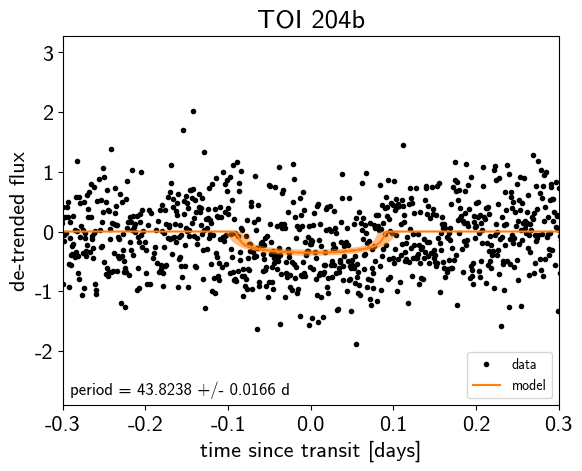

In [10]:
with model:
    light_curves = np.empty((500, len(model.x), len(periods)))
    func = xo.utils.get_theano_function_for_var(model.light_curves)
    for i, sample in enumerate(xo.utils.get_samples_from_trace(
            trace, size=len(light_curves))):
        light_curves[i] = func(*xo.utils.get_args_for_theano_function(sample))

for n, letter in enumerate(letters):
    plt.figure()

    # Compute the GP prediction
    mean_mod = np.median(trace["mean"][:, None])

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    inds = np.arange(len(periods)) != n
    others = np.median(1e3*np.sum(light_curves[:, :, inds], axis=-1), axis=0)

    # Plot the folded data
    x_fold = (model.x - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, model.y - mean_mod - others, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = 1e3 * light_curves[:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("TOI {0}{1}".format(toi_num, letter));
    plt.xlim(-0.3, 0.3)

## Posterior constraints

Given the MCMC sampling, we can make some plots summarizing the constraints on the key parameters.
First up, we plot the physical radius of the planet using the stellar radius constraint from the TOI list, and the impact parameter (remember that we're using circular orbits).

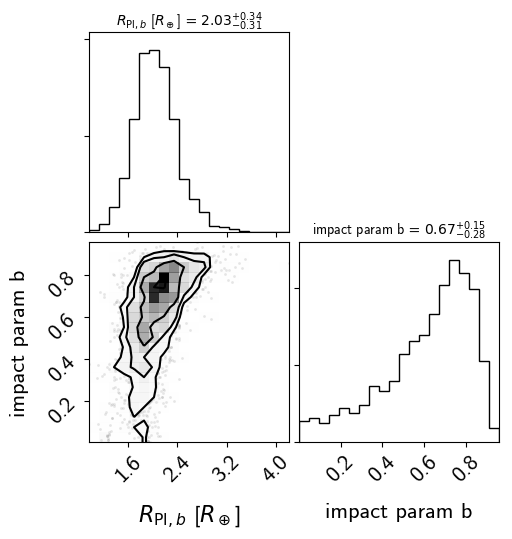

In [11]:
# Convert to Earth radii
r_pl = trace["r_pl"] * 109.07637070600963
samples = np.concatenate((r_pl, trace["b"]), axis=-1)

labels = ["$R_{{\mathrm{{Pl}},{0}}}$ [$R_\oplus$]".format(i) for i in letters]
labels += ["impact param {0}".format(i) for i in letters]

corner.corner(samples, labels=labels,
              show_titles=True, title_kwargs=dict(fontsize=10));

The other most interesting parameters are the period and transit times.

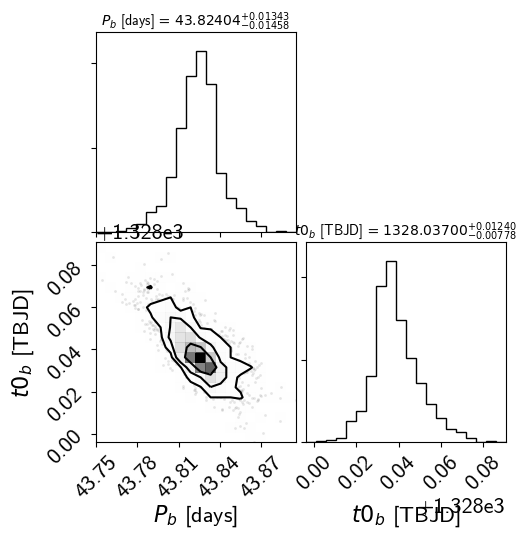

In [12]:
labels = ["$P_{{{0}}}$ [days]".format(i) for i in letters]
labels += ["$t0_{{{0}}}$ [TBJD]".format(i) for i in letters]
samples = np.concatenate((trace["period"], trace["t0"]), axis=-1)
corner.corner(samples, labels=labels,
              show_titles=True, title_fmt=".5f",
              title_kwargs=dict(fontsize=10));

Finally, here are the posterior constraints on the stellar properties.
These won't be exactly the same as the prior because the duration of the transits (and the assumption of circular orbits )

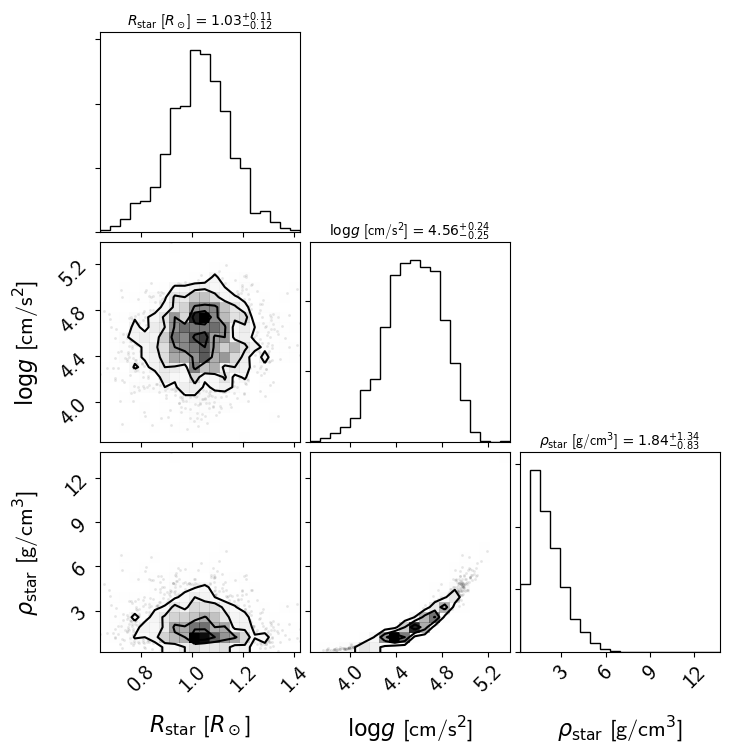

In [13]:
labels = ["$R_\mathrm{star}$ [$R_\odot$]", "$\log g$ [cm/s$^2$]",
          r"$\rho_\mathrm{star}$ [g/cm$^3$]"]
samples = np.vstack((trace["r_star"], trace["logg_star"], trace["rho_star"])).T
corner.corner(samples, labels=labels,
              show_titles=True,
              title_kwargs=dict(fontsize=10));

## Attribution

If you use these results or this code, please consider citing the relevant sources.
First, you can [cite the lightkurve package](https://zenodo.org/record/2611871):

```bibtex
@misc{lightkurve,
  author       = {Geert Barentsen and
                  Christina Hedges and
                  Zé Vinícius and
                  Nicholas Saunders and
                  gully and
                  Oliver Hall and
                  Sheila Sagear and
                  Tom Barclay and
                  KenMighell and
                  Keaton Bell and
                  Johnny Zhang and
                  Emma Turtelboom and
                  Zach Berta-Thompson and
                  Peter Williams and
                  Jose A Lerma III and
                  Guy Davies and
                  Brennan Vincello and
                  Anand Sundaram},
  title        = {KeplerGO/lightkurve: Lightkurve v1.0b30},
  month        = mar,
  year         = 2019,
  doi          = {10.5281/zenodo.2611871},
  url          = {https://doi.org/10.5281/zenodo.2611871}
}
```

You can also [cite the exoplanet project and its dependencies](https://exoplanet.dfm.io/en/stable/tutorials/citation/) using the following acknowledgement:

In [14]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


and BibTeX entries:

In [15]:
print(bib)


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
}


@article{exoplanet:pymc3,
    title={Probabilistic programming in Python using PyMC3},
   author={Salvatier, John and Wiecki, Thomas V and Fonnesbeck, Christopher},
  journal={PeerJ Computer Science},
   volume={2},
    pages={e55},
     year={2016},
publisher={PeerJ Inc.}
}


@article{exoplanet:theano,
    title="{Theano: A {Python} framework for fast computation of mathematical
            expressions}",
   author={{Theano Development Team}},
  journal={arXiv e-prints},
   volume={abs/1605.02688},
     year=2016,
    month=may,
      url={http://arxiv.org/abs/1605.02688}
}


@ARTICLE{exoplanet:kipping13,
   author = {{Kipping}, D.~M.},
    title = "{Efficient, uninformative sampling of limb darke

## Environment

This notebook was run with the following conda environment:

In [16]:
!conda env export

name: tessatlas
channels:
  - defaults
dependencies:
  - astropy=3.1.2=py37h7b6447c_0
  - atomicwrites=1.3.0=py37_1
  - attrs=19.1.0=py37_1
  - blas=1.0=mkl
  - ca-certificates=2019.1.23=0
  - certifi=2019.3.9=py37_0
  - cycler=0.10.0=py37_0
  - dbus=1.13.6=h746ee38_0
  - expat=2.2.6=he6710b0_0
  - fontconfig=2.13.0=h9420a91_0
  - freetype=2.9.1=h8a8886c_1
  - glib=2.56.2=hd408876_0
  - gst-plugins-base=1.14.0=hbbd80ab_1
  - gstreamer=1.14.0=hb453b48_1
  - icu=58.2=h9c2bf20_1
  - intel-openmp=2019.3=199
  - jpeg=9b=h024ee3a_2
  - kiwisolver=1.0.1=py37hf484d3e_0
  - libedit=3.1.20181209=hc058e9b_0
  - libffi=3.2.1=hd88cf55_4
  - libgcc-ng=8.2.0=hdf63c60_1
  - libgfortran-ng=7.3.0=hdf63c60_0
  - libpng=1.6.36=hbc83047_0
  - libstdcxx-ng=8.2.0=hdf63c60_1
  - libuuid=1.0.3=h1bed415_2
  - libxcb=1.13=h1bed415_1
  - libxml2=2.9.9=he19cac6_0
  - matplotlib=3.0.3=py37h5429711_0
  - mkl=2019.3=199
  - mkl_fft=1.0.10=py37ha843d7b_0
  - mkl_random=1.0.2=py37hd81dba3_0
  - more-itertools=6.0.0=py3